# Focusing on the North Celestial Pole Loop

Now that I have looked at the SPIDER on its own, it is time to look at the bigger picture. The SPIDER is not just on its own in the sky, it apart of the North Celestial Pole Loop (NCPL) which also connects Ursa Major and Polaris. It is important to look at the NCPL because it can help us find more evidence that a phase transition occured.

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA, fit_spec
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
fitsname = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[:,:,:][0]
cube.shape

(654, 495, 603)

In [5]:
y_corner = 410-256 ; x_corner = 295 #y_corner_top, x_corner_left
subcube = cube[:, y_corner:y_corner+256, x_corner:x_corner+256]

In [6]:
hdr["NAXIS1"] = 256
hdr["NAXIS2"] = 256
hdr["CRPIX1"] -= 295
hdr["CRPIX2"] -= 154

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [7]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

Need to adjust the header for the axis to have correct units. I can define where I want my cuts in velocity and/or in the x and y axes, then subtract from the original header.

In [8]:
idx_lim_left = 200; idx_lim_right = 400

In [9]:
hdr["NAXIS3"] = 200 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= idx_lim_left # This is to fix the position of the peaks to have the right index and velocity

In [10]:
index_arr = np.arange(cube[0].shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

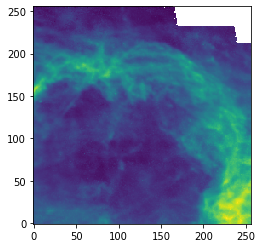

In [11]:
plt.imshow(np.sum(subcube, 0), origin='lower')

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [12]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [13]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-((x-cent)/(2*sigma))**2)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        c = params[i+1]
        s = params[i+2]
        y = y + a * np.exp( -((x - c)/(2*s))**2)
    return y

## Define the limits and the region

In [14]:
subvel = vel[:idx_lim_right-idx_lim_left]
subcube = subcube[idx_lim_left:idx_lim_right,:,:]

I can first just plot a random spectrum, then also plot the average spectrum, which will give us more information

In [15]:
# x_rand = 70; y_rand = 110 #interesting point 
# x_rand = 113; y_rand = 145 #interesting point 
# x_rand = 154; y_rand = 23 #interesting point 

x = 135  y = 74


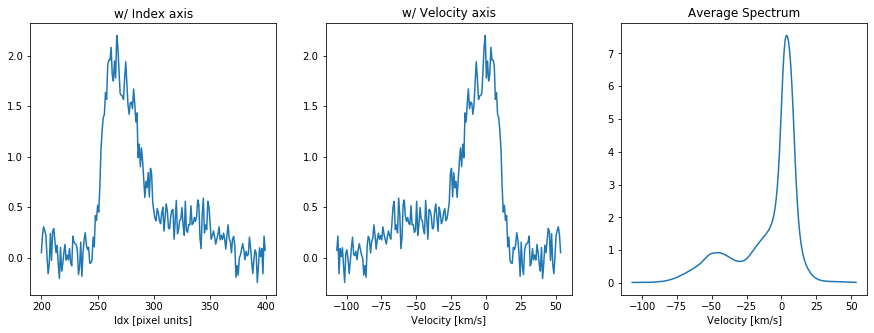

In [16]:
x_rand = random.randint(0,255) ; y_rand = random.randint(0,255)
print('x =',x_rand,' y =',y_rand)

avg = np.nanmean(subcube, (1,2))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], subcube[:,y_rand, x_rand])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, subcube[:,y_rand, x_rand])

plt.subplot(1,3,3)
plt.title("Average Spectrum"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, avg)

plt.show()

## Noise Map

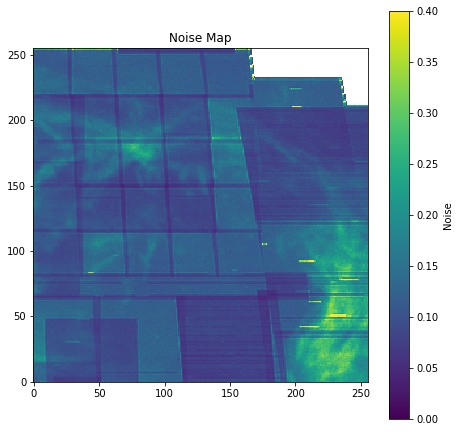

In [17]:
fig=plt.figure(figsize=(7.5,7.5))
#noise_cube = cube[:24] # Using the first 24 channels of the index axis.
#noise = np.std(noise_cube, 0)

noise = hdu[2].data[:,:][y_corner:y_corner+256, x_corner:x_corner+256]

rms = np.array([noise*(1+channel/20) for channel in subcube]) # channel means T_b
plt.title("Noise Map")
plt.imshow(rms[37+25], origin='lower', vmin=0, vmax=0.4) ; plt.colorbar(label='Noise')
#fig.savefig("Noise_map.png", bbox_inches='tight')

## Getting ROHSA to analyze a region

In [18]:
#!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
#import os
#os.chdir('ROHSA/src')
#!make
#os.chdir('../../')

## Define the ROHSA parameters

In [19]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

In [20]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube.shape)
LVC_cube[LVC_cube != LVC_cube] = 0

(105, 256, 256)


In [21]:
# Ranges:
subcube = subcube[:105] #[30:90]
subvel = subvel[:105] #[30:90]
rms = rms[:105] #[30:90]

subcube[subcube != subcube] = 0
#rms[rms != rms] = 0

path = "/mnt/raid-project/hp/mtaank/repos/Mukesh_SURP/NCPL/"

hdu0 = fits.PrimaryHDU(LVC_cube, header=hdr)
hdulist0 = fits.HDUList([hdu0])
hdulist0.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits", overwrite=True)

hdu1 = fits.PrimaryHDU(rms, header=hdr)
hdulist1 = fits.HDUList([hdu1])
hdulist1.writeto(path + "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_rms_100_100.fits", overwrite=True)

(105, 256, 256)

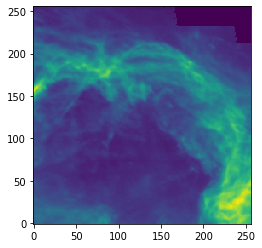

In [22]:
fitsname_test = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits"
hdu_test = fits.open(fitsname_test)
hdr_test = hdu_test[0].header
test = hdu_test[0].data[:,:,:]
plt.imshow(np.sum(test, 0), origin='lower')
test.shape

Now to set up the parameters for the Gaussian decomposition.

In [23]:
filename = "GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_100_100.fits" #@param
fileout = "!GHIGLS_NCPL_Tb_gauss_run_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.fits" #@param
filename_parameters = "parameters_NCPL_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.txt"
filename_noise = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED_LVC_cube_rms_100_100.fits'
#filename_init_spec = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_inits_11G_TEST_3FITS_using_ROHSA_init_TEST.dat"
n_gauss = 6        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 500  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".true."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 1.0
ub_sig_init = 10.
lb_sig = 1.0
ub_sig = 12.0
init_spec = '.false.'
norm_var = '.true.'

core = ROHSA(LVC_cube, hdr=hdr_LVC)  
#core_rms = ROHSA(rms)
#core.array2dat(init_array_core, filename=filename_init_spec)
###core.cube2dat(filename=filename)
###core_rms.cube2dat(filename=filename_noise)
core.gen_parameters_3D(filename=filename, 
                    fileout=fileout,
                    filename_noise=filename_noise,
                    filename_parameters=filename_parameters,
                    #filename_init_spec=filename_init_spec,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    noise=noise,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    iprint_init=iprint_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    #init_spec=init_spec,
                    save_grid=save_grid,
                    norm_var=norm_var)

Generate parameters_NCPL_Noise3D_100_100_LVC_cube_boot_6G_norm_var=true_with_100_500.txt file


In [24]:
#! ./ROHSA/src/ROHSA-3D parameters_NCPL_Noise3D_11G_no_init_ROHSA-3FITS.txt

## Obtain the Gaussian parameters for the decomposition

In [25]:
#!export PATH=$PATH:/home/amarchal/ROHSA-3FITS/src

In [26]:
#! ROHSA-3FITS paSrameters_NCPL_Noise3D_TEST_norm_var_LVC_cube_7G_norm_var=false.txt

In [27]:
n_gauss=7

In [28]:
fitsname_gaussian = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_boot_7G_norm_var=true_100_100_NEW.fits"
hdu_gaussian = fits.open(fitsname_gaussian)
hdr_gaussian = hdu_gaussian[0].header
gaussian = hdu_gaussian[0].data[:,:,:]
print(gaussian.shape)

model = core.return_result_cube(gaussian=gaussian)
print(model.shape)

amplitude = gaussian[0::3]
position = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian[1::3]))
dispersion = gaussian[2::3] * dv

amplitude_pix = gaussian[0::3]
position_pix = gaussian[1::3]
dispersion_pix = gaussian[2::3]

integral = amplitude * dispersion * np.sqrt(2*np.pi) 
NHI_map = integral * C

(21, 256, 256)
(105, 256, 256)


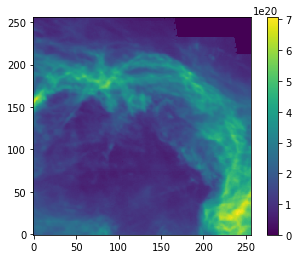

In [29]:
plt.imshow(np.sum(model, 0)*C*dv, origin='lower') ; plt.colorbar()

## Plot a Spectrum

Now, I want to plot a random spectrum / pixel in this region

In [30]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, model2="None", caption=""):
    fig = plt.figure()
    plt.xlabel("$v$ [km s$^{-1}$]", fontsize=13)
    plt.ylabel("T$_{b}$ [K]", fontsize=13)
    plt.plot(vel, cube, color='darkorchid', label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    plt.plot(vel, model , 'black')#, label="model (pix by pix)")
    if model2 != "None":
        plt.plot(vel, model2 , 'g')#, label="model (comp by comp)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos])
        if gaussian[2::3][i][y_pos,x_pos] < 2.5:
            plt.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos] >=2.5 and gaussian[2::3][i][y_pos,x_pos] < 4.5:
            plt.plot(vel, gauss, color='green')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos] >= 4.5:
            plt.plot(vel, gauss, color='blue')#, label="WNM")
    
    plt.legend()
    #plt.show()
    fig.savefig(caption, bbox_inches="tight")

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

def plot_spect_color(x, y, v, model, cube, gaussian, caption=""):
    #fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel("v [$km$ $s^{-1}$]")
    ax.set_ylabel("T$_{b}$ [$K$]")
    ax.plot(v, cube, color='green',  label="data")
    ax.plot(v, model , color='black', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(v)), gaussian[0::3][i][y,x], gaussian[1::3][i][y,x], gaussian[2::3][i][y,x])
        if gaussian[2::3][i][y,x] < 2.0:
            ax.plot(v, gauss, color='deepskyblue', label="CNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >=2.0 and gaussian[2::3][i][y,x] < 4.5:
            ax.plot(v, gauss, color='darkorchid', label="UNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >= 4.5:
            ax.plot(v, gauss, color='red', label="WNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____, alpha=0.2)
            
    #legend_without_duplicate_labels(ax)
    fig.savefig(caption, bbox_inches="tight")

x =  65
y =  6


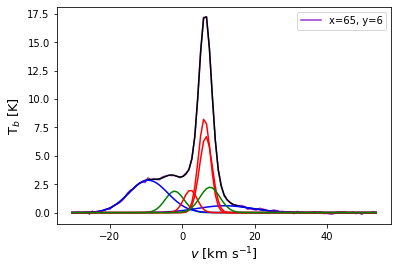

The column density for each Gaussian: 
 [1.6750164e+19 2.0746969e+19 2.2385731e+19 2.8176753e+19 5.3941363e+19
 6.2331736e+19 6.9775778e+19] 

The fractional column density for each Gaussian: 
 [0.06110779 0.0756889  0.08166742 0.10279417 0.19678839 0.22739807
 0.25455534]


In [31]:
x_pos = random.randint(0,255) ; 
y_pos = random.randint(0,255)
print("x = ", x_pos) ; print("y = ", y_pos)

plot_spect(x_pos, y_pos, subvel, model[:, y_pos, x_pos], LVC_cube[:, y_pos, x_pos], gaussian, model2="None", caption="random_spec.png")
plt.show()
#plot_spect_color(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian)
#plt.show()

#Now can look at these Gaussians to see if they are significant by looking at the integral

integral_spectrum = (amplitude[:,y_pos,x_pos] * dispersion[:,y_pos,x_pos] * np.sqrt(2*np.pi) * C)
sum_of_integral = np.sum(integral_spectrum)
frac_integral = integral_spectrum / sum_of_integral
print("The column density for each Gaussian: \n",np.sort(integral_spectrum), '\n')
print("The fractional column density for each Gaussian: \n",np.sort(frac_integral))

# Good one: x=26, y=8

## Find the value of $\chi^{2}$

### Map of Degrees of Freedom

In [32]:
free_params_map = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_LVC = np.zeros((subcube.shape[2],subcube.shape[1]))
free_params_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_BVC = np.zeros((subcube.shape[2],subcube.shape[1]))
lim_for_signif_gauss = 1.e-2

for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss_LVC = 0
        for k in range(n_gauss):
            #LVC
            if position[k][j][i] > -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_LVC = num_good_gauss_LVC + 1
                
        signif_gauss_map_LVC[j][i] = num_good_gauss_LVC
        free_params_map_LVC[j][i] = (75) - 3*num_good_gauss_LVC
        
        
        num_good_gauss_BVC = 0
        for k in range(n_gauss):
            #BVC
            if position[k][j][i] <= -7:
                if frac_integral[k] > lim_for_signif_gauss:
                    num_good_gauss_BVC = num_good_gauss_BVC + 1
                
        signif_gauss_map_BVC[j][i] = num_good_gauss_BVC
        free_params_map_BVC[j][i] = (105-75) - 3*num_good_gauss_BVC
        
for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum = (amplitude[:,j,i] * dispersion[:,j,i] * np.sqrt(2*np.pi) * C)
        sum_integ_spec = np.sum(integral_spectrum)
        frac_integral = integral_spectrum / sum_integ_spec
        
        num_good_gauss = 0
        for k in range(n_gauss):
            
            if frac_integral[k] > lim_for_signif_gauss:
                num_good_gauss = num_good_gauss + 1
                
        signif_gauss_map[j][i] = num_good_gauss
        free_params_map[j][i] = (subcube.shape[0]) - 3*num_good_gauss        

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


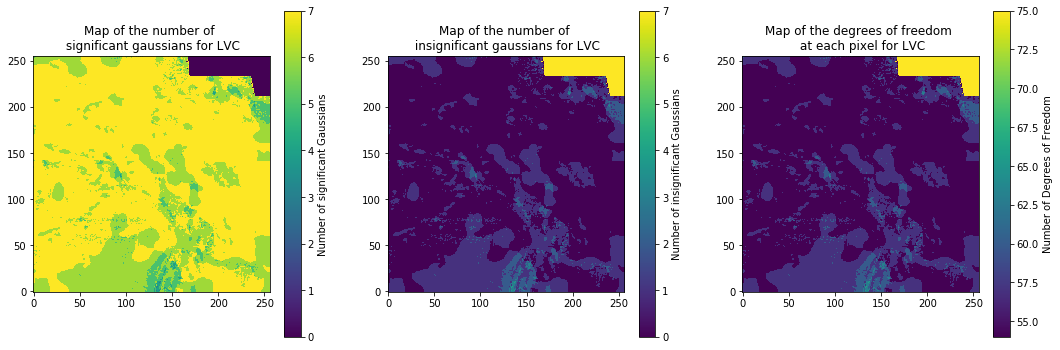

In [33]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for LVC")
plt.imshow(signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for LVC")
plt.imshow(n_gauss - signif_gauss_map_LVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for LVC")
plt.imshow(free_params_map_LVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

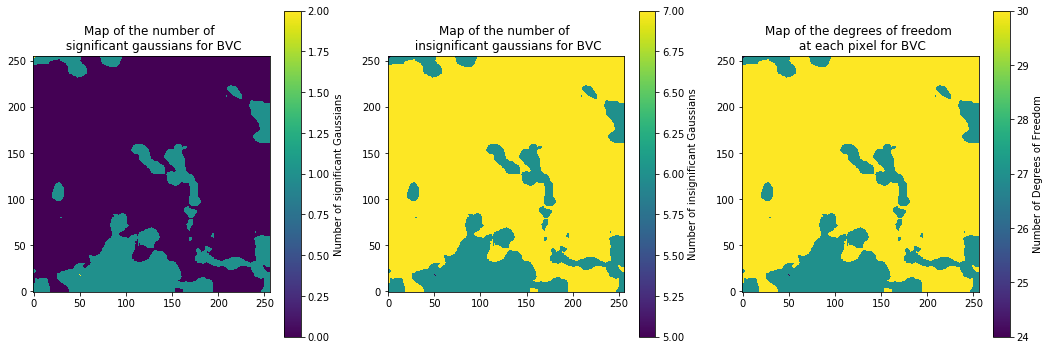

In [34]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians for BVC")
plt.imshow(signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians for BVC")
plt.imshow(n_gauss - signif_gauss_map_BVC, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel for BVC")
plt.imshow(free_params_map_BVC, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

mean of significant gaussians =  6.6002349853515625
mean of insignificant gaussians =  0.3997650146484375


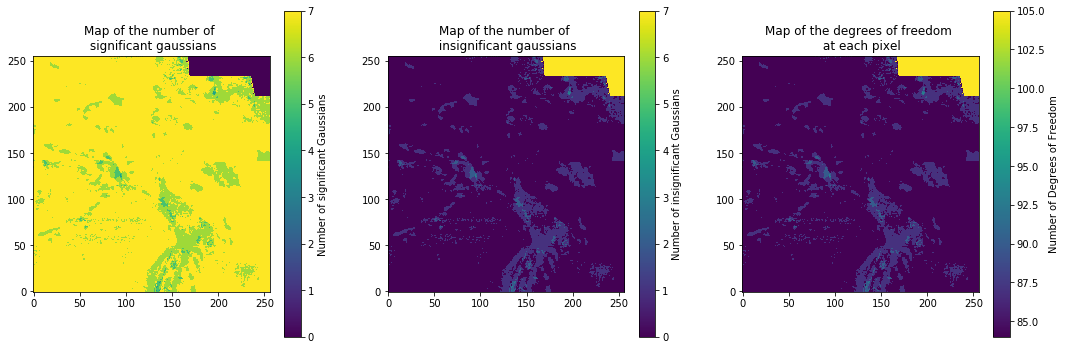

In [35]:
# Can plot a map of the number of free parameters at each pixel
fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1) ; plt.title("Map of the number of \n significant gaussians")
plt.imshow(signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of significant Gaussians")
plt.subplot(1,3,2) ; plt.title("Map of the number of \n insignificant gaussians")
plt.imshow(n_gauss - signif_gauss_map, origin='lower') ; plt.colorbar(label="Number of insignificant Gaussians")
plt.subplot(1,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel")
plt.imshow(free_params_map, origin='lower') ; plt.colorbar(label="Number of Degrees of Freedom")
plt.subplots_adjust(wspace=0.2)

print("mean of significant gaussians = ", np.mean(signif_gauss_map))
print("mean of insignificant gaussians = ", np.mean(n_gauss - signif_gauss_map))
#fig.savefig("Map_of_Degrees_of_Freedom_and_Significant_Gauss.png", bbox_inches='tight')

### Map of $\chi^{2}$

In [36]:
diff = (model[:105] - LVC_cube[:105])

chi_sq_map = np.sum((diff/rms[:105])**2, 0)

#chi_sq_map[chi_sq_map != chi_sq_map] = 0
red_chi_sq_map = chi_sq_map / free_params_map
#red_chi_sq_map[red_chi_sq_map != red_chi_sq_map] = 0

In [37]:
diff_LVC = (model[:75] -LVC_cube[:75])

chi_sq_map_LVC = np.sum((diff_LVC / rms[:75])**2, 0)

#chi_sq_map_LVC[chi_sq_map != chi_sq_map_LVC] = 0
red_chi_sq_map_LVC = chi_sq_map_LVC / free_params_map_LVC
#red_chi_sq_map_LVC[red_chi_sq_map_LVC != red_chi_sq_map_LVC] = 0

In [38]:
diff_BVC = (model[75:] - LVC_cube[75:])

chi_sq_map_BVC = np.sum((diff_BVC / rms[75:])**2, 0)
#chi_sq_map_BVC[chi_sq_map != chi_sq_map_BVC] = 0
red_chi_sq_map_BVC = chi_sq_map_BVC / free_params_map_BVC
#red_chi_sq_map_BVC[red_chi_sq_map_BVC != red_chi_sq_map_BVC] = 0

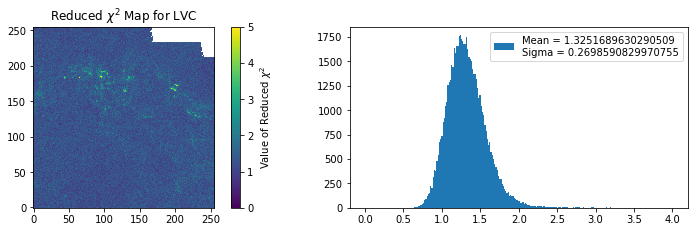

In [39]:
fig=plt.figure(figsize=(20/1.5,5/1.5))
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map for LVC")
plt.imshow(red_chi_sq_map_LVC, origin='lower', vmin=0, vmax=5.) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map_LVC, x_red_chisq_map_LVC, _red_chisq_map_LVC = plt.hist(red_chi_sq_map_LVC.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.nanmean(red_chi_sq_map_LVC))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map_LVC))))
plt.legend()
#fig.savefig("rchi_sq_LVC_8G.png", bbox_inches='tight')

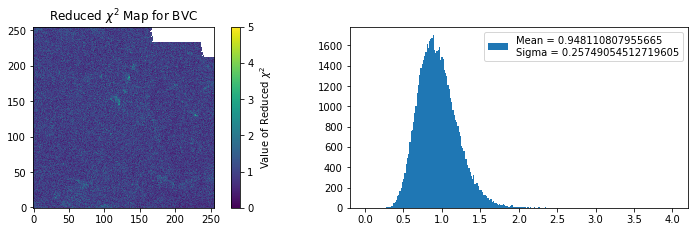

In [40]:
fig=plt.figure(figsize=(20/1.5,5/1.5))
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map for BVC")
plt.imshow(red_chi_sq_map_BVC, origin='lower', vmin=0, vmax=5.) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map_BVC, x_red_chisq_map_BVC, _red_chisq_map_BVC = plt.hist(red_chi_sq_map_BVC.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.nanmean(red_chi_sq_map_BVC))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map_BVC))))
plt.legend()
#fig.savefig("rchi_sq_BVC_8G.png", bbox_inches='tight')

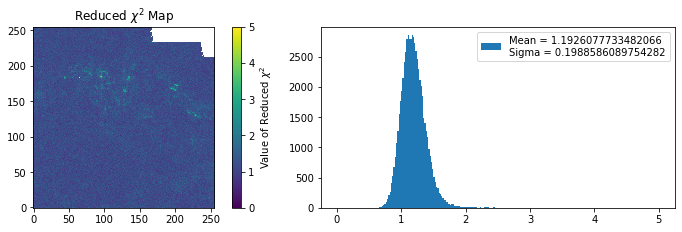

In [41]:
fig = plt.figure(figsize=(20/1.5,5/1.5))
#plt.subplot(2,2,1)
#plt.title("$\chi^{2}$ Map")
#plt.imshow(chi_sq_map, origin='lower', vmin=0, vmax=500.) ; plt.colorbar(label="Value of $\chi^{2}$")
#plt.subplot(2,2,2)
#y_chisq_map, x_chisq_map, _chisq_map = plt.hist(chi_sq_map.ravel(), bins=250, range=[1e-20,300.], label="Mean = "+str(np.nanmean(chi_sq_map))+"\nSigma = "+str(np.sqrt(np.var(chi_sq_map))))
#plt.legend()
plt.subplot(1,2,1)
plt.title("Reduced $\chi^{2}$ Map")
plt.imshow(red_chi_sq_map, origin='lower', vmin=0, vmax=5) ; plt.colorbar(label="Value of Reduced $\chi^{2}$")
plt.subplot(1,2,2)
y_red_chisq_map, x_red_chisq_map, _red_chisq_map = plt.hist(red_chi_sq_map.ravel(), bins=250, range=[1e-20,5.], label="Mean = "+str(np.nanmean(red_chi_sq_map))+"\nSigma = "+str(np.sqrt(np.nanvar(red_chi_sq_map))))
plt.legend()
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#fig.savefig("rchi_sq_full_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')#

The following pixel spectrum represents the one with the worst chi squared value.

In [42]:
y_pos, x_pos = np.unravel_index(chi_sq_map.argmax(), chi_sq_map.shape)
print("x = ", x_pos) ; print("y = ", y_pos)
print("value of chi squared for this spectrum: ",chi_sq_map[y_pos][x_pos])

plot_spect_color(x_pos, y_pos, subvel, model[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian)

x =  240
y =  212
value of chi squared for this spectrum:  nan


This was actually determined to be a problem due to RFI (Radio Frequency Interference) when the data recording was done.

In [43]:
#sub_hdr = hdr
#sub_hdr["CRPIX1"] -= 285
#sub_hdr["CRPIX2"] -= 154

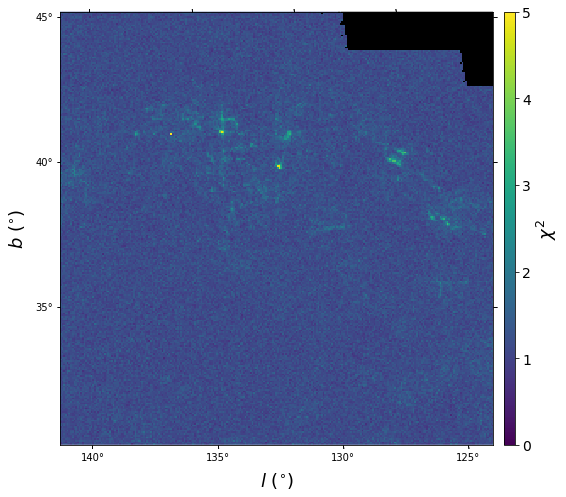

In [44]:
red_chi_sq_map[red_chi_sq_map == 0.] = np.nan
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='darkgrey')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)
import marchalib as ml
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(10.5/1.33, 10/1.33))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=18.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=18.)
img = ax.imshow(red_chi_sq_map, vmin=0,vmax=5, **imkw_viridis)
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$\chi^{2}$", fontsize=18.)
#plt.savefig('chi_2_map_LVC_cube_injected_noise_11G_with_5G.png', format='png', bbox_inches='tight', pad_inches=0.02)

### Map of $\chi^{2}$ Contribution

In [45]:
chi_sq_contrib = (diff / rms[:105])**2
#chi_sq_contrib[chi_sq_contrib != chi_sq_contrib] = 0

channel = 46


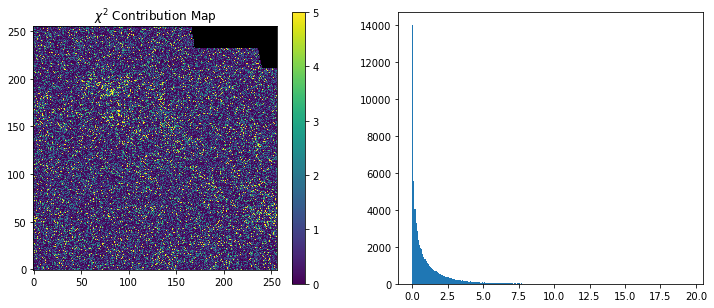

In [46]:
channel = np.random.randint(0,75)
print("channel =", channel)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("$\chi^{2}$ Contribution Map")
plt.imshow(chi_sq_contrib[channel], origin='lower', vmin=0, vmax=5.) ; plt.colorbar()
plt.subplot(1,2,2)
y_chisq_contrib, x_chisq_contrib, _chisq_contrib = plt.hist(chi_sq_contrib[channel].ravel(), bins=250)
plt.show()

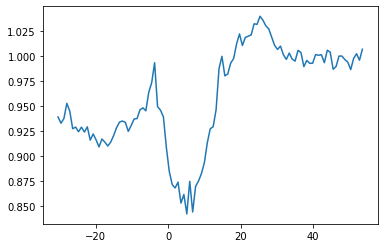

In [47]:
chi_sq_contrib = (diff / rms)**2

fig=plt.figure()
plt.plot(subvel, np.nanmean(chi_sq_contrib, (1,2)))
#fig.savefig("chi_sq_contrib_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

## Plot a mosaic of spectra

x =  17
y =  101


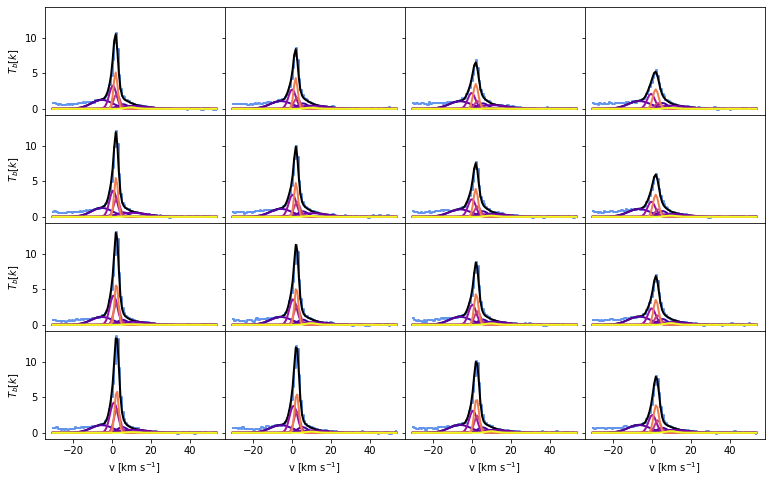

In [48]:
## Mosaic of the Spectra
x_pos = np.random.randint(0,255) ; print("x = ", x_pos)
y_pos = np.random.randint(0,255) ; print("y = ", y_pos)

pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = y_pos; center_x = x_pos
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel, subcube[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(subvel, model[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(subvel, core.gauss(np.arange(len(subvel)), gaussian[0::3][k][center_y+i,center_x+j],
                                              gaussian[1::3][k][center_y+i,center_x+j], gaussian[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.plasma(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'$T_{b}[k]$')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
#fig.savefig("Mosaic_of_Spectra.png", bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

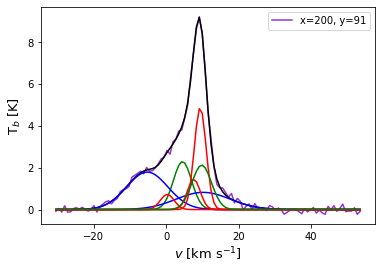

In [49]:
plt.figure(figsize=(20,10))
x_pos = random.randint(0,255) ; y_pos = random.randint(0,255)
plot_spect(x_pos, y_pos, subvel, model[:, y_pos, x_pos], LVC_cube[:, y_pos, x_pos], gaussian, model2="None", caption="random_spec.png")
plt.show()
# x=27, y=194

# 2D Histogram: Sigma-Mu

In [50]:
iddx = np.argsort(np.mean(position, axis=(1,2)))
field = np.array([NHI_map[idd] for idd in iddx])
vfield = np.array([position[idd] for idd in iddx])
pixfield = np.array([position_pix[idd] for idd in iddx])
ampfield = np.array([amplitude[idd] for idd in iddx])
sigfield = np.array([dispersion[idd] for idd in iddx])

In [51]:
LVC_IVC1_bound_CNM_UNM = -7.
LVC_IVC1_bound_WNM = LVC_IVC1_bound_CNM_UNM
IVC1_IVC2_bound = -30.
CNM_UNM_LVC_bound = 2.2
CNM_UNM_IVC1_2_bound = CNM_UNM_LVC_bound
UNM_WNM_bound = 4.75
CNM_UNM_bound = CNM_UNM_LVC_bound 

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10



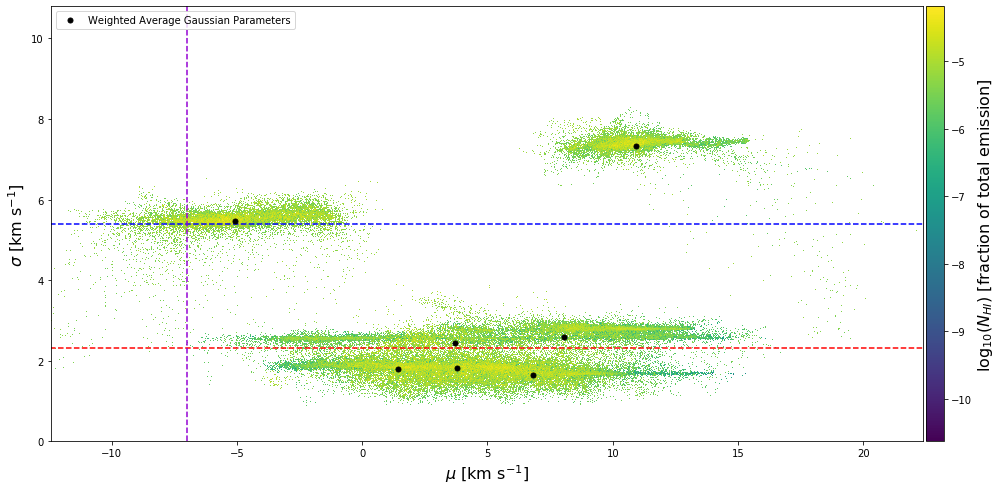

In [52]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

#foo = init_array
#for i in range(len(foo)):
#    amp = foo[::3]
#    pos = np.array(spec_2_velocity(crval3,cdelt3,crpix3,foo[1::3]))
#    dis = foo[2::3]*dv
    
x_bins = np.linspace(np.min(vfield.ravel()), np.max(vfield.ravel()), 1200)
y_bins = np.linspace(0.1,np.max(sigfield)+1, 1200)
H, xedges, yedges = np.histogram2d(vfield.ravel(), sigfield.ravel(),
                                   weights=np.sqrt(2.*np.pi)*ampfield.ravel()*(sigfield.ravel())*C/np.sum(field),
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))

#Weighted Averages of the Clusters:
weighted_vel = [np.sum(vfield[i]*field[i])/np.sum(field[i]) for i in range(n_gauss)]
weighted_sig = [np.sum(sigfield[i]*field[i])/np.sum(field[i]) for i in range(n_gauss)]

#plt.plot(subvel, np.nanmean(subcube, (1,2)), color="black")
#plt.plot(pos, dis, color='darkorange', linestyle='None', marker='.', markersize=10, label="ROHSA_init Optimal Params")
#plt.plot(np.mean(vfield, (1,2)).ravel(), np.mean(sigfield, (1,2)).ravel(), color='black', linestyle='None', marker='.', markersize=10, label="Average Gaussian Params")
#plt.plot(np.array(spec_2_velocity(crval3,cdelt3,crpix3,init_array_core[1::3])).ravel(), np.array(init_array_core[2::3]).ravel(), color="darkgoldenrod", linestyle='None', marker='^', markersize=7, label="ROHSA_init Parameters")
plt.plot(np.array(weighted_vel).ravel(), np.array(weighted_sig).ravel(), color='black', linestyle='None', marker='o', markersize=5, label="Weighted Average Gaussian Parameters")
plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='darkviolet', linestyle='--'),# label="LVC-IVC1 Boundary")
plt.axvline(x=IVC1_IVC2_bound, color='violet', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=-90, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.axvline(x=25, color='black', linestyle='--') #label="IVC1-IVC2 Boundary")
plt.hlines(y=5.4,xmin=-120, xmax=80, color='blue', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=2.3,xmin=-120, xmax=80, color='red', linestyle="--")
plt.plot()
plt.legend(loc="upper left")

ax = fig.add_subplot(111)
ax.set_ylim([0., np.max(sigfield)+2.5])
ax.set_xlim([np.min(vfield.ravel()),np.max(vfield.ravel())])
ax.set_xlabel(r'$\mu$ [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)

#fig.savefig("sigma_v_diagram_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches="tight")

In [53]:
#fig = plt.figure(figsize=(20,5))
#plt.subplot(1,3,1)# ; plt.title("CNM Mass Fraction", fontsize=15)
#plt.imshow(field[0], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplot(1,3,2)# ; plt.title("LNM Mass Fraction", fontsize=15)
#plt.imshow(field[1], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplot(1,3,3)# ; plt.title("WNM Mass Fraction", fontsize=15)
#plt.imshow(field[2], origin='lower', cmap="inferno") ; plt.colorbar()
#plt.subplots_adjust(wspace=0.)
#fig.savefig("Column_Density_Maps_WNM_cube_from_10G_SMART_soln_with_3G.png", bbox_inches='tight')

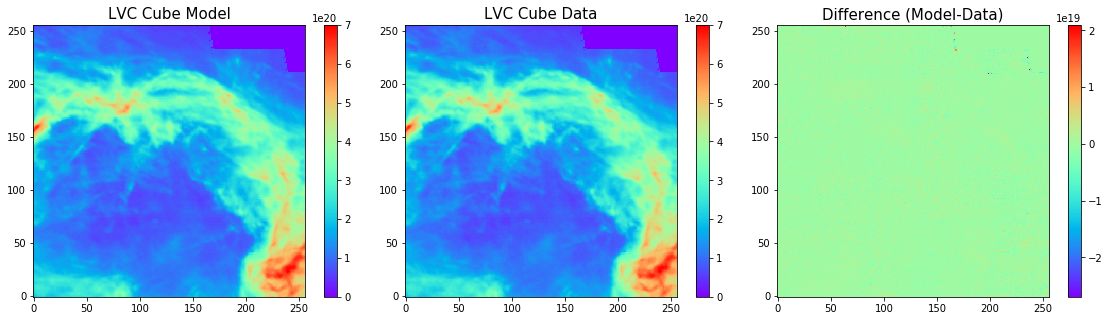

In [54]:
fig = plt.figure(figsize=(20,5))
sum_model = np.sum(model, 0)
sum_LVCcube = np.sum(LVC_cube, 0)
plt.subplot(1,3,1) ; plt.title("LVC Cube Model", fontsize=15)
plt.imshow(sum_model*C*dv, origin='lower', cmap='rainbow', vmax=7e20) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LVC Cube Data", fontsize=15)
plt.imshow(sum_LVCcube*C*dv, origin='lower', cmap='rainbow', vmax=7e20) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("Difference (Model-Data)", fontsize=15)
plt.imshow((sum_model-sum_LVCcube)*C*dv, origin='lower', cmap='rainbow') ; plt.colorbar()
plt.subplots_adjust(wspace=0.)
#fig.savefig("Total_Map_compare_model&data_10G_SMART.png", bbox_inches='tight')

In [55]:
LVC_CNM = np.zeros((256,256)) ; BVC_CNM = np.zeros((256,256)) ; IVC_CNM = np.zeros((256,256))
LVC_LNM = np.zeros((256,256)) ; BVC_LNM = np.zeros((256,256)) ; IVC_LNM = np.zeros((256,256))
LVC_WNM = np.zeros((256,256)) ; BVC_WNM = np.zeros((256,256)) ; IVC_WNM = np.zeros((256,256))

for k in range(n_gauss):
    if weighted_sig[k] <= CNM_UNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
            LVC_CNM = LVC_CNM + field[k]
    if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
        if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_CNM = BVC_CNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_CNM = IVC_CNM + field[k]
    if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
            LVC_LNM = LVC_LNM + field[k]
    if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
        if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_LNM = BVC_LNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_LN = IVC_LNM + field[k]
    if weighted_sig[k] > UNM_WNM_bound:
        if weighted_vel[k] >= LVC_IVC1_bound_WNM:
            LVC_WNM = LVC_WNM + field[k]
        if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
            BVC_WNM = BVC_WNM + field[k]
        if weighted_vel[k] < IVC1_IVC2_bound:
            IVC_WNM = IVC_WNM + field[k]
            
total_LVC = LVC_CNM + LVC_LNM + LVC_WNM
total_BVC = BVC_CNM + BVC_LNM + BVC_WNM
total_IVC = IVC_CNM + IVC_LNM + IVC_WNM

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys



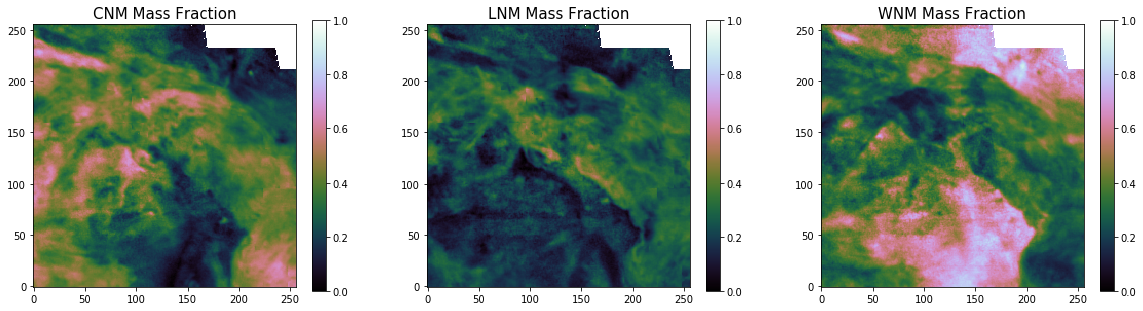

In [56]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1) ; plt.title("CNM Mass Fraction", fontsize=15)
plt.imshow(LVC_CNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM Mass Fraction", fontsize=15)
plt.imshow(LVC_LNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("WNM Mass Fraction", fontsize=15)
plt.imshow(LVC_WNM/total_LVC, origin='lower', cmap="cubehelix",vmin=0, vmax=1) ; plt.colorbar()
plt.subplots_adjust(wspace=0.2)
#fig.savefig("Mass_Fraction_Maps_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

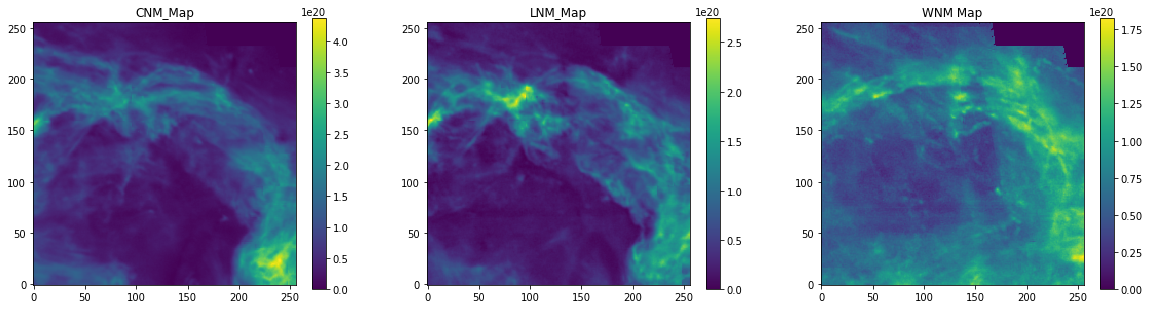

In [57]:
f=plt.figure(figsize=(20,5))
plt.subplot(1,3,3) ; plt.title("WNM Map")
plt.imshow(LVC_WNM, origin='lower') ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LNM_Map")
plt.imshow(LVC_LNM, origin='lower') ; plt.colorbar()
plt.subplot(1,3,1) ; plt.title("CNM_Map")
plt.imshow(LVC_CNM, origin='lower') ; plt.colorbar()
#f.savefig("Maps_of_CNM-and-WNM_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

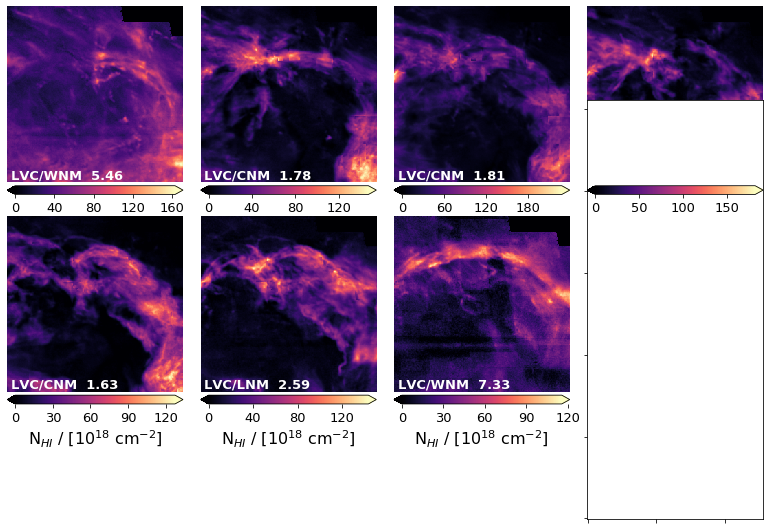

In [58]:
#Plot mosaic field   
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="magma")
        color = "white"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")       
                       
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=13.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno") 
        
#fig1.savefig("col_dens_mosaic_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png", bbox_inches='tight')

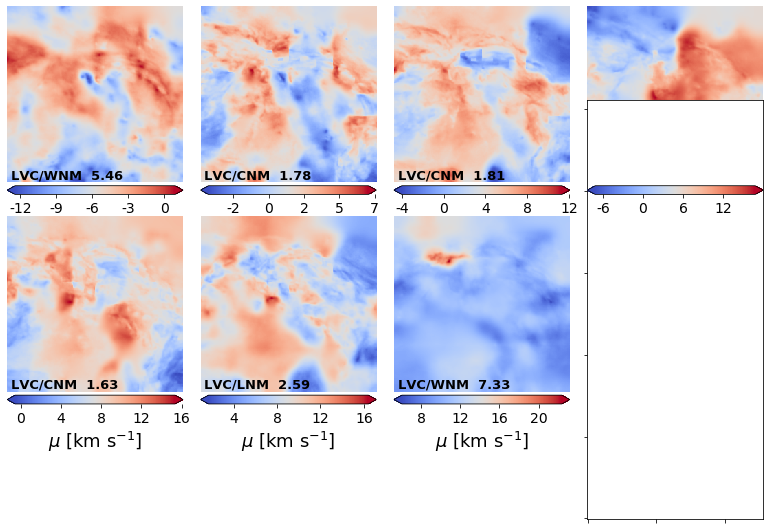

In [59]:
#Plot mosaic field mean
lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        color = "black"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=13., weight="bold")       
                   
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno")  
#plt.savefig('mean_velocity_mosaic_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png', format='png', bbox_inches='tight', pad_inches=0.02)

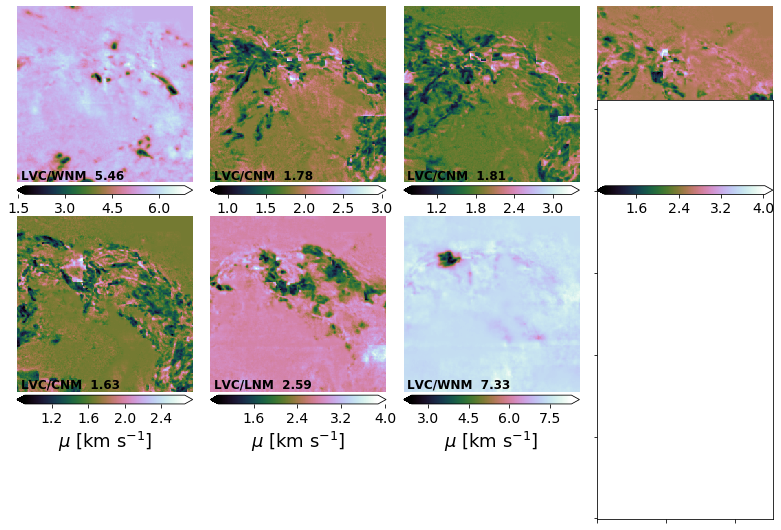

In [60]:
#Plot mosaic field sigma   
lh = 2; lw = 4
fig1, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((40/1.5,35/1.5))))
fig1.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=-0.5, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        color = "black"
        if weighted_sig[k] <= CNM_UNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] <= CNM_UNM_IVC1_2_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/CNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > CNM_UNM_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_CNM_UNM:
                axs[i][j].text(5,5,"LVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > CNM_UNM_IVC1_2_bound and np.mean(sigfield[k]) <= UNM_WNM_bound:
            if weighted_vel[k] < LVC_IVC1_bound_CNM_UNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/LNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
        if weighted_sig[k] > UNM_WNM_bound:
            if weighted_vel[k] >= LVC_IVC1_bound_WNM:
                axs[i][j].text(5,5,"LVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < LVC_IVC1_bound_WNM and np.mean(vfield[k]) >= IVC1_IVC2_bound:
                axs[i][j].text(5,5,"BVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")
            if weighted_vel[k] < IVC1_IVC2_bound:
                axs[i][j].text(5,5,"IVC/WNM  "+str(np.round(weighted_sig[k], 2)), color=color, size=12., weight="bold")       
                   
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\mu$ [km s$^{-1}$]", fontsize=18.)
        k += 1
        if k ==n_gauss:
            break
#axs[1][3].imshow(0*field[0]/10**18, origin="lower", cmap="inferno") 
#plt.savefig('mean_velocity_dispersion_100_100_LVC_cube_boot_8G_norm_var=true_100_500.png', format='png', bbox_inches='tight', pad_inches=0.02)

## 50 Runs :

In [61]:
fitsname_LVC = "LVC_cube_boot_100_100.fits"
hdu_LVC = fits.open(fitsname_LVC)
hdr_LVC = hdu_LVC[0].header
LVC_cube_base = hdu_LVC[0].data[:,:,:]
#core = ROHSA(LVC_cube_boot, hdr=hdr)
print(LVC_cube_base.shape)
LVC_cube_base[LVC_cube_base != LVC_cube_base] = 0

(105, 256, 256)


In [62]:
from ROHSApy import fit_spec
vmin = [0]
vmax = [105] #length of velocity axis
mean_spec = np.mean(LVC_cube_base, (1,2))
core_init = fit_spec(Tb=mean_spec)
init_array_core = core_init.init_spectrum(np.full((3*n_gauss), 1.), n_gauss,mean_spec,lb_sig_init,ub_sig_init, \
                                     iprint_init, amp_fact_init, sig_init, maxiter_init, 1, vmin, vmax)
fit_core = core_init.model_spectrum(init_array_core, mean_spec, n_gauss)

In [63]:
init_array_core 

array([ 1.88003577, 58.73752384,  6.25384632,  1.47374857, 73.64749182,
        6.99395193,  0.49379795, 51.18563257,  9.49364555,  0.49008262,
       64.47066578,  1.89090941,  0.4172865 , 56.35341555,  2.23590563,
        4.40705332, 61.93794339,  4.74973119,  0.55890986, 58.42158738,
        3.91628014])

In [64]:
num_runs=50

model_multi_from_sigma_v = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_from_sigma_v = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_from_sigma_v = np.zeros((num_runs, n_gauss, 256, 256))

In [65]:
for i in range(50):
    #fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_nh_weighting_FIXED_"+str(i)+".fits"
    #fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_nh_weighting_"+str(i)+".fits"
    fitsname_multi_from_sigma_v = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_sigma-v_step_iii_"+str(i)+".fits"
    hdu_multi_from_sigma_v = fits.open(fitsname_multi_from_sigma_v)
    hdr_multi_from_sigma_v = hdu_multi_from_sigma_v[0].header
    
    gaussian_multi_from_sigma_v[i] = hdu_multi_from_sigma_v[0].data[:,:,:]
    model_multi_from_sigma_v[i] = core.return_result_cube(gaussian=gaussian_multi_from_sigma_v[i])

    amplitude_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][0::3]
    position_multi_from_sigma_v[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_from_sigma_v[i][1::3]))
    dispersion_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][2::3] * dv

    amplitude_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][0::3]
    position_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][1::3]
    dispersion_pix_multi_from_sigma_v[i] = gaussian_multi_from_sigma_v[i][2::3]

    integral_multi_from_sigma_v[i] = amplitude_multi_from_sigma_v[i] * dispersion_multi_from_sigma_v[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_from_sigma_v[i] = integral_multi_from_sigma_v[i] * C

    iddx_multi_from_sigma_v = np.argsort(np.mean(position_multi_from_sigma_v[i], axis=(1,2)))
    field_multi_from_sigma_v[i] = np.array([NHI_map_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    vfield_multi_from_sigma_v[i] = np.array([position_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    pixfield_multi_from_sigma_v[i] = np.array([position_pix_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    ampfield_multi_from_sigma_v[i] = np.array([amplitude_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])
    sigfield_multi_from_sigma_v[i] = np.array([dispersion_multi_from_sigma_v[i][idd] for idd in iddx_multi_from_sigma_v])

In [66]:
num_runs=50

model_multi_rnd_boot_cube = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_rnd_boot_cube = np.zeros((num_runs, n_gauss, 256, 256))

In [67]:
LVC_cube = np.zeros((num_runs, 105, 256, 256))
for i in range(num_runs):
    fitsname_LVC = "LVC_cube_boot_100_100_"+str(i)+".fits"
    hdu_LVC = fits.open(fitsname_LVC)
    hdr_LVC = hdu_LVC[0].header
    LVC_cube[i] = hdu_LVC[0].data[:,:,:]
    LVC_cube[i][LVC_cube[i] != LVC_cube[i]] = 0
    LVC_cube[i] = LVC_cube[i][:105]
subvel = subvel[:105]
rms = rms[:105]

In [68]:
for i in range(num_runs):
    #fitsname = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_"+str(n_gauss)+"G_random_l_bfgs_opt_"+str(i+1)+".fits"
    fitsname_multi_rnd_boot_cube = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_bootcube_step_iii_"+str(i)+".fits"
    hdu_multi_rnd_boot_cube = fits.open(fitsname_multi_rnd_boot_cube)
    hdr_multi_rnd_boot_cube = hdu_multi_rnd_boot_cube[0].header

    gaussian_multi_rnd_boot_cube[i] = hdu_multi_rnd_boot_cube[0].data[:,:,:]
    model_multi_rnd_boot_cube[i] = core.return_result_cube(gaussian=gaussian_multi_rnd_boot_cube[i])

    amplitude_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][0::3]
    position_multi_rnd_boot_cube[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_rnd_boot_cube[i][1::3]))
    dispersion_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][2::3] * dv

    amplitude_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][0::3]
    position_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][1::3]
    dispersion_pix_multi_rnd_boot_cube[i] = gaussian_multi_rnd_boot_cube[i][2::3]

    integral_multi_rnd_boot_cube[i] = amplitude_multi_rnd_boot_cube[i] * dispersion_multi_rnd_boot_cube[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_rnd_boot_cube[i] = integral_multi_rnd_boot_cube[i] * C

    iddx_multi_rnd_boot_cube = np.argsort(np.mean(position_multi_rnd_boot_cube[i], axis=(1,2)))
    field_multi_rnd_boot_cube[i] = np.array([NHI_map_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    vfield_multi_rnd_boot_cube[i] = np.array([position_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    pixfield_multi_rnd_boot_cube[i] = np.array([position_pix_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    ampfield_multi_rnd_boot_cube[i] = np.array([amplitude_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])
    sigfield_multi_rnd_boot_cube[i] = np.array([dispersion_multi_rnd_boot_cube[i][idd] for idd in iddx_multi_rnd_boot_cube])

In [69]:
num_runs=50

model_multi_rnd_lambdas = np.zeros((num_runs, 105, 256, 256))
gaussian_multi_rnd_lambdas = np.zeros((num_runs, n_gauss*3, 256, 256))

amplitude_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
amplitude_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
position_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
position_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
dispersion_pix_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

field_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
vfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
pixfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
ampfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
sigfield_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

integral_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))
NHI_map_multi_rnd_lambdas = np.zeros((num_runs, n_gauss, 256, 256))

In [70]:
for i in range(num_runs):
    fitsname_multi_rnd_lambdas = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_7G_random_lambdas_step_iii_"+str(i)+".fits"
    hdu_multi_rnd_lambdas = fits.open(fitsname_multi_rnd_lambdas)
    hdr_multi_rnd_lambdas = hdu_multi_rnd_lambdas[0].header
    
    gaussian_multi_rnd_lambdas[i] = hdu_multi_rnd_lambdas[0].data[:,:,:]
    model_multi_rnd_lambdas[i] = core.return_result_cube(gaussian=gaussian_multi_rnd_lambdas[i])

    amplitude_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][0::3]
    position_multi_rnd_lambdas[i] = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_multi_rnd_lambdas[i][1::3]))
    dispersion_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][2::3] * dv

    amplitude_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][0::3]
    position_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][1::3]
    dispersion_pix_multi_rnd_lambdas[i] = gaussian_multi_rnd_lambdas[i][2::3]

    integral_multi_rnd_lambdas[i] = amplitude_multi_rnd_lambdas[i] * dispersion_multi_rnd_lambdas[i] * np.sqrt(2*np.pi) 
    NHI_map_multi_rnd_lambdas[i] = integral_multi_rnd_lambdas[i] * C

    iddx_multi_rnd_lambdas = np.argsort(np.mean(position_multi_rnd_lambdas[i], axis=(1,2)))
    field_multi_rnd_lambdas[i] = np.array([NHI_map_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    vfield_multi_rnd_lambdas[i] = np.array([position_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    pixfield_multi_rnd_lambdas[i] = np.array([position_pix_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    ampfield_multi_rnd_lambdas[i] = np.array([amplitude_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])
    sigfield_multi_rnd_lambdas[i] = np.array([dispersion_multi_rnd_lambdas[i][idd] for idd in iddx_multi_rnd_lambdas])

## Plot Spectra

In [71]:
model_mean = np.mean([model_multi_rnd_lambdas, model_multi_rnd_boot_cube, model_multi_from_sigma_v], 0)

In [72]:
gaussian_params_tot = np.zeros((150, 21, 256, 256))
for i in range(50):
    gaussian_params_tot[i] =  gaussian_multi_rnd_boot_cube[i]
for i in range(50):
    gaussian_params_tot[i+50] =  gaussian_multi_rnd_lambdas[i]
for i in range(50):
    gaussian_params_tot[i+100] =  gaussian_multi_from_sigma_v[i]

In [73]:
x_pos = 36; y_pos = 175
gaussian_params_abs = gaussian_params_tot[:, :, y_pos, x_pos]

In [74]:
gaussians = np.zeros((150, 7, 105))
gaussians_CNM = np.zeros((150, 105))
gaussians_LNM = np.zeros((150, 105))
gaussians_WNMa = np.zeros((150, 105))
gaussians_WNMb = np.zeros((150, 105))

for i in range(150):
    for j in range(7):
        gauss = core.gauss(np.arange(105), gaussian_params_abs[i][0::3][j], gaussian_params_abs[i][1::3][j], gaussian_params_abs[i][2::3][j]*dv)
        gaussians[i][j] = gauss
        if gaussian_params_abs[i][2::3][j]*dv < 2.3:
            gaussians_CNM[i] = gaussians_CNM[i]+gauss
        if gaussian_params_abs[i][2::3][j]*dv > 2.3 and gaussian_params_abs[i][2::3][j]*dv < 5.4:
            gaussians_LNM[i] = gaussians_LNM[i]+gauss
        if gaussian_params_abs[i][2::3][j]*dv > 5.4:
            if gaussian_params_abs[i][1::3][j] < 60.:
                gaussians_WNMa[i] = gaussians_WNMa[i]+gauss
            if gaussian_params_abs[i][1::3][j] > 60.:
                gaussians_WNMb[i] = gaussians_WNMb[i]+gauss

Run Number: 122


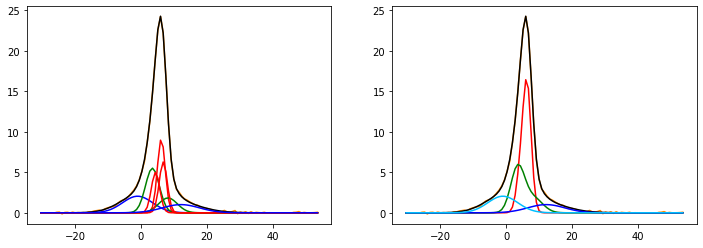

In [75]:
run_num = random.randint(0,150)
print("Run Number:",run_num)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(subvel, LVC_cube_base[:, 175, 36], color='darkorange')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
for i in range(7):
    if gaussian_params_abs[run_num][2::3][i]*dv < 2.3:
        color="red"
    if gaussian_params_abs[run_num][2::3][i]*dv > 2.3 and gaussian_params_abs[run_num][2::3][i]*dv < 5.4:
        color="green"
    if gaussian_params_abs[run_num][2::3][i]*dv > 5.4:
        color="blue"
    plt.plot(subvel, gaussians[run_num][i], color=color)
plt.subplot(1,2,2)
plt.plot(subvel, LVC_cube_base[:, 175, 36], color='darkorange')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
plt.plot(subvel, gaussians_CNM[run_num], color="red")
plt.plot(subvel, gaussians_LNM[run_num], color="green")
plt.plot(subvel, gaussians_WNMa[run_num], color="blue")
plt.plot(subvel, gaussians_WNMb[run_num], color="deepskyblue")

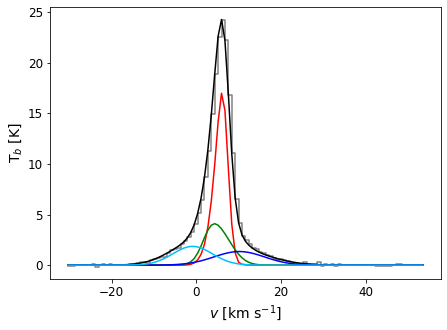

In [76]:
fig = plt.figure(figsize=(7, 5))
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=14)
plt.ylabel("T$_{b}$ [K]", fontsize=14)
plt.step(subvel, LVC_cube_base[:, 175, 36], color='grey')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
plt.plot(subvel, np.mean(gaussians_CNM, 0), color="red")
plt.plot(subvel, np.mean(gaussians_LNM, 0), color="green")
plt.plot(subvel, np.mean(gaussians_WNMa, 0), color="blue")
plt.plot(subvel, np.mean(gaussians_WNMb, 0), color="deepskyblue")
#fig.savefig("ROHSA_GHIGLS_DF_source_tmp1.png", bbox_inches='tight')

## Sort the Models (150 runs) into PPV cubes of each Phase

In [77]:
CNM_LNM_bound=2.3
LNM_WNM_bound=5.4

In [78]:
def phase_maps_comp_by_comp(CNM_LNM_bound, LNM_WNM_bound, subcube, n_gauss, position, dispersion, NHI_map):

    iddx = np.argsort(np.mean(position, axis=(1,2))) # Sorts the Gaussians starting from low velocity to high
    mean_position = [np.mean(position, (1,2))[idd] for idd in iddx]
    mean_dispersion = [np.mean(dispersion, (1,2))[idd] for idd in iddx]
    NHI_map_field = [NHI_map[idd] for idd in iddx]

    CNM_map = np.zeros((256,256));CNM_list = []
    LNM_map = np.zeros((256,256));LNM_list = []
    WNMa_map = np.zeros((256,256));WNMa_list = []
    WNMd_map = np.zeros((256,256));WNMd_list = []

    for i in range(n_gauss):
        if mean_dispersion[i] < CNM_LNM_bound:
            CNM_map = CNM_map + NHI_map_field[i]
            CNM_list.append(i)
        if mean_dispersion[i] >= CNM_LNM_bound and mean_dispersion[i] < LNM_WNM_bound:
            LNM_map = LNM_map + NHI_map_field[i]
            LNM_list.append(i)
        if mean_dispersion[i] >= LNM_WNM_bound:
            if mean_position[i] > 5.:
                WNMa_map = WNMa_map + NHI_map_field[i]
                WNMa_list.append(i)  
            if mean_position[i] <= 5.:
                WNMd_map = WNMd_map + NHI_map_field[i]
                WNMd_list.append(i)  
                
    return CNM_list, LNM_list, WNMa_list, WNMd_list, CNM_map, LNM_map, WNMa_map, WNMd_map

In [79]:
def phase_cubes_comp_by_comp(subcube, n_gauss, position, dispersion, amplitude_pix, position_pix,\
                             dispersion_pix, CNM_list, LNM_list, WNMa_list, WNMd_list):

    model_CNM = np.zeros(subcube.shape)
    model_LNM = np.zeros(subcube.shape)
    model_WNM = np.zeros(subcube.shape)

    model_CNM = core.return_result_cube(ampfield=np.array(ampfield)[CNM_list],\
                                        pixfield=np.array(pixfield)[CNM_list], \
                                        sigfield=np.array(sigfield/dv)[CNM_list])
    model_LNM = core.return_result_cube(ampfield=np.array(ampfield)[LNM_list],\
                                        pixfield=np.array(pixfield)[LNM_list], \
                                        sigfield=np.array(sigfield/dv)[LNM_list])
    model_WNMa = core.return_result_cube(ampfield=np.array(ampfield)[WNMa_list],\
                                         pixfield=np.array(pixfield)[WNMa_list], \
                                         sigfield=np.array(sigfield/dv)[WNMa_list])
    model_WNMd = core.return_result_cube(ampfield=np.array(ampfield)[WNMd_list],\
                                         pixfield=np.array(pixfield)[WNMd_list], \
                                         sigfield=np.array(sigfield/dv)[WNMd_list])

    return model_CNM, model_LNM, model_WNMa, model_WNMd

PPV Cubes for rnd boot cubes

In [80]:
CNM_list0,LNM_list0,WNMa_list0,WNMd_list0,CNM_bc_map0,LNM_bc_map0,WNMa_bc_map0,WNMd_bc_map0=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[0],n_gauss,position_multi_rnd_boot_cube[0],dispersion_multi_rnd_boot_cube[0],NHI_map_multi_rnd_boot_cube[0])
CNM_list1,LNM_list1,WNMa_list1,WNMd_list1,CNM_bc_map1,LNM_bc_map1,WNMa_bc_map1,WNMd_bc_map1=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[1],n_gauss,position_multi_rnd_boot_cube[1],dispersion_multi_rnd_boot_cube[1],NHI_map_multi_rnd_boot_cube[1])
CNM_list2,LNM_list2,WNMa_list2,WNMd_list2,CNM_bc_map2,LNM_bc_map2,WNMa_bc_map2,WNMd_bc_map2=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[2],n_gauss,position_multi_rnd_boot_cube[2],dispersion_multi_rnd_boot_cube[2],NHI_map_multi_rnd_boot_cube[2])
CNM_list3,LNM_list3,WNMa_list3,WNMd_list3,CNM_bc_map3,LNM_bc_map3,WNMa_bc_map3,WNMd_bc_map3=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[3],n_gauss,position_multi_rnd_boot_cube[3],dispersion_multi_rnd_boot_cube[3],NHI_map_multi_rnd_boot_cube[3])
CNM_list4,LNM_list4,WNMa_list4,WNMd_list4,CNM_bc_map4,LNM_bc_map4,WNMa_bc_map4,WNMd_bc_map4=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[4],n_gauss,position_multi_rnd_boot_cube[4],dispersion_multi_rnd_boot_cube[4],NHI_map_multi_rnd_boot_cube[4])
CNM_list5,LNM_list5,WNMa_list5,WNMd_list5,CNM_bc_map5,LNM_bc_map5,WNMa_bc_map5,WNMd_bc_map5=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[5],n_gauss,position_multi_rnd_boot_cube[5],dispersion_multi_rnd_boot_cube[5],NHI_map_multi_rnd_boot_cube[5])
CNM_list6,LNM_list6,WNMa_list6,WNMd_list6,CNM_bc_map6,LNM_bc_map6,WNMa_bc_map6,WNMd_bc_map6=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[6],n_gauss,position_multi_rnd_boot_cube[6],dispersion_multi_rnd_boot_cube[6],NHI_map_multi_rnd_boot_cube[6])
CNM_list7,LNM_list7,WNMa_list7,WNMd_list7,CNM_bc_map7,LNM_bc_map7,WNMa_bc_map7,WNMd_bc_map7=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[7],n_gauss,position_multi_rnd_boot_cube[7],dispersion_multi_rnd_boot_cube[7],NHI_map_multi_rnd_boot_cube[7])
CNM_list8,LNM_list8,WNMa_list8,WNMd_list8,CNM_bc_map8,LNM_bc_map8,WNMa_bc_map8,WNMd_bc_map8=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[8],n_gauss,position_multi_rnd_boot_cube[8],dispersion_multi_rnd_boot_cube[8],NHI_map_multi_rnd_boot_cube[8])
CNM_list9,LNM_list9,WNMa_list9,WNMd_list9,CNM_bc_map9,LNM_bc_map9,WNMa_bc_map9,WNMd_bc_map9=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[9],n_gauss,position_multi_rnd_boot_cube[9],dispersion_multi_rnd_boot_cube[9],NHI_map_multi_rnd_boot_cube[9])
CNM_list10,LNM_list10,WNMa_list10,WNMd_list10,CNM_bc_map10,LNM_bc_map10,WNMa_bc_map10,WNMd_bc_map10=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[10],n_gauss,position_multi_rnd_boot_cube[10],dispersion_multi_rnd_boot_cube[10],NHI_map_multi_rnd_boot_cube[10])
CNM_list11,LNM_list11,WNMa_list11,WNMd_list11,CNM_bc_map11,LNM_bc_map11,WNMa_bc_map11,WNMd_bc_map11=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[11],n_gauss,position_multi_rnd_boot_cube[11],dispersion_multi_rnd_boot_cube[11],NHI_map_multi_rnd_boot_cube[11])
CNM_list12,LNM_list12,WNMa_list12,WNMd_list12,CNM_bc_map12,LNM_bc_map12,WNMa_bc_map12,WNMd_bc_map12=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[12],n_gauss,position_multi_rnd_boot_cube[12],dispersion_multi_rnd_boot_cube[12],NHI_map_multi_rnd_boot_cube[12])
CNM_list13,LNM_list13,WNMa_list13,WNMd_list13,CNM_bc_map13,LNM_bc_map13,WNMa_bc_map13,WNMd_bc_map13=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[13],n_gauss,position_multi_rnd_boot_cube[13],dispersion_multi_rnd_boot_cube[13],NHI_map_multi_rnd_boot_cube[13])
CNM_list14,LNM_list14,WNMa_list14,WNMd_list14,CNM_bc_map14,LNM_bc_map14,WNMa_bc_map14,WNMd_bc_map14=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[14],n_gauss,position_multi_rnd_boot_cube[14],dispersion_multi_rnd_boot_cube[14],NHI_map_multi_rnd_boot_cube[14])
CNM_list15,LNM_list15,WNMa_list15,WNMd_list15,CNM_bc_map15,LNM_bc_map15,WNMa_bc_map15,WNMd_bc_map15=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[15],n_gauss,position_multi_rnd_boot_cube[15],dispersion_multi_rnd_boot_cube[15],NHI_map_multi_rnd_boot_cube[15])
CNM_list16,LNM_list16,WNMa_list16,WNMd_list16,CNM_bc_map16,LNM_bc_map16,WNMa_bc_map16,WNMd_bc_map16=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[16],n_gauss,position_multi_rnd_boot_cube[16],dispersion_multi_rnd_boot_cube[16],NHI_map_multi_rnd_boot_cube[16])
CNM_list17,LNM_list17,WNMa_list17,WNMd_list17,CNM_bc_map17,LNM_bc_map17,WNMa_bc_map17,WNMd_bc_map17=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[17],n_gauss,position_multi_rnd_boot_cube[17],dispersion_multi_rnd_boot_cube[17],NHI_map_multi_rnd_boot_cube[17])
CNM_list18,LNM_list18,WNMa_list18,WNMd_list18,CNM_bc_map18,LNM_bc_map18,WNMa_bc_map18,WNMd_bc_map18=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[18],n_gauss,position_multi_rnd_boot_cube[18],dispersion_multi_rnd_boot_cube[18],NHI_map_multi_rnd_boot_cube[18])
CNM_list19,LNM_list19,WNMa_list19,WNMd_list19,CNM_bc_map19,LNM_bc_map19,WNMa_bc_map19,WNMd_bc_map19=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[19],n_gauss,position_multi_rnd_boot_cube[19],dispersion_multi_rnd_boot_cube[19],NHI_map_multi_rnd_boot_cube[19])
CNM_list20,LNM_list20,WNMa_list20,WNMd_list20,CNM_bc_map20,LNM_bc_map20,WNMa_bc_map20,WNMd_bc_map20=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[20],n_gauss,position_multi_rnd_boot_cube[20],dispersion_multi_rnd_boot_cube[20],NHI_map_multi_rnd_boot_cube[20])
CNM_list21,LNM_list21,WNMa_list21,WNMd_list21,CNM_bc_map21,LNM_bc_map21,WNMa_bc_map21,WNMd_bc_map21=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[21],n_gauss,position_multi_rnd_boot_cube[21],dispersion_multi_rnd_boot_cube[21],NHI_map_multi_rnd_boot_cube[21])
CNM_list22,LNM_list22,WNMa_list22,WNMd_list22,CNM_bc_map22,LNM_bc_map22,WNMa_bc_map22,WNMd_bc_map22=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[22],n_gauss,position_multi_rnd_boot_cube[22],dispersion_multi_rnd_boot_cube[22],NHI_map_multi_rnd_boot_cube[22])
CNM_list23,LNM_list23,WNMa_list23,WNMd_list23,CNM_bc_map23,LNM_bc_map23,WNMa_bc_map23,WNMd_bc_map23=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[23],n_gauss,position_multi_rnd_boot_cube[23],dispersion_multi_rnd_boot_cube[23],NHI_map_multi_rnd_boot_cube[23])
CNM_list24,LNM_list24,WNMa_list24,WNMd_list24,CNM_bc_map24,LNM_bc_map24,WNMa_bc_map24,WNMd_bc_map24=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[24],n_gauss,position_multi_rnd_boot_cube[24],dispersion_multi_rnd_boot_cube[24],NHI_map_multi_rnd_boot_cube[24])
CNM_list25,LNM_list25,WNMa_list25,WNMd_list25,CNM_bc_map25,LNM_bc_map25,WNMa_bc_map25,WNMd_bc_map25=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[25],n_gauss,position_multi_rnd_boot_cube[25],dispersion_multi_rnd_boot_cube[25],NHI_map_multi_rnd_boot_cube[25])
CNM_list26,LNM_list26,WNMa_list26,WNMd_list26,CNM_bc_map26,LNM_bc_map26,WNMa_bc_map26,WNMd_bc_map26=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[26],n_gauss,position_multi_rnd_boot_cube[26],dispersion_multi_rnd_boot_cube[26],NHI_map_multi_rnd_boot_cube[26])
CNM_list27,LNM_list27,WNMa_list27,WNMd_list27,CNM_bc_map27,LNM_bc_map27,WNMa_bc_map27,WNMd_bc_map27=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[27],n_gauss,position_multi_rnd_boot_cube[27],dispersion_multi_rnd_boot_cube[27],NHI_map_multi_rnd_boot_cube[27])
CNM_list28,LNM_list28,WNMa_list28,WNMd_list28,CNM_bc_map28,LNM_bc_map28,WNMa_bc_map28,WNMd_bc_map28=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[28],n_gauss,position_multi_rnd_boot_cube[28],dispersion_multi_rnd_boot_cube[28],NHI_map_multi_rnd_boot_cube[28])
CNM_list29,LNM_list29,WNMa_list29,WNMd_list29,CNM_bc_map29,LNM_bc_map29,WNMa_bc_map29,WNMd_bc_map29=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[29],n_gauss,position_multi_rnd_boot_cube[29],dispersion_multi_rnd_boot_cube[29],NHI_map_multi_rnd_boot_cube[29])
CNM_list30,LNM_list30,WNMa_list30,WNMd_list30,CNM_bc_map30,LNM_bc_map30,WNMa_bc_map30,WNMd_bc_map30=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[30],n_gauss,position_multi_rnd_boot_cube[30],dispersion_multi_rnd_boot_cube[30],NHI_map_multi_rnd_boot_cube[30])
CNM_list31,LNM_list31,WNMa_list31,WNMd_list31,CNM_bc_map31,LNM_bc_map31,WNMa_bc_map31,WNMd_bc_map31=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[31],n_gauss,position_multi_rnd_boot_cube[31],dispersion_multi_rnd_boot_cube[31],NHI_map_multi_rnd_boot_cube[31])
CNM_list32,LNM_list32,WNMa_list32,WNMd_list32,CNM_bc_map32,LNM_bc_map32,WNMa_bc_map32,WNMd_bc_map32=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[32],n_gauss,position_multi_rnd_boot_cube[32],dispersion_multi_rnd_boot_cube[32],NHI_map_multi_rnd_boot_cube[32])
CNM_list33,LNM_list33,WNMa_list33,WNMd_list33,CNM_bc_map33,LNM_bc_map33,WNMa_bc_map33,WNMd_bc_map33=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[33],n_gauss,position_multi_rnd_boot_cube[33],dispersion_multi_rnd_boot_cube[33],NHI_map_multi_rnd_boot_cube[33])
CNM_list34,LNM_list34,WNMa_list34,WNMd_list34,CNM_bc_map34,LNM_bc_map34,WNMa_bc_map34,WNMd_bc_map34=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[34],n_gauss,position_multi_rnd_boot_cube[34],dispersion_multi_rnd_boot_cube[34],NHI_map_multi_rnd_boot_cube[34])
CNM_list35,LNM_list35,WNMa_list35,WNMd_list35,CNM_bc_map35,LNM_bc_map35,WNMa_bc_map35,WNMd_bc_map35=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[35],n_gauss,position_multi_rnd_boot_cube[35],dispersion_multi_rnd_boot_cube[35],NHI_map_multi_rnd_boot_cube[35])
CNM_list36,LNM_list36,WNMa_list36,WNMd_list36,CNM_bc_map36,LNM_bc_map36,WNMa_bc_map36,WNMd_bc_map36=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[36],n_gauss,position_multi_rnd_boot_cube[36],dispersion_multi_rnd_boot_cube[36],NHI_map_multi_rnd_boot_cube[36])
CNM_list37,LNM_list37,WNMa_list37,WNMd_list37,CNM_bc_map37,LNM_bc_map37,WNMa_bc_map37,WNMd_bc_map37=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[37],n_gauss,position_multi_rnd_boot_cube[37],dispersion_multi_rnd_boot_cube[37],NHI_map_multi_rnd_boot_cube[37])
CNM_list38,LNM_list38,WNMa_list38,WNMd_list38,CNM_bc_map38,LNM_bc_map38,WNMa_bc_map38,WNMd_bc_map38=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[38],n_gauss,position_multi_rnd_boot_cube[38],dispersion_multi_rnd_boot_cube[38],NHI_map_multi_rnd_boot_cube[38])
CNM_list39,LNM_list39,WNMa_list39,WNMd_list39,CNM_bc_map39,LNM_bc_map39,WNMa_bc_map39,WNMd_bc_map39=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[39],n_gauss,position_multi_rnd_boot_cube[39],dispersion_multi_rnd_boot_cube[39],NHI_map_multi_rnd_boot_cube[39])
CNM_list40,LNM_list40,WNMa_list40,WNMd_list40,CNM_bc_map40,LNM_bc_map40,WNMa_bc_map40,WNMd_bc_map40=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[40],n_gauss,position_multi_rnd_boot_cube[40],dispersion_multi_rnd_boot_cube[40],NHI_map_multi_rnd_boot_cube[40])
CNM_list41,LNM_list41,WNMa_list41,WNMd_list41,CNM_bc_map41,LNM_bc_map41,WNMa_bc_map41,WNMd_bc_map41=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[41],n_gauss,position_multi_rnd_boot_cube[41],dispersion_multi_rnd_boot_cube[41],NHI_map_multi_rnd_boot_cube[41])
CNM_list42,LNM_list42,WNMa_list42,WNMd_list42,CNM_bc_map42,LNM_bc_map42,WNMa_bc_map42,WNMd_bc_map42=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[42],n_gauss,position_multi_rnd_boot_cube[42],dispersion_multi_rnd_boot_cube[42],NHI_map_multi_rnd_boot_cube[42])
CNM_list43,LNM_list43,WNMa_list43,WNMd_list43,CNM_bc_map43,LNM_bc_map43,WNMa_bc_map43,WNMd_bc_map43=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[43],n_gauss,position_multi_rnd_boot_cube[43],dispersion_multi_rnd_boot_cube[43],NHI_map_multi_rnd_boot_cube[43])
CNM_list44,LNM_list44,WNMa_list44,WNMd_list44,CNM_bc_map44,LNM_bc_map44,WNMa_bc_map44,WNMd_bc_map44=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[44],n_gauss,position_multi_rnd_boot_cube[44],dispersion_multi_rnd_boot_cube[44],NHI_map_multi_rnd_boot_cube[44])
CNM_list45,LNM_list45,WNMa_list45,WNMd_list45,CNM_bc_map45,LNM_bc_map45,WNMa_bc_map45,WNMd_bc_map45=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[45],n_gauss,position_multi_rnd_boot_cube[45],dispersion_multi_rnd_boot_cube[45],NHI_map_multi_rnd_boot_cube[45])
CNM_list46,LNM_list46,WNMa_list46,WNMd_list46,CNM_bc_map46,LNM_bc_map46,WNMa_bc_map46,WNMd_bc_map46=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[46],n_gauss,position_multi_rnd_boot_cube[46],dispersion_multi_rnd_boot_cube[46],NHI_map_multi_rnd_boot_cube[46])
CNM_list47,LNM_list47,WNMa_list47,WNMd_list47,CNM_bc_map47,LNM_bc_map47,WNMa_bc_map47,WNMd_bc_map47=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[47],n_gauss,position_multi_rnd_boot_cube[47],dispersion_multi_rnd_boot_cube[47],NHI_map_multi_rnd_boot_cube[47])
CNM_list48,LNM_list48,WNMa_list48,WNMd_list48,CNM_bc_map48,LNM_bc_map48,WNMa_bc_map48,WNMd_bc_map48=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[48],n_gauss,position_multi_rnd_boot_cube[48],dispersion_multi_rnd_boot_cube[48],NHI_map_multi_rnd_boot_cube[48])
CNM_list49,LNM_list49,WNMa_list49,WNMd_list49,CNM_bc_map49,LNM_bc_map49,WNMa_bc_map49,WNMd_bc_map49=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube[49],n_gauss,position_multi_rnd_boot_cube[49],dispersion_multi_rnd_boot_cube[49],NHI_map_multi_rnd_boot_cube[49])

In [81]:
model_CNM_bc_0, model_LNM_bc_0, model_WNMa_bc_0, model_WNMd_bc_0 = phase_cubes_comp_by_comp(LVC_cube[0], n_gauss, position_multi_rnd_boot_cube[0], dispersion_multi_rnd_boot_cube[0], amplitude_pix_multi_rnd_boot_cube[0], position_pix_multi_rnd_boot_cube[0], dispersion_pix_multi_rnd_boot_cube[0], CNM_list0, LNM_list0, WNMa_list0, WNMd_list0)
model_CNM_bc_1, model_LNM_bc_1, model_WNMa_bc_1, model_WNMd_bc_1 = phase_cubes_comp_by_comp(LVC_cube[1], n_gauss, position_multi_rnd_boot_cube[1], dispersion_multi_rnd_boot_cube[1], amplitude_pix_multi_rnd_boot_cube[1], position_pix_multi_rnd_boot_cube[1], dispersion_pix_multi_rnd_boot_cube[1], CNM_list1, LNM_list1, WNMa_list1, WNMd_list1)
model_CNM_bc_2, model_LNM_bc_2, model_WNMa_bc_2, model_WNMd_bc_2 = phase_cubes_comp_by_comp(LVC_cube[2], n_gauss, position_multi_rnd_boot_cube[2], dispersion_multi_rnd_boot_cube[2], amplitude_pix_multi_rnd_boot_cube[2], position_pix_multi_rnd_boot_cube[2], dispersion_pix_multi_rnd_boot_cube[2], CNM_list2, LNM_list2, WNMa_list2, WNMd_list2)
model_CNM_bc_3, model_LNM_bc_3, model_WNMa_bc_3, model_WNMd_bc_3 = phase_cubes_comp_by_comp(LVC_cube[3], n_gauss, position_multi_rnd_boot_cube[3], dispersion_multi_rnd_boot_cube[3], amplitude_pix_multi_rnd_boot_cube[3], position_pix_multi_rnd_boot_cube[3], dispersion_pix_multi_rnd_boot_cube[3], CNM_list3, LNM_list3, WNMa_list3, WNMd_list3)
model_CNM_bc_4, model_LNM_bc_4, model_WNMa_bc_4, model_WNMd_bc_4 = phase_cubes_comp_by_comp(LVC_cube[4], n_gauss, position_multi_rnd_boot_cube[4], dispersion_multi_rnd_boot_cube[4], amplitude_pix_multi_rnd_boot_cube[4], position_pix_multi_rnd_boot_cube[4], dispersion_pix_multi_rnd_boot_cube[4], CNM_list4, LNM_list4, WNMa_list4, WNMd_list4)
model_CNM_bc_5, model_LNM_bc_5, model_WNMa_bc_5, model_WNMd_bc_5 = phase_cubes_comp_by_comp(LVC_cube[5], n_gauss, position_multi_rnd_boot_cube[5], dispersion_multi_rnd_boot_cube[5], amplitude_pix_multi_rnd_boot_cube[5], position_pix_multi_rnd_boot_cube[5], dispersion_pix_multi_rnd_boot_cube[5], CNM_list5, LNM_list5, WNMa_list5, WNMd_list5)
model_CNM_bc_6, model_LNM_bc_6, model_WNMa_bc_6, model_WNMd_bc_6 = phase_cubes_comp_by_comp(LVC_cube[6], n_gauss, position_multi_rnd_boot_cube[6], dispersion_multi_rnd_boot_cube[6], amplitude_pix_multi_rnd_boot_cube[6], position_pix_multi_rnd_boot_cube[6], dispersion_pix_multi_rnd_boot_cube[6], CNM_list6, LNM_list6, WNMa_list6, WNMd_list6)
model_CNM_bc_7, model_LNM_bc_7, model_WNMa_bc_7, model_WNMd_bc_7 = phase_cubes_comp_by_comp(LVC_cube[7], n_gauss, position_multi_rnd_boot_cube[7], dispersion_multi_rnd_boot_cube[7], amplitude_pix_multi_rnd_boot_cube[7], position_pix_multi_rnd_boot_cube[7], dispersion_pix_multi_rnd_boot_cube[7], CNM_list7, LNM_list7, WNMa_list7, WNMd_list7)
model_CNM_bc_8, model_LNM_bc_8, model_WNMa_bc_8, model_WNMd_bc_8 = phase_cubes_comp_by_comp(LVC_cube[8], n_gauss, position_multi_rnd_boot_cube[8], dispersion_multi_rnd_boot_cube[8], amplitude_pix_multi_rnd_boot_cube[8], position_pix_multi_rnd_boot_cube[8], dispersion_pix_multi_rnd_boot_cube[8], CNM_list8, LNM_list8, WNMa_list8, WNMd_list8)
model_CNM_bc_9, model_LNM_bc_9, model_WNMa_bc_9, model_WNMd_bc_9 = phase_cubes_comp_by_comp(LVC_cube[9], n_gauss, position_multi_rnd_boot_cube[9], dispersion_multi_rnd_boot_cube[9], amplitude_pix_multi_rnd_boot_cube[9], position_pix_multi_rnd_boot_cube[9], dispersion_pix_multi_rnd_boot_cube[9], CNM_list9, LNM_list9, WNMa_list9, WNMd_list9)
model_CNM_bc_10, model_LNM_bc_10, model_WNMa_bc_10, model_WNMd_bc_10 = phase_cubes_comp_by_comp(LVC_cube[10], n_gauss, position_multi_rnd_boot_cube[10], dispersion_multi_rnd_boot_cube[10], amplitude_pix_multi_rnd_boot_cube[10], position_pix_multi_rnd_boot_cube[10], dispersion_pix_multi_rnd_boot_cube[10], CNM_list10, LNM_list10, WNMa_list10, WNMd_list10)
model_CNM_bc_11, model_LNM_bc_11, model_WNMa_bc_11, model_WNMd_bc_11 = phase_cubes_comp_by_comp(LVC_cube[11], n_gauss, position_multi_rnd_boot_cube[11], dispersion_multi_rnd_boot_cube[11], amplitude_pix_multi_rnd_boot_cube[11], position_pix_multi_rnd_boot_cube[11], dispersion_pix_multi_rnd_boot_cube[11], CNM_list11, LNM_list11, WNMa_list11, WNMd_list11)
model_CNM_bc_12, model_LNM_bc_12, model_WNMa_bc_12, model_WNMd_bc_12 = phase_cubes_comp_by_comp(LVC_cube[12], n_gauss, position_multi_rnd_boot_cube[12], dispersion_multi_rnd_boot_cube[12], amplitude_pix_multi_rnd_boot_cube[12], position_pix_multi_rnd_boot_cube[12], dispersion_pix_multi_rnd_boot_cube[12], CNM_list12, LNM_list12, WNMa_list12, WNMd_list12)
model_CNM_bc_13, model_LNM_bc_13, model_WNMa_bc_13, model_WNMd_bc_13 = phase_cubes_comp_by_comp(LVC_cube[13], n_gauss, position_multi_rnd_boot_cube[13], dispersion_multi_rnd_boot_cube[13], amplitude_pix_multi_rnd_boot_cube[13], position_pix_multi_rnd_boot_cube[13], dispersion_pix_multi_rnd_boot_cube[13], CNM_list13, LNM_list13, WNMa_list13, WNMd_list13)
model_CNM_bc_14, model_LNM_bc_14, model_WNMa_bc_14, model_WNMd_bc_14 = phase_cubes_comp_by_comp(LVC_cube[14], n_gauss, position_multi_rnd_boot_cube[14], dispersion_multi_rnd_boot_cube[14], amplitude_pix_multi_rnd_boot_cube[14], position_pix_multi_rnd_boot_cube[14], dispersion_pix_multi_rnd_boot_cube[14], CNM_list14, LNM_list14, WNMa_list14, WNMd_list14)
model_CNM_bc_15, model_LNM_bc_15, model_WNMa_bc_15, model_WNMd_bc_15 = phase_cubes_comp_by_comp(LVC_cube[15], n_gauss, position_multi_rnd_boot_cube[15], dispersion_multi_rnd_boot_cube[15], amplitude_pix_multi_rnd_boot_cube[15], position_pix_multi_rnd_boot_cube[15], dispersion_pix_multi_rnd_boot_cube[15], CNM_list15, LNM_list15, WNMa_list15, WNMd_list15)
model_CNM_bc_16, model_LNM_bc_16, model_WNMa_bc_16, model_WNMd_bc_16 = phase_cubes_comp_by_comp(LVC_cube[16], n_gauss, position_multi_rnd_boot_cube[16], dispersion_multi_rnd_boot_cube[16], amplitude_pix_multi_rnd_boot_cube[16], position_pix_multi_rnd_boot_cube[16], dispersion_pix_multi_rnd_boot_cube[16], CNM_list16, LNM_list16, WNMa_list16, WNMd_list16)
model_CNM_bc_17, model_LNM_bc_17, model_WNMa_bc_17, model_WNMd_bc_17 = phase_cubes_comp_by_comp(LVC_cube[17], n_gauss, position_multi_rnd_boot_cube[17], dispersion_multi_rnd_boot_cube[17], amplitude_pix_multi_rnd_boot_cube[17], position_pix_multi_rnd_boot_cube[17], dispersion_pix_multi_rnd_boot_cube[17], CNM_list17, LNM_list17, WNMa_list17, WNMd_list17)
model_CNM_bc_18, model_LNM_bc_18, model_WNMa_bc_18, model_WNMd_bc_18 = phase_cubes_comp_by_comp(LVC_cube[18], n_gauss, position_multi_rnd_boot_cube[18], dispersion_multi_rnd_boot_cube[18], amplitude_pix_multi_rnd_boot_cube[18], position_pix_multi_rnd_boot_cube[18], dispersion_pix_multi_rnd_boot_cube[18], CNM_list18, LNM_list18, WNMa_list18, WNMd_list18)
model_CNM_bc_19, model_LNM_bc_19, model_WNMa_bc_19, model_WNMd_bc_19 = phase_cubes_comp_by_comp(LVC_cube[19], n_gauss, position_multi_rnd_boot_cube[19], dispersion_multi_rnd_boot_cube[19], amplitude_pix_multi_rnd_boot_cube[19], position_pix_multi_rnd_boot_cube[19], dispersion_pix_multi_rnd_boot_cube[19], CNM_list19, LNM_list19, WNMa_list19, WNMd_list19)
model_CNM_bc_20, model_LNM_bc_20, model_WNMa_bc_20, model_WNMd_bc_20 = phase_cubes_comp_by_comp(LVC_cube[20], n_gauss, position_multi_rnd_boot_cube[20], dispersion_multi_rnd_boot_cube[20], amplitude_pix_multi_rnd_boot_cube[20], position_pix_multi_rnd_boot_cube[20], dispersion_pix_multi_rnd_boot_cube[20], CNM_list20, LNM_list20, WNMa_list20, WNMd_list20)
model_CNM_bc_21, model_LNM_bc_21, model_WNMa_bc_21, model_WNMd_bc_21 = phase_cubes_comp_by_comp(LVC_cube[21], n_gauss, position_multi_rnd_boot_cube[21], dispersion_multi_rnd_boot_cube[21], amplitude_pix_multi_rnd_boot_cube[21], position_pix_multi_rnd_boot_cube[21], dispersion_pix_multi_rnd_boot_cube[21], CNM_list21, LNM_list21, WNMa_list21, WNMd_list21)
model_CNM_bc_22, model_LNM_bc_22, model_WNMa_bc_22, model_WNMd_bc_22 = phase_cubes_comp_by_comp(LVC_cube[22], n_gauss, position_multi_rnd_boot_cube[22], dispersion_multi_rnd_boot_cube[22], amplitude_pix_multi_rnd_boot_cube[22], position_pix_multi_rnd_boot_cube[22], dispersion_pix_multi_rnd_boot_cube[22], CNM_list22, LNM_list22, WNMa_list22, WNMd_list22)
model_CNM_bc_23, model_LNM_bc_23, model_WNMa_bc_23, model_WNMd_bc_23 = phase_cubes_comp_by_comp(LVC_cube[23], n_gauss, position_multi_rnd_boot_cube[23], dispersion_multi_rnd_boot_cube[23], amplitude_pix_multi_rnd_boot_cube[23], position_pix_multi_rnd_boot_cube[23], dispersion_pix_multi_rnd_boot_cube[23], CNM_list23, LNM_list23, WNMa_list23, WNMd_list23)
model_CNM_bc_24, model_LNM_bc_24, model_WNMa_bc_24, model_WNMd_bc_24 = phase_cubes_comp_by_comp(LVC_cube[24], n_gauss, position_multi_rnd_boot_cube[24], dispersion_multi_rnd_boot_cube[24], amplitude_pix_multi_rnd_boot_cube[24], position_pix_multi_rnd_boot_cube[24], dispersion_pix_multi_rnd_boot_cube[24], CNM_list24, LNM_list24, WNMa_list24, WNMd_list24)
model_CNM_bc_25, model_LNM_bc_25, model_WNMa_bc_25, model_WNMd_bc_25 = phase_cubes_comp_by_comp(LVC_cube[25], n_gauss, position_multi_rnd_boot_cube[25], dispersion_multi_rnd_boot_cube[25], amplitude_pix_multi_rnd_boot_cube[25], position_pix_multi_rnd_boot_cube[25], dispersion_pix_multi_rnd_boot_cube[25], CNM_list25, LNM_list25, WNMa_list25, WNMd_list25)
model_CNM_bc_26, model_LNM_bc_26, model_WNMa_bc_26, model_WNMd_bc_26 = phase_cubes_comp_by_comp(LVC_cube[26], n_gauss, position_multi_rnd_boot_cube[26], dispersion_multi_rnd_boot_cube[26], amplitude_pix_multi_rnd_boot_cube[26], position_pix_multi_rnd_boot_cube[26], dispersion_pix_multi_rnd_boot_cube[26], CNM_list26, LNM_list26, WNMa_list26, WNMd_list26)
model_CNM_bc_27, model_LNM_bc_27, model_WNMa_bc_27, model_WNMd_bc_27 = phase_cubes_comp_by_comp(LVC_cube[27], n_gauss, position_multi_rnd_boot_cube[27], dispersion_multi_rnd_boot_cube[27], amplitude_pix_multi_rnd_boot_cube[27], position_pix_multi_rnd_boot_cube[27], dispersion_pix_multi_rnd_boot_cube[27], CNM_list27, LNM_list27, WNMa_list27, WNMd_list27)
model_CNM_bc_28, model_LNM_bc_28, model_WNMa_bc_28, model_WNMd_bc_28 = phase_cubes_comp_by_comp(LVC_cube[28], n_gauss, position_multi_rnd_boot_cube[28], dispersion_multi_rnd_boot_cube[28], amplitude_pix_multi_rnd_boot_cube[28], position_pix_multi_rnd_boot_cube[28], dispersion_pix_multi_rnd_boot_cube[28], CNM_list28, LNM_list28, WNMa_list28, WNMd_list28)
model_CNM_bc_29, model_LNM_bc_29, model_WNMa_bc_29, model_WNMd_bc_29 = phase_cubes_comp_by_comp(LVC_cube[29], n_gauss, position_multi_rnd_boot_cube[29], dispersion_multi_rnd_boot_cube[29], amplitude_pix_multi_rnd_boot_cube[29], position_pix_multi_rnd_boot_cube[29], dispersion_pix_multi_rnd_boot_cube[29], CNM_list29, LNM_list29, WNMa_list29, WNMd_list29)
model_CNM_bc_30, model_LNM_bc_30, model_WNMa_bc_30, model_WNMd_bc_30 = phase_cubes_comp_by_comp(LVC_cube[30], n_gauss, position_multi_rnd_boot_cube[30], dispersion_multi_rnd_boot_cube[30], amplitude_pix_multi_rnd_boot_cube[30], position_pix_multi_rnd_boot_cube[30], dispersion_pix_multi_rnd_boot_cube[30], CNM_list30, LNM_list30, WNMa_list30, WNMd_list30)
model_CNM_bc_31, model_LNM_bc_31, model_WNMa_bc_31, model_WNMd_bc_31 = phase_cubes_comp_by_comp(LVC_cube[31], n_gauss, position_multi_rnd_boot_cube[31], dispersion_multi_rnd_boot_cube[31], amplitude_pix_multi_rnd_boot_cube[31], position_pix_multi_rnd_boot_cube[31], dispersion_pix_multi_rnd_boot_cube[31], CNM_list31, LNM_list31, WNMa_list31, WNMd_list31)
model_CNM_bc_32, model_LNM_bc_32, model_WNMa_bc_32, model_WNMd_bc_32 = phase_cubes_comp_by_comp(LVC_cube[32], n_gauss, position_multi_rnd_boot_cube[32], dispersion_multi_rnd_boot_cube[32], amplitude_pix_multi_rnd_boot_cube[32], position_pix_multi_rnd_boot_cube[32], dispersion_pix_multi_rnd_boot_cube[32], CNM_list32, LNM_list32, WNMa_list32, WNMd_list32)
model_CNM_bc_33, model_LNM_bc_33, model_WNMa_bc_33, model_WNMd_bc_33 = phase_cubes_comp_by_comp(LVC_cube[33], n_gauss, position_multi_rnd_boot_cube[33], dispersion_multi_rnd_boot_cube[33], amplitude_pix_multi_rnd_boot_cube[33], position_pix_multi_rnd_boot_cube[33], dispersion_pix_multi_rnd_boot_cube[33], CNM_list33, LNM_list33, WNMa_list33, WNMd_list33)
model_CNM_bc_34, model_LNM_bc_34, model_WNMa_bc_34, model_WNMd_bc_34 = phase_cubes_comp_by_comp(LVC_cube[34], n_gauss, position_multi_rnd_boot_cube[34], dispersion_multi_rnd_boot_cube[34], amplitude_pix_multi_rnd_boot_cube[34], position_pix_multi_rnd_boot_cube[34], dispersion_pix_multi_rnd_boot_cube[34], CNM_list34, LNM_list34, WNMa_list34, WNMd_list34)
model_CNM_bc_35, model_LNM_bc_35, model_WNMa_bc_35, model_WNMd_bc_35 = phase_cubes_comp_by_comp(LVC_cube[35], n_gauss, position_multi_rnd_boot_cube[35], dispersion_multi_rnd_boot_cube[35], amplitude_pix_multi_rnd_boot_cube[35], position_pix_multi_rnd_boot_cube[35], dispersion_pix_multi_rnd_boot_cube[35], CNM_list35, LNM_list35, WNMa_list35, WNMd_list35)
model_CNM_bc_36, model_LNM_bc_36, model_WNMa_bc_36, model_WNMd_bc_36 = phase_cubes_comp_by_comp(LVC_cube[36], n_gauss, position_multi_rnd_boot_cube[36], dispersion_multi_rnd_boot_cube[36], amplitude_pix_multi_rnd_boot_cube[36], position_pix_multi_rnd_boot_cube[36], dispersion_pix_multi_rnd_boot_cube[36], CNM_list36, LNM_list36, WNMa_list36, WNMd_list36)
model_CNM_bc_37, model_LNM_bc_37, model_WNMa_bc_37, model_WNMd_bc_37 = phase_cubes_comp_by_comp(LVC_cube[37], n_gauss, position_multi_rnd_boot_cube[37], dispersion_multi_rnd_boot_cube[37], amplitude_pix_multi_rnd_boot_cube[37], position_pix_multi_rnd_boot_cube[37], dispersion_pix_multi_rnd_boot_cube[37], CNM_list37, LNM_list37, WNMa_list37, WNMd_list37)
model_CNM_bc_38, model_LNM_bc_38, model_WNMa_bc_38, model_WNMd_bc_38 = phase_cubes_comp_by_comp(LVC_cube[38], n_gauss, position_multi_rnd_boot_cube[38], dispersion_multi_rnd_boot_cube[38], amplitude_pix_multi_rnd_boot_cube[38], position_pix_multi_rnd_boot_cube[38], dispersion_pix_multi_rnd_boot_cube[38], CNM_list38, LNM_list38, WNMa_list38, WNMd_list38)
model_CNM_bc_39, model_LNM_bc_39, model_WNMa_bc_39, model_WNMd_bc_39 = phase_cubes_comp_by_comp(LVC_cube[39], n_gauss, position_multi_rnd_boot_cube[39], dispersion_multi_rnd_boot_cube[39], amplitude_pix_multi_rnd_boot_cube[39], position_pix_multi_rnd_boot_cube[39], dispersion_pix_multi_rnd_boot_cube[39], CNM_list39, LNM_list39, WNMa_list39, WNMd_list39)
model_CNM_bc_40, model_LNM_bc_40, model_WNMa_bc_40, model_WNMd_bc_40 = phase_cubes_comp_by_comp(LVC_cube[40], n_gauss, position_multi_rnd_boot_cube[40], dispersion_multi_rnd_boot_cube[40], amplitude_pix_multi_rnd_boot_cube[40], position_pix_multi_rnd_boot_cube[40], dispersion_pix_multi_rnd_boot_cube[40], CNM_list40, LNM_list40, WNMa_list40, WNMd_list40)
model_CNM_bc_41, model_LNM_bc_41, model_WNMa_bc_41, model_WNMd_bc_41 = phase_cubes_comp_by_comp(LVC_cube[41], n_gauss, position_multi_rnd_boot_cube[41], dispersion_multi_rnd_boot_cube[41], amplitude_pix_multi_rnd_boot_cube[41], position_pix_multi_rnd_boot_cube[41], dispersion_pix_multi_rnd_boot_cube[41], CNM_list41, LNM_list41, WNMa_list41, WNMd_list41)
model_CNM_bc_42, model_LNM_bc_42, model_WNMa_bc_42, model_WNMd_bc_42 = phase_cubes_comp_by_comp(LVC_cube[42], n_gauss, position_multi_rnd_boot_cube[42], dispersion_multi_rnd_boot_cube[42], amplitude_pix_multi_rnd_boot_cube[42], position_pix_multi_rnd_boot_cube[42], dispersion_pix_multi_rnd_boot_cube[42], CNM_list42, LNM_list42, WNMa_list42, WNMd_list42)
model_CNM_bc_43, model_LNM_bc_43, model_WNMa_bc_43, model_WNMd_bc_43 = phase_cubes_comp_by_comp(LVC_cube[43], n_gauss, position_multi_rnd_boot_cube[43], dispersion_multi_rnd_boot_cube[43], amplitude_pix_multi_rnd_boot_cube[43], position_pix_multi_rnd_boot_cube[43], dispersion_pix_multi_rnd_boot_cube[43], CNM_list43, LNM_list43, WNMa_list43, WNMd_list43)
model_CNM_bc_44, model_LNM_bc_44, model_WNMa_bc_44, model_WNMd_bc_44 = phase_cubes_comp_by_comp(LVC_cube[44], n_gauss, position_multi_rnd_boot_cube[44], dispersion_multi_rnd_boot_cube[44], amplitude_pix_multi_rnd_boot_cube[44], position_pix_multi_rnd_boot_cube[44], dispersion_pix_multi_rnd_boot_cube[44], CNM_list44, LNM_list44, WNMa_list44, WNMd_list44)
model_CNM_bc_45, model_LNM_bc_45, model_WNMa_bc_45, model_WNMd_bc_45 = phase_cubes_comp_by_comp(LVC_cube[45], n_gauss, position_multi_rnd_boot_cube[45], dispersion_multi_rnd_boot_cube[45], amplitude_pix_multi_rnd_boot_cube[45], position_pix_multi_rnd_boot_cube[45], dispersion_pix_multi_rnd_boot_cube[45], CNM_list45, LNM_list45, WNMa_list45, WNMd_list45)
model_CNM_bc_46, model_LNM_bc_46, model_WNMa_bc_46, model_WNMd_bc_46 = phase_cubes_comp_by_comp(LVC_cube[46], n_gauss, position_multi_rnd_boot_cube[46], dispersion_multi_rnd_boot_cube[46], amplitude_pix_multi_rnd_boot_cube[46], position_pix_multi_rnd_boot_cube[46], dispersion_pix_multi_rnd_boot_cube[46], CNM_list46, LNM_list46, WNMa_list46, WNMd_list46)
model_CNM_bc_47, model_LNM_bc_47, model_WNMa_bc_47, model_WNMd_bc_47 = phase_cubes_comp_by_comp(LVC_cube[47], n_gauss, position_multi_rnd_boot_cube[47], dispersion_multi_rnd_boot_cube[47], amplitude_pix_multi_rnd_boot_cube[47], position_pix_multi_rnd_boot_cube[47], dispersion_pix_multi_rnd_boot_cube[47], CNM_list47, LNM_list47, WNMa_list47, WNMd_list47)
model_CNM_bc_48, model_LNM_bc_48, model_WNMa_bc_48, model_WNMd_bc_48 = phase_cubes_comp_by_comp(LVC_cube[48], n_gauss, position_multi_rnd_boot_cube[48], dispersion_multi_rnd_boot_cube[48], amplitude_pix_multi_rnd_boot_cube[48], position_pix_multi_rnd_boot_cube[48], dispersion_pix_multi_rnd_boot_cube[48], CNM_list48, LNM_list48, WNMa_list48, WNMd_list48)
model_CNM_bc_49, model_LNM_bc_49, model_WNMa_bc_49, model_WNMd_bc_49 = phase_cubes_comp_by_comp(LVC_cube[49], n_gauss, position_multi_rnd_boot_cube[49], dispersion_multi_rnd_boot_cube[49], amplitude_pix_multi_rnd_boot_cube[49], position_pix_multi_rnd_boot_cube[49], dispersion_pix_multi_rnd_boot_cube[49], CNM_list49, LNM_list49, WNMa_list49, WNMd_list49)

In [82]:
tot_model_bc_0 = model_CNM_bc_0+ model_LNM_bc_0+ model_WNMa_bc_0+ model_WNMd_bc_0
tot_model_bc_1 = model_CNM_bc_1+ model_LNM_bc_1+ model_WNMa_bc_1+ model_WNMd_bc_1
tot_model_bc_2 = model_CNM_bc_2+ model_LNM_bc_2+ model_WNMa_bc_2+ model_WNMd_bc_2
tot_model_bc_3 = model_CNM_bc_3+ model_LNM_bc_3+ model_WNMa_bc_3+ model_WNMd_bc_3
tot_model_bc_4 = model_CNM_bc_4+ model_LNM_bc_4+ model_WNMa_bc_4+ model_WNMd_bc_4
tot_model_bc_5 = model_CNM_bc_5+ model_LNM_bc_5+ model_WNMa_bc_5+ model_WNMd_bc_5
tot_model_bc_6 = model_CNM_bc_6+ model_LNM_bc_6+ model_WNMa_bc_6+ model_WNMd_bc_6
tot_model_bc_7 = model_CNM_bc_7+ model_LNM_bc_7+ model_WNMa_bc_7+ model_WNMd_bc_7
tot_model_bc_8 = model_CNM_bc_8+ model_LNM_bc_8+ model_WNMa_bc_8+ model_WNMd_bc_8
tot_model_bc_9 = model_CNM_bc_9+ model_LNM_bc_9+ model_WNMa_bc_9+ model_WNMd_bc_9
tot_model_bc_10 = model_CNM_bc_10+ model_LNM_bc_10+ model_WNMa_bc_10+ model_WNMd_bc_10
tot_model_bc_11 = model_CNM_bc_11+ model_LNM_bc_11+ model_WNMa_bc_11+ model_WNMd_bc_11
tot_model_bc_12 = model_CNM_bc_12+ model_LNM_bc_12+ model_WNMa_bc_12+ model_WNMd_bc_12
tot_model_bc_13 = model_CNM_bc_13+ model_LNM_bc_13+ model_WNMa_bc_13+ model_WNMd_bc_13
tot_model_bc_14 = model_CNM_bc_14+ model_LNM_bc_14+ model_WNMa_bc_14+ model_WNMd_bc_14
tot_model_bc_15 = model_CNM_bc_15+ model_LNM_bc_15+ model_WNMa_bc_15+ model_WNMd_bc_15
tot_model_bc_16 = model_CNM_bc_16+ model_LNM_bc_16+ model_WNMa_bc_16+ model_WNMd_bc_16
tot_model_bc_17 = model_CNM_bc_17+ model_LNM_bc_17+ model_WNMa_bc_17+ model_WNMd_bc_17
tot_model_bc_18 = model_CNM_bc_18+ model_LNM_bc_18+ model_WNMa_bc_18+ model_WNMd_bc_18
tot_model_bc_19 = model_CNM_bc_19+ model_LNM_bc_19+ model_WNMa_bc_19+ model_WNMd_bc_19
tot_model_bc_20 = model_CNM_bc_20+ model_LNM_bc_20+ model_WNMa_bc_20+ model_WNMd_bc_20
tot_model_bc_21 = model_CNM_bc_21+ model_LNM_bc_21+ model_WNMa_bc_21+ model_WNMd_bc_21
tot_model_bc_22 = model_CNM_bc_22+ model_LNM_bc_22+ model_WNMa_bc_22+ model_WNMd_bc_22
tot_model_bc_23 = model_CNM_bc_23+ model_LNM_bc_23+ model_WNMa_bc_23+ model_WNMd_bc_23
tot_model_bc_24 = model_CNM_bc_24+ model_LNM_bc_24+ model_WNMa_bc_24+ model_WNMd_bc_24
tot_model_bc_25 = model_CNM_bc_25+ model_LNM_bc_25+ model_WNMa_bc_25+ model_WNMd_bc_25
tot_model_bc_26 = model_CNM_bc_26+ model_LNM_bc_26+ model_WNMa_bc_26+ model_WNMd_bc_26
tot_model_bc_27 = model_CNM_bc_27+ model_LNM_bc_27+ model_WNMa_bc_27+ model_WNMd_bc_27
tot_model_bc_28 = model_CNM_bc_28+ model_LNM_bc_28+ model_WNMa_bc_28+ model_WNMd_bc_28
tot_model_bc_29 = model_CNM_bc_29+ model_LNM_bc_29+ model_WNMa_bc_29+ model_WNMd_bc_29
tot_model_bc_30 = model_CNM_bc_30+ model_LNM_bc_30+ model_WNMa_bc_30+ model_WNMd_bc_30
tot_model_bc_31 = model_CNM_bc_31+ model_LNM_bc_31+ model_WNMa_bc_31+ model_WNMd_bc_31
tot_model_bc_32 = model_CNM_bc_32+ model_LNM_bc_32+ model_WNMa_bc_32+ model_WNMd_bc_32
tot_model_bc_33 = model_CNM_bc_33+ model_LNM_bc_33+ model_WNMa_bc_33+ model_WNMd_bc_33
tot_model_bc_34 = model_CNM_bc_34+ model_LNM_bc_34+ model_WNMa_bc_34+ model_WNMd_bc_34
tot_model_bc_35 = model_CNM_bc_35+ model_LNM_bc_35+ model_WNMa_bc_35+ model_WNMd_bc_35
tot_model_bc_36 = model_CNM_bc_36+ model_LNM_bc_36+ model_WNMa_bc_36+ model_WNMd_bc_36
tot_model_bc_37 = model_CNM_bc_37+ model_LNM_bc_37+ model_WNMa_bc_37+ model_WNMd_bc_37
tot_model_bc_38 = model_CNM_bc_38+ model_LNM_bc_38+ model_WNMa_bc_38+ model_WNMd_bc_38
tot_model_bc_39 = model_CNM_bc_39+ model_LNM_bc_39+ model_WNMa_bc_39+ model_WNMd_bc_39
tot_model_bc_40 = model_CNM_bc_40+ model_LNM_bc_40+ model_WNMa_bc_40+ model_WNMd_bc_40
tot_model_bc_41 = model_CNM_bc_41+ model_LNM_bc_41+ model_WNMa_bc_41+ model_WNMd_bc_41
tot_model_bc_42 = model_CNM_bc_42+ model_LNM_bc_42+ model_WNMa_bc_42+ model_WNMd_bc_42
tot_model_bc_43 = model_CNM_bc_43+ model_LNM_bc_43+ model_WNMa_bc_43+ model_WNMd_bc_43
tot_model_bc_44 = model_CNM_bc_44+ model_LNM_bc_44+ model_WNMa_bc_44+ model_WNMd_bc_44
tot_model_bc_45 = model_CNM_bc_45+ model_LNM_bc_45+ model_WNMa_bc_45+ model_WNMd_bc_45
tot_model_bc_46 = model_CNM_bc_46+ model_LNM_bc_46+ model_WNMa_bc_46+ model_WNMd_bc_46
tot_model_bc_47 = model_CNM_bc_47+ model_LNM_bc_47+ model_WNMa_bc_47+ model_WNMd_bc_47
tot_model_bc_48 = model_CNM_bc_48+ model_LNM_bc_48+ model_WNMa_bc_48+ model_WNMd_bc_48
tot_model_bc_49 = model_CNM_bc_49+ model_LNM_bc_49+ model_WNMa_bc_49+ model_WNMd_bc_49

In [83]:
tot_from_maps_bc_0 = CNM_bc_map0 + LNM_bc_map0 + WNMa_bc_map0 + WNMd_bc_map0
tot_from_maps_bc_1 = CNM_bc_map1 + LNM_bc_map1 + WNMa_bc_map1 + WNMd_bc_map1
tot_from_maps_bc_2 = CNM_bc_map2 + LNM_bc_map2 + WNMa_bc_map2 + WNMd_bc_map2
tot_from_maps_bc_3 = CNM_bc_map3 + LNM_bc_map3 + WNMa_bc_map3 + WNMd_bc_map3
tot_from_maps_bc_4 = CNM_bc_map4 + LNM_bc_map4 + WNMa_bc_map4 + WNMd_bc_map4
tot_from_maps_bc_5 = CNM_bc_map5 + LNM_bc_map5 + WNMa_bc_map5 + WNMd_bc_map5
tot_from_maps_bc_6 = CNM_bc_map6 + LNM_bc_map6 + WNMa_bc_map6 + WNMd_bc_map6
tot_from_maps_bc_7 = CNM_bc_map7 + LNM_bc_map7 + WNMa_bc_map7 + WNMd_bc_map7
tot_from_maps_bc_8 = CNM_bc_map8 + LNM_bc_map8 + WNMa_bc_map8 + WNMd_bc_map8
tot_from_maps_bc_9 = CNM_bc_map9 + LNM_bc_map9 + WNMa_bc_map9 + WNMd_bc_map9
tot_from_maps_bc_10 = CNM_bc_map10 + LNM_bc_map10 + WNMa_bc_map10 + WNMd_bc_map10
tot_from_maps_bc_11 = CNM_bc_map11 + LNM_bc_map11 + WNMa_bc_map11 + WNMd_bc_map11
tot_from_maps_bc_12 = CNM_bc_map12 + LNM_bc_map12 + WNMa_bc_map12 + WNMd_bc_map12
tot_from_maps_bc_13 = CNM_bc_map13 + LNM_bc_map13 + WNMa_bc_map13 + WNMd_bc_map13
tot_from_maps_bc_14 = CNM_bc_map14 + LNM_bc_map14 + WNMa_bc_map14 + WNMd_bc_map14
tot_from_maps_bc_15 = CNM_bc_map15 + LNM_bc_map15 + WNMa_bc_map15 + WNMd_bc_map15
tot_from_maps_bc_16 = CNM_bc_map16 + LNM_bc_map16 + WNMa_bc_map16 + WNMd_bc_map16
tot_from_maps_bc_17 = CNM_bc_map17 + LNM_bc_map17 + WNMa_bc_map17 + WNMd_bc_map17
tot_from_maps_bc_18 = CNM_bc_map18 + LNM_bc_map18 + WNMa_bc_map18 + WNMd_bc_map18
tot_from_maps_bc_19 = CNM_bc_map19 + LNM_bc_map19 + WNMa_bc_map19 + WNMd_bc_map19
tot_from_maps_bc_20 = CNM_bc_map20 + LNM_bc_map20 + WNMa_bc_map20 + WNMd_bc_map20
tot_from_maps_bc_21 = CNM_bc_map21 + LNM_bc_map21 + WNMa_bc_map21 + WNMd_bc_map21
tot_from_maps_bc_22 = CNM_bc_map22 + LNM_bc_map22 + WNMa_bc_map22 + WNMd_bc_map22
tot_from_maps_bc_23 = CNM_bc_map23 + LNM_bc_map23 + WNMa_bc_map23 + WNMd_bc_map23
tot_from_maps_bc_24 = CNM_bc_map24 + LNM_bc_map24 + WNMa_bc_map24 + WNMd_bc_map24
tot_from_maps_bc_25 = CNM_bc_map25 + LNM_bc_map25 + WNMa_bc_map25 + WNMd_bc_map25
tot_from_maps_bc_26 = CNM_bc_map26 + LNM_bc_map26 + WNMa_bc_map26 + WNMd_bc_map26
tot_from_maps_bc_27 = CNM_bc_map27 + LNM_bc_map27 + WNMa_bc_map27 + WNMd_bc_map27
tot_from_maps_bc_28 = CNM_bc_map28 + LNM_bc_map28 + WNMa_bc_map28 + WNMd_bc_map28
tot_from_maps_bc_29 = CNM_bc_map29 + LNM_bc_map29 + WNMa_bc_map29 + WNMd_bc_map29
tot_from_maps_bc_30 = CNM_bc_map30 + LNM_bc_map30 + WNMa_bc_map30 + WNMd_bc_map30
tot_from_maps_bc_31 = CNM_bc_map31 + LNM_bc_map31 + WNMa_bc_map31 + WNMd_bc_map31
tot_from_maps_bc_32 = CNM_bc_map32 + LNM_bc_map32 + WNMa_bc_map32 + WNMd_bc_map32
tot_from_maps_bc_33 = CNM_bc_map33 + LNM_bc_map33 + WNMa_bc_map33 + WNMd_bc_map33
tot_from_maps_bc_34 = CNM_bc_map34 + LNM_bc_map34 + WNMa_bc_map34 + WNMd_bc_map34
tot_from_maps_bc_35 = CNM_bc_map35 + LNM_bc_map35 + WNMa_bc_map35 + WNMd_bc_map35
tot_from_maps_bc_36 = CNM_bc_map36 + LNM_bc_map36 + WNMa_bc_map36 + WNMd_bc_map36
tot_from_maps_bc_37 = CNM_bc_map37 + LNM_bc_map37 + WNMa_bc_map37 + WNMd_bc_map37
tot_from_maps_bc_38 = CNM_bc_map38 + LNM_bc_map38 + WNMa_bc_map38 + WNMd_bc_map38
tot_from_maps_bc_39 = CNM_bc_map39 + LNM_bc_map39 + WNMa_bc_map39 + WNMd_bc_map39
tot_from_maps_bc_40 = CNM_bc_map40 + LNM_bc_map40 + WNMa_bc_map40 + WNMd_bc_map40
tot_from_maps_bc_41 = CNM_bc_map41 + LNM_bc_map41 + WNMa_bc_map41 + WNMd_bc_map41
tot_from_maps_bc_42 = CNM_bc_map42 + LNM_bc_map42 + WNMa_bc_map42 + WNMd_bc_map42
tot_from_maps_bc_43 = CNM_bc_map43 + LNM_bc_map43 + WNMa_bc_map43 + WNMd_bc_map43
tot_from_maps_bc_44 = CNM_bc_map44 + LNM_bc_map44 + WNMa_bc_map44 + WNMd_bc_map44
tot_from_maps_bc_45 = CNM_bc_map45 + LNM_bc_map45 + WNMa_bc_map45 + WNMd_bc_map45
tot_from_maps_bc_46 = CNM_bc_map46 + LNM_bc_map46 + WNMa_bc_map46 + WNMd_bc_map46
tot_from_maps_bc_47 = CNM_bc_map47 + LNM_bc_map47 + WNMa_bc_map47 + WNMd_bc_map47
tot_from_maps_bc_48 = CNM_bc_map48 + LNM_bc_map48 + WNMa_bc_map48 + WNMd_bc_map48
tot_from_maps_bc_49 = CNM_bc_map49 + LNM_bc_map49 + WNMa_bc_map49 + WNMd_bc_map49

In [84]:
frac_CNM_bc_0=np.sum(model_CNM_bc_0, 0)/np.sum(tot_model_bc_0, 0); frac_LNM_bc_0=np.sum(model_LNM_bc_0, 0)/np.sum(tot_model_bc_0, 0); frac_WNMa_bc_0=np.sum(model_WNMa_bc_0, 0)/np.sum(tot_model_bc_0, 0); frac_WNMd_bc_0=np.sum(model_WNMd_bc_0, 0)/np.sum(tot_model_bc_0, 0)
frac_CNM_bc_1=np.sum(model_CNM_bc_1, 0)/np.sum(tot_model_bc_1, 0); frac_LNM_bc_1=np.sum(model_LNM_bc_1, 0)/np.sum(tot_model_bc_1, 0); frac_WNMa_bc_1=np.sum(model_WNMa_bc_1, 0)/np.sum(tot_model_bc_1, 0); frac_WNMd_bc_1=np.sum(model_WNMd_bc_1, 0)/np.sum(tot_model_bc_1, 0)
frac_CNM_bc_2=np.sum(model_CNM_bc_2, 0)/np.sum(tot_model_bc_2, 0); frac_LNM_bc_2=np.sum(model_LNM_bc_2, 0)/np.sum(tot_model_bc_2, 0); frac_WNMa_bc_2=np.sum(model_WNMa_bc_2, 0)/np.sum(tot_model_bc_2, 0); frac_WNMd_bc_2=np.sum(model_WNMd_bc_2, 0)/np.sum(tot_model_bc_2, 0)
frac_CNM_bc_3=np.sum(model_CNM_bc_3, 0)/np.sum(tot_model_bc_3, 0); frac_LNM_bc_3=np.sum(model_LNM_bc_3, 0)/np.sum(tot_model_bc_3, 0); frac_WNMa_bc_3=np.sum(model_WNMa_bc_3, 0)/np.sum(tot_model_bc_3, 0); frac_WNMd_bc_3=np.sum(model_WNMd_bc_3, 0)/np.sum(tot_model_bc_3, 0)
frac_CNM_bc_4=np.sum(model_CNM_bc_4, 0)/np.sum(tot_model_bc_4, 0); frac_LNM_bc_4=np.sum(model_LNM_bc_4, 0)/np.sum(tot_model_bc_4, 0); frac_WNMa_bc_4=np.sum(model_WNMa_bc_4, 0)/np.sum(tot_model_bc_4, 0); frac_WNMd_bc_4=np.sum(model_WNMd_bc_4, 0)/np.sum(tot_model_bc_4, 0)
frac_CNM_bc_5=np.sum(model_CNM_bc_5, 0)/np.sum(tot_model_bc_5, 0); frac_LNM_bc_5=np.sum(model_LNM_bc_5, 0)/np.sum(tot_model_bc_5, 0); frac_WNMa_bc_5=np.sum(model_WNMa_bc_5, 0)/np.sum(tot_model_bc_5, 0); frac_WNMd_bc_5=np.sum(model_WNMd_bc_5, 0)/np.sum(tot_model_bc_5, 0)
frac_CNM_bc_6=np.sum(model_CNM_bc_6, 0)/np.sum(tot_model_bc_6, 0); frac_LNM_bc_6=np.sum(model_LNM_bc_6, 0)/np.sum(tot_model_bc_6, 0); frac_WNMa_bc_6=np.sum(model_WNMa_bc_6, 0)/np.sum(tot_model_bc_6, 0); frac_WNMd_bc_6=np.sum(model_WNMd_bc_6, 0)/np.sum(tot_model_bc_6, 0)
frac_CNM_bc_7=np.sum(model_CNM_bc_7, 0)/np.sum(tot_model_bc_7, 0); frac_LNM_bc_7=np.sum(model_LNM_bc_7, 0)/np.sum(tot_model_bc_7, 0); frac_WNMa_bc_7=np.sum(model_WNMa_bc_7, 0)/np.sum(tot_model_bc_7, 0); frac_WNMd_bc_7=np.sum(model_WNMd_bc_7, 0)/np.sum(tot_model_bc_7, 0)
frac_CNM_bc_8=np.sum(model_CNM_bc_8, 0)/np.sum(tot_model_bc_8, 0); frac_LNM_bc_8=np.sum(model_LNM_bc_8, 0)/np.sum(tot_model_bc_8, 0); frac_WNMa_bc_8=np.sum(model_WNMa_bc_8, 0)/np.sum(tot_model_bc_8, 0); frac_WNMd_bc_8=np.sum(model_WNMd_bc_8, 0)/np.sum(tot_model_bc_8, 0)
frac_CNM_bc_9=np.sum(model_CNM_bc_9, 0)/np.sum(tot_model_bc_9, 0); frac_LNM_bc_9=np.sum(model_LNM_bc_9, 0)/np.sum(tot_model_bc_9, 0); frac_WNMa_bc_9=np.sum(model_WNMa_bc_9, 0)/np.sum(tot_model_bc_9, 0); frac_WNMd_bc_9=np.sum(model_WNMd_bc_9, 0)/np.sum(tot_model_bc_9, 0)
frac_CNM_bc_10=np.sum(model_CNM_bc_10, 0)/np.sum(tot_model_bc_10, 0); frac_LNM_bc_10=np.sum(model_LNM_bc_10, 0)/np.sum(tot_model_bc_10, 0); frac_WNMa_bc_10=np.sum(model_WNMa_bc_10, 0)/np.sum(tot_model_bc_10, 0); frac_WNMd_bc_10=np.sum(model_WNMd_bc_10, 0)/np.sum(tot_model_bc_10, 0)
frac_CNM_bc_11=np.sum(model_CNM_bc_11, 0)/np.sum(tot_model_bc_11, 0); frac_LNM_bc_11=np.sum(model_LNM_bc_11, 0)/np.sum(tot_model_bc_11, 0); frac_WNMa_bc_11=np.sum(model_WNMa_bc_11, 0)/np.sum(tot_model_bc_11, 0); frac_WNMd_bc_11=np.sum(model_WNMd_bc_11, 0)/np.sum(tot_model_bc_11, 0)
frac_CNM_bc_12=np.sum(model_CNM_bc_12, 0)/np.sum(tot_model_bc_12, 0); frac_LNM_bc_12=np.sum(model_LNM_bc_12, 0)/np.sum(tot_model_bc_12, 0); frac_WNMa_bc_12=np.sum(model_WNMa_bc_12, 0)/np.sum(tot_model_bc_12, 0); frac_WNMd_bc_12=np.sum(model_WNMd_bc_12, 0)/np.sum(tot_model_bc_12, 0)
frac_CNM_bc_13=np.sum(model_CNM_bc_13, 0)/np.sum(tot_model_bc_13, 0); frac_LNM_bc_13=np.sum(model_LNM_bc_13, 0)/np.sum(tot_model_bc_13, 0); frac_WNMa_bc_13=np.sum(model_WNMa_bc_13, 0)/np.sum(tot_model_bc_13, 0); frac_WNMd_bc_13=np.sum(model_WNMd_bc_13, 0)/np.sum(tot_model_bc_13, 0)
frac_CNM_bc_14=np.sum(model_CNM_bc_14, 0)/np.sum(tot_model_bc_14, 0); frac_LNM_bc_14=np.sum(model_LNM_bc_14, 0)/np.sum(tot_model_bc_14, 0); frac_WNMa_bc_14=np.sum(model_WNMa_bc_14, 0)/np.sum(tot_model_bc_14, 0); frac_WNMd_bc_14=np.sum(model_WNMd_bc_14, 0)/np.sum(tot_model_bc_14, 0)
frac_CNM_bc_15=np.sum(model_CNM_bc_15, 0)/np.sum(tot_model_bc_15, 0); frac_LNM_bc_15=np.sum(model_LNM_bc_15, 0)/np.sum(tot_model_bc_15, 0); frac_WNMa_bc_15=np.sum(model_WNMa_bc_15, 0)/np.sum(tot_model_bc_15, 0); frac_WNMd_bc_15=np.sum(model_WNMd_bc_15, 0)/np.sum(tot_model_bc_15, 0)
frac_CNM_bc_16=np.sum(model_CNM_bc_16, 0)/np.sum(tot_model_bc_16, 0); frac_LNM_bc_16=np.sum(model_LNM_bc_16, 0)/np.sum(tot_model_bc_16, 0); frac_WNMa_bc_16=np.sum(model_WNMa_bc_16, 0)/np.sum(tot_model_bc_16, 0); frac_WNMd_bc_16=np.sum(model_WNMd_bc_16, 0)/np.sum(tot_model_bc_16, 0)
frac_CNM_bc_17=np.sum(model_CNM_bc_17, 0)/np.sum(tot_model_bc_17, 0); frac_LNM_bc_17=np.sum(model_LNM_bc_17, 0)/np.sum(tot_model_bc_17, 0); frac_WNMa_bc_17=np.sum(model_WNMa_bc_17, 0)/np.sum(tot_model_bc_17, 0); frac_WNMd_bc_17=np.sum(model_WNMd_bc_17, 0)/np.sum(tot_model_bc_17, 0)
frac_CNM_bc_18=np.sum(model_CNM_bc_18, 0)/np.sum(tot_model_bc_18, 0); frac_LNM_bc_18=np.sum(model_LNM_bc_18, 0)/np.sum(tot_model_bc_18, 0); frac_WNMa_bc_18=np.sum(model_WNMa_bc_18, 0)/np.sum(tot_model_bc_18, 0); frac_WNMd_bc_18=np.sum(model_WNMd_bc_18, 0)/np.sum(tot_model_bc_18, 0)
frac_CNM_bc_19=np.sum(model_CNM_bc_19, 0)/np.sum(tot_model_bc_19, 0); frac_LNM_bc_19=np.sum(model_LNM_bc_19, 0)/np.sum(tot_model_bc_19, 0); frac_WNMa_bc_19=np.sum(model_WNMa_bc_19, 0)/np.sum(tot_model_bc_19, 0); frac_WNMd_bc_19=np.sum(model_WNMd_bc_19, 0)/np.sum(tot_model_bc_19, 0)
frac_CNM_bc_20=np.sum(model_CNM_bc_20, 0)/np.sum(tot_model_bc_20, 0); frac_LNM_bc_20=np.sum(model_LNM_bc_20, 0)/np.sum(tot_model_bc_20, 0); frac_WNMa_bc_20=np.sum(model_WNMa_bc_20, 0)/np.sum(tot_model_bc_20, 0); frac_WNMd_bc_20=np.sum(model_WNMd_bc_20, 0)/np.sum(tot_model_bc_20, 0)
frac_CNM_bc_21=np.sum(model_CNM_bc_21, 0)/np.sum(tot_model_bc_21, 0); frac_LNM_bc_21=np.sum(model_LNM_bc_21, 0)/np.sum(tot_model_bc_21, 0); frac_WNMa_bc_21=np.sum(model_WNMa_bc_21, 0)/np.sum(tot_model_bc_21, 0); frac_WNMd_bc_21=np.sum(model_WNMd_bc_21, 0)/np.sum(tot_model_bc_21, 0)
frac_CNM_bc_22=np.sum(model_CNM_bc_22, 0)/np.sum(tot_model_bc_22, 0); frac_LNM_bc_22=np.sum(model_LNM_bc_22, 0)/np.sum(tot_model_bc_22, 0); frac_WNMa_bc_22=np.sum(model_WNMa_bc_22, 0)/np.sum(tot_model_bc_22, 0); frac_WNMd_bc_22=np.sum(model_WNMd_bc_22, 0)/np.sum(tot_model_bc_22, 0)
frac_CNM_bc_23=np.sum(model_CNM_bc_23, 0)/np.sum(tot_model_bc_23, 0); frac_LNM_bc_23=np.sum(model_LNM_bc_23, 0)/np.sum(tot_model_bc_23, 0); frac_WNMa_bc_23=np.sum(model_WNMa_bc_23, 0)/np.sum(tot_model_bc_23, 0); frac_WNMd_bc_23=np.sum(model_WNMd_bc_23, 0)/np.sum(tot_model_bc_23, 0)
frac_CNM_bc_24=np.sum(model_CNM_bc_24, 0)/np.sum(tot_model_bc_24, 0); frac_LNM_bc_24=np.sum(model_LNM_bc_24, 0)/np.sum(tot_model_bc_24, 0); frac_WNMa_bc_24=np.sum(model_WNMa_bc_24, 0)/np.sum(tot_model_bc_24, 0); frac_WNMd_bc_24=np.sum(model_WNMd_bc_24, 0)/np.sum(tot_model_bc_24, 0)
frac_CNM_bc_25=np.sum(model_CNM_bc_25, 0)/np.sum(tot_model_bc_25, 0); frac_LNM_bc_25=np.sum(model_LNM_bc_25, 0)/np.sum(tot_model_bc_25, 0); frac_WNMa_bc_25=np.sum(model_WNMa_bc_25, 0)/np.sum(tot_model_bc_25, 0); frac_WNMd_bc_25=np.sum(model_WNMd_bc_25, 0)/np.sum(tot_model_bc_25, 0)
frac_CNM_bc_26=np.sum(model_CNM_bc_26, 0)/np.sum(tot_model_bc_26, 0); frac_LNM_bc_26=np.sum(model_LNM_bc_26, 0)/np.sum(tot_model_bc_26, 0); frac_WNMa_bc_26=np.sum(model_WNMa_bc_26, 0)/np.sum(tot_model_bc_26, 0); frac_WNMd_bc_26=np.sum(model_WNMd_bc_26, 0)/np.sum(tot_model_bc_26, 0)
frac_CNM_bc_27=np.sum(model_CNM_bc_27, 0)/np.sum(tot_model_bc_27, 0); frac_LNM_bc_27=np.sum(model_LNM_bc_27, 0)/np.sum(tot_model_bc_27, 0); frac_WNMa_bc_27=np.sum(model_WNMa_bc_27, 0)/np.sum(tot_model_bc_27, 0); frac_WNMd_bc_27=np.sum(model_WNMd_bc_27, 0)/np.sum(tot_model_bc_27, 0)
frac_CNM_bc_28=np.sum(model_CNM_bc_28, 0)/np.sum(tot_model_bc_28, 0); frac_LNM_bc_28=np.sum(model_LNM_bc_28, 0)/np.sum(tot_model_bc_28, 0); frac_WNMa_bc_28=np.sum(model_WNMa_bc_28, 0)/np.sum(tot_model_bc_28, 0); frac_WNMd_bc_28=np.sum(model_WNMd_bc_28, 0)/np.sum(tot_model_bc_28, 0)
frac_CNM_bc_29=np.sum(model_CNM_bc_29, 0)/np.sum(tot_model_bc_29, 0); frac_LNM_bc_29=np.sum(model_LNM_bc_29, 0)/np.sum(tot_model_bc_29, 0); frac_WNMa_bc_29=np.sum(model_WNMa_bc_29, 0)/np.sum(tot_model_bc_29, 0); frac_WNMd_bc_29=np.sum(model_WNMd_bc_29, 0)/np.sum(tot_model_bc_29, 0)
frac_CNM_bc_30=np.sum(model_CNM_bc_30, 0)/np.sum(tot_model_bc_30, 0); frac_LNM_bc_30=np.sum(model_LNM_bc_30, 0)/np.sum(tot_model_bc_30, 0); frac_WNMa_bc_30=np.sum(model_WNMa_bc_30, 0)/np.sum(tot_model_bc_30, 0); frac_WNMd_bc_30=np.sum(model_WNMd_bc_30, 0)/np.sum(tot_model_bc_30, 0)
frac_CNM_bc_31=np.sum(model_CNM_bc_31, 0)/np.sum(tot_model_bc_31, 0); frac_LNM_bc_31=np.sum(model_LNM_bc_31, 0)/np.sum(tot_model_bc_31, 0); frac_WNMa_bc_31=np.sum(model_WNMa_bc_31, 0)/np.sum(tot_model_bc_31, 0); frac_WNMd_bc_31=np.sum(model_WNMd_bc_31, 0)/np.sum(tot_model_bc_31, 0)
frac_CNM_bc_32=np.sum(model_CNM_bc_32, 0)/np.sum(tot_model_bc_32, 0); frac_LNM_bc_32=np.sum(model_LNM_bc_32, 0)/np.sum(tot_model_bc_32, 0); frac_WNMa_bc_32=np.sum(model_WNMa_bc_32, 0)/np.sum(tot_model_bc_32, 0); frac_WNMd_bc_32=np.sum(model_WNMd_bc_32, 0)/np.sum(tot_model_bc_32, 0)
frac_CNM_bc_33=np.sum(model_CNM_bc_33, 0)/np.sum(tot_model_bc_33, 0); frac_LNM_bc_33=np.sum(model_LNM_bc_33, 0)/np.sum(tot_model_bc_33, 0); frac_WNMa_bc_33=np.sum(model_WNMa_bc_33, 0)/np.sum(tot_model_bc_33, 0); frac_WNMd_bc_33=np.sum(model_WNMd_bc_33, 0)/np.sum(tot_model_bc_33, 0)
frac_CNM_bc_34=np.sum(model_CNM_bc_34, 0)/np.sum(tot_model_bc_34, 0); frac_LNM_bc_34=np.sum(model_LNM_bc_34, 0)/np.sum(tot_model_bc_34, 0); frac_WNMa_bc_34=np.sum(model_WNMa_bc_34, 0)/np.sum(tot_model_bc_34, 0); frac_WNMd_bc_34=np.sum(model_WNMd_bc_34, 0)/np.sum(tot_model_bc_34, 0)
frac_CNM_bc_35=np.sum(model_CNM_bc_35, 0)/np.sum(tot_model_bc_35, 0); frac_LNM_bc_35=np.sum(model_LNM_bc_35, 0)/np.sum(tot_model_bc_35, 0); frac_WNMa_bc_35=np.sum(model_WNMa_bc_35, 0)/np.sum(tot_model_bc_35, 0); frac_WNMd_bc_35=np.sum(model_WNMd_bc_35, 0)/np.sum(tot_model_bc_35, 0)
frac_CNM_bc_36=np.sum(model_CNM_bc_36, 0)/np.sum(tot_model_bc_36, 0); frac_LNM_bc_36=np.sum(model_LNM_bc_36, 0)/np.sum(tot_model_bc_36, 0); frac_WNMa_bc_36=np.sum(model_WNMa_bc_36, 0)/np.sum(tot_model_bc_36, 0); frac_WNMd_bc_36=np.sum(model_WNMd_bc_36, 0)/np.sum(tot_model_bc_36, 0)
frac_CNM_bc_37=np.sum(model_CNM_bc_37, 0)/np.sum(tot_model_bc_37, 0); frac_LNM_bc_37=np.sum(model_LNM_bc_37, 0)/np.sum(tot_model_bc_37, 0); frac_WNMa_bc_37=np.sum(model_WNMa_bc_37, 0)/np.sum(tot_model_bc_37, 0); frac_WNMd_bc_37=np.sum(model_WNMd_bc_37, 0)/np.sum(tot_model_bc_37, 0)
frac_CNM_bc_38=np.sum(model_CNM_bc_38, 0)/np.sum(tot_model_bc_38, 0); frac_LNM_bc_38=np.sum(model_LNM_bc_38, 0)/np.sum(tot_model_bc_38, 0); frac_WNMa_bc_38=np.sum(model_WNMa_bc_38, 0)/np.sum(tot_model_bc_38, 0); frac_WNMd_bc_38=np.sum(model_WNMd_bc_38, 0)/np.sum(tot_model_bc_38, 0)
frac_CNM_bc_39=np.sum(model_CNM_bc_39, 0)/np.sum(tot_model_bc_39, 0); frac_LNM_bc_39=np.sum(model_LNM_bc_39, 0)/np.sum(tot_model_bc_39, 0); frac_WNMa_bc_39=np.sum(model_WNMa_bc_39, 0)/np.sum(tot_model_bc_39, 0); frac_WNMd_bc_39=np.sum(model_WNMd_bc_39, 0)/np.sum(tot_model_bc_39, 0)
frac_CNM_bc_40=np.sum(model_CNM_bc_40, 0)/np.sum(tot_model_bc_40, 0); frac_LNM_bc_40=np.sum(model_LNM_bc_40, 0)/np.sum(tot_model_bc_40, 0); frac_WNMa_bc_40=np.sum(model_WNMa_bc_40, 0)/np.sum(tot_model_bc_40, 0); frac_WNMd_bc_40=np.sum(model_WNMd_bc_40, 0)/np.sum(tot_model_bc_40, 0)
frac_CNM_bc_41=np.sum(model_CNM_bc_41, 0)/np.sum(tot_model_bc_41, 0); frac_LNM_bc_41=np.sum(model_LNM_bc_41, 0)/np.sum(tot_model_bc_41, 0); frac_WNMa_bc_41=np.sum(model_WNMa_bc_41, 0)/np.sum(tot_model_bc_41, 0); frac_WNMd_bc_41=np.sum(model_WNMd_bc_41, 0)/np.sum(tot_model_bc_41, 0)
frac_CNM_bc_42=np.sum(model_CNM_bc_42, 0)/np.sum(tot_model_bc_42, 0); frac_LNM_bc_42=np.sum(model_LNM_bc_42, 0)/np.sum(tot_model_bc_42, 0); frac_WNMa_bc_42=np.sum(model_WNMa_bc_42, 0)/np.sum(tot_model_bc_42, 0); frac_WNMd_bc_42=np.sum(model_WNMd_bc_42, 0)/np.sum(tot_model_bc_42, 0)
frac_CNM_bc_43=np.sum(model_CNM_bc_43, 0)/np.sum(tot_model_bc_43, 0); frac_LNM_bc_43=np.sum(model_LNM_bc_43, 0)/np.sum(tot_model_bc_43, 0); frac_WNMa_bc_43=np.sum(model_WNMa_bc_43, 0)/np.sum(tot_model_bc_43, 0); frac_WNMd_bc_43=np.sum(model_WNMd_bc_43, 0)/np.sum(tot_model_bc_43, 0)
frac_CNM_bc_44=np.sum(model_CNM_bc_44, 0)/np.sum(tot_model_bc_44, 0); frac_LNM_bc_44=np.sum(model_LNM_bc_44, 0)/np.sum(tot_model_bc_44, 0); frac_WNMa_bc_44=np.sum(model_WNMa_bc_44, 0)/np.sum(tot_model_bc_44, 0); frac_WNMd_bc_44=np.sum(model_WNMd_bc_44, 0)/np.sum(tot_model_bc_44, 0)
frac_CNM_bc_45=np.sum(model_CNM_bc_45, 0)/np.sum(tot_model_bc_45, 0); frac_LNM_bc_45=np.sum(model_LNM_bc_45, 0)/np.sum(tot_model_bc_45, 0); frac_WNMa_bc_45=np.sum(model_WNMa_bc_45, 0)/np.sum(tot_model_bc_45, 0); frac_WNMd_bc_45=np.sum(model_WNMd_bc_45, 0)/np.sum(tot_model_bc_45, 0)
frac_CNM_bc_46=np.sum(model_CNM_bc_46, 0)/np.sum(tot_model_bc_46, 0); frac_LNM_bc_46=np.sum(model_LNM_bc_46, 0)/np.sum(tot_model_bc_46, 0); frac_WNMa_bc_46=np.sum(model_WNMa_bc_46, 0)/np.sum(tot_model_bc_46, 0); frac_WNMd_bc_46=np.sum(model_WNMd_bc_46, 0)/np.sum(tot_model_bc_46, 0)
frac_CNM_bc_47=np.sum(model_CNM_bc_47, 0)/np.sum(tot_model_bc_47, 0); frac_LNM_bc_47=np.sum(model_LNM_bc_47, 0)/np.sum(tot_model_bc_47, 0); frac_WNMa_bc_47=np.sum(model_WNMa_bc_47, 0)/np.sum(tot_model_bc_47, 0); frac_WNMd_bc_47=np.sum(model_WNMd_bc_47, 0)/np.sum(tot_model_bc_47, 0)
frac_CNM_bc_48=np.sum(model_CNM_bc_48, 0)/np.sum(tot_model_bc_48, 0); frac_LNM_bc_48=np.sum(model_LNM_bc_48, 0)/np.sum(tot_model_bc_48, 0); frac_WNMa_bc_48=np.sum(model_WNMa_bc_48, 0)/np.sum(tot_model_bc_48, 0); frac_WNMd_bc_48=np.sum(model_WNMd_bc_48, 0)/np.sum(tot_model_bc_48, 0)
frac_CNM_bc_49=np.sum(model_CNM_bc_49, 0)/np.sum(tot_model_bc_49, 0); frac_LNM_bc_49=np.sum(model_LNM_bc_49, 0)/np.sum(tot_model_bc_49, 0); frac_WNMa_bc_49=np.sum(model_WNMa_bc_49, 0)/np.sum(tot_model_bc_49, 0); frac_WNMd_bc_49=np.sum(model_WNMd_bc_49, 0)/np.sum(tot_model_bc_49, 0)

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [85]:
frac_CNM_bc_from_maps_0=CNM_bc_map0/tot_from_maps_bc_0;frac_LNM_bc_from_maps_0=LNM_bc_map0/tot_from_maps_bc_0;frac_WNMa_bc_from_maps_0=WNMa_bc_map0/tot_from_maps_bc_0;frac_WNMd_bc_from_maps_0=WNMd_bc_map0/tot_from_maps_bc_0;
frac_CNM_bc_from_maps_1=CNM_bc_map1/tot_from_maps_bc_1;frac_LNM_bc_from_maps_1=LNM_bc_map1/tot_from_maps_bc_1;frac_WNMa_bc_from_maps_1=WNMa_bc_map1/tot_from_maps_bc_1;frac_WNMd_bc_from_maps_1=WNMd_bc_map1/tot_from_maps_bc_1;
frac_CNM_bc_from_maps_2=CNM_bc_map2/tot_from_maps_bc_2;frac_LNM_bc_from_maps_2=LNM_bc_map2/tot_from_maps_bc_2;frac_WNMa_bc_from_maps_2=WNMa_bc_map2/tot_from_maps_bc_2;frac_WNMd_bc_from_maps_2=WNMd_bc_map2/tot_from_maps_bc_2;
frac_CNM_bc_from_maps_3=CNM_bc_map3/tot_from_maps_bc_3;frac_LNM_bc_from_maps_3=LNM_bc_map3/tot_from_maps_bc_3;frac_WNMa_bc_from_maps_3=WNMa_bc_map3/tot_from_maps_bc_3;frac_WNMd_bc_from_maps_3=WNMd_bc_map3/tot_from_maps_bc_3;
frac_CNM_bc_from_maps_4=CNM_bc_map4/tot_from_maps_bc_4;frac_LNM_bc_from_maps_4=LNM_bc_map4/tot_from_maps_bc_4;frac_WNMa_bc_from_maps_4=WNMa_bc_map4/tot_from_maps_bc_4;frac_WNMd_bc_from_maps_4=WNMd_bc_map4/tot_from_maps_bc_4;
frac_CNM_bc_from_maps_5=CNM_bc_map5/tot_from_maps_bc_5;frac_LNM_bc_from_maps_5=LNM_bc_map5/tot_from_maps_bc_5;frac_WNMa_bc_from_maps_5=WNMa_bc_map5/tot_from_maps_bc_5;frac_WNMd_bc_from_maps_5=WNMd_bc_map5/tot_from_maps_bc_5;
frac_CNM_bc_from_maps_6=CNM_bc_map6/tot_from_maps_bc_6;frac_LNM_bc_from_maps_6=LNM_bc_map6/tot_from_maps_bc_6;frac_WNMa_bc_from_maps_6=WNMa_bc_map6/tot_from_maps_bc_6;frac_WNMd_bc_from_maps_6=WNMd_bc_map6/tot_from_maps_bc_6;
frac_CNM_bc_from_maps_7=CNM_bc_map7/tot_from_maps_bc_7;frac_LNM_bc_from_maps_7=LNM_bc_map7/tot_from_maps_bc_7;frac_WNMa_bc_from_maps_7=WNMa_bc_map7/tot_from_maps_bc_7;frac_WNMd_bc_from_maps_7=WNMd_bc_map7/tot_from_maps_bc_7;
frac_CNM_bc_from_maps_8=CNM_bc_map8/tot_from_maps_bc_8;frac_LNM_bc_from_maps_8=LNM_bc_map8/tot_from_maps_bc_8;frac_WNMa_bc_from_maps_8=WNMa_bc_map8/tot_from_maps_bc_8;frac_WNMd_bc_from_maps_8=WNMd_bc_map8/tot_from_maps_bc_8;
frac_CNM_bc_from_maps_9=CNM_bc_map9/tot_from_maps_bc_9;frac_LNM_bc_from_maps_9=LNM_bc_map9/tot_from_maps_bc_9;frac_WNMa_bc_from_maps_9=WNMa_bc_map9/tot_from_maps_bc_9;frac_WNMd_bc_from_maps_9=WNMd_bc_map9/tot_from_maps_bc_9;
frac_CNM_bc_from_maps_10=CNM_bc_map10/tot_from_maps_bc_10;frac_LNM_bc_from_maps_10=LNM_bc_map10/tot_from_maps_bc_10;frac_WNMa_bc_from_maps_10=WNMa_bc_map10/tot_from_maps_bc_10;frac_WNMd_bc_from_maps_10=WNMd_bc_map10/tot_from_maps_bc_10;
frac_CNM_bc_from_maps_11=CNM_bc_map11/tot_from_maps_bc_11;frac_LNM_bc_from_maps_11=LNM_bc_map11/tot_from_maps_bc_11;frac_WNMa_bc_from_maps_11=WNMa_bc_map11/tot_from_maps_bc_11;frac_WNMd_bc_from_maps_11=WNMd_bc_map11/tot_from_maps_bc_11;
frac_CNM_bc_from_maps_12=CNM_bc_map12/tot_from_maps_bc_12;frac_LNM_bc_from_maps_12=LNM_bc_map12/tot_from_maps_bc_12;frac_WNMa_bc_from_maps_12=WNMa_bc_map12/tot_from_maps_bc_12;frac_WNMd_bc_from_maps_12=WNMd_bc_map12/tot_from_maps_bc_12;
frac_CNM_bc_from_maps_13=CNM_bc_map13/tot_from_maps_bc_13;frac_LNM_bc_from_maps_13=LNM_bc_map13/tot_from_maps_bc_13;frac_WNMa_bc_from_maps_13=WNMa_bc_map13/tot_from_maps_bc_13;frac_WNMd_bc_from_maps_13=WNMd_bc_map13/tot_from_maps_bc_13;
frac_CNM_bc_from_maps_14=CNM_bc_map14/tot_from_maps_bc_14;frac_LNM_bc_from_maps_14=LNM_bc_map14/tot_from_maps_bc_14;frac_WNMa_bc_from_maps_14=WNMa_bc_map14/tot_from_maps_bc_14;frac_WNMd_bc_from_maps_14=WNMd_bc_map14/tot_from_maps_bc_14;
frac_CNM_bc_from_maps_15=CNM_bc_map15/tot_from_maps_bc_15;frac_LNM_bc_from_maps_15=LNM_bc_map15/tot_from_maps_bc_15;frac_WNMa_bc_from_maps_15=WNMa_bc_map15/tot_from_maps_bc_15;frac_WNMd_bc_from_maps_15=WNMd_bc_map15/tot_from_maps_bc_15;
frac_CNM_bc_from_maps_16=CNM_bc_map16/tot_from_maps_bc_16;frac_LNM_bc_from_maps_16=LNM_bc_map16/tot_from_maps_bc_16;frac_WNMa_bc_from_maps_16=WNMa_bc_map16/tot_from_maps_bc_16;frac_WNMd_bc_from_maps_16=WNMd_bc_map16/tot_from_maps_bc_16;
frac_CNM_bc_from_maps_17=CNM_bc_map17/tot_from_maps_bc_17;frac_LNM_bc_from_maps_17=LNM_bc_map17/tot_from_maps_bc_17;frac_WNMa_bc_from_maps_17=WNMa_bc_map17/tot_from_maps_bc_17;frac_WNMd_bc_from_maps_17=WNMd_bc_map17/tot_from_maps_bc_17;
frac_CNM_bc_from_maps_18=CNM_bc_map18/tot_from_maps_bc_18;frac_LNM_bc_from_maps_18=LNM_bc_map18/tot_from_maps_bc_18;frac_WNMa_bc_from_maps_18=WNMa_bc_map18/tot_from_maps_bc_18;frac_WNMd_bc_from_maps_18=WNMd_bc_map18/tot_from_maps_bc_18;
frac_CNM_bc_from_maps_19=CNM_bc_map19/tot_from_maps_bc_19;frac_LNM_bc_from_maps_19=LNM_bc_map19/tot_from_maps_bc_19;frac_WNMa_bc_from_maps_19=WNMa_bc_map19/tot_from_maps_bc_19;frac_WNMd_bc_from_maps_19=WNMd_bc_map19/tot_from_maps_bc_19;
frac_CNM_bc_from_maps_20=CNM_bc_map20/tot_from_maps_bc_20;frac_LNM_bc_from_maps_20=LNM_bc_map20/tot_from_maps_bc_20;frac_WNMa_bc_from_maps_20=WNMa_bc_map20/tot_from_maps_bc_20;frac_WNMd_bc_from_maps_20=WNMd_bc_map20/tot_from_maps_bc_20;
frac_CNM_bc_from_maps_21=CNM_bc_map21/tot_from_maps_bc_21;frac_LNM_bc_from_maps_21=LNM_bc_map21/tot_from_maps_bc_21;frac_WNMa_bc_from_maps_21=WNMa_bc_map21/tot_from_maps_bc_21;frac_WNMd_bc_from_maps_21=WNMd_bc_map21/tot_from_maps_bc_21;
frac_CNM_bc_from_maps_22=CNM_bc_map22/tot_from_maps_bc_22;frac_LNM_bc_from_maps_22=LNM_bc_map22/tot_from_maps_bc_22;frac_WNMa_bc_from_maps_22=WNMa_bc_map22/tot_from_maps_bc_22;frac_WNMd_bc_from_maps_22=WNMd_bc_map22/tot_from_maps_bc_22;
frac_CNM_bc_from_maps_23=CNM_bc_map23/tot_from_maps_bc_23;frac_LNM_bc_from_maps_23=LNM_bc_map23/tot_from_maps_bc_23;frac_WNMa_bc_from_maps_23=WNMa_bc_map23/tot_from_maps_bc_23;frac_WNMd_bc_from_maps_23=WNMd_bc_map23/tot_from_maps_bc_23;
frac_CNM_bc_from_maps_24=CNM_bc_map24/tot_from_maps_bc_24;frac_LNM_bc_from_maps_24=LNM_bc_map24/tot_from_maps_bc_24;frac_WNMa_bc_from_maps_24=WNMa_bc_map24/tot_from_maps_bc_24;frac_WNMd_bc_from_maps_24=WNMd_bc_map24/tot_from_maps_bc_24;
frac_CNM_bc_from_maps_25=CNM_bc_map25/tot_from_maps_bc_25;frac_LNM_bc_from_maps_25=LNM_bc_map25/tot_from_maps_bc_25;frac_WNMa_bc_from_maps_25=WNMa_bc_map25/tot_from_maps_bc_25;frac_WNMd_bc_from_maps_25=WNMd_bc_map25/tot_from_maps_bc_25;
frac_CNM_bc_from_maps_26=CNM_bc_map26/tot_from_maps_bc_26;frac_LNM_bc_from_maps_26=LNM_bc_map26/tot_from_maps_bc_26;frac_WNMa_bc_from_maps_26=WNMa_bc_map26/tot_from_maps_bc_26;frac_WNMd_bc_from_maps_26=WNMd_bc_map26/tot_from_maps_bc_26;
frac_CNM_bc_from_maps_27=CNM_bc_map27/tot_from_maps_bc_27;frac_LNM_bc_from_maps_27=LNM_bc_map27/tot_from_maps_bc_27;frac_WNMa_bc_from_maps_27=WNMa_bc_map27/tot_from_maps_bc_27;frac_WNMd_bc_from_maps_27=WNMd_bc_map27/tot_from_maps_bc_27;
frac_CNM_bc_from_maps_28=CNM_bc_map28/tot_from_maps_bc_28;frac_LNM_bc_from_maps_28=LNM_bc_map28/tot_from_maps_bc_28;frac_WNMa_bc_from_maps_28=WNMa_bc_map28/tot_from_maps_bc_28;frac_WNMd_bc_from_maps_28=WNMd_bc_map28/tot_from_maps_bc_28;
frac_CNM_bc_from_maps_29=CNM_bc_map29/tot_from_maps_bc_29;frac_LNM_bc_from_maps_29=LNM_bc_map29/tot_from_maps_bc_29;frac_WNMa_bc_from_maps_29=WNMa_bc_map29/tot_from_maps_bc_29;frac_WNMd_bc_from_maps_29=WNMd_bc_map29/tot_from_maps_bc_29;
frac_CNM_bc_from_maps_30=CNM_bc_map30/tot_from_maps_bc_30;frac_LNM_bc_from_maps_30=LNM_bc_map30/tot_from_maps_bc_30;frac_WNMa_bc_from_maps_30=WNMa_bc_map30/tot_from_maps_bc_30;frac_WNMd_bc_from_maps_30=WNMd_bc_map30/tot_from_maps_bc_30;
frac_CNM_bc_from_maps_31=CNM_bc_map31/tot_from_maps_bc_31;frac_LNM_bc_from_maps_31=LNM_bc_map31/tot_from_maps_bc_31;frac_WNMa_bc_from_maps_31=WNMa_bc_map31/tot_from_maps_bc_31;frac_WNMd_bc_from_maps_31=WNMd_bc_map31/tot_from_maps_bc_31;
frac_CNM_bc_from_maps_32=CNM_bc_map32/tot_from_maps_bc_32;frac_LNM_bc_from_maps_32=LNM_bc_map32/tot_from_maps_bc_32;frac_WNMa_bc_from_maps_32=WNMa_bc_map32/tot_from_maps_bc_32;frac_WNMd_bc_from_maps_32=WNMd_bc_map32/tot_from_maps_bc_32;
frac_CNM_bc_from_maps_33=CNM_bc_map33/tot_from_maps_bc_33;frac_LNM_bc_from_maps_33=LNM_bc_map33/tot_from_maps_bc_33;frac_WNMa_bc_from_maps_33=WNMa_bc_map33/tot_from_maps_bc_33;frac_WNMd_bc_from_maps_33=WNMd_bc_map33/tot_from_maps_bc_33;
frac_CNM_bc_from_maps_34=CNM_bc_map34/tot_from_maps_bc_34;frac_LNM_bc_from_maps_34=LNM_bc_map34/tot_from_maps_bc_34;frac_WNMa_bc_from_maps_34=WNMa_bc_map34/tot_from_maps_bc_34;frac_WNMd_bc_from_maps_34=WNMd_bc_map34/tot_from_maps_bc_34;
frac_CNM_bc_from_maps_35=CNM_bc_map35/tot_from_maps_bc_35;frac_LNM_bc_from_maps_35=LNM_bc_map35/tot_from_maps_bc_35;frac_WNMa_bc_from_maps_35=WNMa_bc_map35/tot_from_maps_bc_35;frac_WNMd_bc_from_maps_35=WNMd_bc_map35/tot_from_maps_bc_35;
frac_CNM_bc_from_maps_36=CNM_bc_map36/tot_from_maps_bc_36;frac_LNM_bc_from_maps_36=LNM_bc_map36/tot_from_maps_bc_36;frac_WNMa_bc_from_maps_36=WNMa_bc_map36/tot_from_maps_bc_36;frac_WNMd_bc_from_maps_36=WNMd_bc_map36/tot_from_maps_bc_36;
frac_CNM_bc_from_maps_37=CNM_bc_map37/tot_from_maps_bc_37;frac_LNM_bc_from_maps_37=LNM_bc_map37/tot_from_maps_bc_37;frac_WNMa_bc_from_maps_37=WNMa_bc_map37/tot_from_maps_bc_37;frac_WNMd_bc_from_maps_37=WNMd_bc_map37/tot_from_maps_bc_37;
frac_CNM_bc_from_maps_38=CNM_bc_map38/tot_from_maps_bc_38;frac_LNM_bc_from_maps_38=LNM_bc_map38/tot_from_maps_bc_38;frac_WNMa_bc_from_maps_38=WNMa_bc_map38/tot_from_maps_bc_38;frac_WNMd_bc_from_maps_38=WNMd_bc_map38/tot_from_maps_bc_38;
frac_CNM_bc_from_maps_39=CNM_bc_map39/tot_from_maps_bc_39;frac_LNM_bc_from_maps_39=LNM_bc_map39/tot_from_maps_bc_39;frac_WNMa_bc_from_maps_39=WNMa_bc_map39/tot_from_maps_bc_39;frac_WNMd_bc_from_maps_39=WNMd_bc_map39/tot_from_maps_bc_39;
frac_CNM_bc_from_maps_40=CNM_bc_map40/tot_from_maps_bc_40;frac_LNM_bc_from_maps_40=LNM_bc_map40/tot_from_maps_bc_40;frac_WNMa_bc_from_maps_40=WNMa_bc_map40/tot_from_maps_bc_40;frac_WNMd_bc_from_maps_40=WNMd_bc_map40/tot_from_maps_bc_40;
frac_CNM_bc_from_maps_41=CNM_bc_map41/tot_from_maps_bc_41;frac_LNM_bc_from_maps_41=LNM_bc_map41/tot_from_maps_bc_41;frac_WNMa_bc_from_maps_41=WNMa_bc_map41/tot_from_maps_bc_41;frac_WNMd_bc_from_maps_41=WNMd_bc_map41/tot_from_maps_bc_41;
frac_CNM_bc_from_maps_42=CNM_bc_map42/tot_from_maps_bc_42;frac_LNM_bc_from_maps_42=LNM_bc_map42/tot_from_maps_bc_42;frac_WNMa_bc_from_maps_42=WNMa_bc_map42/tot_from_maps_bc_42;frac_WNMd_bc_from_maps_42=WNMd_bc_map42/tot_from_maps_bc_42;
frac_CNM_bc_from_maps_43=CNM_bc_map43/tot_from_maps_bc_43;frac_LNM_bc_from_maps_43=LNM_bc_map43/tot_from_maps_bc_43;frac_WNMa_bc_from_maps_43=WNMa_bc_map43/tot_from_maps_bc_43;frac_WNMd_bc_from_maps_43=WNMd_bc_map43/tot_from_maps_bc_43;
frac_CNM_bc_from_maps_44=CNM_bc_map44/tot_from_maps_bc_44;frac_LNM_bc_from_maps_44=LNM_bc_map44/tot_from_maps_bc_44;frac_WNMa_bc_from_maps_44=WNMa_bc_map44/tot_from_maps_bc_44;frac_WNMd_bc_from_maps_44=WNMd_bc_map44/tot_from_maps_bc_44;
frac_CNM_bc_from_maps_45=CNM_bc_map45/tot_from_maps_bc_45;frac_LNM_bc_from_maps_45=LNM_bc_map45/tot_from_maps_bc_45;frac_WNMa_bc_from_maps_45=WNMa_bc_map45/tot_from_maps_bc_45;frac_WNMd_bc_from_maps_45=WNMd_bc_map45/tot_from_maps_bc_45;
frac_CNM_bc_from_maps_46=CNM_bc_map46/tot_from_maps_bc_46;frac_LNM_bc_from_maps_46=LNM_bc_map46/tot_from_maps_bc_46;frac_WNMa_bc_from_maps_46=WNMa_bc_map46/tot_from_maps_bc_46;frac_WNMd_bc_from_maps_46=WNMd_bc_map46/tot_from_maps_bc_46;
frac_CNM_bc_from_maps_47=CNM_bc_map47/tot_from_maps_bc_47;frac_LNM_bc_from_maps_47=LNM_bc_map47/tot_from_maps_bc_47;frac_WNMa_bc_from_maps_47=WNMa_bc_map47/tot_from_maps_bc_47;frac_WNMd_bc_from_maps_47=WNMd_bc_map47/tot_from_maps_bc_47;
frac_CNM_bc_from_maps_48=CNM_bc_map48/tot_from_maps_bc_48;frac_LNM_bc_from_maps_48=LNM_bc_map48/tot_from_maps_bc_48;frac_WNMa_bc_from_maps_48=WNMa_bc_map48/tot_from_maps_bc_48;frac_WNMd_bc_from_maps_48=WNMd_bc_map48/tot_from_maps_bc_48;
frac_CNM_bc_from_maps_49=CNM_bc_map49/tot_from_maps_bc_49;frac_LNM_bc_from_maps_49=LNM_bc_map49/tot_from_maps_bc_49;frac_WNMa_bc_from_maps_49=WNMa_bc_map49/tot_from_maps_bc_49;frac_WNMd_bc_from_maps_49=WNMd_bc_map49/tot_from_maps_bc_49;

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [86]:
mean_CNM_bc_cube = np.mean([model_CNM_bc_0,model_CNM_bc_1,model_CNM_bc_2,model_CNM_bc_3,model_CNM_bc_4,model_CNM_bc_5,model_CNM_bc_6,model_CNM_bc_7,model_CNM_bc_8,model_CNM_bc_9,\
                         model_CNM_bc_10,model_CNM_bc_11,model_CNM_bc_12,model_CNM_bc_13,model_CNM_bc_14,model_CNM_bc_15,model_CNM_bc_16,model_CNM_bc_17,model_CNM_bc_18,model_CNM_bc_19,\
                         model_CNM_bc_20,model_CNM_bc_21,model_CNM_bc_22,model_CNM_bc_23,model_CNM_bc_24,model_CNM_bc_25,model_CNM_bc_26,model_CNM_bc_27,model_CNM_bc_28,model_CNM_bc_29,\
                         model_CNM_bc_30,model_CNM_bc_31,model_CNM_bc_32,model_CNM_bc_33,model_CNM_bc_34,model_CNM_bc_35,model_CNM_bc_36,model_CNM_bc_37,model_CNM_bc_38,model_CNM_bc_39,\
                         model_CNM_bc_40,model_CNM_bc_41,model_CNM_bc_42,model_CNM_bc_43,model_CNM_bc_44,model_CNM_bc_45,model_CNM_bc_46,model_CNM_bc_47,model_CNM_bc_48,model_CNM_bc_49], 0)
mean_LNM_bc_cube = np.mean([model_LNM_bc_0,model_LNM_bc_1,model_LNM_bc_2,model_LNM_bc_3,model_LNM_bc_4,model_LNM_bc_5,model_LNM_bc_6,model_LNM_bc_7,model_LNM_bc_8,model_LNM_bc_9,\
                         model_LNM_bc_10,model_LNM_bc_11,model_LNM_bc_12,model_LNM_bc_13,model_LNM_bc_14,model_LNM_bc_15,model_LNM_bc_16,model_LNM_bc_17,model_LNM_bc_18,model_LNM_bc_19,\
                         model_LNM_bc_20,model_LNM_bc_21,model_LNM_bc_22,model_LNM_bc_23,model_LNM_bc_24,model_LNM_bc_25,model_LNM_bc_26,model_LNM_bc_27,model_LNM_bc_28,model_LNM_bc_29,\
                         model_LNM_bc_30,model_LNM_bc_31,model_LNM_bc_32,model_LNM_bc_33,model_LNM_bc_34,model_LNM_bc_35,model_LNM_bc_36,model_LNM_bc_37,model_LNM_bc_38,model_LNM_bc_39,\
                         model_LNM_bc_40,model_LNM_bc_41,model_LNM_bc_42,model_LNM_bc_43,model_LNM_bc_44,model_LNM_bc_45,model_LNM_bc_46,model_LNM_bc_47,model_LNM_bc_48,model_LNM_bc_49], 0)
mean_WNMa_bc_cube = np.mean([model_WNMa_bc_0,model_WNMa_bc_1,model_WNMa_bc_2,model_WNMa_bc_3,model_WNMa_bc_4,model_WNMa_bc_5,model_WNMa_bc_6,model_WNMa_bc_7,model_WNMa_bc_8,model_WNMa_bc_9,\
                         model_WNMa_bc_10,model_WNMa_bc_11,model_WNMa_bc_12,model_WNMa_bc_13,model_WNMa_bc_14,model_WNMa_bc_15,model_WNMa_bc_16,model_WNMa_bc_17,model_WNMa_bc_18,model_WNMa_bc_19,\
                         model_WNMa_bc_20,model_WNMa_bc_21,model_WNMa_bc_22,model_WNMa_bc_23,model_WNMa_bc_24,model_WNMa_bc_25,model_WNMa_bc_26,model_WNMa_bc_27,model_WNMa_bc_28,model_WNMa_bc_29,\
                         model_WNMa_bc_30,model_WNMa_bc_31,model_WNMa_bc_32,model_WNMa_bc_33,model_WNMa_bc_34,model_WNMa_bc_35,model_WNMa_bc_36,model_WNMa_bc_37,model_WNMa_bc_38,model_WNMa_bc_39,\
                         model_WNMa_bc_40,model_WNMa_bc_41,model_WNMa_bc_42,model_WNMa_bc_43,model_WNMa_bc_44,model_WNMa_bc_45,model_WNMa_bc_46,model_WNMa_bc_47,model_WNMa_bc_48,model_WNMa_bc_49], 0)
mean_WNMd_bc_cube = np.mean([model_WNMd_bc_0,model_WNMd_bc_1,model_WNMd_bc_2,model_WNMd_bc_3,model_WNMd_bc_4,model_WNMd_bc_5,model_WNMd_bc_6,model_WNMd_bc_7,model_WNMd_bc_8,model_WNMd_bc_9,\
                         model_WNMd_bc_10,model_WNMd_bc_11,model_WNMd_bc_12,model_WNMd_bc_13,model_WNMd_bc_14,model_WNMd_bc_15,model_WNMd_bc_16,model_WNMd_bc_17,model_WNMd_bc_18,model_WNMd_bc_19,\
                         model_WNMd_bc_20,model_WNMd_bc_21,model_WNMd_bc_22,model_WNMd_bc_23,model_WNMd_bc_24,model_WNMd_bc_25,model_WNMd_bc_26,model_WNMd_bc_27,model_WNMd_bc_28,model_WNMd_bc_29,\
                         model_WNMd_bc_30,model_WNMd_bc_31,model_WNMd_bc_32,model_WNMd_bc_33,model_WNMd_bc_34,model_WNMd_bc_35,model_WNMd_bc_36,model_WNMd_bc_37,model_WNMd_bc_38,model_WNMd_bc_39,\
                         model_WNMd_bc_40,model_WNMd_bc_41,model_WNMd_bc_42,model_WNMd_bc_43,model_WNMd_bc_44,model_WNMd_bc_45,model_WNMd_bc_46,model_WNMd_bc_47,model_WNMd_bc_48,model_WNMd_bc_49], 0)

In [87]:
mean_CNM_bc_map = np.mean([CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,\
                           CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,\
                           CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,\
                           CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,\
                           CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49], 0)
mean_LNM_bc_map = np.mean([LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,\
                           LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,\
                           LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,\
                           LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,\
                           LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49], 0)
mean_WNMa_bc_map = np.mean([WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,\
                           WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,\
                           WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,\
                           WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,\
                           WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49], 0)
mean_WNMd_bc_map = np.mean([WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,\
                           WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,\
                           WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,\
                           WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,\
                           WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49], 0)

In [88]:
frac_mean_CNM_bc_map = np.mean([frac_CNM_bc_from_maps_0,frac_CNM_bc_from_maps_1,frac_CNM_bc_from_maps_2,frac_CNM_bc_from_maps_3,frac_CNM_bc_from_maps_4,frac_CNM_bc_from_maps_5,frac_CNM_bc_from_maps_6,frac_CNM_bc_from_maps_7,frac_CNM_bc_from_maps_8,frac_CNM_bc_from_maps_9,\
                               frac_CNM_bc_from_maps_10,frac_CNM_bc_from_maps_11,frac_CNM_bc_from_maps_12,frac_CNM_bc_from_maps_13,frac_CNM_bc_from_maps_14,frac_CNM_bc_from_maps_15,frac_CNM_bc_from_maps_16,frac_CNM_bc_from_maps_17,frac_CNM_bc_from_maps_18,frac_CNM_bc_from_maps_19,\
                               frac_CNM_bc_from_maps_20,frac_CNM_bc_from_maps_21,frac_CNM_bc_from_maps_22,frac_CNM_bc_from_maps_23,frac_CNM_bc_from_maps_24,frac_CNM_bc_from_maps_25,frac_CNM_bc_from_maps_26,frac_CNM_bc_from_maps_27,frac_CNM_bc_from_maps_28,frac_CNM_bc_from_maps_29,\
                               frac_CNM_bc_from_maps_30,frac_CNM_bc_from_maps_31,frac_CNM_bc_from_maps_32,frac_CNM_bc_from_maps_33,frac_CNM_bc_from_maps_34,frac_CNM_bc_from_maps_35,frac_CNM_bc_from_maps_36,frac_CNM_bc_from_maps_37,frac_CNM_bc_from_maps_38,frac_CNM_bc_from_maps_39,\
                               frac_CNM_bc_from_maps_40,frac_CNM_bc_from_maps_41,frac_CNM_bc_from_maps_42,frac_CNM_bc_from_maps_43,frac_CNM_bc_from_maps_44,frac_CNM_bc_from_maps_45,frac_CNM_bc_from_maps_46,frac_CNM_bc_from_maps_47,frac_CNM_bc_from_maps_48,frac_CNM_bc_from_maps_49], 0)
frac_mean_LNM_bc_map = np.mean([frac_LNM_bc_from_maps_0,frac_LNM_bc_from_maps_1,frac_LNM_bc_from_maps_2,frac_LNM_bc_from_maps_3,frac_LNM_bc_from_maps_4,frac_LNM_bc_from_maps_5,frac_LNM_bc_from_maps_6,frac_LNM_bc_from_maps_7,frac_LNM_bc_from_maps_8,frac_LNM_bc_from_maps_9,\
                               frac_LNM_bc_from_maps_10,frac_LNM_bc_from_maps_11,frac_LNM_bc_from_maps_12,frac_LNM_bc_from_maps_13,frac_LNM_bc_from_maps_14,frac_LNM_bc_from_maps_15,frac_LNM_bc_from_maps_16,frac_LNM_bc_from_maps_17,frac_LNM_bc_from_maps_18,frac_LNM_bc_from_maps_19,\
                               frac_LNM_bc_from_maps_20,frac_LNM_bc_from_maps_21,frac_LNM_bc_from_maps_22,frac_LNM_bc_from_maps_23,frac_LNM_bc_from_maps_24,frac_LNM_bc_from_maps_25,frac_LNM_bc_from_maps_26,frac_LNM_bc_from_maps_27,frac_LNM_bc_from_maps_28,frac_LNM_bc_from_maps_29,\
                               frac_LNM_bc_from_maps_30,frac_LNM_bc_from_maps_31,frac_LNM_bc_from_maps_32,frac_LNM_bc_from_maps_33,frac_LNM_bc_from_maps_34,frac_LNM_bc_from_maps_35,frac_LNM_bc_from_maps_36,frac_LNM_bc_from_maps_37,frac_LNM_bc_from_maps_38,frac_LNM_bc_from_maps_39,\
                               frac_LNM_bc_from_maps_40,frac_LNM_bc_from_maps_41,frac_LNM_bc_from_maps_42,frac_LNM_bc_from_maps_43,frac_LNM_bc_from_maps_44,frac_LNM_bc_from_maps_45,frac_LNM_bc_from_maps_46,frac_LNM_bc_from_maps_47,frac_LNM_bc_from_maps_48,frac_LNM_bc_from_maps_49], 0)
frac_mean_WNMa_bc_map = np.mean([frac_WNMa_bc_from_maps_0,frac_WNMa_bc_from_maps_1,frac_WNMa_bc_from_maps_2,frac_WNMa_bc_from_maps_3,frac_WNMa_bc_from_maps_4,frac_WNMa_bc_from_maps_5,frac_WNMa_bc_from_maps_6,frac_WNMa_bc_from_maps_7,frac_WNMa_bc_from_maps_8,frac_WNMa_bc_from_maps_9,\
                               frac_WNMa_bc_from_maps_10,frac_WNMa_bc_from_maps_11,frac_WNMa_bc_from_maps_12,frac_WNMa_bc_from_maps_13,frac_WNMa_bc_from_maps_14,frac_WNMa_bc_from_maps_15,frac_WNMa_bc_from_maps_16,frac_WNMa_bc_from_maps_17,frac_WNMa_bc_from_maps_18,frac_WNMa_bc_from_maps_19,\
                               frac_WNMa_bc_from_maps_20,frac_WNMa_bc_from_maps_21,frac_WNMa_bc_from_maps_22,frac_WNMa_bc_from_maps_23,frac_WNMa_bc_from_maps_24,frac_WNMa_bc_from_maps_25,frac_WNMa_bc_from_maps_26,frac_WNMa_bc_from_maps_27,frac_WNMa_bc_from_maps_28,frac_WNMa_bc_from_maps_29,\
                               frac_WNMa_bc_from_maps_30,frac_WNMa_bc_from_maps_31,frac_WNMa_bc_from_maps_32,frac_WNMa_bc_from_maps_33,frac_WNMa_bc_from_maps_34,frac_WNMa_bc_from_maps_35,frac_WNMa_bc_from_maps_36,frac_WNMa_bc_from_maps_37,frac_WNMa_bc_from_maps_38,frac_WNMa_bc_from_maps_39,\
                               frac_WNMa_bc_from_maps_40,frac_WNMa_bc_from_maps_41,frac_WNMa_bc_from_maps_42,frac_WNMa_bc_from_maps_43,frac_WNMa_bc_from_maps_44,frac_WNMa_bc_from_maps_45,frac_WNMa_bc_from_maps_46,frac_WNMa_bc_from_maps_47,frac_WNMa_bc_from_maps_48,frac_WNMa_bc_from_maps_49], 0)
frac_mean_WNMd_bc_map = np.mean([frac_WNMd_bc_from_maps_0,frac_WNMd_bc_from_maps_1,frac_WNMd_bc_from_maps_2,frac_WNMd_bc_from_maps_3,frac_WNMd_bc_from_maps_4,frac_WNMd_bc_from_maps_5,frac_WNMd_bc_from_maps_6,frac_WNMd_bc_from_maps_7,frac_WNMd_bc_from_maps_8,frac_WNMd_bc_from_maps_9,\
                               frac_WNMd_bc_from_maps_10,frac_WNMd_bc_from_maps_11,frac_WNMd_bc_from_maps_12,frac_WNMd_bc_from_maps_13,frac_WNMd_bc_from_maps_14,frac_WNMd_bc_from_maps_15,frac_WNMd_bc_from_maps_16,frac_WNMd_bc_from_maps_17,frac_WNMd_bc_from_maps_18,frac_WNMd_bc_from_maps_19,\
                               frac_WNMd_bc_from_maps_20,frac_WNMd_bc_from_maps_21,frac_WNMd_bc_from_maps_22,frac_WNMd_bc_from_maps_23,frac_WNMd_bc_from_maps_24,frac_WNMd_bc_from_maps_25,frac_WNMd_bc_from_maps_26,frac_WNMd_bc_from_maps_27,frac_WNMd_bc_from_maps_28,frac_WNMd_bc_from_maps_29,\
                               frac_WNMd_bc_from_maps_30,frac_WNMd_bc_from_maps_31,frac_WNMd_bc_from_maps_32,frac_WNMd_bc_from_maps_33,frac_WNMd_bc_from_maps_34,frac_WNMd_bc_from_maps_35,frac_WNMd_bc_from_maps_36,frac_WNMd_bc_from_maps_37,frac_WNMd_bc_from_maps_38,frac_WNMd_bc_from_maps_39,\
                               frac_WNMd_bc_from_maps_40,frac_WNMd_bc_from_maps_41,frac_WNMd_bc_from_maps_42,frac_WNMd_bc_from_maps_43,frac_WNMd_bc_from_maps_44,frac_WNMd_bc_from_maps_45,frac_WNMd_bc_from_maps_46,frac_WNMd_bc_from_maps_47,frac_WNMd_bc_from_maps_48,frac_WNMd_bc_from_maps_49], 0)

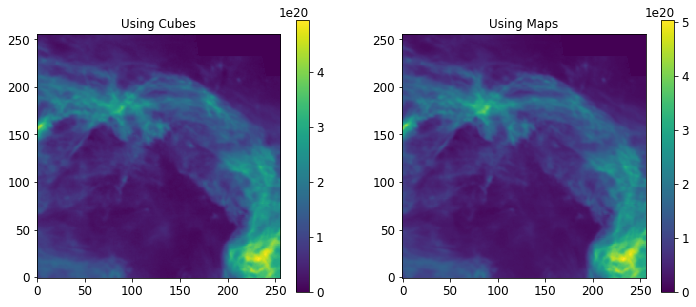

In [89]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1);plt.title("Using Cubes");plt.imshow(np.sum(mean_CNM_bc_cube, 0)*C*dv, origin='lower');plt.colorbar()
plt.subplot(1,2,2);plt.title("Using Maps");plt.imshow(mean_CNM_bc_map, origin='lower');plt.colorbar()

In [90]:
std_CNM_bc_map = np.std([CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,\
                         CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,\
                         CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,\
                         CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,\
                         CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49], 0)
std_LNM_bc_map = np.std([LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,\
                         LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,\
                         LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,\
                         LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,\
                         LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49], 0)
std_WNMa_bc_map = np.std([WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,\
                         WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,\
                         WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,\
                         WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,\
                         WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49], 0)
std_WNMd_bc_map = np.std([WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,\
                         WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,\
                         WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,\
                         WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,\
                         WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49], 0)

In [91]:
frac_std_WNMd_bc_map = np.std([frac_CNM_bc_from_maps_0,frac_CNM_bc_from_maps_1,frac_CNM_bc_from_maps_2,frac_CNM_bc_from_maps_3,frac_CNM_bc_from_maps_4,frac_CNM_bc_from_maps_5,frac_CNM_bc_from_maps_6,frac_CNM_bc_from_maps_7,frac_CNM_bc_from_maps_8,frac_CNM_bc_from_maps_9,\
                               frac_CNM_bc_from_maps_10,frac_CNM_bc_from_maps_11,frac_CNM_bc_from_maps_12,frac_CNM_bc_from_maps_13,frac_CNM_bc_from_maps_14,frac_CNM_bc_from_maps_15,frac_CNM_bc_from_maps_16,frac_CNM_bc_from_maps_17,frac_CNM_bc_from_maps_18,frac_CNM_bc_from_maps_19,\
                               frac_CNM_bc_from_maps_20,frac_CNM_bc_from_maps_21,frac_CNM_bc_from_maps_22,frac_CNM_bc_from_maps_23,frac_CNM_bc_from_maps_24,frac_CNM_bc_from_maps_25,frac_CNM_bc_from_maps_26,frac_CNM_bc_from_maps_27,frac_CNM_bc_from_maps_28,frac_CNM_bc_from_maps_29,\
                               frac_CNM_bc_from_maps_30,frac_CNM_bc_from_maps_31,frac_CNM_bc_from_maps_32,frac_CNM_bc_from_maps_33,frac_CNM_bc_from_maps_34,frac_CNM_bc_from_maps_35,frac_CNM_bc_from_maps_36,frac_CNM_bc_from_maps_37,frac_CNM_bc_from_maps_38,frac_CNM_bc_from_maps_39,\
                               frac_CNM_bc_from_maps_40,frac_CNM_bc_from_maps_41,frac_CNM_bc_from_maps_42,frac_CNM_bc_from_maps_43,frac_CNM_bc_from_maps_44,frac_CNM_bc_from_maps_45,frac_CNM_bc_from_maps_46,frac_CNM_bc_from_maps_47,frac_CNM_bc_from_maps_48,frac_CNM_bc_from_maps_49], 0)
frac_std_WNMd_bc_map = np.std([frac_LNM_bc_from_maps_0,frac_LNM_bc_from_maps_1,frac_LNM_bc_from_maps_2,frac_LNM_bc_from_maps_3,frac_LNM_bc_from_maps_4,frac_LNM_bc_from_maps_5,frac_LNM_bc_from_maps_6,frac_LNM_bc_from_maps_7,frac_LNM_bc_from_maps_8,frac_LNM_bc_from_maps_9,\
                               frac_LNM_bc_from_maps_10,frac_LNM_bc_from_maps_11,frac_LNM_bc_from_maps_12,frac_LNM_bc_from_maps_13,frac_LNM_bc_from_maps_14,frac_LNM_bc_from_maps_15,frac_LNM_bc_from_maps_16,frac_LNM_bc_from_maps_17,frac_LNM_bc_from_maps_18,frac_LNM_bc_from_maps_19,\
                               frac_LNM_bc_from_maps_20,frac_LNM_bc_from_maps_21,frac_LNM_bc_from_maps_22,frac_LNM_bc_from_maps_23,frac_LNM_bc_from_maps_24,frac_LNM_bc_from_maps_25,frac_LNM_bc_from_maps_26,frac_LNM_bc_from_maps_27,frac_LNM_bc_from_maps_28,frac_LNM_bc_from_maps_29,\
                               frac_LNM_bc_from_maps_30,frac_LNM_bc_from_maps_31,frac_LNM_bc_from_maps_32,frac_LNM_bc_from_maps_33,frac_LNM_bc_from_maps_34,frac_LNM_bc_from_maps_35,frac_LNM_bc_from_maps_36,frac_LNM_bc_from_maps_37,frac_LNM_bc_from_maps_38,frac_LNM_bc_from_maps_39,\
                               frac_LNM_bc_from_maps_40,frac_LNM_bc_from_maps_41,frac_LNM_bc_from_maps_42,frac_LNM_bc_from_maps_43,frac_LNM_bc_from_maps_44,frac_LNM_bc_from_maps_45,frac_LNM_bc_from_maps_46,frac_LNM_bc_from_maps_47,frac_LNM_bc_from_maps_48,frac_LNM_bc_from_maps_49], 0)
frac_std_WNMd_bc_map = np.std([frac_WNMa_bc_from_maps_0,frac_WNMa_bc_from_maps_1,frac_WNMa_bc_from_maps_2,frac_WNMa_bc_from_maps_3,frac_WNMa_bc_from_maps_4,frac_WNMa_bc_from_maps_5,frac_WNMa_bc_from_maps_6,frac_WNMa_bc_from_maps_7,frac_WNMa_bc_from_maps_8,frac_WNMa_bc_from_maps_9,\
                               frac_WNMa_bc_from_maps_10,frac_WNMa_bc_from_maps_11,frac_WNMa_bc_from_maps_12,frac_WNMa_bc_from_maps_13,frac_WNMa_bc_from_maps_14,frac_WNMa_bc_from_maps_15,frac_WNMa_bc_from_maps_16,frac_WNMa_bc_from_maps_17,frac_WNMa_bc_from_maps_18,frac_WNMa_bc_from_maps_19,\
                               frac_WNMa_bc_from_maps_20,frac_WNMa_bc_from_maps_21,frac_WNMa_bc_from_maps_22,frac_WNMa_bc_from_maps_23,frac_WNMa_bc_from_maps_24,frac_WNMa_bc_from_maps_25,frac_WNMa_bc_from_maps_26,frac_WNMa_bc_from_maps_27,frac_WNMa_bc_from_maps_28,frac_WNMa_bc_from_maps_29,\
                               frac_WNMa_bc_from_maps_30,frac_WNMa_bc_from_maps_31,frac_WNMa_bc_from_maps_32,frac_WNMa_bc_from_maps_33,frac_WNMa_bc_from_maps_34,frac_WNMa_bc_from_maps_35,frac_WNMa_bc_from_maps_36,frac_WNMa_bc_from_maps_37,frac_WNMa_bc_from_maps_38,frac_WNMa_bc_from_maps_39,\
                               frac_WNMa_bc_from_maps_40,frac_WNMa_bc_from_maps_41,frac_WNMa_bc_from_maps_42,frac_WNMa_bc_from_maps_43,frac_WNMa_bc_from_maps_44,frac_WNMa_bc_from_maps_45,frac_WNMa_bc_from_maps_46,frac_WNMa_bc_from_maps_47,frac_WNMa_bc_from_maps_48,frac_WNMa_bc_from_maps_49], 0)
frac_std_WNMd_bc_map = np.std([frac_WNMd_bc_from_maps_0,frac_WNMd_bc_from_maps_1,frac_WNMd_bc_from_maps_2,frac_WNMd_bc_from_maps_3,frac_WNMd_bc_from_maps_4,frac_WNMd_bc_from_maps_5,frac_WNMd_bc_from_maps_6,frac_WNMd_bc_from_maps_7,frac_WNMd_bc_from_maps_8,frac_WNMd_bc_from_maps_9,\
                               frac_WNMd_bc_from_maps_10,frac_WNMd_bc_from_maps_11,frac_WNMd_bc_from_maps_12,frac_WNMd_bc_from_maps_13,frac_WNMd_bc_from_maps_14,frac_WNMd_bc_from_maps_15,frac_WNMd_bc_from_maps_16,frac_WNMd_bc_from_maps_17,frac_WNMd_bc_from_maps_18,frac_WNMd_bc_from_maps_19,\
                               frac_WNMd_bc_from_maps_20,frac_WNMd_bc_from_maps_21,frac_WNMd_bc_from_maps_22,frac_WNMd_bc_from_maps_23,frac_WNMd_bc_from_maps_24,frac_WNMd_bc_from_maps_25,frac_WNMd_bc_from_maps_26,frac_WNMd_bc_from_maps_27,frac_WNMd_bc_from_maps_28,frac_WNMd_bc_from_maps_29,\
                               frac_WNMd_bc_from_maps_30,frac_WNMd_bc_from_maps_31,frac_WNMd_bc_from_maps_32,frac_WNMd_bc_from_maps_33,frac_WNMd_bc_from_maps_34,frac_WNMd_bc_from_maps_35,frac_WNMd_bc_from_maps_36,frac_WNMd_bc_from_maps_37,frac_WNMd_bc_from_maps_38,frac_WNMd_bc_from_maps_39,\
                               frac_WNMd_bc_from_maps_40,frac_WNMd_bc_from_maps_41,frac_WNMd_bc_from_maps_42,frac_WNMd_bc_from_maps_43,frac_WNMd_bc_from_maps_44,frac_WNMd_bc_from_maps_45,frac_WNMd_bc_from_maps_46,frac_WNMd_bc_from_maps_47,frac_WNMd_bc_from_maps_48,frac_WNMd_bc_from_maps_49], 0)

(-0.5, 255.5, -0.5, 255.5)

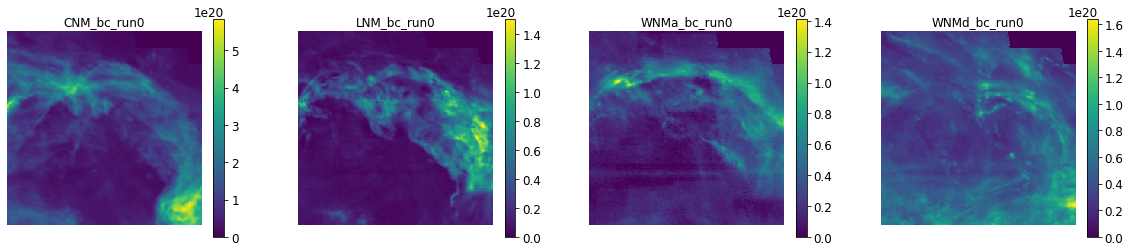

In [92]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1); plt.title("CNM_bc_run0"); plt.imshow(CNM_bc_map0, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(1,4,2); plt.title("LNM_bc_run0"); plt.imshow(LNM_bc_map0, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(1,4,3); plt.title("WNMa_bc_run0"); plt.imshow(WNMa_bc_map0, origin='lower'); plt.colorbar(); plt.axis("off")
plt.subplot(1,4,4); plt.title("WNMd_bc_run0"); plt.imshow(WNMd_bc_map0, origin='lower'); plt.colorbar(); plt.axis("off")

PPV Cubes for rnd lambdas

In [93]:
CNM_list0,LNM_list0,WNMa_list0,WNMd_list0,CNM_ls_map0,LNM_ls_map0,WNMa_ls_map0,WNMd_ls_map0=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[0],dispersion_multi_rnd_lambdas[0],NHI_map_multi_rnd_lambdas[0])
CNM_list1,LNM_list1,WNMa_list1,WNMd_list1,CNM_ls_map1,LNM_ls_map1,WNMa_ls_map1,WNMd_ls_map1=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[1],dispersion_multi_rnd_lambdas[1],NHI_map_multi_rnd_lambdas[1])
CNM_list2,LNM_list2,WNMa_list2,WNMd_list2,CNM_ls_map2,LNM_ls_map2,WNMa_ls_map2,WNMd_ls_map2=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[2],dispersion_multi_rnd_lambdas[2],NHI_map_multi_rnd_lambdas[2])
CNM_list3,LNM_list3,WNMa_list3,WNMd_list3,CNM_ls_map3,LNM_ls_map3,WNMa_ls_map3,WNMd_ls_map3=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[3],dispersion_multi_rnd_lambdas[3],NHI_map_multi_rnd_lambdas[3])
CNM_list4,LNM_list4,WNMa_list4,WNMd_list4,CNM_ls_map4,LNM_ls_map4,WNMa_ls_map4,WNMd_ls_map4=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[4],dispersion_multi_rnd_lambdas[4],NHI_map_multi_rnd_lambdas[4])
CNM_list5,LNM_list5,WNMa_list5,WNMd_list5,CNM_ls_map5,LNM_ls_map5,WNMa_ls_map5,WNMd_ls_map5=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[5],dispersion_multi_rnd_lambdas[5],NHI_map_multi_rnd_lambdas[5])
CNM_list6,LNM_list6,WNMa_list6,WNMd_list6,CNM_ls_map6,LNM_ls_map6,WNMa_ls_map6,WNMd_ls_map6=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[6],dispersion_multi_rnd_lambdas[6],NHI_map_multi_rnd_lambdas[6])
CNM_list7,LNM_list7,WNMa_list7,WNMd_list7,CNM_ls_map7,LNM_ls_map7,WNMa_ls_map7,WNMd_ls_map7=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[7],dispersion_multi_rnd_lambdas[7],NHI_map_multi_rnd_lambdas[7])
CNM_list8,LNM_list8,WNMa_list8,WNMd_list8,CNM_ls_map8,LNM_ls_map8,WNMa_ls_map8,WNMd_ls_map8=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[8],dispersion_multi_rnd_lambdas[8],NHI_map_multi_rnd_lambdas[8])
CNM_list9,LNM_list9,WNMa_list9,WNMd_list9,CNM_ls_map9,LNM_ls_map9,WNMa_ls_map9,WNMd_ls_map9=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[9],dispersion_multi_rnd_lambdas[9],NHI_map_multi_rnd_lambdas[9])
CNM_list10,LNM_list10,WNMa_list10,WNMd_list10,CNM_ls_map10,LNM_ls_map10,WNMa_ls_map10,WNMd_ls_map10=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[10],dispersion_multi_rnd_lambdas[10],NHI_map_multi_rnd_lambdas[10])
CNM_list11,LNM_list11,WNMa_list11,WNMd_list11,CNM_ls_map11,LNM_ls_map11,WNMa_ls_map11,WNMd_ls_map11=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[11],dispersion_multi_rnd_lambdas[11],NHI_map_multi_rnd_lambdas[11])
CNM_list12,LNM_list12,WNMa_list12,WNMd_list12,CNM_ls_map12,LNM_ls_map12,WNMa_ls_map12,WNMd_ls_map12=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[12],dispersion_multi_rnd_lambdas[12],NHI_map_multi_rnd_lambdas[12])
CNM_list13,LNM_list13,WNMa_list13,WNMd_list13,CNM_ls_map13,LNM_ls_map13,WNMa_ls_map13,WNMd_ls_map13=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[13],dispersion_multi_rnd_lambdas[13],NHI_map_multi_rnd_lambdas[13])
CNM_list14,LNM_list14,WNMa_list14,WNMd_list14,CNM_ls_map14,LNM_ls_map14,WNMa_ls_map14,WNMd_ls_map14=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[14],dispersion_multi_rnd_lambdas[14],NHI_map_multi_rnd_lambdas[14])
CNM_list15,LNM_list15,WNMa_list15,WNMd_list15,CNM_ls_map15,LNM_ls_map15,WNMa_ls_map15,WNMd_ls_map15=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[15],dispersion_multi_rnd_lambdas[15],NHI_map_multi_rnd_lambdas[15])
CNM_list16,LNM_list16,WNMa_list16,WNMd_list16,CNM_ls_map16,LNM_ls_map16,WNMa_ls_map16,WNMd_ls_map16=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[16],dispersion_multi_rnd_lambdas[16],NHI_map_multi_rnd_lambdas[16])
CNM_list17,LNM_list17,WNMa_list17,WNMd_list17,CNM_ls_map17,LNM_ls_map17,WNMa_ls_map17,WNMd_ls_map17=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[17],dispersion_multi_rnd_lambdas[17],NHI_map_multi_rnd_lambdas[17])
CNM_list18,LNM_list18,WNMa_list18,WNMd_list18,CNM_ls_map18,LNM_ls_map18,WNMa_ls_map18,WNMd_ls_map18=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[18],dispersion_multi_rnd_lambdas[18],NHI_map_multi_rnd_lambdas[18])
CNM_list19,LNM_list19,WNMa_list19,WNMd_list19,CNM_ls_map19,LNM_ls_map19,WNMa_ls_map19,WNMd_ls_map19=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[19],dispersion_multi_rnd_lambdas[19],NHI_map_multi_rnd_lambdas[19])
CNM_list20,LNM_list20,WNMa_list20,WNMd_list20,CNM_ls_map20,LNM_ls_map20,WNMa_ls_map20,WNMd_ls_map20=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[20],dispersion_multi_rnd_lambdas[20],NHI_map_multi_rnd_lambdas[20])
CNM_list21,LNM_list21,WNMa_list21,WNMd_list21,CNM_ls_map21,LNM_ls_map21,WNMa_ls_map21,WNMd_ls_map21=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[21],dispersion_multi_rnd_lambdas[21],NHI_map_multi_rnd_lambdas[21])
CNM_list22,LNM_list22,WNMa_list22,WNMd_list22,CNM_ls_map22,LNM_ls_map22,WNMa_ls_map22,WNMd_ls_map22=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[22],dispersion_multi_rnd_lambdas[22],NHI_map_multi_rnd_lambdas[22])
CNM_list23,LNM_list23,WNMa_list23,WNMd_list23,CNM_ls_map23,LNM_ls_map23,WNMa_ls_map23,WNMd_ls_map23=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[23],dispersion_multi_rnd_lambdas[23],NHI_map_multi_rnd_lambdas[23])
CNM_list24,LNM_list24,WNMa_list24,WNMd_list24,CNM_ls_map24,LNM_ls_map24,WNMa_ls_map24,WNMd_ls_map24=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[24],dispersion_multi_rnd_lambdas[24],NHI_map_multi_rnd_lambdas[24])
CNM_list25,LNM_list25,WNMa_list25,WNMd_list25,CNM_ls_map25,LNM_ls_map25,WNMa_ls_map25,WNMd_ls_map25=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[25],dispersion_multi_rnd_lambdas[25],NHI_map_multi_rnd_lambdas[25])
CNM_list26,LNM_list26,WNMa_list26,WNMd_list26,CNM_ls_map26,LNM_ls_map26,WNMa_ls_map26,WNMd_ls_map26=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[26],dispersion_multi_rnd_lambdas[26],NHI_map_multi_rnd_lambdas[26])
CNM_list27,LNM_list27,WNMa_list27,WNMd_list27,CNM_ls_map27,LNM_ls_map27,WNMa_ls_map27,WNMd_ls_map27=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[27],dispersion_multi_rnd_lambdas[27],NHI_map_multi_rnd_lambdas[27])
CNM_list28,LNM_list28,WNMa_list28,WNMd_list28,CNM_ls_map28,LNM_ls_map28,WNMa_ls_map28,WNMd_ls_map28=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[28],dispersion_multi_rnd_lambdas[28],NHI_map_multi_rnd_lambdas[28])
CNM_list29,LNM_list29,WNMa_list29,WNMd_list29,CNM_ls_map29,LNM_ls_map29,WNMa_ls_map29,WNMd_ls_map29=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[29],dispersion_multi_rnd_lambdas[29],NHI_map_multi_rnd_lambdas[29])
CNM_list30,LNM_list30,WNMa_list30,WNMd_list30,CNM_ls_map30,LNM_ls_map30,WNMa_ls_map30,WNMd_ls_map30=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[30],dispersion_multi_rnd_lambdas[30],NHI_map_multi_rnd_lambdas[30])
CNM_list31,LNM_list31,WNMa_list31,WNMd_list31,CNM_ls_map31,LNM_ls_map31,WNMa_ls_map31,WNMd_ls_map31=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[31],dispersion_multi_rnd_lambdas[31],NHI_map_multi_rnd_lambdas[31])
CNM_list32,LNM_list32,WNMa_list32,WNMd_list32,CNM_ls_map32,LNM_ls_map32,WNMa_ls_map32,WNMd_ls_map32=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[32],dispersion_multi_rnd_lambdas[32],NHI_map_multi_rnd_lambdas[32])
CNM_list33,LNM_list33,WNMa_list33,WNMd_list33,CNM_ls_map33,LNM_ls_map33,WNMa_ls_map33,WNMd_ls_map33=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[33],dispersion_multi_rnd_lambdas[33],NHI_map_multi_rnd_lambdas[33])
CNM_list34,LNM_list34,WNMa_list34,WNMd_list34,CNM_ls_map34,LNM_ls_map34,WNMa_ls_map34,WNMd_ls_map34=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[34],dispersion_multi_rnd_lambdas[34],NHI_map_multi_rnd_lambdas[34])
CNM_list35,LNM_list35,WNMa_list35,WNMd_list35,CNM_ls_map35,LNM_ls_map35,WNMa_ls_map35,WNMd_ls_map35=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[35],dispersion_multi_rnd_lambdas[35],NHI_map_multi_rnd_lambdas[35])
CNM_list36,LNM_list36,WNMa_list36,WNMd_list36,CNM_ls_map36,LNM_ls_map36,WNMa_ls_map36,WNMd_ls_map36=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[36],dispersion_multi_rnd_lambdas[36],NHI_map_multi_rnd_lambdas[36])
CNM_list37,LNM_list37,WNMa_list37,WNMd_list37,CNM_ls_map37,LNM_ls_map37,WNMa_ls_map37,WNMd_ls_map37=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[37],dispersion_multi_rnd_lambdas[37],NHI_map_multi_rnd_lambdas[37])
CNM_list38,LNM_list38,WNMa_list38,WNMd_list38,CNM_ls_map38,LNM_ls_map38,WNMa_ls_map38,WNMd_ls_map38=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[38],dispersion_multi_rnd_lambdas[38],NHI_map_multi_rnd_lambdas[38])
CNM_list39,LNM_list39,WNMa_list39,WNMd_list39,CNM_ls_map39,LNM_ls_map39,WNMa_ls_map39,WNMd_ls_map39=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[39],dispersion_multi_rnd_lambdas[39],NHI_map_multi_rnd_lambdas[39])
CNM_list40,LNM_list40,WNMa_list40,WNMd_list40,CNM_ls_map40,LNM_ls_map40,WNMa_ls_map40,WNMd_ls_map40=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[40],dispersion_multi_rnd_lambdas[40],NHI_map_multi_rnd_lambdas[40])
CNM_list41,LNM_list41,WNMa_list41,WNMd_list41,CNM_ls_map41,LNM_ls_map41,WNMa_ls_map41,WNMd_ls_map41=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[41],dispersion_multi_rnd_lambdas[41],NHI_map_multi_rnd_lambdas[41])
CNM_list42,LNM_list42,WNMa_list42,WNMd_list42,CNM_ls_map42,LNM_ls_map42,WNMa_ls_map42,WNMd_ls_map42=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[42],dispersion_multi_rnd_lambdas[42],NHI_map_multi_rnd_lambdas[42])
CNM_list43,LNM_list43,WNMa_list43,WNMd_list43,CNM_ls_map43,LNM_ls_map43,WNMa_ls_map43,WNMd_ls_map43=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[43],dispersion_multi_rnd_lambdas[43],NHI_map_multi_rnd_lambdas[43])
CNM_list44,LNM_list44,WNMa_list44,WNMd_list44,CNM_ls_map44,LNM_ls_map44,WNMa_ls_map44,WNMd_ls_map44=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[44],dispersion_multi_rnd_lambdas[44],NHI_map_multi_rnd_lambdas[44])
CNM_list45,LNM_list45,WNMa_list45,WNMd_list45,CNM_ls_map45,LNM_ls_map45,WNMa_ls_map45,WNMd_ls_map45=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[45],dispersion_multi_rnd_lambdas[45],NHI_map_multi_rnd_lambdas[45])
CNM_list46,LNM_list46,WNMa_list46,WNMd_list46,CNM_ls_map46,LNM_ls_map46,WNMa_ls_map46,WNMd_ls_map46=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[46],dispersion_multi_rnd_lambdas[46],NHI_map_multi_rnd_lambdas[46])
CNM_list47,LNM_list47,WNMa_list47,WNMd_list47,CNM_ls_map47,LNM_ls_map47,WNMa_ls_map47,WNMd_ls_map47=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[47],dispersion_multi_rnd_lambdas[47],NHI_map_multi_rnd_lambdas[47])
CNM_list48,LNM_list48,WNMa_list48,WNMd_list48,CNM_ls_map48,LNM_ls_map48,WNMa_ls_map48,WNMd_ls_map48=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[48],dispersion_multi_rnd_lambdas[48],NHI_map_multi_rnd_lambdas[48])
CNM_list49,LNM_list49,WNMa_list49,WNMd_list49,CNM_ls_map49,LNM_ls_map49,WNMa_ls_map49,WNMd_ls_map49=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_rnd_lambdas[49],dispersion_multi_rnd_lambdas[49],NHI_map_multi_rnd_lambdas[49])

In [94]:
model_CNM_ls_0, model_LNM_ls_0, model_WNMa_ls_0, model_WNMd_ls_0 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[0], dispersion_multi_rnd_lambdas[0], amplitude_pix_multi_rnd_lambdas[0], position_pix_multi_rnd_lambdas[0], dispersion_pix_multi_rnd_lambdas[0], CNM_list0, LNM_list0, WNMa_list0, WNMd_list0)
model_CNM_ls_1, model_LNM_ls_1, model_WNMa_ls_1, model_WNMd_ls_1 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[1], dispersion_multi_rnd_lambdas[1], amplitude_pix_multi_rnd_lambdas[1], position_pix_multi_rnd_lambdas[1], dispersion_pix_multi_rnd_lambdas[1], CNM_list1, LNM_list1, WNMa_list1, WNMd_list1)
model_CNM_ls_2, model_LNM_ls_2, model_WNMa_ls_2, model_WNMd_ls_2 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[2], dispersion_multi_rnd_lambdas[2], amplitude_pix_multi_rnd_lambdas[2], position_pix_multi_rnd_lambdas[2], dispersion_pix_multi_rnd_lambdas[2], CNM_list2, LNM_list2, WNMa_list2, WNMd_list2)
model_CNM_ls_3, model_LNM_ls_3, model_WNMa_ls_3, model_WNMd_ls_3 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[3], dispersion_multi_rnd_lambdas[3], amplitude_pix_multi_rnd_lambdas[3], position_pix_multi_rnd_lambdas[3], dispersion_pix_multi_rnd_lambdas[3], CNM_list3, LNM_list3, WNMa_list3, WNMd_list3)
model_CNM_ls_4, model_LNM_ls_4, model_WNMa_ls_4, model_WNMd_ls_4 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[4], dispersion_multi_rnd_lambdas[4], amplitude_pix_multi_rnd_lambdas[4], position_pix_multi_rnd_lambdas[4], dispersion_pix_multi_rnd_lambdas[4], CNM_list4, LNM_list4, WNMa_list4, WNMd_list4)
model_CNM_ls_5, model_LNM_ls_5, model_WNMa_ls_5, model_WNMd_ls_5 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[5], dispersion_multi_rnd_lambdas[5], amplitude_pix_multi_rnd_lambdas[5], position_pix_multi_rnd_lambdas[5], dispersion_pix_multi_rnd_lambdas[5], CNM_list5, LNM_list5, WNMa_list5, WNMd_list5)
model_CNM_ls_6, model_LNM_ls_6, model_WNMa_ls_6, model_WNMd_ls_6 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[6], dispersion_multi_rnd_lambdas[6], amplitude_pix_multi_rnd_lambdas[6], position_pix_multi_rnd_lambdas[6], dispersion_pix_multi_rnd_lambdas[6], CNM_list6, LNM_list6, WNMa_list6, WNMd_list6)
model_CNM_ls_7, model_LNM_ls_7, model_WNMa_ls_7, model_WNMd_ls_7 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[7], dispersion_multi_rnd_lambdas[7], amplitude_pix_multi_rnd_lambdas[7], position_pix_multi_rnd_lambdas[7], dispersion_pix_multi_rnd_lambdas[7], CNM_list7, LNM_list7, WNMa_list7, WNMd_list7)
model_CNM_ls_8, model_LNM_ls_8, model_WNMa_ls_8, model_WNMd_ls_8 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[8], dispersion_multi_rnd_lambdas[8], amplitude_pix_multi_rnd_lambdas[8], position_pix_multi_rnd_lambdas[8], dispersion_pix_multi_rnd_lambdas[8], CNM_list8, LNM_list8, WNMa_list8, WNMd_list8)
model_CNM_ls_9, model_LNM_ls_9, model_WNMa_ls_9, model_WNMd_ls_9 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[9], dispersion_multi_rnd_lambdas[9], amplitude_pix_multi_rnd_lambdas[9], position_pix_multi_rnd_lambdas[9], dispersion_pix_multi_rnd_lambdas[9], CNM_list9, LNM_list9, WNMa_list9, WNMd_list9)
model_CNM_ls_10, model_LNM_ls_10, model_WNMa_ls_10, model_WNMd_ls_10 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[10], dispersion_multi_rnd_lambdas[10], amplitude_pix_multi_rnd_lambdas[10], position_pix_multi_rnd_lambdas[10], dispersion_pix_multi_rnd_lambdas[10], CNM_list10, LNM_list10, WNMa_list10, WNMd_list10)
model_CNM_ls_11, model_LNM_ls_11, model_WNMa_ls_11, model_WNMd_ls_11 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[11], dispersion_multi_rnd_lambdas[11], amplitude_pix_multi_rnd_lambdas[11], position_pix_multi_rnd_lambdas[11], dispersion_pix_multi_rnd_lambdas[11], CNM_list11, LNM_list11, WNMa_list11, WNMd_list11)
model_CNM_ls_12, model_LNM_ls_12, model_WNMa_ls_12, model_WNMd_ls_12 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[12], dispersion_multi_rnd_lambdas[12], amplitude_pix_multi_rnd_lambdas[12], position_pix_multi_rnd_lambdas[12], dispersion_pix_multi_rnd_lambdas[12], CNM_list12, LNM_list12, WNMa_list12, WNMd_list12)
model_CNM_ls_13, model_LNM_ls_13, model_WNMa_ls_13, model_WNMd_ls_13 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[13], dispersion_multi_rnd_lambdas[13], amplitude_pix_multi_rnd_lambdas[13], position_pix_multi_rnd_lambdas[13], dispersion_pix_multi_rnd_lambdas[13], CNM_list13, LNM_list13, WNMa_list13, WNMd_list13)
model_CNM_ls_14, model_LNM_ls_14, model_WNMa_ls_14, model_WNMd_ls_14 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[14], dispersion_multi_rnd_lambdas[14], amplitude_pix_multi_rnd_lambdas[14], position_pix_multi_rnd_lambdas[14], dispersion_pix_multi_rnd_lambdas[14], CNM_list14, LNM_list14, WNMa_list14, WNMd_list14)
model_CNM_ls_15, model_LNM_ls_15, model_WNMa_ls_15, model_WNMd_ls_15 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[15], dispersion_multi_rnd_lambdas[15], amplitude_pix_multi_rnd_lambdas[15], position_pix_multi_rnd_lambdas[15], dispersion_pix_multi_rnd_lambdas[15], CNM_list15, LNM_list15, WNMa_list15, WNMd_list15)
model_CNM_ls_16, model_LNM_ls_16, model_WNMa_ls_16, model_WNMd_ls_16 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[16], dispersion_multi_rnd_lambdas[16], amplitude_pix_multi_rnd_lambdas[16], position_pix_multi_rnd_lambdas[16], dispersion_pix_multi_rnd_lambdas[16], CNM_list16, LNM_list16, WNMa_list16, WNMd_list16)
model_CNM_ls_17, model_LNM_ls_17, model_WNMa_ls_17, model_WNMd_ls_17 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[17], dispersion_multi_rnd_lambdas[17], amplitude_pix_multi_rnd_lambdas[17], position_pix_multi_rnd_lambdas[17], dispersion_pix_multi_rnd_lambdas[17], CNM_list17, LNM_list17, WNMa_list17, WNMd_list17)
model_CNM_ls_18, model_LNM_ls_18, model_WNMa_ls_18, model_WNMd_ls_18 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[18], dispersion_multi_rnd_lambdas[18], amplitude_pix_multi_rnd_lambdas[18], position_pix_multi_rnd_lambdas[18], dispersion_pix_multi_rnd_lambdas[18], CNM_list18, LNM_list18, WNMa_list18, WNMd_list18)
model_CNM_ls_19, model_LNM_ls_19, model_WNMa_ls_19, model_WNMd_ls_19 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[19], dispersion_multi_rnd_lambdas[19], amplitude_pix_multi_rnd_lambdas[19], position_pix_multi_rnd_lambdas[19], dispersion_pix_multi_rnd_lambdas[19], CNM_list19, LNM_list19, WNMa_list19, WNMd_list19)
model_CNM_ls_20, model_LNM_ls_20, model_WNMa_ls_20, model_WNMd_ls_20 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[20], dispersion_multi_rnd_lambdas[20], amplitude_pix_multi_rnd_lambdas[20], position_pix_multi_rnd_lambdas[20], dispersion_pix_multi_rnd_lambdas[20], CNM_list20, LNM_list20, WNMa_list20, WNMd_list20)
model_CNM_ls_21, model_LNM_ls_21, model_WNMa_ls_21, model_WNMd_ls_21 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[21], dispersion_multi_rnd_lambdas[21], amplitude_pix_multi_rnd_lambdas[21], position_pix_multi_rnd_lambdas[21], dispersion_pix_multi_rnd_lambdas[21], CNM_list21, LNM_list21, WNMa_list21, WNMd_list21)
model_CNM_ls_22, model_LNM_ls_22, model_WNMa_ls_22, model_WNMd_ls_22 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[22], dispersion_multi_rnd_lambdas[22], amplitude_pix_multi_rnd_lambdas[22], position_pix_multi_rnd_lambdas[22], dispersion_pix_multi_rnd_lambdas[22], CNM_list22, LNM_list22, WNMa_list22, WNMd_list22)
model_CNM_ls_23, model_LNM_ls_23, model_WNMa_ls_23, model_WNMd_ls_23 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[23], dispersion_multi_rnd_lambdas[23], amplitude_pix_multi_rnd_lambdas[23], position_pix_multi_rnd_lambdas[23], dispersion_pix_multi_rnd_lambdas[23], CNM_list23, LNM_list23, WNMa_list23, WNMd_list23)
model_CNM_ls_24, model_LNM_ls_24, model_WNMa_ls_24, model_WNMd_ls_24 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[24], dispersion_multi_rnd_lambdas[24], amplitude_pix_multi_rnd_lambdas[24], position_pix_multi_rnd_lambdas[24], dispersion_pix_multi_rnd_lambdas[24], CNM_list24, LNM_list24, WNMa_list24, WNMd_list24)
model_CNM_ls_25, model_LNM_ls_25, model_WNMa_ls_25, model_WNMd_ls_25 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[25], dispersion_multi_rnd_lambdas[25], amplitude_pix_multi_rnd_lambdas[25], position_pix_multi_rnd_lambdas[25], dispersion_pix_multi_rnd_lambdas[25], CNM_list25, LNM_list25, WNMa_list25, WNMd_list25)
model_CNM_ls_26, model_LNM_ls_26, model_WNMa_ls_26, model_WNMd_ls_26 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[26], dispersion_multi_rnd_lambdas[26], amplitude_pix_multi_rnd_lambdas[26], position_pix_multi_rnd_lambdas[26], dispersion_pix_multi_rnd_lambdas[26], CNM_list26, LNM_list26, WNMa_list26, WNMd_list26)
model_CNM_ls_27, model_LNM_ls_27, model_WNMa_ls_27, model_WNMd_ls_27 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[27], dispersion_multi_rnd_lambdas[27], amplitude_pix_multi_rnd_lambdas[27], position_pix_multi_rnd_lambdas[27], dispersion_pix_multi_rnd_lambdas[27], CNM_list27, LNM_list27, WNMa_list27, WNMd_list27)
model_CNM_ls_28, model_LNM_ls_28, model_WNMa_ls_28, model_WNMd_ls_28 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[28], dispersion_multi_rnd_lambdas[28], amplitude_pix_multi_rnd_lambdas[28], position_pix_multi_rnd_lambdas[28], dispersion_pix_multi_rnd_lambdas[28], CNM_list28, LNM_list28, WNMa_list28, WNMd_list28)
model_CNM_ls_29, model_LNM_ls_29, model_WNMa_ls_29, model_WNMd_ls_29 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[29], dispersion_multi_rnd_lambdas[29], amplitude_pix_multi_rnd_lambdas[29], position_pix_multi_rnd_lambdas[29], dispersion_pix_multi_rnd_lambdas[29], CNM_list29, LNM_list29, WNMa_list29, WNMd_list29)
model_CNM_ls_30, model_LNM_ls_30, model_WNMa_ls_30, model_WNMd_ls_30 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[30], dispersion_multi_rnd_lambdas[30], amplitude_pix_multi_rnd_lambdas[30], position_pix_multi_rnd_lambdas[30], dispersion_pix_multi_rnd_lambdas[30], CNM_list30, LNM_list30, WNMa_list30, WNMd_list30)
model_CNM_ls_31, model_LNM_ls_31, model_WNMa_ls_31, model_WNMd_ls_31 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[31], dispersion_multi_rnd_lambdas[31], amplitude_pix_multi_rnd_lambdas[31], position_pix_multi_rnd_lambdas[31], dispersion_pix_multi_rnd_lambdas[31], CNM_list31, LNM_list31, WNMa_list31, WNMd_list31)
model_CNM_ls_32, model_LNM_ls_32, model_WNMa_ls_32, model_WNMd_ls_32 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[32], dispersion_multi_rnd_lambdas[32], amplitude_pix_multi_rnd_lambdas[32], position_pix_multi_rnd_lambdas[32], dispersion_pix_multi_rnd_lambdas[32], CNM_list32, LNM_list32, WNMa_list32, WNMd_list32)
model_CNM_ls_33, model_LNM_ls_33, model_WNMa_ls_33, model_WNMd_ls_33 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[33], dispersion_multi_rnd_lambdas[33], amplitude_pix_multi_rnd_lambdas[33], position_pix_multi_rnd_lambdas[33], dispersion_pix_multi_rnd_lambdas[33], CNM_list33, LNM_list33, WNMa_list33, WNMd_list33)
model_CNM_ls_34, model_LNM_ls_34, model_WNMa_ls_34, model_WNMd_ls_34 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[34], dispersion_multi_rnd_lambdas[34], amplitude_pix_multi_rnd_lambdas[34], position_pix_multi_rnd_lambdas[34], dispersion_pix_multi_rnd_lambdas[34], CNM_list34, LNM_list34, WNMa_list34, WNMd_list34)
model_CNM_ls_35, model_LNM_ls_35, model_WNMa_ls_35, model_WNMd_ls_35 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[35], dispersion_multi_rnd_lambdas[35], amplitude_pix_multi_rnd_lambdas[35], position_pix_multi_rnd_lambdas[35], dispersion_pix_multi_rnd_lambdas[35], CNM_list35, LNM_list35, WNMa_list35, WNMd_list35)
model_CNM_ls_36, model_LNM_ls_36, model_WNMa_ls_36, model_WNMd_ls_36 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[36], dispersion_multi_rnd_lambdas[36], amplitude_pix_multi_rnd_lambdas[36], position_pix_multi_rnd_lambdas[36], dispersion_pix_multi_rnd_lambdas[36], CNM_list36, LNM_list36, WNMa_list36, WNMd_list36)
model_CNM_ls_37, model_LNM_ls_37, model_WNMa_ls_37, model_WNMd_ls_37 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[37], dispersion_multi_rnd_lambdas[37], amplitude_pix_multi_rnd_lambdas[37], position_pix_multi_rnd_lambdas[37], dispersion_pix_multi_rnd_lambdas[37], CNM_list37, LNM_list37, WNMa_list37, WNMd_list37)
model_CNM_ls_38, model_LNM_ls_38, model_WNMa_ls_38, model_WNMd_ls_38 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[38], dispersion_multi_rnd_lambdas[38], amplitude_pix_multi_rnd_lambdas[38], position_pix_multi_rnd_lambdas[38], dispersion_pix_multi_rnd_lambdas[38], CNM_list38, LNM_list38, WNMa_list38, WNMd_list38)
model_CNM_ls_39, model_LNM_ls_39, model_WNMa_ls_39, model_WNMd_ls_39 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[39], dispersion_multi_rnd_lambdas[39], amplitude_pix_multi_rnd_lambdas[39], position_pix_multi_rnd_lambdas[39], dispersion_pix_multi_rnd_lambdas[39], CNM_list39, LNM_list39, WNMa_list39, WNMd_list39)
model_CNM_ls_40, model_LNM_ls_40, model_WNMa_ls_40, model_WNMd_ls_40 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[40], dispersion_multi_rnd_lambdas[40], amplitude_pix_multi_rnd_lambdas[40], position_pix_multi_rnd_lambdas[40], dispersion_pix_multi_rnd_lambdas[40], CNM_list40, LNM_list40, WNMa_list40, WNMd_list40)
model_CNM_ls_41, model_LNM_ls_41, model_WNMa_ls_41, model_WNMd_ls_41 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[41], dispersion_multi_rnd_lambdas[41], amplitude_pix_multi_rnd_lambdas[41], position_pix_multi_rnd_lambdas[41], dispersion_pix_multi_rnd_lambdas[41], CNM_list41, LNM_list41, WNMa_list41, WNMd_list41)
model_CNM_ls_42, model_LNM_ls_42, model_WNMa_ls_42, model_WNMd_ls_42 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[42], dispersion_multi_rnd_lambdas[42], amplitude_pix_multi_rnd_lambdas[42], position_pix_multi_rnd_lambdas[42], dispersion_pix_multi_rnd_lambdas[42], CNM_list42, LNM_list42, WNMa_list42, WNMd_list42)
model_CNM_ls_43, model_LNM_ls_43, model_WNMa_ls_43, model_WNMd_ls_43 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[43], dispersion_multi_rnd_lambdas[43], amplitude_pix_multi_rnd_lambdas[43], position_pix_multi_rnd_lambdas[43], dispersion_pix_multi_rnd_lambdas[43], CNM_list43, LNM_list43, WNMa_list43, WNMd_list43)
model_CNM_ls_44, model_LNM_ls_44, model_WNMa_ls_44, model_WNMd_ls_44 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[44], dispersion_multi_rnd_lambdas[44], amplitude_pix_multi_rnd_lambdas[44], position_pix_multi_rnd_lambdas[44], dispersion_pix_multi_rnd_lambdas[44], CNM_list44, LNM_list44, WNMa_list44, WNMd_list44)
model_CNM_ls_45, model_LNM_ls_45, model_WNMa_ls_45, model_WNMd_ls_45 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[45], dispersion_multi_rnd_lambdas[45], amplitude_pix_multi_rnd_lambdas[45], position_pix_multi_rnd_lambdas[45], dispersion_pix_multi_rnd_lambdas[45], CNM_list45, LNM_list45, WNMa_list45, WNMd_list45)
model_CNM_ls_46, model_LNM_ls_46, model_WNMa_ls_46, model_WNMd_ls_46 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[46], dispersion_multi_rnd_lambdas[46], amplitude_pix_multi_rnd_lambdas[46], position_pix_multi_rnd_lambdas[46], dispersion_pix_multi_rnd_lambdas[46], CNM_list46, LNM_list46, WNMa_list46, WNMd_list46)
model_CNM_ls_47, model_LNM_ls_47, model_WNMa_ls_47, model_WNMd_ls_47 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[47], dispersion_multi_rnd_lambdas[47], amplitude_pix_multi_rnd_lambdas[47], position_pix_multi_rnd_lambdas[47], dispersion_pix_multi_rnd_lambdas[47], CNM_list47, LNM_list47, WNMa_list47, WNMd_list47)
model_CNM_ls_48, model_LNM_ls_48, model_WNMa_ls_48, model_WNMd_ls_48 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[48], dispersion_multi_rnd_lambdas[48], amplitude_pix_multi_rnd_lambdas[48], position_pix_multi_rnd_lambdas[48], dispersion_pix_multi_rnd_lambdas[48], CNM_list48, LNM_list48, WNMa_list48, WNMd_list48)
model_CNM_ls_49, model_LNM_ls_49, model_WNMa_ls_49, model_WNMd_ls_49 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_rnd_lambdas[49], dispersion_multi_rnd_lambdas[49], amplitude_pix_multi_rnd_lambdas[49], position_pix_multi_rnd_lambdas[49], dispersion_pix_multi_rnd_lambdas[49], CNM_list49, LNM_list49, WNMa_list49, WNMd_list49)

In [95]:
tot_model_ls_0 = model_CNM_ls_0+ model_LNM_ls_0+ model_WNMa_ls_0+ model_WNMd_ls_0
tot_model_ls_1 = model_CNM_ls_1+ model_LNM_ls_1+ model_WNMa_ls_1+ model_WNMd_ls_1
tot_model_ls_2 = model_CNM_ls_2+ model_LNM_ls_2+ model_WNMa_ls_2+ model_WNMd_ls_2
tot_model_ls_3 = model_CNM_ls_3+ model_LNM_ls_3+ model_WNMa_ls_3+ model_WNMd_ls_3
tot_model_ls_4 = model_CNM_ls_4+ model_LNM_ls_4+ model_WNMa_ls_4+ model_WNMd_ls_4
tot_model_ls_5 = model_CNM_ls_5+ model_LNM_ls_5+ model_WNMa_ls_5+ model_WNMd_ls_5
tot_model_ls_6 = model_CNM_ls_6+ model_LNM_ls_6+ model_WNMa_ls_6+ model_WNMd_ls_6
tot_model_ls_7 = model_CNM_ls_7+ model_LNM_ls_7+ model_WNMa_ls_7+ model_WNMd_ls_7
tot_model_ls_8 = model_CNM_ls_8+ model_LNM_ls_8+ model_WNMa_ls_8+ model_WNMd_ls_8
tot_model_ls_9 = model_CNM_ls_9+ model_LNM_ls_9+ model_WNMa_ls_9+ model_WNMd_ls_9
tot_model_ls_10 = model_CNM_ls_10+ model_LNM_ls_10+ model_WNMa_ls_10+ model_WNMd_ls_10
tot_model_ls_11 = model_CNM_ls_11+ model_LNM_ls_11+ model_WNMa_ls_11+ model_WNMd_ls_11
tot_model_ls_12 = model_CNM_ls_12+ model_LNM_ls_12+ model_WNMa_ls_12+ model_WNMd_ls_12
tot_model_ls_13 = model_CNM_ls_13+ model_LNM_ls_13+ model_WNMa_ls_13+ model_WNMd_ls_13
tot_model_ls_14 = model_CNM_ls_14+ model_LNM_ls_14+ model_WNMa_ls_14+ model_WNMd_ls_14
tot_model_ls_15 = model_CNM_ls_15+ model_LNM_ls_15+ model_WNMa_ls_15+ model_WNMd_ls_15
tot_model_ls_16 = model_CNM_ls_16+ model_LNM_ls_16+ model_WNMa_ls_16+ model_WNMd_ls_16
tot_model_ls_17 = model_CNM_ls_17+ model_LNM_ls_17+ model_WNMa_ls_17+ model_WNMd_ls_17
tot_model_ls_18 = model_CNM_ls_18+ model_LNM_ls_18+ model_WNMa_ls_18+ model_WNMd_ls_18
tot_model_ls_19 = model_CNM_ls_19+ model_LNM_ls_19+ model_WNMa_ls_19+ model_WNMd_ls_19
tot_model_ls_20 = model_CNM_ls_20+ model_LNM_ls_20+ model_WNMa_ls_20+ model_WNMd_ls_20
tot_model_ls_21 = model_CNM_ls_21+ model_LNM_ls_21+ model_WNMa_ls_21+ model_WNMd_ls_21
tot_model_ls_22 = model_CNM_ls_22+ model_LNM_ls_22+ model_WNMa_ls_22+ model_WNMd_ls_22
tot_model_ls_23 = model_CNM_ls_23+ model_LNM_ls_23+ model_WNMa_ls_23+ model_WNMd_ls_23
tot_model_ls_24 = model_CNM_ls_24+ model_LNM_ls_24+ model_WNMa_ls_24+ model_WNMd_ls_24
tot_model_ls_25 = model_CNM_ls_25+ model_LNM_ls_25+ model_WNMa_ls_25+ model_WNMd_ls_25
tot_model_ls_26 = model_CNM_ls_26+ model_LNM_ls_26+ model_WNMa_ls_26+ model_WNMd_ls_26
tot_model_ls_27 = model_CNM_ls_27+ model_LNM_ls_27+ model_WNMa_ls_27+ model_WNMd_ls_27
tot_model_ls_28 = model_CNM_ls_28+ model_LNM_ls_28+ model_WNMa_ls_28+ model_WNMd_ls_28
tot_model_ls_29 = model_CNM_ls_29+ model_LNM_ls_29+ model_WNMa_ls_29+ model_WNMd_ls_29
tot_model_ls_30 = model_CNM_ls_30+ model_LNM_ls_30+ model_WNMa_ls_30+ model_WNMd_ls_30
tot_model_ls_31 = model_CNM_ls_31+ model_LNM_ls_31+ model_WNMa_ls_31+ model_WNMd_ls_31
tot_model_ls_32 = model_CNM_ls_32+ model_LNM_ls_32+ model_WNMa_ls_32+ model_WNMd_ls_32
tot_model_ls_33 = model_CNM_ls_33+ model_LNM_ls_33+ model_WNMa_ls_33+ model_WNMd_ls_33
tot_model_ls_34 = model_CNM_ls_34+ model_LNM_ls_34+ model_WNMa_ls_34+ model_WNMd_ls_34
tot_model_ls_35 = model_CNM_ls_35+ model_LNM_ls_35+ model_WNMa_ls_35+ model_WNMd_ls_35
tot_model_ls_36 = model_CNM_ls_36+ model_LNM_ls_36+ model_WNMa_ls_36+ model_WNMd_ls_36
tot_model_ls_37 = model_CNM_ls_37+ model_LNM_ls_37+ model_WNMa_ls_37+ model_WNMd_ls_37
tot_model_ls_38 = model_CNM_ls_38+ model_LNM_ls_38+ model_WNMa_ls_38+ model_WNMd_ls_38
tot_model_ls_39 = model_CNM_ls_39+ model_LNM_ls_39+ model_WNMa_ls_39+ model_WNMd_ls_39
tot_model_ls_40 = model_CNM_ls_40+ model_LNM_ls_40+ model_WNMa_ls_40+ model_WNMd_ls_40
tot_model_ls_41 = model_CNM_ls_41+ model_LNM_ls_41+ model_WNMa_ls_41+ model_WNMd_ls_41
tot_model_ls_42 = model_CNM_ls_42+ model_LNM_ls_42+ model_WNMa_ls_42+ model_WNMd_ls_42
tot_model_ls_43 = model_CNM_ls_43+ model_LNM_ls_43+ model_WNMa_ls_43+ model_WNMd_ls_43
tot_model_ls_44 = model_CNM_ls_44+ model_LNM_ls_44+ model_WNMa_ls_44+ model_WNMd_ls_44
tot_model_ls_45 = model_CNM_ls_45+ model_LNM_ls_45+ model_WNMa_ls_45+ model_WNMd_ls_45
tot_model_ls_46 = model_CNM_ls_46+ model_LNM_ls_46+ model_WNMa_ls_46+ model_WNMd_ls_46
tot_model_ls_47 = model_CNM_ls_47+ model_LNM_ls_47+ model_WNMa_ls_47+ model_WNMd_ls_47
tot_model_ls_48 = model_CNM_ls_48+ model_LNM_ls_48+ model_WNMa_ls_48+ model_WNMd_ls_48
tot_model_ls_49 = model_CNM_ls_49+ model_LNM_ls_49+ model_WNMa_ls_49+ model_WNMd_ls_49

In [96]:
tot_from_maps_ls_0 = CNM_ls_map0 + LNM_ls_map0 + WNMa_ls_map0 + WNMd_ls_map0
tot_from_maps_ls_1 = CNM_ls_map1 + LNM_ls_map1 + WNMa_ls_map1 + WNMd_ls_map1
tot_from_maps_ls_2 = CNM_ls_map2 + LNM_ls_map2 + WNMa_ls_map2 + WNMd_ls_map2
tot_from_maps_ls_3 = CNM_ls_map3 + LNM_ls_map3 + WNMa_ls_map3 + WNMd_ls_map3
tot_from_maps_ls_4 = CNM_ls_map4 + LNM_ls_map4 + WNMa_ls_map4 + WNMd_ls_map4
tot_from_maps_ls_5 = CNM_ls_map5 + LNM_ls_map5 + WNMa_ls_map5 + WNMd_ls_map5
tot_from_maps_ls_6 = CNM_ls_map6 + LNM_ls_map6 + WNMa_ls_map6 + WNMd_ls_map6
tot_from_maps_ls_7 = CNM_ls_map7 + LNM_ls_map7 + WNMa_ls_map7 + WNMd_ls_map7
tot_from_maps_ls_8 = CNM_ls_map8 + LNM_ls_map8 + WNMa_ls_map8 + WNMd_ls_map8
tot_from_maps_ls_9 = CNM_ls_map9 + LNM_ls_map9 + WNMa_ls_map9 + WNMd_ls_map9
tot_from_maps_ls_10 = CNM_ls_map10 + LNM_ls_map10 + WNMa_ls_map10 + WNMd_ls_map10
tot_from_maps_ls_11 = CNM_ls_map11 + LNM_ls_map11 + WNMa_ls_map11 + WNMd_ls_map11
tot_from_maps_ls_12 = CNM_ls_map12 + LNM_ls_map12 + WNMa_ls_map12 + WNMd_ls_map12
tot_from_maps_ls_13 = CNM_ls_map13 + LNM_ls_map13 + WNMa_ls_map13 + WNMd_ls_map13
tot_from_maps_ls_14 = CNM_ls_map14 + LNM_ls_map14 + WNMa_ls_map14 + WNMd_ls_map14
tot_from_maps_ls_15 = CNM_ls_map15 + LNM_ls_map15 + WNMa_ls_map15 + WNMd_ls_map15
tot_from_maps_ls_16 = CNM_ls_map16 + LNM_ls_map16 + WNMa_ls_map16 + WNMd_ls_map16
tot_from_maps_ls_17 = CNM_ls_map17 + LNM_ls_map17 + WNMa_ls_map17 + WNMd_ls_map17
tot_from_maps_ls_18 = CNM_ls_map18 + LNM_ls_map18 + WNMa_ls_map18 + WNMd_ls_map18
tot_from_maps_ls_19 = CNM_ls_map19 + LNM_ls_map19 + WNMa_ls_map19 + WNMd_ls_map19
tot_from_maps_ls_20 = CNM_ls_map20 + LNM_ls_map20 + WNMa_ls_map20 + WNMd_ls_map20
tot_from_maps_ls_21 = CNM_ls_map21 + LNM_ls_map21 + WNMa_ls_map21 + WNMd_ls_map21
tot_from_maps_ls_22 = CNM_ls_map22 + LNM_ls_map22 + WNMa_ls_map22 + WNMd_ls_map22
tot_from_maps_ls_23 = CNM_ls_map23 + LNM_ls_map23 + WNMa_ls_map23 + WNMd_ls_map23
tot_from_maps_ls_24 = CNM_ls_map24 + LNM_ls_map24 + WNMa_ls_map24 + WNMd_ls_map24
tot_from_maps_ls_25 = CNM_ls_map25 + LNM_ls_map25 + WNMa_ls_map25 + WNMd_ls_map25
tot_from_maps_ls_26 = CNM_ls_map26 + LNM_ls_map26 + WNMa_ls_map26 + WNMd_ls_map26
tot_from_maps_ls_27 = CNM_ls_map27 + LNM_ls_map27 + WNMa_ls_map27 + WNMd_ls_map27
tot_from_maps_ls_28 = CNM_ls_map28 + LNM_ls_map28 + WNMa_ls_map28 + WNMd_ls_map28
tot_from_maps_ls_29 = CNM_ls_map29 + LNM_ls_map29 + WNMa_ls_map29 + WNMd_ls_map29
tot_from_maps_ls_30 = CNM_ls_map30 + LNM_ls_map30 + WNMa_ls_map30 + WNMd_ls_map30
tot_from_maps_ls_31 = CNM_ls_map31 + LNM_ls_map31 + WNMa_ls_map31 + WNMd_ls_map31
tot_from_maps_ls_32 = CNM_ls_map32 + LNM_ls_map32 + WNMa_ls_map32 + WNMd_ls_map32
tot_from_maps_ls_33 = CNM_ls_map33 + LNM_ls_map33 + WNMa_ls_map33 + WNMd_ls_map33
tot_from_maps_ls_34 = CNM_ls_map34 + LNM_ls_map34 + WNMa_ls_map34 + WNMd_ls_map34
tot_from_maps_ls_35 = CNM_ls_map35 + LNM_ls_map35 + WNMa_ls_map35 + WNMd_ls_map35
tot_from_maps_ls_36 = CNM_ls_map36 + LNM_ls_map36 + WNMa_ls_map36 + WNMd_ls_map36
tot_from_maps_ls_37 = CNM_ls_map37 + LNM_ls_map37 + WNMa_ls_map37 + WNMd_ls_map37
tot_from_maps_ls_38 = CNM_ls_map38 + LNM_ls_map38 + WNMa_ls_map38 + WNMd_ls_map38
tot_from_maps_ls_39 = CNM_ls_map39 + LNM_ls_map39 + WNMa_ls_map39 + WNMd_ls_map39
tot_from_maps_ls_40 = CNM_ls_map40 + LNM_ls_map40 + WNMa_ls_map40 + WNMd_ls_map40
tot_from_maps_ls_41 = CNM_ls_map41 + LNM_ls_map41 + WNMa_ls_map41 + WNMd_ls_map41
tot_from_maps_ls_42 = CNM_ls_map42 + LNM_ls_map42 + WNMa_ls_map42 + WNMd_ls_map42
tot_from_maps_ls_43 = CNM_ls_map43 + LNM_ls_map43 + WNMa_ls_map43 + WNMd_ls_map43
tot_from_maps_ls_44 = CNM_ls_map44 + LNM_ls_map44 + WNMa_ls_map44 + WNMd_ls_map44
tot_from_maps_ls_45 = CNM_ls_map45 + LNM_ls_map45 + WNMa_ls_map45 + WNMd_ls_map45
tot_from_maps_ls_46 = CNM_ls_map46 + LNM_ls_map46 + WNMa_ls_map46 + WNMd_ls_map46
tot_from_maps_ls_47 = CNM_ls_map47 + LNM_ls_map47 + WNMa_ls_map47 + WNMd_ls_map47
tot_from_maps_ls_48 = CNM_ls_map48 + LNM_ls_map48 + WNMa_ls_map48 + WNMd_ls_map48
tot_from_maps_ls_49 = CNM_ls_map49 + LNM_ls_map49 + WNMa_ls_map49 + WNMd_ls_map49

In [97]:
frac_CNM_ls_0=np.sum(model_CNM_ls_0, 0)/np.sum(tot_model_ls_0, 0); frac_LNM_ls_0=np.sum(model_LNM_ls_0, 0)/np.sum(tot_model_ls_0, 0); frac_WNMa_ls_0=np.sum(model_WNMa_ls_0, 0)/np.sum(tot_model_ls_0, 0); frac_WNMd_ls_0=np.sum(model_WNMd_ls_0, 0)/np.sum(tot_model_ls_0, 0)
frac_CNM_ls_1=np.sum(model_CNM_ls_1, 0)/np.sum(tot_model_ls_1, 0); frac_LNM_ls_1=np.sum(model_LNM_ls_1, 0)/np.sum(tot_model_ls_1, 0); frac_WNMa_ls_1=np.sum(model_WNMa_ls_1, 0)/np.sum(tot_model_ls_1, 0); frac_WNMd_ls_1=np.sum(model_WNMd_ls_1, 0)/np.sum(tot_model_ls_1, 0)
frac_CNM_ls_2=np.sum(model_CNM_ls_2, 0)/np.sum(tot_model_ls_2, 0); frac_LNM_ls_2=np.sum(model_LNM_ls_2, 0)/np.sum(tot_model_ls_2, 0); frac_WNMa_ls_2=np.sum(model_WNMa_ls_2, 0)/np.sum(tot_model_ls_2, 0); frac_WNMd_ls_2=np.sum(model_WNMd_ls_2, 0)/np.sum(tot_model_ls_2, 0)
frac_CNM_ls_3=np.sum(model_CNM_ls_3, 0)/np.sum(tot_model_ls_3, 0); frac_LNM_ls_3=np.sum(model_LNM_ls_3, 0)/np.sum(tot_model_ls_3, 0); frac_WNMa_ls_3=np.sum(model_WNMa_ls_3, 0)/np.sum(tot_model_ls_3, 0); frac_WNMd_ls_3=np.sum(model_WNMd_ls_3, 0)/np.sum(tot_model_ls_3, 0)
frac_CNM_ls_4=np.sum(model_CNM_ls_4, 0)/np.sum(tot_model_ls_4, 0); frac_LNM_ls_4=np.sum(model_LNM_ls_4, 0)/np.sum(tot_model_ls_4, 0); frac_WNMa_ls_4=np.sum(model_WNMa_ls_4, 0)/np.sum(tot_model_ls_4, 0); frac_WNMd_ls_4=np.sum(model_WNMd_ls_4, 0)/np.sum(tot_model_ls_4, 0)
frac_CNM_ls_5=np.sum(model_CNM_ls_5, 0)/np.sum(tot_model_ls_5, 0); frac_LNM_ls_5=np.sum(model_LNM_ls_5, 0)/np.sum(tot_model_ls_5, 0); frac_WNMa_ls_5=np.sum(model_WNMa_ls_5, 0)/np.sum(tot_model_ls_5, 0); frac_WNMd_ls_5=np.sum(model_WNMd_ls_5, 0)/np.sum(tot_model_ls_5, 0)
frac_CNM_ls_6=np.sum(model_CNM_ls_6, 0)/np.sum(tot_model_ls_6, 0); frac_LNM_ls_6=np.sum(model_LNM_ls_6, 0)/np.sum(tot_model_ls_6, 0); frac_WNMa_ls_6=np.sum(model_WNMa_ls_6, 0)/np.sum(tot_model_ls_6, 0); frac_WNMd_ls_6=np.sum(model_WNMd_ls_6, 0)/np.sum(tot_model_ls_6, 0)
frac_CNM_ls_7=np.sum(model_CNM_ls_7, 0)/np.sum(tot_model_ls_7, 0); frac_LNM_ls_7=np.sum(model_LNM_ls_7, 0)/np.sum(tot_model_ls_7, 0); frac_WNMa_ls_7=np.sum(model_WNMa_ls_7, 0)/np.sum(tot_model_ls_7, 0); frac_WNMd_ls_7=np.sum(model_WNMd_ls_7, 0)/np.sum(tot_model_ls_7, 0)
frac_CNM_ls_8=np.sum(model_CNM_ls_8, 0)/np.sum(tot_model_ls_8, 0); frac_LNM_ls_8=np.sum(model_LNM_ls_8, 0)/np.sum(tot_model_ls_8, 0); frac_WNMa_ls_8=np.sum(model_WNMa_ls_8, 0)/np.sum(tot_model_ls_8, 0); frac_WNMd_ls_8=np.sum(model_WNMd_ls_8, 0)/np.sum(tot_model_ls_8, 0)
frac_CNM_ls_9=np.sum(model_CNM_ls_9, 0)/np.sum(tot_model_ls_9, 0); frac_LNM_ls_9=np.sum(model_LNM_ls_9, 0)/np.sum(tot_model_ls_9, 0); frac_WNMa_ls_9=np.sum(model_WNMa_ls_9, 0)/np.sum(tot_model_ls_9, 0); frac_WNMd_ls_9=np.sum(model_WNMd_ls_9, 0)/np.sum(tot_model_ls_9, 0)
frac_CNM_ls_10=np.sum(model_CNM_ls_10, 0)/np.sum(tot_model_ls_10, 0); frac_LNM_ls_10=np.sum(model_LNM_ls_10, 0)/np.sum(tot_model_ls_10, 0); frac_WNMa_ls_10=np.sum(model_WNMa_ls_10, 0)/np.sum(tot_model_ls_10, 0); frac_WNMd_ls_10=np.sum(model_WNMd_ls_10, 0)/np.sum(tot_model_ls_10, 0)
frac_CNM_ls_11=np.sum(model_CNM_ls_11, 0)/np.sum(tot_model_ls_11, 0); frac_LNM_ls_11=np.sum(model_LNM_ls_11, 0)/np.sum(tot_model_ls_11, 0); frac_WNMa_ls_11=np.sum(model_WNMa_ls_11, 0)/np.sum(tot_model_ls_11, 0); frac_WNMd_ls_11=np.sum(model_WNMd_ls_11, 0)/np.sum(tot_model_ls_11, 0)
frac_CNM_ls_12=np.sum(model_CNM_ls_12, 0)/np.sum(tot_model_ls_12, 0); frac_LNM_ls_12=np.sum(model_LNM_ls_12, 0)/np.sum(tot_model_ls_12, 0); frac_WNMa_ls_12=np.sum(model_WNMa_ls_12, 0)/np.sum(tot_model_ls_12, 0); frac_WNMd_ls_12=np.sum(model_WNMd_ls_12, 0)/np.sum(tot_model_ls_12, 0)
frac_CNM_ls_13=np.sum(model_CNM_ls_13, 0)/np.sum(tot_model_ls_13, 0); frac_LNM_ls_13=np.sum(model_LNM_ls_13, 0)/np.sum(tot_model_ls_13, 0); frac_WNMa_ls_13=np.sum(model_WNMa_ls_13, 0)/np.sum(tot_model_ls_13, 0); frac_WNMd_ls_13=np.sum(model_WNMd_ls_13, 0)/np.sum(tot_model_ls_13, 0)
frac_CNM_ls_14=np.sum(model_CNM_ls_14, 0)/np.sum(tot_model_ls_14, 0); frac_LNM_ls_14=np.sum(model_LNM_ls_14, 0)/np.sum(tot_model_ls_14, 0); frac_WNMa_ls_14=np.sum(model_WNMa_ls_14, 0)/np.sum(tot_model_ls_14, 0); frac_WNMd_ls_14=np.sum(model_WNMd_ls_14, 0)/np.sum(tot_model_ls_14, 0)
frac_CNM_ls_15=np.sum(model_CNM_ls_15, 0)/np.sum(tot_model_ls_15, 0); frac_LNM_ls_15=np.sum(model_LNM_ls_15, 0)/np.sum(tot_model_ls_15, 0); frac_WNMa_ls_15=np.sum(model_WNMa_ls_15, 0)/np.sum(tot_model_ls_15, 0); frac_WNMd_ls_15=np.sum(model_WNMd_ls_15, 0)/np.sum(tot_model_ls_15, 0)
frac_CNM_ls_16=np.sum(model_CNM_ls_16, 0)/np.sum(tot_model_ls_16, 0); frac_LNM_ls_16=np.sum(model_LNM_ls_16, 0)/np.sum(tot_model_ls_16, 0); frac_WNMa_ls_16=np.sum(model_WNMa_ls_16, 0)/np.sum(tot_model_ls_16, 0); frac_WNMd_ls_16=np.sum(model_WNMd_ls_16, 0)/np.sum(tot_model_ls_16, 0)
frac_CNM_ls_17=np.sum(model_CNM_ls_17, 0)/np.sum(tot_model_ls_17, 0); frac_LNM_ls_17=np.sum(model_LNM_ls_17, 0)/np.sum(tot_model_ls_17, 0); frac_WNMa_ls_17=np.sum(model_WNMa_ls_17, 0)/np.sum(tot_model_ls_17, 0); frac_WNMd_ls_17=np.sum(model_WNMd_ls_17, 0)/np.sum(tot_model_ls_17, 0)
frac_CNM_ls_18=np.sum(model_CNM_ls_18, 0)/np.sum(tot_model_ls_18, 0); frac_LNM_ls_18=np.sum(model_LNM_ls_18, 0)/np.sum(tot_model_ls_18, 0); frac_WNMa_ls_18=np.sum(model_WNMa_ls_18, 0)/np.sum(tot_model_ls_18, 0); frac_WNMd_ls_18=np.sum(model_WNMd_ls_18, 0)/np.sum(tot_model_ls_18, 0)
frac_CNM_ls_19=np.sum(model_CNM_ls_19, 0)/np.sum(tot_model_ls_19, 0); frac_LNM_ls_19=np.sum(model_LNM_ls_19, 0)/np.sum(tot_model_ls_19, 0); frac_WNMa_ls_19=np.sum(model_WNMa_ls_19, 0)/np.sum(tot_model_ls_19, 0); frac_WNMd_ls_19=np.sum(model_WNMd_ls_19, 0)/np.sum(tot_model_ls_19, 0)
frac_CNM_ls_20=np.sum(model_CNM_ls_20, 0)/np.sum(tot_model_ls_20, 0); frac_LNM_ls_20=np.sum(model_LNM_ls_20, 0)/np.sum(tot_model_ls_20, 0); frac_WNMa_ls_20=np.sum(model_WNMa_ls_20, 0)/np.sum(tot_model_ls_20, 0); frac_WNMd_ls_20=np.sum(model_WNMd_ls_20, 0)/np.sum(tot_model_ls_20, 0)
frac_CNM_ls_21=np.sum(model_CNM_ls_21, 0)/np.sum(tot_model_ls_21, 0); frac_LNM_ls_21=np.sum(model_LNM_ls_21, 0)/np.sum(tot_model_ls_21, 0); frac_WNMa_ls_21=np.sum(model_WNMa_ls_21, 0)/np.sum(tot_model_ls_21, 0); frac_WNMd_ls_21=np.sum(model_WNMd_ls_21, 0)/np.sum(tot_model_ls_21, 0)
frac_CNM_ls_22=np.sum(model_CNM_ls_22, 0)/np.sum(tot_model_ls_22, 0); frac_LNM_ls_22=np.sum(model_LNM_ls_22, 0)/np.sum(tot_model_ls_22, 0); frac_WNMa_ls_22=np.sum(model_WNMa_ls_22, 0)/np.sum(tot_model_ls_22, 0); frac_WNMd_ls_22=np.sum(model_WNMd_ls_22, 0)/np.sum(tot_model_ls_22, 0)
frac_CNM_ls_23=np.sum(model_CNM_ls_23, 0)/np.sum(tot_model_ls_23, 0); frac_LNM_ls_23=np.sum(model_LNM_ls_23, 0)/np.sum(tot_model_ls_23, 0); frac_WNMa_ls_23=np.sum(model_WNMa_ls_23, 0)/np.sum(tot_model_ls_23, 0); frac_WNMd_ls_23=np.sum(model_WNMd_ls_23, 0)/np.sum(tot_model_ls_23, 0)
frac_CNM_ls_24=np.sum(model_CNM_ls_24, 0)/np.sum(tot_model_ls_24, 0); frac_LNM_ls_24=np.sum(model_LNM_ls_24, 0)/np.sum(tot_model_ls_24, 0); frac_WNMa_ls_24=np.sum(model_WNMa_ls_24, 0)/np.sum(tot_model_ls_24, 0); frac_WNMd_ls_24=np.sum(model_WNMd_ls_24, 0)/np.sum(tot_model_ls_24, 0)
frac_CNM_ls_25=np.sum(model_CNM_ls_25, 0)/np.sum(tot_model_ls_25, 0); frac_LNM_ls_25=np.sum(model_LNM_ls_25, 0)/np.sum(tot_model_ls_25, 0); frac_WNMa_ls_25=np.sum(model_WNMa_ls_25, 0)/np.sum(tot_model_ls_25, 0); frac_WNMd_ls_25=np.sum(model_WNMd_ls_25, 0)/np.sum(tot_model_ls_25, 0)
frac_CNM_ls_26=np.sum(model_CNM_ls_26, 0)/np.sum(tot_model_ls_26, 0); frac_LNM_ls_26=np.sum(model_LNM_ls_26, 0)/np.sum(tot_model_ls_26, 0); frac_WNMa_ls_26=np.sum(model_WNMa_ls_26, 0)/np.sum(tot_model_ls_26, 0); frac_WNMd_ls_26=np.sum(model_WNMd_ls_26, 0)/np.sum(tot_model_ls_26, 0)
frac_CNM_ls_27=np.sum(model_CNM_ls_27, 0)/np.sum(tot_model_ls_27, 0); frac_LNM_ls_27=np.sum(model_LNM_ls_27, 0)/np.sum(tot_model_ls_27, 0); frac_WNMa_ls_27=np.sum(model_WNMa_ls_27, 0)/np.sum(tot_model_ls_27, 0); frac_WNMd_ls_27=np.sum(model_WNMd_ls_27, 0)/np.sum(tot_model_ls_27, 0)
frac_CNM_ls_28=np.sum(model_CNM_ls_28, 0)/np.sum(tot_model_ls_28, 0); frac_LNM_ls_28=np.sum(model_LNM_ls_28, 0)/np.sum(tot_model_ls_28, 0); frac_WNMa_ls_28=np.sum(model_WNMa_ls_28, 0)/np.sum(tot_model_ls_28, 0); frac_WNMd_ls_28=np.sum(model_WNMd_ls_28, 0)/np.sum(tot_model_ls_28, 0)
frac_CNM_ls_29=np.sum(model_CNM_ls_29, 0)/np.sum(tot_model_ls_29, 0); frac_LNM_ls_29=np.sum(model_LNM_ls_29, 0)/np.sum(tot_model_ls_29, 0); frac_WNMa_ls_29=np.sum(model_WNMa_ls_29, 0)/np.sum(tot_model_ls_29, 0); frac_WNMd_ls_29=np.sum(model_WNMd_ls_29, 0)/np.sum(tot_model_ls_29, 0)
frac_CNM_ls_30=np.sum(model_CNM_ls_30, 0)/np.sum(tot_model_ls_30, 0); frac_LNM_ls_30=np.sum(model_LNM_ls_30, 0)/np.sum(tot_model_ls_30, 0); frac_WNMa_ls_30=np.sum(model_WNMa_ls_30, 0)/np.sum(tot_model_ls_30, 0); frac_WNMd_ls_30=np.sum(model_WNMd_ls_30, 0)/np.sum(tot_model_ls_30, 0)
frac_CNM_ls_31=np.sum(model_CNM_ls_31, 0)/np.sum(tot_model_ls_31, 0); frac_LNM_ls_31=np.sum(model_LNM_ls_31, 0)/np.sum(tot_model_ls_31, 0); frac_WNMa_ls_31=np.sum(model_WNMa_ls_31, 0)/np.sum(tot_model_ls_31, 0); frac_WNMd_ls_31=np.sum(model_WNMd_ls_31, 0)/np.sum(tot_model_ls_31, 0)
frac_CNM_ls_32=np.sum(model_CNM_ls_32, 0)/np.sum(tot_model_ls_32, 0); frac_LNM_ls_32=np.sum(model_LNM_ls_32, 0)/np.sum(tot_model_ls_32, 0); frac_WNMa_ls_32=np.sum(model_WNMa_ls_32, 0)/np.sum(tot_model_ls_32, 0); frac_WNMd_ls_32=np.sum(model_WNMd_ls_32, 0)/np.sum(tot_model_ls_32, 0)
frac_CNM_ls_33=np.sum(model_CNM_ls_33, 0)/np.sum(tot_model_ls_33, 0); frac_LNM_ls_33=np.sum(model_LNM_ls_33, 0)/np.sum(tot_model_ls_33, 0); frac_WNMa_ls_33=np.sum(model_WNMa_ls_33, 0)/np.sum(tot_model_ls_33, 0); frac_WNMd_ls_33=np.sum(model_WNMd_ls_33, 0)/np.sum(tot_model_ls_33, 0)
frac_CNM_ls_34=np.sum(model_CNM_ls_34, 0)/np.sum(tot_model_ls_34, 0); frac_LNM_ls_34=np.sum(model_LNM_ls_34, 0)/np.sum(tot_model_ls_34, 0); frac_WNMa_ls_34=np.sum(model_WNMa_ls_34, 0)/np.sum(tot_model_ls_34, 0); frac_WNMd_ls_34=np.sum(model_WNMd_ls_34, 0)/np.sum(tot_model_ls_34, 0)
frac_CNM_ls_35=np.sum(model_CNM_ls_35, 0)/np.sum(tot_model_ls_35, 0); frac_LNM_ls_35=np.sum(model_LNM_ls_35, 0)/np.sum(tot_model_ls_35, 0); frac_WNMa_ls_35=np.sum(model_WNMa_ls_35, 0)/np.sum(tot_model_ls_35, 0); frac_WNMd_ls_35=np.sum(model_WNMd_ls_35, 0)/np.sum(tot_model_ls_35, 0)
frac_CNM_ls_36=np.sum(model_CNM_ls_36, 0)/np.sum(tot_model_ls_36, 0); frac_LNM_ls_36=np.sum(model_LNM_ls_36, 0)/np.sum(tot_model_ls_36, 0); frac_WNMa_ls_36=np.sum(model_WNMa_ls_36, 0)/np.sum(tot_model_ls_36, 0); frac_WNMd_ls_36=np.sum(model_WNMd_ls_36, 0)/np.sum(tot_model_ls_36, 0)
frac_CNM_ls_37=np.sum(model_CNM_ls_37, 0)/np.sum(tot_model_ls_37, 0); frac_LNM_ls_37=np.sum(model_LNM_ls_37, 0)/np.sum(tot_model_ls_37, 0); frac_WNMa_ls_37=np.sum(model_WNMa_ls_37, 0)/np.sum(tot_model_ls_37, 0); frac_WNMd_ls_37=np.sum(model_WNMd_ls_37, 0)/np.sum(tot_model_ls_37, 0)
frac_CNM_ls_38=np.sum(model_CNM_ls_38, 0)/np.sum(tot_model_ls_38, 0); frac_LNM_ls_38=np.sum(model_LNM_ls_38, 0)/np.sum(tot_model_ls_38, 0); frac_WNMa_ls_38=np.sum(model_WNMa_ls_38, 0)/np.sum(tot_model_ls_38, 0); frac_WNMd_ls_38=np.sum(model_WNMd_ls_38, 0)/np.sum(tot_model_ls_38, 0)
frac_CNM_ls_39=np.sum(model_CNM_ls_39, 0)/np.sum(tot_model_ls_39, 0); frac_LNM_ls_39=np.sum(model_LNM_ls_39, 0)/np.sum(tot_model_ls_39, 0); frac_WNMa_ls_39=np.sum(model_WNMa_ls_39, 0)/np.sum(tot_model_ls_39, 0); frac_WNMd_ls_39=np.sum(model_WNMd_ls_39, 0)/np.sum(tot_model_ls_39, 0)
frac_CNM_ls_40=np.sum(model_CNM_ls_40, 0)/np.sum(tot_model_ls_40, 0); frac_LNM_ls_40=np.sum(model_LNM_ls_40, 0)/np.sum(tot_model_ls_40, 0); frac_WNMa_ls_40=np.sum(model_WNMa_ls_40, 0)/np.sum(tot_model_ls_40, 0); frac_WNMd_ls_40=np.sum(model_WNMd_ls_40, 0)/np.sum(tot_model_ls_40, 0)
frac_CNM_ls_41=np.sum(model_CNM_ls_41, 0)/np.sum(tot_model_ls_41, 0); frac_LNM_ls_41=np.sum(model_LNM_ls_41, 0)/np.sum(tot_model_ls_41, 0); frac_WNMa_ls_41=np.sum(model_WNMa_ls_41, 0)/np.sum(tot_model_ls_41, 0); frac_WNMd_ls_41=np.sum(model_WNMd_ls_41, 0)/np.sum(tot_model_ls_41, 0)
frac_CNM_ls_42=np.sum(model_CNM_ls_42, 0)/np.sum(tot_model_ls_42, 0); frac_LNM_ls_42=np.sum(model_LNM_ls_42, 0)/np.sum(tot_model_ls_42, 0); frac_WNMa_ls_42=np.sum(model_WNMa_ls_42, 0)/np.sum(tot_model_ls_42, 0); frac_WNMd_ls_42=np.sum(model_WNMd_ls_42, 0)/np.sum(tot_model_ls_42, 0)
frac_CNM_ls_43=np.sum(model_CNM_ls_43, 0)/np.sum(tot_model_ls_43, 0); frac_LNM_ls_43=np.sum(model_LNM_ls_43, 0)/np.sum(tot_model_ls_43, 0); frac_WNMa_ls_43=np.sum(model_WNMa_ls_43, 0)/np.sum(tot_model_ls_43, 0); frac_WNMd_ls_43=np.sum(model_WNMd_ls_43, 0)/np.sum(tot_model_ls_43, 0)
frac_CNM_ls_44=np.sum(model_CNM_ls_44, 0)/np.sum(tot_model_ls_44, 0); frac_LNM_ls_44=np.sum(model_LNM_ls_44, 0)/np.sum(tot_model_ls_44, 0); frac_WNMa_ls_44=np.sum(model_WNMa_ls_44, 0)/np.sum(tot_model_ls_44, 0); frac_WNMd_ls_44=np.sum(model_WNMd_ls_44, 0)/np.sum(tot_model_ls_44, 0)
frac_CNM_ls_45=np.sum(model_CNM_ls_45, 0)/np.sum(tot_model_ls_45, 0); frac_LNM_ls_45=np.sum(model_LNM_ls_45, 0)/np.sum(tot_model_ls_45, 0); frac_WNMa_ls_45=np.sum(model_WNMa_ls_45, 0)/np.sum(tot_model_ls_45, 0); frac_WNMd_ls_45=np.sum(model_WNMd_ls_45, 0)/np.sum(tot_model_ls_45, 0)
frac_CNM_ls_46=np.sum(model_CNM_ls_46, 0)/np.sum(tot_model_ls_46, 0); frac_LNM_ls_46=np.sum(model_LNM_ls_46, 0)/np.sum(tot_model_ls_46, 0); frac_WNMa_ls_46=np.sum(model_WNMa_ls_46, 0)/np.sum(tot_model_ls_46, 0); frac_WNMd_ls_46=np.sum(model_WNMd_ls_46, 0)/np.sum(tot_model_ls_46, 0)
frac_CNM_ls_47=np.sum(model_CNM_ls_47, 0)/np.sum(tot_model_ls_47, 0); frac_LNM_ls_47=np.sum(model_LNM_ls_47, 0)/np.sum(tot_model_ls_47, 0); frac_WNMa_ls_47=np.sum(model_WNMa_ls_47, 0)/np.sum(tot_model_ls_47, 0); frac_WNMd_ls_47=np.sum(model_WNMd_ls_47, 0)/np.sum(tot_model_ls_47, 0)
frac_CNM_ls_48=np.sum(model_CNM_ls_48, 0)/np.sum(tot_model_ls_48, 0); frac_LNM_ls_48=np.sum(model_LNM_ls_48, 0)/np.sum(tot_model_ls_48, 0); frac_WNMa_ls_48=np.sum(model_WNMa_ls_48, 0)/np.sum(tot_model_ls_48, 0); frac_WNMd_ls_48=np.sum(model_WNMd_ls_48, 0)/np.sum(tot_model_ls_48, 0)
frac_CNM_ls_49=np.sum(model_CNM_ls_49, 0)/np.sum(tot_model_ls_49, 0); frac_LNM_ls_49=np.sum(model_LNM_ls_49, 0)/np.sum(tot_model_ls_49, 0); frac_WNMa_ls_49=np.sum(model_WNMa_ls_49, 0)/np.sum(tot_model_ls_49, 0); frac_WNMd_ls_49=np.sum(model_WNMd_ls_49, 0)/np.sum(tot_model_ls_49, 0)

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [98]:
frac_CNM_ls_from_maps_0=CNM_ls_map0/tot_from_maps_ls_0;frac_LNM_ls_from_maps_0=LNM_ls_map0/tot_from_maps_ls_0;frac_WNMa_ls_from_maps_0=WNMa_ls_map0/tot_from_maps_ls_0;frac_WNMd_ls_from_maps_0=WNMd_ls_map0/tot_from_maps_ls_0;
frac_CNM_ls_from_maps_1=CNM_ls_map1/tot_from_maps_ls_1;frac_LNM_ls_from_maps_1=LNM_ls_map1/tot_from_maps_ls_1;frac_WNMa_ls_from_maps_1=WNMa_ls_map1/tot_from_maps_ls_1;frac_WNMd_ls_from_maps_1=WNMd_ls_map1/tot_from_maps_ls_1;
frac_CNM_ls_from_maps_2=CNM_ls_map2/tot_from_maps_ls_2;frac_LNM_ls_from_maps_2=LNM_ls_map2/tot_from_maps_ls_2;frac_WNMa_ls_from_maps_2=WNMa_ls_map2/tot_from_maps_ls_2;frac_WNMd_ls_from_maps_2=WNMd_ls_map2/tot_from_maps_ls_2;
frac_CNM_ls_from_maps_3=CNM_ls_map3/tot_from_maps_ls_3;frac_LNM_ls_from_maps_3=LNM_ls_map3/tot_from_maps_ls_3;frac_WNMa_ls_from_maps_3=WNMa_ls_map3/tot_from_maps_ls_3;frac_WNMd_ls_from_maps_3=WNMd_ls_map3/tot_from_maps_ls_3;
frac_CNM_ls_from_maps_4=CNM_ls_map4/tot_from_maps_ls_4;frac_LNM_ls_from_maps_4=LNM_ls_map4/tot_from_maps_ls_4;frac_WNMa_ls_from_maps_4=WNMa_ls_map4/tot_from_maps_ls_4;frac_WNMd_ls_from_maps_4=WNMd_ls_map4/tot_from_maps_ls_4;
frac_CNM_ls_from_maps_5=CNM_ls_map5/tot_from_maps_ls_5;frac_LNM_ls_from_maps_5=LNM_ls_map5/tot_from_maps_ls_5;frac_WNMa_ls_from_maps_5=WNMa_ls_map5/tot_from_maps_ls_5;frac_WNMd_ls_from_maps_5=WNMd_ls_map5/tot_from_maps_ls_5;
frac_CNM_ls_from_maps_6=CNM_ls_map6/tot_from_maps_ls_6;frac_LNM_ls_from_maps_6=LNM_ls_map6/tot_from_maps_ls_6;frac_WNMa_ls_from_maps_6=WNMa_ls_map6/tot_from_maps_ls_6;frac_WNMd_ls_from_maps_6=WNMd_ls_map6/tot_from_maps_ls_6;
frac_CNM_ls_from_maps_7=CNM_ls_map7/tot_from_maps_ls_7;frac_LNM_ls_from_maps_7=LNM_ls_map7/tot_from_maps_ls_7;frac_WNMa_ls_from_maps_7=WNMa_ls_map7/tot_from_maps_ls_7;frac_WNMd_ls_from_maps_7=WNMd_ls_map7/tot_from_maps_ls_7;
frac_CNM_ls_from_maps_8=CNM_ls_map8/tot_from_maps_ls_8;frac_LNM_ls_from_maps_8=LNM_ls_map8/tot_from_maps_ls_8;frac_WNMa_ls_from_maps_8=WNMa_ls_map8/tot_from_maps_ls_8;frac_WNMd_ls_from_maps_8=WNMd_ls_map8/tot_from_maps_ls_8;
frac_CNM_ls_from_maps_9=CNM_ls_map9/tot_from_maps_ls_9;frac_LNM_ls_from_maps_9=LNM_ls_map9/tot_from_maps_ls_9;frac_WNMa_ls_from_maps_9=WNMa_ls_map9/tot_from_maps_ls_9;frac_WNMd_ls_from_maps_9=WNMd_ls_map9/tot_from_maps_ls_9;
frac_CNM_ls_from_maps_10=CNM_ls_map10/tot_from_maps_ls_10;frac_LNM_ls_from_maps_10=LNM_ls_map10/tot_from_maps_ls_10;frac_WNMa_ls_from_maps_10=WNMa_ls_map10/tot_from_maps_ls_10;frac_WNMd_ls_from_maps_10=WNMd_ls_map10/tot_from_maps_ls_10;
frac_CNM_ls_from_maps_11=CNM_ls_map11/tot_from_maps_ls_11;frac_LNM_ls_from_maps_11=LNM_ls_map11/tot_from_maps_ls_11;frac_WNMa_ls_from_maps_11=WNMa_ls_map11/tot_from_maps_ls_11;frac_WNMd_ls_from_maps_11=WNMd_ls_map11/tot_from_maps_ls_11;
frac_CNM_ls_from_maps_12=CNM_ls_map12/tot_from_maps_ls_12;frac_LNM_ls_from_maps_12=LNM_ls_map12/tot_from_maps_ls_12;frac_WNMa_ls_from_maps_12=WNMa_ls_map12/tot_from_maps_ls_12;frac_WNMd_ls_from_maps_12=WNMd_ls_map12/tot_from_maps_ls_12;
frac_CNM_ls_from_maps_13=CNM_ls_map13/tot_from_maps_ls_13;frac_LNM_ls_from_maps_13=LNM_ls_map13/tot_from_maps_ls_13;frac_WNMa_ls_from_maps_13=WNMa_ls_map13/tot_from_maps_ls_13;frac_WNMd_ls_from_maps_13=WNMd_ls_map13/tot_from_maps_ls_13;
frac_CNM_ls_from_maps_14=CNM_ls_map14/tot_from_maps_ls_14;frac_LNM_ls_from_maps_14=LNM_ls_map14/tot_from_maps_ls_14;frac_WNMa_ls_from_maps_14=WNMa_ls_map14/tot_from_maps_ls_14;frac_WNMd_ls_from_maps_14=WNMd_ls_map14/tot_from_maps_ls_14;
frac_CNM_ls_from_maps_15=CNM_ls_map15/tot_from_maps_ls_15;frac_LNM_ls_from_maps_15=LNM_ls_map15/tot_from_maps_ls_15;frac_WNMa_ls_from_maps_15=WNMa_ls_map15/tot_from_maps_ls_15;frac_WNMd_ls_from_maps_15=WNMd_ls_map15/tot_from_maps_ls_15;
frac_CNM_ls_from_maps_16=CNM_ls_map16/tot_from_maps_ls_16;frac_LNM_ls_from_maps_16=LNM_ls_map16/tot_from_maps_ls_16;frac_WNMa_ls_from_maps_16=WNMa_ls_map16/tot_from_maps_ls_16;frac_WNMd_ls_from_maps_16=WNMd_ls_map16/tot_from_maps_ls_16;
frac_CNM_ls_from_maps_17=CNM_ls_map17/tot_from_maps_ls_17;frac_LNM_ls_from_maps_17=LNM_ls_map17/tot_from_maps_ls_17;frac_WNMa_ls_from_maps_17=WNMa_ls_map17/tot_from_maps_ls_17;frac_WNMd_ls_from_maps_17=WNMd_ls_map17/tot_from_maps_ls_17;
frac_CNM_ls_from_maps_18=CNM_ls_map18/tot_from_maps_ls_18;frac_LNM_ls_from_maps_18=LNM_ls_map18/tot_from_maps_ls_18;frac_WNMa_ls_from_maps_18=WNMa_ls_map18/tot_from_maps_ls_18;frac_WNMd_ls_from_maps_18=WNMd_ls_map18/tot_from_maps_ls_18;
frac_CNM_ls_from_maps_19=CNM_ls_map19/tot_from_maps_ls_19;frac_LNM_ls_from_maps_19=LNM_ls_map19/tot_from_maps_ls_19;frac_WNMa_ls_from_maps_19=WNMa_ls_map19/tot_from_maps_ls_19;frac_WNMd_ls_from_maps_19=WNMd_ls_map19/tot_from_maps_ls_19;
frac_CNM_ls_from_maps_20=CNM_ls_map20/tot_from_maps_ls_20;frac_LNM_ls_from_maps_20=LNM_ls_map20/tot_from_maps_ls_20;frac_WNMa_ls_from_maps_20=WNMa_ls_map20/tot_from_maps_ls_20;frac_WNMd_ls_from_maps_20=WNMd_ls_map20/tot_from_maps_ls_20;
frac_CNM_ls_from_maps_21=CNM_ls_map21/tot_from_maps_ls_21;frac_LNM_ls_from_maps_21=LNM_ls_map21/tot_from_maps_ls_21;frac_WNMa_ls_from_maps_21=WNMa_ls_map21/tot_from_maps_ls_21;frac_WNMd_ls_from_maps_21=WNMd_ls_map21/tot_from_maps_ls_21;
frac_CNM_ls_from_maps_22=CNM_ls_map22/tot_from_maps_ls_22;frac_LNM_ls_from_maps_22=LNM_ls_map22/tot_from_maps_ls_22;frac_WNMa_ls_from_maps_22=WNMa_ls_map22/tot_from_maps_ls_22;frac_WNMd_ls_from_maps_22=WNMd_ls_map22/tot_from_maps_ls_22;
frac_CNM_ls_from_maps_23=CNM_ls_map23/tot_from_maps_ls_23;frac_LNM_ls_from_maps_23=LNM_ls_map23/tot_from_maps_ls_23;frac_WNMa_ls_from_maps_23=WNMa_ls_map23/tot_from_maps_ls_23;frac_WNMd_ls_from_maps_23=WNMd_ls_map23/tot_from_maps_ls_23;
frac_CNM_ls_from_maps_24=CNM_ls_map24/tot_from_maps_ls_24;frac_LNM_ls_from_maps_24=LNM_ls_map24/tot_from_maps_ls_24;frac_WNMa_ls_from_maps_24=WNMa_ls_map24/tot_from_maps_ls_24;frac_WNMd_ls_from_maps_24=WNMd_ls_map24/tot_from_maps_ls_24;
frac_CNM_ls_from_maps_25=CNM_ls_map25/tot_from_maps_ls_25;frac_LNM_ls_from_maps_25=LNM_ls_map25/tot_from_maps_ls_25;frac_WNMa_ls_from_maps_25=WNMa_ls_map25/tot_from_maps_ls_25;frac_WNMd_ls_from_maps_25=WNMd_ls_map25/tot_from_maps_ls_25;
frac_CNM_ls_from_maps_26=CNM_ls_map26/tot_from_maps_ls_26;frac_LNM_ls_from_maps_26=LNM_ls_map26/tot_from_maps_ls_26;frac_WNMa_ls_from_maps_26=WNMa_ls_map26/tot_from_maps_ls_26;frac_WNMd_ls_from_maps_26=WNMd_ls_map26/tot_from_maps_ls_26;
frac_CNM_ls_from_maps_27=CNM_ls_map27/tot_from_maps_ls_27;frac_LNM_ls_from_maps_27=LNM_ls_map27/tot_from_maps_ls_27;frac_WNMa_ls_from_maps_27=WNMa_ls_map27/tot_from_maps_ls_27;frac_WNMd_ls_from_maps_27=WNMd_ls_map27/tot_from_maps_ls_27;
frac_CNM_ls_from_maps_28=CNM_ls_map28/tot_from_maps_ls_28;frac_LNM_ls_from_maps_28=LNM_ls_map28/tot_from_maps_ls_28;frac_WNMa_ls_from_maps_28=WNMa_ls_map28/tot_from_maps_ls_28;frac_WNMd_ls_from_maps_28=WNMd_ls_map28/tot_from_maps_ls_28;
frac_CNM_ls_from_maps_29=CNM_ls_map29/tot_from_maps_ls_29;frac_LNM_ls_from_maps_29=LNM_ls_map29/tot_from_maps_ls_29;frac_WNMa_ls_from_maps_29=WNMa_ls_map29/tot_from_maps_ls_29;frac_WNMd_ls_from_maps_29=WNMd_ls_map29/tot_from_maps_ls_29;
frac_CNM_ls_from_maps_30=CNM_ls_map30/tot_from_maps_ls_30;frac_LNM_ls_from_maps_30=LNM_ls_map30/tot_from_maps_ls_30;frac_WNMa_ls_from_maps_30=WNMa_ls_map30/tot_from_maps_ls_30;frac_WNMd_ls_from_maps_30=WNMd_ls_map30/tot_from_maps_ls_30;
frac_CNM_ls_from_maps_31=CNM_ls_map31/tot_from_maps_ls_31;frac_LNM_ls_from_maps_31=LNM_ls_map31/tot_from_maps_ls_31;frac_WNMa_ls_from_maps_31=WNMa_ls_map31/tot_from_maps_ls_31;frac_WNMd_ls_from_maps_31=WNMd_ls_map31/tot_from_maps_ls_31;
frac_CNM_ls_from_maps_32=CNM_ls_map32/tot_from_maps_ls_32;frac_LNM_ls_from_maps_32=LNM_ls_map32/tot_from_maps_ls_32;frac_WNMa_ls_from_maps_32=WNMa_ls_map32/tot_from_maps_ls_32;frac_WNMd_ls_from_maps_32=WNMd_ls_map32/tot_from_maps_ls_32;
frac_CNM_ls_from_maps_33=CNM_ls_map33/tot_from_maps_ls_33;frac_LNM_ls_from_maps_33=LNM_ls_map33/tot_from_maps_ls_33;frac_WNMa_ls_from_maps_33=WNMa_ls_map33/tot_from_maps_ls_33;frac_WNMd_ls_from_maps_33=WNMd_ls_map33/tot_from_maps_ls_33;
frac_CNM_ls_from_maps_34=CNM_ls_map34/tot_from_maps_ls_34;frac_LNM_ls_from_maps_34=LNM_ls_map34/tot_from_maps_ls_34;frac_WNMa_ls_from_maps_34=WNMa_ls_map34/tot_from_maps_ls_34;frac_WNMd_ls_from_maps_34=WNMd_ls_map34/tot_from_maps_ls_34;
frac_CNM_ls_from_maps_35=CNM_ls_map35/tot_from_maps_ls_35;frac_LNM_ls_from_maps_35=LNM_ls_map35/tot_from_maps_ls_35;frac_WNMa_ls_from_maps_35=WNMa_ls_map35/tot_from_maps_ls_35;frac_WNMd_ls_from_maps_35=WNMd_ls_map35/tot_from_maps_ls_35;
frac_CNM_ls_from_maps_36=CNM_ls_map36/tot_from_maps_ls_36;frac_LNM_ls_from_maps_36=LNM_ls_map36/tot_from_maps_ls_36;frac_WNMa_ls_from_maps_36=WNMa_ls_map36/tot_from_maps_ls_36;frac_WNMd_ls_from_maps_36=WNMd_ls_map36/tot_from_maps_ls_36;
frac_CNM_ls_from_maps_37=CNM_ls_map37/tot_from_maps_ls_37;frac_LNM_ls_from_maps_37=LNM_ls_map37/tot_from_maps_ls_37;frac_WNMa_ls_from_maps_37=WNMa_ls_map37/tot_from_maps_ls_37;frac_WNMd_ls_from_maps_37=WNMd_ls_map37/tot_from_maps_ls_37;
frac_CNM_ls_from_maps_38=CNM_ls_map38/tot_from_maps_ls_38;frac_LNM_ls_from_maps_38=LNM_ls_map38/tot_from_maps_ls_38;frac_WNMa_ls_from_maps_38=WNMa_ls_map38/tot_from_maps_ls_38;frac_WNMd_ls_from_maps_38=WNMd_ls_map38/tot_from_maps_ls_38;
frac_CNM_ls_from_maps_39=CNM_ls_map39/tot_from_maps_ls_39;frac_LNM_ls_from_maps_39=LNM_ls_map39/tot_from_maps_ls_39;frac_WNMa_ls_from_maps_39=WNMa_ls_map39/tot_from_maps_ls_39;frac_WNMd_ls_from_maps_39=WNMd_ls_map39/tot_from_maps_ls_39;
frac_CNM_ls_from_maps_40=CNM_ls_map40/tot_from_maps_ls_40;frac_LNM_ls_from_maps_40=LNM_ls_map40/tot_from_maps_ls_40;frac_WNMa_ls_from_maps_40=WNMa_ls_map40/tot_from_maps_ls_40;frac_WNMd_ls_from_maps_40=WNMd_ls_map40/tot_from_maps_ls_40;
frac_CNM_ls_from_maps_41=CNM_ls_map41/tot_from_maps_ls_41;frac_LNM_ls_from_maps_41=LNM_ls_map41/tot_from_maps_ls_41;frac_WNMa_ls_from_maps_41=WNMa_ls_map41/tot_from_maps_ls_41;frac_WNMd_ls_from_maps_41=WNMd_ls_map41/tot_from_maps_ls_41;
frac_CNM_ls_from_maps_42=CNM_ls_map42/tot_from_maps_ls_42;frac_LNM_ls_from_maps_42=LNM_ls_map42/tot_from_maps_ls_42;frac_WNMa_ls_from_maps_42=WNMa_ls_map42/tot_from_maps_ls_42;frac_WNMd_ls_from_maps_42=WNMd_ls_map42/tot_from_maps_ls_42;
frac_CNM_ls_from_maps_43=CNM_ls_map43/tot_from_maps_ls_43;frac_LNM_ls_from_maps_43=LNM_ls_map43/tot_from_maps_ls_43;frac_WNMa_ls_from_maps_43=WNMa_ls_map43/tot_from_maps_ls_43;frac_WNMd_ls_from_maps_43=WNMd_ls_map43/tot_from_maps_ls_43;
frac_CNM_ls_from_maps_44=CNM_ls_map44/tot_from_maps_ls_44;frac_LNM_ls_from_maps_44=LNM_ls_map44/tot_from_maps_ls_44;frac_WNMa_ls_from_maps_44=WNMa_ls_map44/tot_from_maps_ls_44;frac_WNMd_ls_from_maps_44=WNMd_ls_map44/tot_from_maps_ls_44;
frac_CNM_ls_from_maps_45=CNM_ls_map45/tot_from_maps_ls_45;frac_LNM_ls_from_maps_45=LNM_ls_map45/tot_from_maps_ls_45;frac_WNMa_ls_from_maps_45=WNMa_ls_map45/tot_from_maps_ls_45;frac_WNMd_ls_from_maps_45=WNMd_ls_map45/tot_from_maps_ls_45;
frac_CNM_ls_from_maps_46=CNM_ls_map46/tot_from_maps_ls_46;frac_LNM_ls_from_maps_46=LNM_ls_map46/tot_from_maps_ls_46;frac_WNMa_ls_from_maps_46=WNMa_ls_map46/tot_from_maps_ls_46;frac_WNMd_ls_from_maps_46=WNMd_ls_map46/tot_from_maps_ls_46;
frac_CNM_ls_from_maps_47=CNM_ls_map47/tot_from_maps_ls_47;frac_LNM_ls_from_maps_47=LNM_ls_map47/tot_from_maps_ls_47;frac_WNMa_ls_from_maps_47=WNMa_ls_map47/tot_from_maps_ls_47;frac_WNMd_ls_from_maps_47=WNMd_ls_map47/tot_from_maps_ls_47;
frac_CNM_ls_from_maps_48=CNM_ls_map48/tot_from_maps_ls_48;frac_LNM_ls_from_maps_48=LNM_ls_map48/tot_from_maps_ls_48;frac_WNMa_ls_from_maps_48=WNMa_ls_map48/tot_from_maps_ls_48;frac_WNMd_ls_from_maps_48=WNMd_ls_map48/tot_from_maps_ls_48;
frac_CNM_ls_from_maps_49=CNM_ls_map49/tot_from_maps_ls_49;frac_LNM_ls_from_maps_49=LNM_ls_map49/tot_from_maps_ls_49;frac_WNMa_ls_from_maps_49=WNMa_ls_map49/tot_from_maps_ls_49;frac_WNMd_ls_from_maps_49=WNMd_ls_map49/tot_from_maps_ls_49;

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [99]:
mean_CNM_ls_cube = np.mean([model_CNM_ls_0,model_CNM_ls_1,model_CNM_ls_2,model_CNM_ls_3,model_CNM_ls_4,model_CNM_ls_5,model_CNM_ls_6,model_CNM_ls_7,model_CNM_ls_8,model_CNM_ls_9,\
                         model_CNM_ls_10,model_CNM_ls_11,model_CNM_ls_12,model_CNM_ls_13,model_CNM_ls_14,model_CNM_ls_15,model_CNM_ls_16,model_CNM_ls_17,model_CNM_ls_18,model_CNM_ls_19,\
                         model_CNM_ls_20,model_CNM_ls_21,model_CNM_ls_22,model_CNM_ls_23,model_CNM_ls_24,model_CNM_ls_25,model_CNM_ls_26,model_CNM_ls_27,model_CNM_ls_28,model_CNM_ls_29,\
                         model_CNM_ls_30,model_CNM_ls_31,model_CNM_ls_32,model_CNM_ls_33,model_CNM_ls_34,model_CNM_ls_35,model_CNM_ls_36,model_CNM_ls_37,model_CNM_ls_38,model_CNM_ls_39,\
                         model_CNM_ls_40,model_CNM_ls_41,model_CNM_ls_42,model_CNM_ls_43,model_CNM_ls_44,model_CNM_ls_45,model_CNM_ls_46,model_CNM_ls_47,model_CNM_ls_48,model_CNM_ls_49], 0)
mean_LNM_ls_cube = np.mean([model_LNM_ls_0,model_LNM_ls_1,model_LNM_ls_2,model_LNM_ls_3,model_LNM_ls_4,model_LNM_ls_5,model_LNM_ls_6,model_LNM_ls_7,model_LNM_ls_8,model_LNM_ls_9,\
                         model_LNM_ls_10,model_LNM_ls_11,model_LNM_ls_12,model_LNM_ls_13,model_LNM_ls_14,model_LNM_ls_15,model_LNM_ls_16,model_LNM_ls_17,model_LNM_ls_18,model_LNM_ls_19,\
                         model_LNM_ls_20,model_LNM_ls_21,model_LNM_ls_22,model_LNM_ls_23,model_LNM_ls_24,model_LNM_ls_25,model_LNM_ls_26,model_LNM_ls_27,model_LNM_ls_28,model_LNM_ls_29,\
                         model_LNM_ls_30,model_LNM_ls_31,model_LNM_ls_32,model_LNM_ls_33,model_LNM_ls_34,model_LNM_ls_35,model_LNM_ls_36,model_LNM_ls_37,model_LNM_ls_38,model_LNM_ls_39,\
                         model_LNM_ls_40,model_LNM_ls_41,model_LNM_ls_42,model_LNM_ls_43,model_LNM_ls_44,model_LNM_ls_45,model_LNM_ls_46,model_LNM_ls_47,model_LNM_ls_48,model_LNM_ls_49], 0)
mean_WNMa_ls_cube = np.mean([model_WNMa_ls_0,model_WNMa_ls_1,model_WNMa_ls_2,model_WNMa_ls_3,model_WNMa_ls_4,model_WNMa_ls_5,model_WNMa_ls_6,model_WNMa_ls_7,model_WNMa_ls_8,model_WNMa_ls_9,\
                         model_WNMa_ls_10,model_WNMa_ls_11,model_WNMa_ls_12,model_WNMa_ls_13,model_WNMa_ls_14,model_WNMa_ls_15,model_WNMa_ls_16,model_WNMa_ls_17,model_WNMa_ls_18,model_WNMa_ls_19,\
                         model_WNMa_ls_20,model_WNMa_ls_21,model_WNMa_ls_22,model_WNMa_ls_23,model_WNMa_ls_24,model_WNMa_ls_25,model_WNMa_ls_26,model_WNMa_ls_27,model_WNMa_ls_28,model_WNMa_ls_29,\
                         model_WNMa_ls_30,model_WNMa_ls_31,model_WNMa_ls_32,model_WNMa_ls_33,model_WNMa_ls_34,model_WNMa_ls_35,model_WNMa_ls_36,model_WNMa_ls_37,model_WNMa_ls_38,model_WNMa_ls_39,\
                         model_WNMa_ls_40,model_WNMa_ls_41,model_WNMa_ls_42,model_WNMa_ls_43,model_WNMa_ls_44,model_WNMa_ls_45,model_WNMa_ls_46,model_WNMa_ls_47,model_WNMa_ls_48,model_WNMa_ls_49], 0)
mean_WNMd_ls_cube = np.mean([model_WNMd_ls_0,model_WNMd_ls_1,model_WNMd_ls_2,model_WNMd_ls_3,model_WNMd_ls_4,model_WNMd_ls_5,model_WNMd_ls_6,model_WNMd_ls_7,model_WNMd_ls_8,model_WNMd_ls_9,\
                         model_WNMd_ls_10,model_WNMd_ls_11,model_WNMd_ls_12,model_WNMd_ls_13,model_WNMd_ls_14,model_WNMd_ls_15,model_WNMd_ls_16,model_WNMd_ls_17,model_WNMd_ls_18,model_WNMd_ls_19,\
                         model_WNMd_ls_20,model_WNMd_ls_21,model_WNMd_ls_22,model_WNMd_ls_23,model_WNMd_ls_24,model_WNMd_ls_25,model_WNMd_ls_26,model_WNMd_ls_27,model_WNMd_ls_28,model_WNMd_ls_29,\
                         model_WNMd_ls_30,model_WNMd_ls_31,model_WNMd_ls_32,model_WNMd_ls_33,model_WNMd_ls_34,model_WNMd_ls_35,model_WNMd_ls_36,model_WNMd_ls_37,model_WNMd_ls_38,model_WNMd_ls_39,\
                         model_WNMd_ls_40,model_WNMd_ls_41,model_WNMd_ls_42,model_WNMd_ls_43,model_WNMd_ls_44,model_WNMd_ls_45,model_WNMd_ls_46,model_WNMd_ls_47,model_WNMd_ls_48,model_WNMd_ls_49], 0)

In [100]:
mean_CNM_ls_map = np.mean([CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,\
                           CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,\
                           CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,\
                           CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,\
                           CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49], 0)
mean_LNM_ls_map = np.mean([LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,\
                           LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,\
                           LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,\
                           LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,\
                           LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49], 0)
mean_WNMa_ls_map = np.mean([WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,\
                           WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,\
                           WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,\
                           WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,\
                           WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49], 0)
mean_WNMd_ls_map = np.mean([WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,\
                           WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,\
                           WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,\
                           WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,\
                           WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49], 0)

In [101]:
frac_mean_CNM_ls_map = np.mean([frac_CNM_ls_from_maps_0,frac_CNM_ls_from_maps_1,frac_CNM_ls_from_maps_2,frac_CNM_ls_from_maps_3,frac_CNM_ls_from_maps_4,frac_CNM_ls_from_maps_5,frac_CNM_ls_from_maps_6,frac_CNM_ls_from_maps_7,frac_CNM_ls_from_maps_8,frac_CNM_ls_from_maps_9,\
                               frac_CNM_ls_from_maps_10,frac_CNM_ls_from_maps_11,frac_CNM_ls_from_maps_12,frac_CNM_ls_from_maps_13,frac_CNM_ls_from_maps_14,frac_CNM_ls_from_maps_15,frac_CNM_ls_from_maps_16,frac_CNM_ls_from_maps_17,frac_CNM_ls_from_maps_18,frac_CNM_ls_from_maps_19,\
                               frac_CNM_ls_from_maps_20,frac_CNM_ls_from_maps_21,frac_CNM_ls_from_maps_22,frac_CNM_ls_from_maps_23,frac_CNM_ls_from_maps_24,frac_CNM_ls_from_maps_25,frac_CNM_ls_from_maps_26,frac_CNM_ls_from_maps_27,frac_CNM_ls_from_maps_28,frac_CNM_ls_from_maps_29,\
                               frac_CNM_ls_from_maps_30,frac_CNM_ls_from_maps_31,frac_CNM_ls_from_maps_32,frac_CNM_ls_from_maps_33,frac_CNM_ls_from_maps_34,frac_CNM_ls_from_maps_35,frac_CNM_ls_from_maps_36,frac_CNM_ls_from_maps_37,frac_CNM_ls_from_maps_38,frac_CNM_ls_from_maps_39,\
                               frac_CNM_ls_from_maps_40,frac_CNM_ls_from_maps_41,frac_CNM_ls_from_maps_42,frac_CNM_ls_from_maps_43,frac_CNM_ls_from_maps_44,frac_CNM_ls_from_maps_45,frac_CNM_ls_from_maps_46,frac_CNM_ls_from_maps_47,frac_CNM_ls_from_maps_48,frac_CNM_ls_from_maps_49], 0)
frac_mean_LNM_ls_map = np.mean([frac_LNM_ls_from_maps_0,frac_LNM_ls_from_maps_1,frac_LNM_ls_from_maps_2,frac_LNM_ls_from_maps_3,frac_LNM_ls_from_maps_4,frac_LNM_ls_from_maps_5,frac_LNM_ls_from_maps_6,frac_LNM_ls_from_maps_7,frac_LNM_ls_from_maps_8,frac_LNM_ls_from_maps_9,\
                               frac_LNM_ls_from_maps_10,frac_LNM_ls_from_maps_11,frac_LNM_ls_from_maps_12,frac_LNM_ls_from_maps_13,frac_LNM_ls_from_maps_14,frac_LNM_ls_from_maps_15,frac_LNM_ls_from_maps_16,frac_LNM_ls_from_maps_17,frac_LNM_ls_from_maps_18,frac_LNM_ls_from_maps_19,\
                               frac_LNM_ls_from_maps_20,frac_LNM_ls_from_maps_21,frac_LNM_ls_from_maps_22,frac_LNM_ls_from_maps_23,frac_LNM_ls_from_maps_24,frac_LNM_ls_from_maps_25,frac_LNM_ls_from_maps_26,frac_LNM_ls_from_maps_27,frac_LNM_ls_from_maps_28,frac_LNM_ls_from_maps_29,\
                               frac_LNM_ls_from_maps_30,frac_LNM_ls_from_maps_31,frac_LNM_ls_from_maps_32,frac_LNM_ls_from_maps_33,frac_LNM_ls_from_maps_34,frac_LNM_ls_from_maps_35,frac_LNM_ls_from_maps_36,frac_LNM_ls_from_maps_37,frac_LNM_ls_from_maps_38,frac_LNM_ls_from_maps_39,\
                               frac_LNM_ls_from_maps_40,frac_LNM_ls_from_maps_41,frac_LNM_ls_from_maps_42,frac_LNM_ls_from_maps_43,frac_LNM_ls_from_maps_44,frac_LNM_ls_from_maps_45,frac_LNM_ls_from_maps_46,frac_LNM_ls_from_maps_47,frac_LNM_ls_from_maps_48,frac_LNM_ls_from_maps_49], 0)
frac_mean_WNMa_ls_map = np.mean([frac_WNMa_ls_from_maps_0,frac_WNMa_ls_from_maps_1,frac_WNMa_ls_from_maps_2,frac_WNMa_ls_from_maps_3,frac_WNMa_ls_from_maps_4,frac_WNMa_ls_from_maps_5,frac_WNMa_ls_from_maps_6,frac_WNMa_ls_from_maps_7,frac_WNMa_ls_from_maps_8,frac_WNMa_ls_from_maps_9,\
                               frac_WNMa_ls_from_maps_10,frac_WNMa_ls_from_maps_11,frac_WNMa_ls_from_maps_12,frac_WNMa_ls_from_maps_13,frac_WNMa_ls_from_maps_14,frac_WNMa_ls_from_maps_15,frac_WNMa_ls_from_maps_16,frac_WNMa_ls_from_maps_17,frac_WNMa_ls_from_maps_18,frac_WNMa_ls_from_maps_19,\
                               frac_WNMa_ls_from_maps_20,frac_WNMa_ls_from_maps_21,frac_WNMa_ls_from_maps_22,frac_WNMa_ls_from_maps_23,frac_WNMa_ls_from_maps_24,frac_WNMa_ls_from_maps_25,frac_WNMa_ls_from_maps_26,frac_WNMa_ls_from_maps_27,frac_WNMa_ls_from_maps_28,frac_WNMa_ls_from_maps_29,\
                               frac_WNMa_ls_from_maps_30,frac_WNMa_ls_from_maps_31,frac_WNMa_ls_from_maps_32,frac_WNMa_ls_from_maps_33,frac_WNMa_ls_from_maps_34,frac_WNMa_ls_from_maps_35,frac_WNMa_ls_from_maps_36,frac_WNMa_ls_from_maps_37,frac_WNMa_ls_from_maps_38,frac_WNMa_ls_from_maps_39,\
                               frac_WNMa_ls_from_maps_40,frac_WNMa_ls_from_maps_41,frac_WNMa_ls_from_maps_42,frac_WNMa_ls_from_maps_43,frac_WNMa_ls_from_maps_44,frac_WNMa_ls_from_maps_45,frac_WNMa_ls_from_maps_46,frac_WNMa_ls_from_maps_47,frac_WNMa_ls_from_maps_48,frac_WNMa_ls_from_maps_49], 0)
frac_mean_WNMd_ls_map = np.mean([frac_WNMd_ls_from_maps_0,frac_WNMd_ls_from_maps_1,frac_WNMd_ls_from_maps_2,frac_WNMd_ls_from_maps_3,frac_WNMd_ls_from_maps_4,frac_WNMd_ls_from_maps_5,frac_WNMd_ls_from_maps_6,frac_WNMd_ls_from_maps_7,frac_WNMd_ls_from_maps_8,frac_WNMd_ls_from_maps_9,\
                               frac_WNMd_ls_from_maps_10,frac_WNMd_ls_from_maps_11,frac_WNMd_ls_from_maps_12,frac_WNMd_ls_from_maps_13,frac_WNMd_ls_from_maps_14,frac_WNMd_ls_from_maps_15,frac_WNMd_ls_from_maps_16,frac_WNMd_ls_from_maps_17,frac_WNMd_ls_from_maps_18,frac_WNMd_ls_from_maps_19,\
                               frac_WNMd_ls_from_maps_20,frac_WNMd_ls_from_maps_21,frac_WNMd_ls_from_maps_22,frac_WNMd_ls_from_maps_23,frac_WNMd_ls_from_maps_24,frac_WNMd_ls_from_maps_25,frac_WNMd_ls_from_maps_26,frac_WNMd_ls_from_maps_27,frac_WNMd_ls_from_maps_28,frac_WNMd_ls_from_maps_29,\
                               frac_WNMd_ls_from_maps_30,frac_WNMd_ls_from_maps_31,frac_WNMd_ls_from_maps_32,frac_WNMd_ls_from_maps_33,frac_WNMd_ls_from_maps_34,frac_WNMd_ls_from_maps_35,frac_WNMd_ls_from_maps_36,frac_WNMd_ls_from_maps_37,frac_WNMd_ls_from_maps_38,frac_WNMd_ls_from_maps_39,\
                               frac_WNMd_ls_from_maps_40,frac_WNMd_ls_from_maps_41,frac_WNMd_ls_from_maps_42,frac_WNMd_ls_from_maps_43,frac_WNMd_ls_from_maps_44,frac_WNMd_ls_from_maps_45,frac_WNMd_ls_from_maps_46,frac_WNMd_ls_from_maps_47,frac_WNMd_ls_from_maps_48,frac_WNMd_ls_from_maps_49], 0)

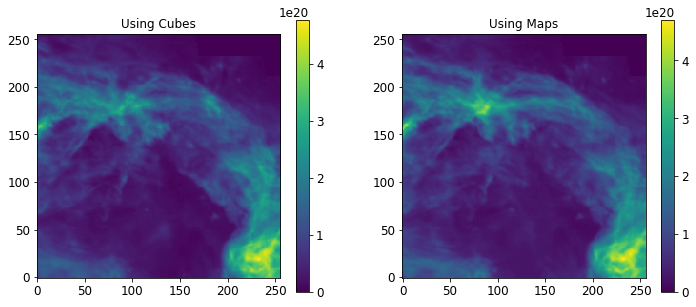

In [102]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1);plt.title("Using Cubes");plt.imshow(np.sum(mean_CNM_ls_cube, 0)*C*dv, origin='lower');plt.colorbar()
plt.subplot(1,2,2);plt.title("Using Maps");plt.imshow(mean_CNM_ls_map, origin='lower');plt.colorbar()

In [103]:
std_CNM_ls_map = np.std([CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,\
                         CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,\
                         CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,\
                         CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,\
                         CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49], 0)
std_LNM_ls_map = np.std([LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,\
                         LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,\
                         LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,\
                         LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,\
                         LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49], 0)
std_WNMa_ls_map = np.std([WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,\
                         WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,\
                         WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,\
                         WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,\
                         WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49], 0)
std_WNMd_ls_map = np.std([WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,\
                         WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,\
                         WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,\
                         WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,\
                         WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49], 0)

In [104]:
frac_std_WNMd_ls_map = np.std([frac_CNM_ls_from_maps_0,frac_CNM_ls_from_maps_1,frac_CNM_ls_from_maps_2,frac_CNM_ls_from_maps_3,frac_CNM_ls_from_maps_4,frac_CNM_ls_from_maps_5,frac_CNM_ls_from_maps_6,frac_CNM_ls_from_maps_7,frac_CNM_ls_from_maps_8,frac_CNM_ls_from_maps_9,\
                               frac_CNM_ls_from_maps_10,frac_CNM_ls_from_maps_11,frac_CNM_ls_from_maps_12,frac_CNM_ls_from_maps_13,frac_CNM_ls_from_maps_14,frac_CNM_ls_from_maps_15,frac_CNM_ls_from_maps_16,frac_CNM_ls_from_maps_17,frac_CNM_ls_from_maps_18,frac_CNM_ls_from_maps_19,\
                               frac_CNM_ls_from_maps_20,frac_CNM_ls_from_maps_21,frac_CNM_ls_from_maps_22,frac_CNM_ls_from_maps_23,frac_CNM_ls_from_maps_24,frac_CNM_ls_from_maps_25,frac_CNM_ls_from_maps_26,frac_CNM_ls_from_maps_27,frac_CNM_ls_from_maps_28,frac_CNM_ls_from_maps_29,\
                               frac_CNM_ls_from_maps_30,frac_CNM_ls_from_maps_31,frac_CNM_ls_from_maps_32,frac_CNM_ls_from_maps_33,frac_CNM_ls_from_maps_34,frac_CNM_ls_from_maps_35,frac_CNM_ls_from_maps_36,frac_CNM_ls_from_maps_37,frac_CNM_ls_from_maps_38,frac_CNM_ls_from_maps_39,\
                               frac_CNM_ls_from_maps_40,frac_CNM_ls_from_maps_41,frac_CNM_ls_from_maps_42,frac_CNM_ls_from_maps_43,frac_CNM_ls_from_maps_44,frac_CNM_ls_from_maps_45,frac_CNM_ls_from_maps_46,frac_CNM_ls_from_maps_47,frac_CNM_ls_from_maps_48,frac_CNM_ls_from_maps_49], 0)
frac_std_WNMd_ls_map = np.std([frac_LNM_ls_from_maps_0,frac_LNM_ls_from_maps_1,frac_LNM_ls_from_maps_2,frac_LNM_ls_from_maps_3,frac_LNM_ls_from_maps_4,frac_LNM_ls_from_maps_5,frac_LNM_ls_from_maps_6,frac_LNM_ls_from_maps_7,frac_LNM_ls_from_maps_8,frac_LNM_ls_from_maps_9,\
                               frac_LNM_ls_from_maps_10,frac_LNM_ls_from_maps_11,frac_LNM_ls_from_maps_12,frac_LNM_ls_from_maps_13,frac_LNM_ls_from_maps_14,frac_LNM_ls_from_maps_15,frac_LNM_ls_from_maps_16,frac_LNM_ls_from_maps_17,frac_LNM_ls_from_maps_18,frac_LNM_ls_from_maps_19,\
                               frac_LNM_ls_from_maps_20,frac_LNM_ls_from_maps_21,frac_LNM_ls_from_maps_22,frac_LNM_ls_from_maps_23,frac_LNM_ls_from_maps_24,frac_LNM_ls_from_maps_25,frac_LNM_ls_from_maps_26,frac_LNM_ls_from_maps_27,frac_LNM_ls_from_maps_28,frac_LNM_ls_from_maps_29,\
                               frac_LNM_ls_from_maps_30,frac_LNM_ls_from_maps_31,frac_LNM_ls_from_maps_32,frac_LNM_ls_from_maps_33,frac_LNM_ls_from_maps_34,frac_LNM_ls_from_maps_35,frac_LNM_ls_from_maps_36,frac_LNM_ls_from_maps_37,frac_LNM_ls_from_maps_38,frac_LNM_ls_from_maps_39,\
                               frac_LNM_ls_from_maps_40,frac_LNM_ls_from_maps_41,frac_LNM_ls_from_maps_42,frac_LNM_ls_from_maps_43,frac_LNM_ls_from_maps_44,frac_LNM_ls_from_maps_45,frac_LNM_ls_from_maps_46,frac_LNM_ls_from_maps_47,frac_LNM_ls_from_maps_48,frac_LNM_ls_from_maps_49], 0)
frac_std_WNMd_ls_map = np.std([frac_WNMa_ls_from_maps_0,frac_WNMa_ls_from_maps_1,frac_WNMa_ls_from_maps_2,frac_WNMa_ls_from_maps_3,frac_WNMa_ls_from_maps_4,frac_WNMa_ls_from_maps_5,frac_WNMa_ls_from_maps_6,frac_WNMa_ls_from_maps_7,frac_WNMa_ls_from_maps_8,frac_WNMa_ls_from_maps_9,\
                               frac_WNMa_ls_from_maps_10,frac_WNMa_ls_from_maps_11,frac_WNMa_ls_from_maps_12,frac_WNMa_ls_from_maps_13,frac_WNMa_ls_from_maps_14,frac_WNMa_ls_from_maps_15,frac_WNMa_ls_from_maps_16,frac_WNMa_ls_from_maps_17,frac_WNMa_ls_from_maps_18,frac_WNMa_ls_from_maps_19,\
                               frac_WNMa_ls_from_maps_20,frac_WNMa_ls_from_maps_21,frac_WNMa_ls_from_maps_22,frac_WNMa_ls_from_maps_23,frac_WNMa_ls_from_maps_24,frac_WNMa_ls_from_maps_25,frac_WNMa_ls_from_maps_26,frac_WNMa_ls_from_maps_27,frac_WNMa_ls_from_maps_28,frac_WNMa_ls_from_maps_29,\
                               frac_WNMa_ls_from_maps_30,frac_WNMa_ls_from_maps_31,frac_WNMa_ls_from_maps_32,frac_WNMa_ls_from_maps_33,frac_WNMa_ls_from_maps_34,frac_WNMa_ls_from_maps_35,frac_WNMa_ls_from_maps_36,frac_WNMa_ls_from_maps_37,frac_WNMa_ls_from_maps_38,frac_WNMa_ls_from_maps_39,\
                               frac_WNMa_ls_from_maps_40,frac_WNMa_ls_from_maps_41,frac_WNMa_ls_from_maps_42,frac_WNMa_ls_from_maps_43,frac_WNMa_ls_from_maps_44,frac_WNMa_ls_from_maps_45,frac_WNMa_ls_from_maps_46,frac_WNMa_ls_from_maps_47,frac_WNMa_ls_from_maps_48,frac_WNMa_ls_from_maps_49], 0)
frac_std_WNMd_ls_map = np.std([frac_WNMd_ls_from_maps_0,frac_WNMd_ls_from_maps_1,frac_WNMd_ls_from_maps_2,frac_WNMd_ls_from_maps_3,frac_WNMd_ls_from_maps_4,frac_WNMd_ls_from_maps_5,frac_WNMd_ls_from_maps_6,frac_WNMd_ls_from_maps_7,frac_WNMd_ls_from_maps_8,frac_WNMd_ls_from_maps_9,\
                               frac_WNMd_ls_from_maps_10,frac_WNMd_ls_from_maps_11,frac_WNMd_ls_from_maps_12,frac_WNMd_ls_from_maps_13,frac_WNMd_ls_from_maps_14,frac_WNMd_ls_from_maps_15,frac_WNMd_ls_from_maps_16,frac_WNMd_ls_from_maps_17,frac_WNMd_ls_from_maps_18,frac_WNMd_ls_from_maps_19,\
                               frac_WNMd_ls_from_maps_20,frac_WNMd_ls_from_maps_21,frac_WNMd_ls_from_maps_22,frac_WNMd_ls_from_maps_23,frac_WNMd_ls_from_maps_24,frac_WNMd_ls_from_maps_25,frac_WNMd_ls_from_maps_26,frac_WNMd_ls_from_maps_27,frac_WNMd_ls_from_maps_28,frac_WNMd_ls_from_maps_29,\
                               frac_WNMd_ls_from_maps_30,frac_WNMd_ls_from_maps_31,frac_WNMd_ls_from_maps_32,frac_WNMd_ls_from_maps_33,frac_WNMd_ls_from_maps_34,frac_WNMd_ls_from_maps_35,frac_WNMd_ls_from_maps_36,frac_WNMd_ls_from_maps_37,frac_WNMd_ls_from_maps_38,frac_WNMd_ls_from_maps_39,\
                               frac_WNMd_ls_from_maps_40,frac_WNMd_ls_from_maps_41,frac_WNMd_ls_from_maps_42,frac_WNMd_ls_from_maps_43,frac_WNMd_ls_from_maps_44,frac_WNMd_ls_from_maps_45,frac_WNMd_ls_from_maps_46,frac_WNMd_ls_from_maps_47,frac_WNMd_ls_from_maps_48,frac_WNMd_ls_from_maps_49], 0)

PPV Cubes for from sigma v

In [105]:
CNM_list0,LNM_list0,WNMa_list0,WNMd_list0,CNM_sv_map0,LNM_sv_map0,WNMa_sv_map0,WNMd_sv_map0=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[0],dispersion_multi_from_sigma_v[0],NHI_map_multi_from_sigma_v[0])
CNM_list1,LNM_list1,WNMa_list1,WNMd_list1,CNM_sv_map1,LNM_sv_map1,WNMa_sv_map1,WNMd_sv_map1=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[1],dispersion_multi_from_sigma_v[1],NHI_map_multi_from_sigma_v[1])
CNM_list2,LNM_list2,WNMa_list2,WNMd_list2,CNM_sv_map2,LNM_sv_map2,WNMa_sv_map2,WNMd_sv_map2=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[2],dispersion_multi_from_sigma_v[2],NHI_map_multi_from_sigma_v[2])
CNM_list3,LNM_list3,WNMa_list3,WNMd_list3,CNM_sv_map3,LNM_sv_map3,WNMa_sv_map3,WNMd_sv_map3=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[3],dispersion_multi_from_sigma_v[3],NHI_map_multi_from_sigma_v[3])
CNM_list4,LNM_list4,WNMa_list4,WNMd_list4,CNM_sv_map4,LNM_sv_map4,WNMa_sv_map4,WNMd_sv_map4=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[4],dispersion_multi_from_sigma_v[4],NHI_map_multi_from_sigma_v[4])
CNM_list5,LNM_list5,WNMa_list5,WNMd_list5,CNM_sv_map5,LNM_sv_map5,WNMa_sv_map5,WNMd_sv_map5=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[5],dispersion_multi_from_sigma_v[5],NHI_map_multi_from_sigma_v[5])
CNM_list6,LNM_list6,WNMa_list6,WNMd_list6,CNM_sv_map6,LNM_sv_map6,WNMa_sv_map6,WNMd_sv_map6=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[6],dispersion_multi_from_sigma_v[6],NHI_map_multi_from_sigma_v[6])
CNM_list7,LNM_list7,WNMa_list7,WNMd_list7,CNM_sv_map7,LNM_sv_map7,WNMa_sv_map7,WNMd_sv_map7=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[7],dispersion_multi_from_sigma_v[7],NHI_map_multi_from_sigma_v[7])
CNM_list8,LNM_list8,WNMa_list8,WNMd_list8,CNM_sv_map8,LNM_sv_map8,WNMa_sv_map8,WNMd_sv_map8=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[8],dispersion_multi_from_sigma_v[8],NHI_map_multi_from_sigma_v[8])
CNM_list9,LNM_list9,WNMa_list9,WNMd_list9,CNM_sv_map9,LNM_sv_map9,WNMa_sv_map9,WNMd_sv_map9=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[9],dispersion_multi_from_sigma_v[9],NHI_map_multi_from_sigma_v[9])
CNM_list10,LNM_list10,WNMa_list10,WNMd_list10,CNM_sv_map10,LNM_sv_map10,WNMa_sv_map10,WNMd_sv_map10=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[10],dispersion_multi_from_sigma_v[10],NHI_map_multi_from_sigma_v[10])
CNM_list11,LNM_list11,WNMa_list11,WNMd_list11,CNM_sv_map11,LNM_sv_map11,WNMa_sv_map11,WNMd_sv_map11=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[11],dispersion_multi_from_sigma_v[11],NHI_map_multi_from_sigma_v[11])
CNM_list12,LNM_list12,WNMa_list12,WNMd_list12,CNM_sv_map12,LNM_sv_map12,WNMa_sv_map12,WNMd_sv_map12=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[12],dispersion_multi_from_sigma_v[12],NHI_map_multi_from_sigma_v[12])
CNM_list13,LNM_list13,WNMa_list13,WNMd_list13,CNM_sv_map13,LNM_sv_map13,WNMa_sv_map13,WNMd_sv_map13=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[13],dispersion_multi_from_sigma_v[13],NHI_map_multi_from_sigma_v[13])
CNM_list14,LNM_list14,WNMa_list14,WNMd_list14,CNM_sv_map14,LNM_sv_map14,WNMa_sv_map14,WNMd_sv_map14=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[14],dispersion_multi_from_sigma_v[14],NHI_map_multi_from_sigma_v[14])
CNM_list15,LNM_list15,WNMa_list15,WNMd_list15,CNM_sv_map15,LNM_sv_map15,WNMa_sv_map15,WNMd_sv_map15=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[15],dispersion_multi_from_sigma_v[15],NHI_map_multi_from_sigma_v[15])
CNM_list16,LNM_list16,WNMa_list16,WNMd_list16,CNM_sv_map16,LNM_sv_map16,WNMa_sv_map16,WNMd_sv_map16=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[16],dispersion_multi_from_sigma_v[16],NHI_map_multi_from_sigma_v[16])
CNM_list17,LNM_list17,WNMa_list17,WNMd_list17,CNM_sv_map17,LNM_sv_map17,WNMa_sv_map17,WNMd_sv_map17=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[17],dispersion_multi_from_sigma_v[17],NHI_map_multi_from_sigma_v[17])
CNM_list18,LNM_list18,WNMa_list18,WNMd_list18,CNM_sv_map18,LNM_sv_map18,WNMa_sv_map18,WNMd_sv_map18=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[18],dispersion_multi_from_sigma_v[18],NHI_map_multi_from_sigma_v[18])
CNM_list19,LNM_list19,WNMa_list19,WNMd_list19,CNM_sv_map19,LNM_sv_map19,WNMa_sv_map19,WNMd_sv_map19=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[19],dispersion_multi_from_sigma_v[19],NHI_map_multi_from_sigma_v[19])
CNM_list20,LNM_list20,WNMa_list20,WNMd_list20,CNM_sv_map20,LNM_sv_map20,WNMa_sv_map20,WNMd_sv_map20=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[20],dispersion_multi_from_sigma_v[20],NHI_map_multi_from_sigma_v[20])
CNM_list21,LNM_list21,WNMa_list21,WNMd_list21,CNM_sv_map21,LNM_sv_map21,WNMa_sv_map21,WNMd_sv_map21=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[21],dispersion_multi_from_sigma_v[21],NHI_map_multi_from_sigma_v[21])
CNM_list22,LNM_list22,WNMa_list22,WNMd_list22,CNM_sv_map22,LNM_sv_map22,WNMa_sv_map22,WNMd_sv_map22=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[22],dispersion_multi_from_sigma_v[22],NHI_map_multi_from_sigma_v[22])
CNM_list23,LNM_list23,WNMa_list23,WNMd_list23,CNM_sv_map23,LNM_sv_map23,WNMa_sv_map23,WNMd_sv_map23=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[23],dispersion_multi_from_sigma_v[23],NHI_map_multi_from_sigma_v[23])
CNM_list24,LNM_list24,WNMa_list24,WNMd_list24,CNM_sv_map24,LNM_sv_map24,WNMa_sv_map24,WNMd_sv_map24=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[24],dispersion_multi_from_sigma_v[24],NHI_map_multi_from_sigma_v[24])
CNM_list25,LNM_list25,WNMa_list25,WNMd_list25,CNM_sv_map25,LNM_sv_map25,WNMa_sv_map25,WNMd_sv_map25=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[25],dispersion_multi_from_sigma_v[25],NHI_map_multi_from_sigma_v[25])
CNM_list26,LNM_list26,WNMa_list26,WNMd_list26,CNM_sv_map26,LNM_sv_map26,WNMa_sv_map26,WNMd_sv_map26=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[26],dispersion_multi_from_sigma_v[26],NHI_map_multi_from_sigma_v[26])
CNM_list27,LNM_list27,WNMa_list27,WNMd_list27,CNM_sv_map27,LNM_sv_map27,WNMa_sv_map27,WNMd_sv_map27=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[27],dispersion_multi_from_sigma_v[27],NHI_map_multi_from_sigma_v[27])
CNM_list28,LNM_list28,WNMa_list28,WNMd_list28,CNM_sv_map28,LNM_sv_map28,WNMa_sv_map28,WNMd_sv_map28=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[28],dispersion_multi_from_sigma_v[28],NHI_map_multi_from_sigma_v[28])
CNM_list29,LNM_list29,WNMa_list29,WNMd_list29,CNM_sv_map29,LNM_sv_map29,WNMa_sv_map29,WNMd_sv_map29=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[29],dispersion_multi_from_sigma_v[29],NHI_map_multi_from_sigma_v[29])
CNM_list30,LNM_list30,WNMa_list30,WNMd_list30,CNM_sv_map30,LNM_sv_map30,WNMa_sv_map30,WNMd_sv_map30=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[30],dispersion_multi_from_sigma_v[30],NHI_map_multi_from_sigma_v[30])
CNM_list31,LNM_list31,WNMa_list31,WNMd_list31,CNM_sv_map31,LNM_sv_map31,WNMa_sv_map31,WNMd_sv_map31=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[31],dispersion_multi_from_sigma_v[31],NHI_map_multi_from_sigma_v[31])
CNM_list32,LNM_list32,WNMa_list32,WNMd_list32,CNM_sv_map32,LNM_sv_map32,WNMa_sv_map32,WNMd_sv_map32=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[32],dispersion_multi_from_sigma_v[32],NHI_map_multi_from_sigma_v[32])
CNM_list33,LNM_list33,WNMa_list33,WNMd_list33,CNM_sv_map33,LNM_sv_map33,WNMa_sv_map33,WNMd_sv_map33=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[33],dispersion_multi_from_sigma_v[33],NHI_map_multi_from_sigma_v[33])
CNM_list34,LNM_list34,WNMa_list34,WNMd_list34,CNM_sv_map34,LNM_sv_map34,WNMa_sv_map34,WNMd_sv_map34=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[34],dispersion_multi_from_sigma_v[34],NHI_map_multi_from_sigma_v[34])
CNM_list35,LNM_list35,WNMa_list35,WNMd_list35,CNM_sv_map35,LNM_sv_map35,WNMa_sv_map35,WNMd_sv_map35=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[35],dispersion_multi_from_sigma_v[35],NHI_map_multi_from_sigma_v[35])
CNM_list36,LNM_list36,WNMa_list36,WNMd_list36,CNM_sv_map36,LNM_sv_map36,WNMa_sv_map36,WNMd_sv_map36=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[36],dispersion_multi_from_sigma_v[36],NHI_map_multi_from_sigma_v[36])
CNM_list37,LNM_list37,WNMa_list37,WNMd_list37,CNM_sv_map37,LNM_sv_map37,WNMa_sv_map37,WNMd_sv_map37=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[37],dispersion_multi_from_sigma_v[37],NHI_map_multi_from_sigma_v[37])
CNM_list38,LNM_list38,WNMa_list38,WNMd_list38,CNM_sv_map38,LNM_sv_map38,WNMa_sv_map38,WNMd_sv_map38=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[38],dispersion_multi_from_sigma_v[38],NHI_map_multi_from_sigma_v[38])
CNM_list39,LNM_list39,WNMa_list39,WNMd_list39,CNM_sv_map39,LNM_sv_map39,WNMa_sv_map39,WNMd_sv_map39=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[39],dispersion_multi_from_sigma_v[39],NHI_map_multi_from_sigma_v[39])
CNM_list40,LNM_list40,WNMa_list40,WNMd_list40,CNM_sv_map40,LNM_sv_map40,WNMa_sv_map40,WNMd_sv_map40=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[40],dispersion_multi_from_sigma_v[40],NHI_map_multi_from_sigma_v[40])
CNM_list41,LNM_list41,WNMa_list41,WNMd_list41,CNM_sv_map41,LNM_sv_map41,WNMa_sv_map41,WNMd_sv_map41=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[41],dispersion_multi_from_sigma_v[41],NHI_map_multi_from_sigma_v[41])
CNM_list42,LNM_list42,WNMa_list42,WNMd_list42,CNM_sv_map42,LNM_sv_map42,WNMa_sv_map42,WNMd_sv_map42=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[42],dispersion_multi_from_sigma_v[42],NHI_map_multi_from_sigma_v[42])
CNM_list43,LNM_list43,WNMa_list43,WNMd_list43,CNM_sv_map43,LNM_sv_map43,WNMa_sv_map43,WNMd_sv_map43=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[43],dispersion_multi_from_sigma_v[43],NHI_map_multi_from_sigma_v[43])
CNM_list44,LNM_list44,WNMa_list44,WNMd_list44,CNM_sv_map44,LNM_sv_map44,WNMa_sv_map44,WNMd_sv_map44=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[44],dispersion_multi_from_sigma_v[44],NHI_map_multi_from_sigma_v[44])
CNM_list45,LNM_list45,WNMa_list45,WNMd_list45,CNM_sv_map45,LNM_sv_map45,WNMa_sv_map45,WNMd_sv_map45=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[45],dispersion_multi_from_sigma_v[45],NHI_map_multi_from_sigma_v[45])
CNM_list46,LNM_list46,WNMa_list46,WNMd_list46,CNM_sv_map46,LNM_sv_map46,WNMa_sv_map46,WNMd_sv_map46=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[46],dispersion_multi_from_sigma_v[46],NHI_map_multi_from_sigma_v[46])
CNM_list47,LNM_list47,WNMa_list47,WNMd_list47,CNM_sv_map47,LNM_sv_map47,WNMa_sv_map47,WNMd_sv_map47=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[47],dispersion_multi_from_sigma_v[47],NHI_map_multi_from_sigma_v[47])
CNM_list48,LNM_list48,WNMa_list48,WNMd_list48,CNM_sv_map48,LNM_sv_map48,WNMa_sv_map48,WNMd_sv_map48=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[48],dispersion_multi_from_sigma_v[48],NHI_map_multi_from_sigma_v[48])
CNM_list49,LNM_list49,WNMa_list49,WNMd_list49,CNM_sv_map49,LNM_sv_map49,WNMa_sv_map49,WNMd_sv_map49=phase_maps_comp_by_comp(CNM_LNM_bound,LNM_WNM_bound,LVC_cube_base,n_gauss,position_multi_from_sigma_v[49],dispersion_multi_from_sigma_v[49],NHI_map_multi_from_sigma_v[49])

In [106]:
model_CNM_sv_0, model_LNM_sv_0, model_WNMa_sv_0, model_WNMd_sv_0 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[0], dispersion_multi_from_sigma_v[0], amplitude_pix_multi_from_sigma_v[0], position_pix_multi_from_sigma_v[0], dispersion_pix_multi_from_sigma_v[0], CNM_list0, LNM_list0, WNMa_list0, WNMd_list0)
model_CNM_sv_1, model_LNM_sv_1, model_WNMa_sv_1, model_WNMd_sv_1 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[1], dispersion_multi_from_sigma_v[1], amplitude_pix_multi_from_sigma_v[1], position_pix_multi_from_sigma_v[1], dispersion_pix_multi_from_sigma_v[1], CNM_list1, LNM_list1, WNMa_list1, WNMd_list1)
model_CNM_sv_2, model_LNM_sv_2, model_WNMa_sv_2, model_WNMd_sv_2 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[2], dispersion_multi_from_sigma_v[2], amplitude_pix_multi_from_sigma_v[2], position_pix_multi_from_sigma_v[2], dispersion_pix_multi_from_sigma_v[2], CNM_list2, LNM_list2, WNMa_list2, WNMd_list2)
model_CNM_sv_3, model_LNM_sv_3, model_WNMa_sv_3, model_WNMd_sv_3 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[3], dispersion_multi_from_sigma_v[3], amplitude_pix_multi_from_sigma_v[3], position_pix_multi_from_sigma_v[3], dispersion_pix_multi_from_sigma_v[3], CNM_list3, LNM_list3, WNMa_list3, WNMd_list3)
model_CNM_sv_4, model_LNM_sv_4, model_WNMa_sv_4, model_WNMd_sv_4 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[4], dispersion_multi_from_sigma_v[4], amplitude_pix_multi_from_sigma_v[4], position_pix_multi_from_sigma_v[4], dispersion_pix_multi_from_sigma_v[4], CNM_list4, LNM_list4, WNMa_list4, WNMd_list4)
model_CNM_sv_5, model_LNM_sv_5, model_WNMa_sv_5, model_WNMd_sv_5 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[5], dispersion_multi_from_sigma_v[5], amplitude_pix_multi_from_sigma_v[5], position_pix_multi_from_sigma_v[5], dispersion_pix_multi_from_sigma_v[5], CNM_list5, LNM_list5, WNMa_list5, WNMd_list5)
model_CNM_sv_6, model_LNM_sv_6, model_WNMa_sv_6, model_WNMd_sv_6 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[6], dispersion_multi_from_sigma_v[6], amplitude_pix_multi_from_sigma_v[6], position_pix_multi_from_sigma_v[6], dispersion_pix_multi_from_sigma_v[6], CNM_list6, LNM_list6, WNMa_list6, WNMd_list6)
model_CNM_sv_7, model_LNM_sv_7, model_WNMa_sv_7, model_WNMd_sv_7 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[7], dispersion_multi_from_sigma_v[7], amplitude_pix_multi_from_sigma_v[7], position_pix_multi_from_sigma_v[7], dispersion_pix_multi_from_sigma_v[7], CNM_list7, LNM_list7, WNMa_list7, WNMd_list7)
model_CNM_sv_8, model_LNM_sv_8, model_WNMa_sv_8, model_WNMd_sv_8 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[8], dispersion_multi_from_sigma_v[8], amplitude_pix_multi_from_sigma_v[8], position_pix_multi_from_sigma_v[8], dispersion_pix_multi_from_sigma_v[8], CNM_list8, LNM_list8, WNMa_list8, WNMd_list8)
model_CNM_sv_9, model_LNM_sv_9, model_WNMa_sv_9, model_WNMd_sv_9 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[9], dispersion_multi_from_sigma_v[9], amplitude_pix_multi_from_sigma_v[9], position_pix_multi_from_sigma_v[9], dispersion_pix_multi_from_sigma_v[9], CNM_list9, LNM_list9, WNMa_list9, WNMd_list9)
model_CNM_sv_10, model_LNM_sv_10, model_WNMa_sv_10, model_WNMd_sv_10 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[10], dispersion_multi_from_sigma_v[10], amplitude_pix_multi_from_sigma_v[10], position_pix_multi_from_sigma_v[10], dispersion_pix_multi_from_sigma_v[10], CNM_list10, LNM_list10, WNMa_list10, WNMd_list10)
model_CNM_sv_11, model_LNM_sv_11, model_WNMa_sv_11, model_WNMd_sv_11 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[11], dispersion_multi_from_sigma_v[11], amplitude_pix_multi_from_sigma_v[11], position_pix_multi_from_sigma_v[11], dispersion_pix_multi_from_sigma_v[11], CNM_list11, LNM_list11, WNMa_list11, WNMd_list11)
model_CNM_sv_12, model_LNM_sv_12, model_WNMa_sv_12, model_WNMd_sv_12 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[12], dispersion_multi_from_sigma_v[12], amplitude_pix_multi_from_sigma_v[12], position_pix_multi_from_sigma_v[12], dispersion_pix_multi_from_sigma_v[12], CNM_list12, LNM_list12, WNMa_list12, WNMd_list12)
model_CNM_sv_13, model_LNM_sv_13, model_WNMa_sv_13, model_WNMd_sv_13 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[13], dispersion_multi_from_sigma_v[13], amplitude_pix_multi_from_sigma_v[13], position_pix_multi_from_sigma_v[13], dispersion_pix_multi_from_sigma_v[13], CNM_list13, LNM_list13, WNMa_list13, WNMd_list13)
model_CNM_sv_14, model_LNM_sv_14, model_WNMa_sv_14, model_WNMd_sv_14 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[14], dispersion_multi_from_sigma_v[14], amplitude_pix_multi_from_sigma_v[14], position_pix_multi_from_sigma_v[14], dispersion_pix_multi_from_sigma_v[14], CNM_list14, LNM_list14, WNMa_list14, WNMd_list14)
model_CNM_sv_15, model_LNM_sv_15, model_WNMa_sv_15, model_WNMd_sv_15 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[15], dispersion_multi_from_sigma_v[15], amplitude_pix_multi_from_sigma_v[15], position_pix_multi_from_sigma_v[15], dispersion_pix_multi_from_sigma_v[15], CNM_list15, LNM_list15, WNMa_list15, WNMd_list15)
model_CNM_sv_16, model_LNM_sv_16, model_WNMa_sv_16, model_WNMd_sv_16 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[16], dispersion_multi_from_sigma_v[16], amplitude_pix_multi_from_sigma_v[16], position_pix_multi_from_sigma_v[16], dispersion_pix_multi_from_sigma_v[16], CNM_list16, LNM_list16, WNMa_list16, WNMd_list16)
model_CNM_sv_17, model_LNM_sv_17, model_WNMa_sv_17, model_WNMd_sv_17 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[17], dispersion_multi_from_sigma_v[17], amplitude_pix_multi_from_sigma_v[17], position_pix_multi_from_sigma_v[17], dispersion_pix_multi_from_sigma_v[17], CNM_list17, LNM_list17, WNMa_list17, WNMd_list17)
model_CNM_sv_18, model_LNM_sv_18, model_WNMa_sv_18, model_WNMd_sv_18 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[18], dispersion_multi_from_sigma_v[18], amplitude_pix_multi_from_sigma_v[18], position_pix_multi_from_sigma_v[18], dispersion_pix_multi_from_sigma_v[18], CNM_list18, LNM_list18, WNMa_list18, WNMd_list18)
model_CNM_sv_19, model_LNM_sv_19, model_WNMa_sv_19, model_WNMd_sv_19 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[19], dispersion_multi_from_sigma_v[19], amplitude_pix_multi_from_sigma_v[19], position_pix_multi_from_sigma_v[19], dispersion_pix_multi_from_sigma_v[19], CNM_list19, LNM_list19, WNMa_list19, WNMd_list19)
model_CNM_sv_20, model_LNM_sv_20, model_WNMa_sv_20, model_WNMd_sv_20 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[20], dispersion_multi_from_sigma_v[20], amplitude_pix_multi_from_sigma_v[20], position_pix_multi_from_sigma_v[20], dispersion_pix_multi_from_sigma_v[20], CNM_list20, LNM_list20, WNMa_list20, WNMd_list20)
model_CNM_sv_21, model_LNM_sv_21, model_WNMa_sv_21, model_WNMd_sv_21 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[21], dispersion_multi_from_sigma_v[21], amplitude_pix_multi_from_sigma_v[21], position_pix_multi_from_sigma_v[21], dispersion_pix_multi_from_sigma_v[21], CNM_list21, LNM_list21, WNMa_list21, WNMd_list21)
model_CNM_sv_22, model_LNM_sv_22, model_WNMa_sv_22, model_WNMd_sv_22 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[22], dispersion_multi_from_sigma_v[22], amplitude_pix_multi_from_sigma_v[22], position_pix_multi_from_sigma_v[22], dispersion_pix_multi_from_sigma_v[22], CNM_list22, LNM_list22, WNMa_list22, WNMd_list22)
model_CNM_sv_23, model_LNM_sv_23, model_WNMa_sv_23, model_WNMd_sv_23 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[23], dispersion_multi_from_sigma_v[23], amplitude_pix_multi_from_sigma_v[23], position_pix_multi_from_sigma_v[23], dispersion_pix_multi_from_sigma_v[23], CNM_list23, LNM_list23, WNMa_list23, WNMd_list23)
model_CNM_sv_24, model_LNM_sv_24, model_WNMa_sv_24, model_WNMd_sv_24 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[24], dispersion_multi_from_sigma_v[24], amplitude_pix_multi_from_sigma_v[24], position_pix_multi_from_sigma_v[24], dispersion_pix_multi_from_sigma_v[24], CNM_list24, LNM_list24, WNMa_list24, WNMd_list24)
model_CNM_sv_25, model_LNM_sv_25, model_WNMa_sv_25, model_WNMd_sv_25 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[25], dispersion_multi_from_sigma_v[25], amplitude_pix_multi_from_sigma_v[25], position_pix_multi_from_sigma_v[25], dispersion_pix_multi_from_sigma_v[25], CNM_list25, LNM_list25, WNMa_list25, WNMd_list25)
model_CNM_sv_26, model_LNM_sv_26, model_WNMa_sv_26, model_WNMd_sv_26 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[26], dispersion_multi_from_sigma_v[26], amplitude_pix_multi_from_sigma_v[26], position_pix_multi_from_sigma_v[26], dispersion_pix_multi_from_sigma_v[26], CNM_list26, LNM_list26, WNMa_list26, WNMd_list26)
model_CNM_sv_27, model_LNM_sv_27, model_WNMa_sv_27, model_WNMd_sv_27 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[27], dispersion_multi_from_sigma_v[27], amplitude_pix_multi_from_sigma_v[27], position_pix_multi_from_sigma_v[27], dispersion_pix_multi_from_sigma_v[27], CNM_list27, LNM_list27, WNMa_list27, WNMd_list27)
model_CNM_sv_28, model_LNM_sv_28, model_WNMa_sv_28, model_WNMd_sv_28 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[28], dispersion_multi_from_sigma_v[28], amplitude_pix_multi_from_sigma_v[28], position_pix_multi_from_sigma_v[28], dispersion_pix_multi_from_sigma_v[28], CNM_list28, LNM_list28, WNMa_list28, WNMd_list28)
model_CNM_sv_29, model_LNM_sv_29, model_WNMa_sv_29, model_WNMd_sv_29 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[29], dispersion_multi_from_sigma_v[29], amplitude_pix_multi_from_sigma_v[29], position_pix_multi_from_sigma_v[29], dispersion_pix_multi_from_sigma_v[29], CNM_list29, LNM_list29, WNMa_list29, WNMd_list29)
model_CNM_sv_30, model_LNM_sv_30, model_WNMa_sv_30, model_WNMd_sv_30 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[30], dispersion_multi_from_sigma_v[30], amplitude_pix_multi_from_sigma_v[30], position_pix_multi_from_sigma_v[30], dispersion_pix_multi_from_sigma_v[30], CNM_list30, LNM_list30, WNMa_list30, WNMd_list30)
model_CNM_sv_31, model_LNM_sv_31, model_WNMa_sv_31, model_WNMd_sv_31 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[31], dispersion_multi_from_sigma_v[31], amplitude_pix_multi_from_sigma_v[31], position_pix_multi_from_sigma_v[31], dispersion_pix_multi_from_sigma_v[31], CNM_list31, LNM_list31, WNMa_list31, WNMd_list31)
model_CNM_sv_32, model_LNM_sv_32, model_WNMa_sv_32, model_WNMd_sv_32 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[32], dispersion_multi_from_sigma_v[32], amplitude_pix_multi_from_sigma_v[32], position_pix_multi_from_sigma_v[32], dispersion_pix_multi_from_sigma_v[32], CNM_list32, LNM_list32, WNMa_list32, WNMd_list32)
model_CNM_sv_33, model_LNM_sv_33, model_WNMa_sv_33, model_WNMd_sv_33 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[33], dispersion_multi_from_sigma_v[33], amplitude_pix_multi_from_sigma_v[33], position_pix_multi_from_sigma_v[33], dispersion_pix_multi_from_sigma_v[33], CNM_list33, LNM_list33, WNMa_list33, WNMd_list33)
model_CNM_sv_34, model_LNM_sv_34, model_WNMa_sv_34, model_WNMd_sv_34 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[34], dispersion_multi_from_sigma_v[34], amplitude_pix_multi_from_sigma_v[34], position_pix_multi_from_sigma_v[34], dispersion_pix_multi_from_sigma_v[34], CNM_list34, LNM_list34, WNMa_list34, WNMd_list34)
model_CNM_sv_35, model_LNM_sv_35, model_WNMa_sv_35, model_WNMd_sv_35 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[35], dispersion_multi_from_sigma_v[35], amplitude_pix_multi_from_sigma_v[35], position_pix_multi_from_sigma_v[35], dispersion_pix_multi_from_sigma_v[35], CNM_list35, LNM_list35, WNMa_list35, WNMd_list35)
model_CNM_sv_36, model_LNM_sv_36, model_WNMa_sv_36, model_WNMd_sv_36 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[36], dispersion_multi_from_sigma_v[36], amplitude_pix_multi_from_sigma_v[36], position_pix_multi_from_sigma_v[36], dispersion_pix_multi_from_sigma_v[36], CNM_list36, LNM_list36, WNMa_list36, WNMd_list36)
model_CNM_sv_37, model_LNM_sv_37, model_WNMa_sv_37, model_WNMd_sv_37 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[37], dispersion_multi_from_sigma_v[37], amplitude_pix_multi_from_sigma_v[37], position_pix_multi_from_sigma_v[37], dispersion_pix_multi_from_sigma_v[37], CNM_list37, LNM_list37, WNMa_list37, WNMd_list37)
model_CNM_sv_38, model_LNM_sv_38, model_WNMa_sv_38, model_WNMd_sv_38 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[38], dispersion_multi_from_sigma_v[38], amplitude_pix_multi_from_sigma_v[38], position_pix_multi_from_sigma_v[38], dispersion_pix_multi_from_sigma_v[38], CNM_list38, LNM_list38, WNMa_list38, WNMd_list38)
model_CNM_sv_39, model_LNM_sv_39, model_WNMa_sv_39, model_WNMd_sv_39 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[39], dispersion_multi_from_sigma_v[39], amplitude_pix_multi_from_sigma_v[39], position_pix_multi_from_sigma_v[39], dispersion_pix_multi_from_sigma_v[39], CNM_list39, LNM_list39, WNMa_list39, WNMd_list39)
model_CNM_sv_40, model_LNM_sv_40, model_WNMa_sv_40, model_WNMd_sv_40 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[40], dispersion_multi_from_sigma_v[40], amplitude_pix_multi_from_sigma_v[40], position_pix_multi_from_sigma_v[40], dispersion_pix_multi_from_sigma_v[40], CNM_list40, LNM_list40, WNMa_list40, WNMd_list40)
model_CNM_sv_41, model_LNM_sv_41, model_WNMa_sv_41, model_WNMd_sv_41 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[41], dispersion_multi_from_sigma_v[41], amplitude_pix_multi_from_sigma_v[41], position_pix_multi_from_sigma_v[41], dispersion_pix_multi_from_sigma_v[41], CNM_list41, LNM_list41, WNMa_list41, WNMd_list41)
model_CNM_sv_42, model_LNM_sv_42, model_WNMa_sv_42, model_WNMd_sv_42 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[42], dispersion_multi_from_sigma_v[42], amplitude_pix_multi_from_sigma_v[42], position_pix_multi_from_sigma_v[42], dispersion_pix_multi_from_sigma_v[42], CNM_list42, LNM_list42, WNMa_list42, WNMd_list42)
model_CNM_sv_43, model_LNM_sv_43, model_WNMa_sv_43, model_WNMd_sv_43 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[43], dispersion_multi_from_sigma_v[43], amplitude_pix_multi_from_sigma_v[43], position_pix_multi_from_sigma_v[43], dispersion_pix_multi_from_sigma_v[43], CNM_list43, LNM_list43, WNMa_list43, WNMd_list43)
model_CNM_sv_44, model_LNM_sv_44, model_WNMa_sv_44, model_WNMd_sv_44 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[44], dispersion_multi_from_sigma_v[44], amplitude_pix_multi_from_sigma_v[44], position_pix_multi_from_sigma_v[44], dispersion_pix_multi_from_sigma_v[44], CNM_list44, LNM_list44, WNMa_list44, WNMd_list44)
model_CNM_sv_45, model_LNM_sv_45, model_WNMa_sv_45, model_WNMd_sv_45 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[45], dispersion_multi_from_sigma_v[45], amplitude_pix_multi_from_sigma_v[45], position_pix_multi_from_sigma_v[45], dispersion_pix_multi_from_sigma_v[45], CNM_list45, LNM_list45, WNMa_list45, WNMd_list45)
model_CNM_sv_46, model_LNM_sv_46, model_WNMa_sv_46, model_WNMd_sv_46 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[46], dispersion_multi_from_sigma_v[46], amplitude_pix_multi_from_sigma_v[46], position_pix_multi_from_sigma_v[46], dispersion_pix_multi_from_sigma_v[46], CNM_list46, LNM_list46, WNMa_list46, WNMd_list46)
model_CNM_sv_47, model_LNM_sv_47, model_WNMa_sv_47, model_WNMd_sv_47 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[47], dispersion_multi_from_sigma_v[47], amplitude_pix_multi_from_sigma_v[47], position_pix_multi_from_sigma_v[47], dispersion_pix_multi_from_sigma_v[47], CNM_list47, LNM_list47, WNMa_list47, WNMd_list47)
model_CNM_sv_48, model_LNM_sv_48, model_WNMa_sv_48, model_WNMd_sv_48 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[48], dispersion_multi_from_sigma_v[48], amplitude_pix_multi_from_sigma_v[48], position_pix_multi_from_sigma_v[48], dispersion_pix_multi_from_sigma_v[48], CNM_list48, LNM_list48, WNMa_list48, WNMd_list48)
model_CNM_sv_49, model_LNM_sv_49, model_WNMa_sv_49, model_WNMd_sv_49 = phase_cubes_comp_by_comp(LVC_cube_base, n_gauss, position_multi_from_sigma_v[49], dispersion_multi_from_sigma_v[49], amplitude_pix_multi_from_sigma_v[49], position_pix_multi_from_sigma_v[49], dispersion_pix_multi_from_sigma_v[49], CNM_list49, LNM_list49, WNMa_list49, WNMd_list49)

In [107]:
tot_model_sv_0 = model_CNM_sv_0+ model_LNM_sv_0+ model_WNMa_sv_0+ model_WNMd_sv_0
tot_model_sv_1 = model_CNM_sv_1+ model_LNM_sv_1+ model_WNMa_sv_1+ model_WNMd_sv_1
tot_model_sv_2 = model_CNM_sv_2+ model_LNM_sv_2+ model_WNMa_sv_2+ model_WNMd_sv_2
tot_model_sv_3 = model_CNM_sv_3+ model_LNM_sv_3+ model_WNMa_sv_3+ model_WNMd_sv_3
tot_model_sv_4 = model_CNM_sv_4+ model_LNM_sv_4+ model_WNMa_sv_4+ model_WNMd_sv_4
tot_model_sv_5 = model_CNM_sv_5+ model_LNM_sv_5+ model_WNMa_sv_5+ model_WNMd_sv_5
tot_model_sv_6 = model_CNM_sv_6+ model_LNM_sv_6+ model_WNMa_sv_6+ model_WNMd_sv_6
tot_model_sv_7 = model_CNM_sv_7+ model_LNM_sv_7+ model_WNMa_sv_7+ model_WNMd_sv_7
tot_model_sv_8 = model_CNM_sv_8+ model_LNM_sv_8+ model_WNMa_sv_8+ model_WNMd_sv_8
tot_model_sv_9 = model_CNM_sv_9+ model_LNM_sv_9+ model_WNMa_sv_9+ model_WNMd_sv_9
tot_model_sv_10 = model_CNM_sv_10+ model_LNM_sv_10+ model_WNMa_sv_10+ model_WNMd_sv_10
tot_model_sv_11 = model_CNM_sv_11+ model_LNM_sv_11+ model_WNMa_sv_11+ model_WNMd_sv_11
tot_model_sv_12 = model_CNM_sv_12+ model_LNM_sv_12+ model_WNMa_sv_12+ model_WNMd_sv_12
tot_model_sv_13 = model_CNM_sv_13+ model_LNM_sv_13+ model_WNMa_sv_13+ model_WNMd_sv_13
tot_model_sv_14 = model_CNM_sv_14+ model_LNM_sv_14+ model_WNMa_sv_14+ model_WNMd_sv_14
tot_model_sv_15 = model_CNM_sv_15+ model_LNM_sv_15+ model_WNMa_sv_15+ model_WNMd_sv_15
tot_model_sv_16 = model_CNM_sv_16+ model_LNM_sv_16+ model_WNMa_sv_16+ model_WNMd_sv_16
tot_model_sv_17 = model_CNM_sv_17+ model_LNM_sv_17+ model_WNMa_sv_17+ model_WNMd_sv_17
tot_model_sv_18 = model_CNM_sv_18+ model_LNM_sv_18+ model_WNMa_sv_18+ model_WNMd_sv_18
tot_model_sv_19 = model_CNM_sv_19+ model_LNM_sv_19+ model_WNMa_sv_19+ model_WNMd_sv_19
tot_model_sv_20 = model_CNM_sv_20+ model_LNM_sv_20+ model_WNMa_sv_20+ model_WNMd_sv_20
tot_model_sv_21 = model_CNM_sv_21+ model_LNM_sv_21+ model_WNMa_sv_21+ model_WNMd_sv_21
tot_model_sv_22 = model_CNM_sv_22+ model_LNM_sv_22+ model_WNMa_sv_22+ model_WNMd_sv_22
tot_model_sv_23 = model_CNM_sv_23+ model_LNM_sv_23+ model_WNMa_sv_23+ model_WNMd_sv_23
tot_model_sv_24 = model_CNM_sv_24+ model_LNM_sv_24+ model_WNMa_sv_24+ model_WNMd_sv_24
tot_model_sv_25 = model_CNM_sv_25+ model_LNM_sv_25+ model_WNMa_sv_25+ model_WNMd_sv_25
tot_model_sv_26 = model_CNM_sv_26+ model_LNM_sv_26+ model_WNMa_sv_26+ model_WNMd_sv_26
tot_model_sv_27 = model_CNM_sv_27+ model_LNM_sv_27+ model_WNMa_sv_27+ model_WNMd_sv_27
tot_model_sv_28 = model_CNM_sv_28+ model_LNM_sv_28+ model_WNMa_sv_28+ model_WNMd_sv_28
tot_model_sv_29 = model_CNM_sv_29+ model_LNM_sv_29+ model_WNMa_sv_29+ model_WNMd_sv_29
tot_model_sv_30 = model_CNM_sv_30+ model_LNM_sv_30+ model_WNMa_sv_30+ model_WNMd_sv_30
tot_model_sv_31 = model_CNM_sv_31+ model_LNM_sv_31+ model_WNMa_sv_31+ model_WNMd_sv_31
tot_model_sv_32 = model_CNM_sv_32+ model_LNM_sv_32+ model_WNMa_sv_32+ model_WNMd_sv_32
tot_model_sv_33 = model_CNM_sv_33+ model_LNM_sv_33+ model_WNMa_sv_33+ model_WNMd_sv_33
tot_model_sv_34 = model_CNM_sv_34+ model_LNM_sv_34+ model_WNMa_sv_34+ model_WNMd_sv_34
tot_model_sv_35 = model_CNM_sv_35+ model_LNM_sv_35+ model_WNMa_sv_35+ model_WNMd_sv_35
tot_model_sv_36 = model_CNM_sv_36+ model_LNM_sv_36+ model_WNMa_sv_36+ model_WNMd_sv_36
tot_model_sv_37 = model_CNM_sv_37+ model_LNM_sv_37+ model_WNMa_sv_37+ model_WNMd_sv_37
tot_model_sv_38 = model_CNM_sv_38+ model_LNM_sv_38+ model_WNMa_sv_38+ model_WNMd_sv_38
tot_model_sv_39 = model_CNM_sv_39+ model_LNM_sv_39+ model_WNMa_sv_39+ model_WNMd_sv_39
tot_model_sv_40 = model_CNM_sv_40+ model_LNM_sv_40+ model_WNMa_sv_40+ model_WNMd_sv_40
tot_model_sv_41 = model_CNM_sv_41+ model_LNM_sv_41+ model_WNMa_sv_41+ model_WNMd_sv_41
tot_model_sv_42 = model_CNM_sv_42+ model_LNM_sv_42+ model_WNMa_sv_42+ model_WNMd_sv_42
tot_model_sv_43 = model_CNM_sv_43+ model_LNM_sv_43+ model_WNMa_sv_43+ model_WNMd_sv_43
tot_model_sv_44 = model_CNM_sv_44+ model_LNM_sv_44+ model_WNMa_sv_44+ model_WNMd_sv_44
tot_model_sv_45 = model_CNM_sv_45+ model_LNM_sv_45+ model_WNMa_sv_45+ model_WNMd_sv_45
tot_model_sv_46 = model_CNM_sv_46+ model_LNM_sv_46+ model_WNMa_sv_46+ model_WNMd_sv_46
tot_model_sv_47 = model_CNM_sv_47+ model_LNM_sv_47+ model_WNMa_sv_47+ model_WNMd_sv_47
tot_model_sv_48 = model_CNM_sv_48+ model_LNM_sv_48+ model_WNMa_sv_48+ model_WNMd_sv_48
tot_model_sv_49 = model_CNM_sv_49+ model_LNM_sv_49+ model_WNMa_sv_49+ model_WNMd_sv_49

In [108]:
tot_from_maps_sv_0 = CNM_sv_map0 + LNM_sv_map0 + WNMa_sv_map0 + WNMd_sv_map0
tot_from_maps_sv_1 = CNM_sv_map1 + LNM_sv_map1 + WNMa_sv_map1 + WNMd_sv_map1
tot_from_maps_sv_2 = CNM_sv_map2 + LNM_sv_map2 + WNMa_sv_map2 + WNMd_sv_map2
tot_from_maps_sv_3 = CNM_sv_map3 + LNM_sv_map3 + WNMa_sv_map3 + WNMd_sv_map3
tot_from_maps_sv_4 = CNM_sv_map4 + LNM_sv_map4 + WNMa_sv_map4 + WNMd_sv_map4
tot_from_maps_sv_5 = CNM_sv_map5 + LNM_sv_map5 + WNMa_sv_map5 + WNMd_sv_map5
tot_from_maps_sv_6 = CNM_sv_map6 + LNM_sv_map6 + WNMa_sv_map6 + WNMd_sv_map6
tot_from_maps_sv_7 = CNM_sv_map7 + LNM_sv_map7 + WNMa_sv_map7 + WNMd_sv_map7
tot_from_maps_sv_8 = CNM_sv_map8 + LNM_sv_map8 + WNMa_sv_map8 + WNMd_sv_map8
tot_from_maps_sv_9 = CNM_sv_map9 + LNM_sv_map9 + WNMa_sv_map9 + WNMd_sv_map9
tot_from_maps_sv_10 = CNM_sv_map10 + LNM_sv_map10 + WNMa_sv_map10 + WNMd_sv_map10
tot_from_maps_sv_11 = CNM_sv_map11 + LNM_sv_map11 + WNMa_sv_map11 + WNMd_sv_map11
tot_from_maps_sv_12 = CNM_sv_map12 + LNM_sv_map12 + WNMa_sv_map12 + WNMd_sv_map12
tot_from_maps_sv_13 = CNM_sv_map13 + LNM_sv_map13 + WNMa_sv_map13 + WNMd_sv_map13
tot_from_maps_sv_14 = CNM_sv_map14 + LNM_sv_map14 + WNMa_sv_map14 + WNMd_sv_map14
tot_from_maps_sv_15 = CNM_sv_map15 + LNM_sv_map15 + WNMa_sv_map15 + WNMd_sv_map15
tot_from_maps_sv_16 = CNM_sv_map16 + LNM_sv_map16 + WNMa_sv_map16 + WNMd_sv_map16
tot_from_maps_sv_17 = CNM_sv_map17 + LNM_sv_map17 + WNMa_sv_map17 + WNMd_sv_map17
tot_from_maps_sv_18 = CNM_sv_map18 + LNM_sv_map18 + WNMa_sv_map18 + WNMd_sv_map18
tot_from_maps_sv_19 = CNM_sv_map19 + LNM_sv_map19 + WNMa_sv_map19 + WNMd_sv_map19
tot_from_maps_sv_20 = CNM_sv_map20 + LNM_sv_map20 + WNMa_sv_map20 + WNMd_sv_map20
tot_from_maps_sv_21 = CNM_sv_map21 + LNM_sv_map21 + WNMa_sv_map21 + WNMd_sv_map21
tot_from_maps_sv_22 = CNM_sv_map22 + LNM_sv_map22 + WNMa_sv_map22 + WNMd_sv_map22
tot_from_maps_sv_23 = CNM_sv_map23 + LNM_sv_map23 + WNMa_sv_map23 + WNMd_sv_map23
tot_from_maps_sv_24 = CNM_sv_map24 + LNM_sv_map24 + WNMa_sv_map24 + WNMd_sv_map24
tot_from_maps_sv_25 = CNM_sv_map25 + LNM_sv_map25 + WNMa_sv_map25 + WNMd_sv_map25
tot_from_maps_sv_26 = CNM_sv_map26 + LNM_sv_map26 + WNMa_sv_map26 + WNMd_sv_map26
tot_from_maps_sv_27 = CNM_sv_map27 + LNM_sv_map27 + WNMa_sv_map27 + WNMd_sv_map27
tot_from_maps_sv_28 = CNM_sv_map28 + LNM_sv_map28 + WNMa_sv_map28 + WNMd_sv_map28
tot_from_maps_sv_29 = CNM_sv_map29 + LNM_sv_map29 + WNMa_sv_map29 + WNMd_sv_map29
tot_from_maps_sv_30 = CNM_sv_map30 + LNM_sv_map30 + WNMa_sv_map30 + WNMd_sv_map30
tot_from_maps_sv_31 = CNM_sv_map31 + LNM_sv_map31 + WNMa_sv_map31 + WNMd_sv_map31
tot_from_maps_sv_32 = CNM_sv_map32 + LNM_sv_map32 + WNMa_sv_map32 + WNMd_sv_map32
tot_from_maps_sv_33 = CNM_sv_map33 + LNM_sv_map33 + WNMa_sv_map33 + WNMd_sv_map33
tot_from_maps_sv_34 = CNM_sv_map34 + LNM_sv_map34 + WNMa_sv_map34 + WNMd_sv_map34
tot_from_maps_sv_35 = CNM_sv_map35 + LNM_sv_map35 + WNMa_sv_map35 + WNMd_sv_map35
tot_from_maps_sv_36 = CNM_sv_map36 + LNM_sv_map36 + WNMa_sv_map36 + WNMd_sv_map36
tot_from_maps_sv_37 = CNM_sv_map37 + LNM_sv_map37 + WNMa_sv_map37 + WNMd_sv_map37
tot_from_maps_sv_38 = CNM_sv_map38 + LNM_sv_map38 + WNMa_sv_map38 + WNMd_sv_map38
tot_from_maps_sv_39 = CNM_sv_map39 + LNM_sv_map39 + WNMa_sv_map39 + WNMd_sv_map39
tot_from_maps_sv_40 = CNM_sv_map40 + LNM_sv_map40 + WNMa_sv_map40 + WNMd_sv_map40
tot_from_maps_sv_41 = CNM_sv_map41 + LNM_sv_map41 + WNMa_sv_map41 + WNMd_sv_map41
tot_from_maps_sv_42 = CNM_sv_map42 + LNM_sv_map42 + WNMa_sv_map42 + WNMd_sv_map42
tot_from_maps_sv_43 = CNM_sv_map43 + LNM_sv_map43 + WNMa_sv_map43 + WNMd_sv_map43
tot_from_maps_sv_44 = CNM_sv_map44 + LNM_sv_map44 + WNMa_sv_map44 + WNMd_sv_map44
tot_from_maps_sv_45 = CNM_sv_map45 + LNM_sv_map45 + WNMa_sv_map45 + WNMd_sv_map45
tot_from_maps_sv_46 = CNM_sv_map46 + LNM_sv_map46 + WNMa_sv_map46 + WNMd_sv_map46
tot_from_maps_sv_47 = CNM_sv_map47 + LNM_sv_map47 + WNMa_sv_map47 + WNMd_sv_map47
tot_from_maps_sv_48 = CNM_sv_map48 + LNM_sv_map48 + WNMa_sv_map48 + WNMd_sv_map48
tot_from_maps_sv_49 = CNM_sv_map49 + LNM_sv_map49 + WNMa_sv_map49 + WNMd_sv_map49

In [109]:
frac_CNM_sv_0=np.sum(model_CNM_sv_0, 0)/np.sum(tot_model_sv_0, 0); frac_LNM_sv_0=np.sum(model_LNM_sv_0, 0)/np.sum(tot_model_sv_0, 0); frac_WNMa_sv_0=np.sum(model_WNMa_sv_0, 0)/np.sum(tot_model_sv_0, 0); frac_WNMd_sv_0=np.sum(model_WNMd_sv_0, 0)/np.sum(tot_model_sv_0, 0)
frac_CNM_sv_1=np.sum(model_CNM_sv_1, 0)/np.sum(tot_model_sv_1, 0); frac_LNM_sv_1=np.sum(model_LNM_sv_1, 0)/np.sum(tot_model_sv_1, 0); frac_WNMa_sv_1=np.sum(model_WNMa_sv_1, 0)/np.sum(tot_model_sv_1, 0); frac_WNMd_sv_1=np.sum(model_WNMd_sv_1, 0)/np.sum(tot_model_sv_1, 0)
frac_CNM_sv_2=np.sum(model_CNM_sv_2, 0)/np.sum(tot_model_sv_2, 0); frac_LNM_sv_2=np.sum(model_LNM_sv_2, 0)/np.sum(tot_model_sv_2, 0); frac_WNMa_sv_2=np.sum(model_WNMa_sv_2, 0)/np.sum(tot_model_sv_2, 0); frac_WNMd_sv_2=np.sum(model_WNMd_sv_2, 0)/np.sum(tot_model_sv_2, 0)
frac_CNM_sv_3=np.sum(model_CNM_sv_3, 0)/np.sum(tot_model_sv_3, 0); frac_LNM_sv_3=np.sum(model_LNM_sv_3, 0)/np.sum(tot_model_sv_3, 0); frac_WNMa_sv_3=np.sum(model_WNMa_sv_3, 0)/np.sum(tot_model_sv_3, 0); frac_WNMd_sv_3=np.sum(model_WNMd_sv_3, 0)/np.sum(tot_model_sv_3, 0)
frac_CNM_sv_4=np.sum(model_CNM_sv_4, 0)/np.sum(tot_model_sv_4, 0); frac_LNM_sv_4=np.sum(model_LNM_sv_4, 0)/np.sum(tot_model_sv_4, 0); frac_WNMa_sv_4=np.sum(model_WNMa_sv_4, 0)/np.sum(tot_model_sv_4, 0); frac_WNMd_sv_4=np.sum(model_WNMd_sv_4, 0)/np.sum(tot_model_sv_4, 0)
frac_CNM_sv_5=np.sum(model_CNM_sv_5, 0)/np.sum(tot_model_sv_5, 0); frac_LNM_sv_5=np.sum(model_LNM_sv_5, 0)/np.sum(tot_model_sv_5, 0); frac_WNMa_sv_5=np.sum(model_WNMa_sv_5, 0)/np.sum(tot_model_sv_5, 0); frac_WNMd_sv_5=np.sum(model_WNMd_sv_5, 0)/np.sum(tot_model_sv_5, 0)
frac_CNM_sv_6=np.sum(model_CNM_sv_6, 0)/np.sum(tot_model_sv_6, 0); frac_LNM_sv_6=np.sum(model_LNM_sv_6, 0)/np.sum(tot_model_sv_6, 0); frac_WNMa_sv_6=np.sum(model_WNMa_sv_6, 0)/np.sum(tot_model_sv_6, 0); frac_WNMd_sv_6=np.sum(model_WNMd_sv_6, 0)/np.sum(tot_model_sv_6, 0)
frac_CNM_sv_7=np.sum(model_CNM_sv_7, 0)/np.sum(tot_model_sv_7, 0); frac_LNM_sv_7=np.sum(model_LNM_sv_7, 0)/np.sum(tot_model_sv_7, 0); frac_WNMa_sv_7=np.sum(model_WNMa_sv_7, 0)/np.sum(tot_model_sv_7, 0); frac_WNMd_sv_7=np.sum(model_WNMd_sv_7, 0)/np.sum(tot_model_sv_7, 0)
frac_CNM_sv_8=np.sum(model_CNM_sv_8, 0)/np.sum(tot_model_sv_8, 0); frac_LNM_sv_8=np.sum(model_LNM_sv_8, 0)/np.sum(tot_model_sv_8, 0); frac_WNMa_sv_8=np.sum(model_WNMa_sv_8, 0)/np.sum(tot_model_sv_8, 0); frac_WNMd_sv_8=np.sum(model_WNMd_sv_8, 0)/np.sum(tot_model_sv_8, 0)
frac_CNM_sv_9=np.sum(model_CNM_sv_9, 0)/np.sum(tot_model_sv_9, 0); frac_LNM_sv_9=np.sum(model_LNM_sv_9, 0)/np.sum(tot_model_sv_9, 0); frac_WNMa_sv_9=np.sum(model_WNMa_sv_9, 0)/np.sum(tot_model_sv_9, 0); frac_WNMd_sv_9=np.sum(model_WNMd_sv_9, 0)/np.sum(tot_model_sv_9, 0)
frac_CNM_sv_10=np.sum(model_CNM_sv_10, 0)/np.sum(tot_model_sv_10, 0); frac_LNM_sv_10=np.sum(model_LNM_sv_10, 0)/np.sum(tot_model_sv_10, 0); frac_WNMa_sv_10=np.sum(model_WNMa_sv_10, 0)/np.sum(tot_model_sv_10, 0); frac_WNMd_sv_10=np.sum(model_WNMd_sv_10, 0)/np.sum(tot_model_sv_10, 0)
frac_CNM_sv_11=np.sum(model_CNM_sv_11, 0)/np.sum(tot_model_sv_11, 0); frac_LNM_sv_11=np.sum(model_LNM_sv_11, 0)/np.sum(tot_model_sv_11, 0); frac_WNMa_sv_11=np.sum(model_WNMa_sv_11, 0)/np.sum(tot_model_sv_11, 0); frac_WNMd_sv_11=np.sum(model_WNMd_sv_11, 0)/np.sum(tot_model_sv_11, 0)
frac_CNM_sv_12=np.sum(model_CNM_sv_12, 0)/np.sum(tot_model_sv_12, 0); frac_LNM_sv_12=np.sum(model_LNM_sv_12, 0)/np.sum(tot_model_sv_12, 0); frac_WNMa_sv_12=np.sum(model_WNMa_sv_12, 0)/np.sum(tot_model_sv_12, 0); frac_WNMd_sv_12=np.sum(model_WNMd_sv_12, 0)/np.sum(tot_model_sv_12, 0)
frac_CNM_sv_13=np.sum(model_CNM_sv_13, 0)/np.sum(tot_model_sv_13, 0); frac_LNM_sv_13=np.sum(model_LNM_sv_13, 0)/np.sum(tot_model_sv_13, 0); frac_WNMa_sv_13=np.sum(model_WNMa_sv_13, 0)/np.sum(tot_model_sv_13, 0); frac_WNMd_sv_13=np.sum(model_WNMd_sv_13, 0)/np.sum(tot_model_sv_13, 0)
frac_CNM_sv_14=np.sum(model_CNM_sv_14, 0)/np.sum(tot_model_sv_14, 0); frac_LNM_sv_14=np.sum(model_LNM_sv_14, 0)/np.sum(tot_model_sv_14, 0); frac_WNMa_sv_14=np.sum(model_WNMa_sv_14, 0)/np.sum(tot_model_sv_14, 0); frac_WNMd_sv_14=np.sum(model_WNMd_sv_14, 0)/np.sum(tot_model_sv_14, 0)
frac_CNM_sv_15=np.sum(model_CNM_sv_15, 0)/np.sum(tot_model_sv_15, 0); frac_LNM_sv_15=np.sum(model_LNM_sv_15, 0)/np.sum(tot_model_sv_15, 0); frac_WNMa_sv_15=np.sum(model_WNMa_sv_15, 0)/np.sum(tot_model_sv_15, 0); frac_WNMd_sv_15=np.sum(model_WNMd_sv_15, 0)/np.sum(tot_model_sv_15, 0)
frac_CNM_sv_16=np.sum(model_CNM_sv_16, 0)/np.sum(tot_model_sv_16, 0); frac_LNM_sv_16=np.sum(model_LNM_sv_16, 0)/np.sum(tot_model_sv_16, 0); frac_WNMa_sv_16=np.sum(model_WNMa_sv_16, 0)/np.sum(tot_model_sv_16, 0); frac_WNMd_sv_16=np.sum(model_WNMd_sv_16, 0)/np.sum(tot_model_sv_16, 0)
frac_CNM_sv_17=np.sum(model_CNM_sv_17, 0)/np.sum(tot_model_sv_17, 0); frac_LNM_sv_17=np.sum(model_LNM_sv_17, 0)/np.sum(tot_model_sv_17, 0); frac_WNMa_sv_17=np.sum(model_WNMa_sv_17, 0)/np.sum(tot_model_sv_17, 0); frac_WNMd_sv_17=np.sum(model_WNMd_sv_17, 0)/np.sum(tot_model_sv_17, 0)
frac_CNM_sv_18=np.sum(model_CNM_sv_18, 0)/np.sum(tot_model_sv_18, 0); frac_LNM_sv_18=np.sum(model_LNM_sv_18, 0)/np.sum(tot_model_sv_18, 0); frac_WNMa_sv_18=np.sum(model_WNMa_sv_18, 0)/np.sum(tot_model_sv_18, 0); frac_WNMd_sv_18=np.sum(model_WNMd_sv_18, 0)/np.sum(tot_model_sv_18, 0)
frac_CNM_sv_19=np.sum(model_CNM_sv_19, 0)/np.sum(tot_model_sv_19, 0); frac_LNM_sv_19=np.sum(model_LNM_sv_19, 0)/np.sum(tot_model_sv_19, 0); frac_WNMa_sv_19=np.sum(model_WNMa_sv_19, 0)/np.sum(tot_model_sv_19, 0); frac_WNMd_sv_19=np.sum(model_WNMd_sv_19, 0)/np.sum(tot_model_sv_19, 0)
frac_CNM_sv_20=np.sum(model_CNM_sv_20, 0)/np.sum(tot_model_sv_20, 0); frac_LNM_sv_20=np.sum(model_LNM_sv_20, 0)/np.sum(tot_model_sv_20, 0); frac_WNMa_sv_20=np.sum(model_WNMa_sv_20, 0)/np.sum(tot_model_sv_20, 0); frac_WNMd_sv_20=np.sum(model_WNMd_sv_20, 0)/np.sum(tot_model_sv_20, 0)
frac_CNM_sv_21=np.sum(model_CNM_sv_21, 0)/np.sum(tot_model_sv_21, 0); frac_LNM_sv_21=np.sum(model_LNM_sv_21, 0)/np.sum(tot_model_sv_21, 0); frac_WNMa_sv_21=np.sum(model_WNMa_sv_21, 0)/np.sum(tot_model_sv_21, 0); frac_WNMd_sv_21=np.sum(model_WNMd_sv_21, 0)/np.sum(tot_model_sv_21, 0)
frac_CNM_sv_22=np.sum(model_CNM_sv_22, 0)/np.sum(tot_model_sv_22, 0); frac_LNM_sv_22=np.sum(model_LNM_sv_22, 0)/np.sum(tot_model_sv_22, 0); frac_WNMa_sv_22=np.sum(model_WNMa_sv_22, 0)/np.sum(tot_model_sv_22, 0); frac_WNMd_sv_22=np.sum(model_WNMd_sv_22, 0)/np.sum(tot_model_sv_22, 0)
frac_CNM_sv_23=np.sum(model_CNM_sv_23, 0)/np.sum(tot_model_sv_23, 0); frac_LNM_sv_23=np.sum(model_LNM_sv_23, 0)/np.sum(tot_model_sv_23, 0); frac_WNMa_sv_23=np.sum(model_WNMa_sv_23, 0)/np.sum(tot_model_sv_23, 0); frac_WNMd_sv_23=np.sum(model_WNMd_sv_23, 0)/np.sum(tot_model_sv_23, 0)
frac_CNM_sv_24=np.sum(model_CNM_sv_24, 0)/np.sum(tot_model_sv_24, 0); frac_LNM_sv_24=np.sum(model_LNM_sv_24, 0)/np.sum(tot_model_sv_24, 0); frac_WNMa_sv_24=np.sum(model_WNMa_sv_24, 0)/np.sum(tot_model_sv_24, 0); frac_WNMd_sv_24=np.sum(model_WNMd_sv_24, 0)/np.sum(tot_model_sv_24, 0)
frac_CNM_sv_25=np.sum(model_CNM_sv_25, 0)/np.sum(tot_model_sv_25, 0); frac_LNM_sv_25=np.sum(model_LNM_sv_25, 0)/np.sum(tot_model_sv_25, 0); frac_WNMa_sv_25=np.sum(model_WNMa_sv_25, 0)/np.sum(tot_model_sv_25, 0); frac_WNMd_sv_25=np.sum(model_WNMd_sv_25, 0)/np.sum(tot_model_sv_25, 0)
frac_CNM_sv_26=np.sum(model_CNM_sv_26, 0)/np.sum(tot_model_sv_26, 0); frac_LNM_sv_26=np.sum(model_LNM_sv_26, 0)/np.sum(tot_model_sv_26, 0); frac_WNMa_sv_26=np.sum(model_WNMa_sv_26, 0)/np.sum(tot_model_sv_26, 0); frac_WNMd_sv_26=np.sum(model_WNMd_sv_26, 0)/np.sum(tot_model_sv_26, 0)
frac_CNM_sv_27=np.sum(model_CNM_sv_27, 0)/np.sum(tot_model_sv_27, 0); frac_LNM_sv_27=np.sum(model_LNM_sv_27, 0)/np.sum(tot_model_sv_27, 0); frac_WNMa_sv_27=np.sum(model_WNMa_sv_27, 0)/np.sum(tot_model_sv_27, 0); frac_WNMd_sv_27=np.sum(model_WNMd_sv_27, 0)/np.sum(tot_model_sv_27, 0)
frac_CNM_sv_28=np.sum(model_CNM_sv_28, 0)/np.sum(tot_model_sv_28, 0); frac_LNM_sv_28=np.sum(model_LNM_sv_28, 0)/np.sum(tot_model_sv_28, 0); frac_WNMa_sv_28=np.sum(model_WNMa_sv_28, 0)/np.sum(tot_model_sv_28, 0); frac_WNMd_sv_28=np.sum(model_WNMd_sv_28, 0)/np.sum(tot_model_sv_28, 0)
frac_CNM_sv_29=np.sum(model_CNM_sv_29, 0)/np.sum(tot_model_sv_29, 0); frac_LNM_sv_29=np.sum(model_LNM_sv_29, 0)/np.sum(tot_model_sv_29, 0); frac_WNMa_sv_29=np.sum(model_WNMa_sv_29, 0)/np.sum(tot_model_sv_29, 0); frac_WNMd_sv_29=np.sum(model_WNMd_sv_29, 0)/np.sum(tot_model_sv_29, 0)
frac_CNM_sv_30=np.sum(model_CNM_sv_30, 0)/np.sum(tot_model_sv_30, 0); frac_LNM_sv_30=np.sum(model_LNM_sv_30, 0)/np.sum(tot_model_sv_30, 0); frac_WNMa_sv_30=np.sum(model_WNMa_sv_30, 0)/np.sum(tot_model_sv_30, 0); frac_WNMd_sv_30=np.sum(model_WNMd_sv_30, 0)/np.sum(tot_model_sv_30, 0)
frac_CNM_sv_31=np.sum(model_CNM_sv_31, 0)/np.sum(tot_model_sv_31, 0); frac_LNM_sv_31=np.sum(model_LNM_sv_31, 0)/np.sum(tot_model_sv_31, 0); frac_WNMa_sv_31=np.sum(model_WNMa_sv_31, 0)/np.sum(tot_model_sv_31, 0); frac_WNMd_sv_31=np.sum(model_WNMd_sv_31, 0)/np.sum(tot_model_sv_31, 0)
frac_CNM_sv_32=np.sum(model_CNM_sv_32, 0)/np.sum(tot_model_sv_32, 0); frac_LNM_sv_32=np.sum(model_LNM_sv_32, 0)/np.sum(tot_model_sv_32, 0); frac_WNMa_sv_32=np.sum(model_WNMa_sv_32, 0)/np.sum(tot_model_sv_32, 0); frac_WNMd_sv_32=np.sum(model_WNMd_sv_32, 0)/np.sum(tot_model_sv_32, 0)
frac_CNM_sv_33=np.sum(model_CNM_sv_33, 0)/np.sum(tot_model_sv_33, 0); frac_LNM_sv_33=np.sum(model_LNM_sv_33, 0)/np.sum(tot_model_sv_33, 0); frac_WNMa_sv_33=np.sum(model_WNMa_sv_33, 0)/np.sum(tot_model_sv_33, 0); frac_WNMd_sv_33=np.sum(model_WNMd_sv_33, 0)/np.sum(tot_model_sv_33, 0)
frac_CNM_sv_34=np.sum(model_CNM_sv_34, 0)/np.sum(tot_model_sv_34, 0); frac_LNM_sv_34=np.sum(model_LNM_sv_34, 0)/np.sum(tot_model_sv_34, 0); frac_WNMa_sv_34=np.sum(model_WNMa_sv_34, 0)/np.sum(tot_model_sv_34, 0); frac_WNMd_sv_34=np.sum(model_WNMd_sv_34, 0)/np.sum(tot_model_sv_34, 0)
frac_CNM_sv_35=np.sum(model_CNM_sv_35, 0)/np.sum(tot_model_sv_35, 0); frac_LNM_sv_35=np.sum(model_LNM_sv_35, 0)/np.sum(tot_model_sv_35, 0); frac_WNMa_sv_35=np.sum(model_WNMa_sv_35, 0)/np.sum(tot_model_sv_35, 0); frac_WNMd_sv_35=np.sum(model_WNMd_sv_35, 0)/np.sum(tot_model_sv_35, 0)
frac_CNM_sv_36=np.sum(model_CNM_sv_36, 0)/np.sum(tot_model_sv_36, 0); frac_LNM_sv_36=np.sum(model_LNM_sv_36, 0)/np.sum(tot_model_sv_36, 0); frac_WNMa_sv_36=np.sum(model_WNMa_sv_36, 0)/np.sum(tot_model_sv_36, 0); frac_WNMd_sv_36=np.sum(model_WNMd_sv_36, 0)/np.sum(tot_model_sv_36, 0)
frac_CNM_sv_37=np.sum(model_CNM_sv_37, 0)/np.sum(tot_model_sv_37, 0); frac_LNM_sv_37=np.sum(model_LNM_sv_37, 0)/np.sum(tot_model_sv_37, 0); frac_WNMa_sv_37=np.sum(model_WNMa_sv_37, 0)/np.sum(tot_model_sv_37, 0); frac_WNMd_sv_37=np.sum(model_WNMd_sv_37, 0)/np.sum(tot_model_sv_37, 0)
frac_CNM_sv_38=np.sum(model_CNM_sv_38, 0)/np.sum(tot_model_sv_38, 0); frac_LNM_sv_38=np.sum(model_LNM_sv_38, 0)/np.sum(tot_model_sv_38, 0); frac_WNMa_sv_38=np.sum(model_WNMa_sv_38, 0)/np.sum(tot_model_sv_38, 0); frac_WNMd_sv_38=np.sum(model_WNMd_sv_38, 0)/np.sum(tot_model_sv_38, 0)
frac_CNM_sv_39=np.sum(model_CNM_sv_39, 0)/np.sum(tot_model_sv_39, 0); frac_LNM_sv_39=np.sum(model_LNM_sv_39, 0)/np.sum(tot_model_sv_39, 0); frac_WNMa_sv_39=np.sum(model_WNMa_sv_39, 0)/np.sum(tot_model_sv_39, 0); frac_WNMd_sv_39=np.sum(model_WNMd_sv_39, 0)/np.sum(tot_model_sv_39, 0)
frac_CNM_sv_40=np.sum(model_CNM_sv_40, 0)/np.sum(tot_model_sv_40, 0); frac_LNM_sv_40=np.sum(model_LNM_sv_40, 0)/np.sum(tot_model_sv_40, 0); frac_WNMa_sv_40=np.sum(model_WNMa_sv_40, 0)/np.sum(tot_model_sv_40, 0); frac_WNMd_sv_40=np.sum(model_WNMd_sv_40, 0)/np.sum(tot_model_sv_40, 0)
frac_CNM_sv_41=np.sum(model_CNM_sv_41, 0)/np.sum(tot_model_sv_41, 0); frac_LNM_sv_41=np.sum(model_LNM_sv_41, 0)/np.sum(tot_model_sv_41, 0); frac_WNMa_sv_41=np.sum(model_WNMa_sv_41, 0)/np.sum(tot_model_sv_41, 0); frac_WNMd_sv_41=np.sum(model_WNMd_sv_41, 0)/np.sum(tot_model_sv_41, 0)
frac_CNM_sv_42=np.sum(model_CNM_sv_42, 0)/np.sum(tot_model_sv_42, 0); frac_LNM_sv_42=np.sum(model_LNM_sv_42, 0)/np.sum(tot_model_sv_42, 0); frac_WNMa_sv_42=np.sum(model_WNMa_sv_42, 0)/np.sum(tot_model_sv_42, 0); frac_WNMd_sv_42=np.sum(model_WNMd_sv_42, 0)/np.sum(tot_model_sv_42, 0)
frac_CNM_sv_43=np.sum(model_CNM_sv_43, 0)/np.sum(tot_model_sv_43, 0); frac_LNM_sv_43=np.sum(model_LNM_sv_43, 0)/np.sum(tot_model_sv_43, 0); frac_WNMa_sv_43=np.sum(model_WNMa_sv_43, 0)/np.sum(tot_model_sv_43, 0); frac_WNMd_sv_43=np.sum(model_WNMd_sv_43, 0)/np.sum(tot_model_sv_43, 0)
frac_CNM_sv_44=np.sum(model_CNM_sv_44, 0)/np.sum(tot_model_sv_44, 0); frac_LNM_sv_44=np.sum(model_LNM_sv_44, 0)/np.sum(tot_model_sv_44, 0); frac_WNMa_sv_44=np.sum(model_WNMa_sv_44, 0)/np.sum(tot_model_sv_44, 0); frac_WNMd_sv_44=np.sum(model_WNMd_sv_44, 0)/np.sum(tot_model_sv_44, 0)
frac_CNM_sv_45=np.sum(model_CNM_sv_45, 0)/np.sum(tot_model_sv_45, 0); frac_LNM_sv_45=np.sum(model_LNM_sv_45, 0)/np.sum(tot_model_sv_45, 0); frac_WNMa_sv_45=np.sum(model_WNMa_sv_45, 0)/np.sum(tot_model_sv_45, 0); frac_WNMd_sv_45=np.sum(model_WNMd_sv_45, 0)/np.sum(tot_model_sv_45, 0)
frac_CNM_sv_46=np.sum(model_CNM_sv_46, 0)/np.sum(tot_model_sv_46, 0); frac_LNM_sv_46=np.sum(model_LNM_sv_46, 0)/np.sum(tot_model_sv_46, 0); frac_WNMa_sv_46=np.sum(model_WNMa_sv_46, 0)/np.sum(tot_model_sv_46, 0); frac_WNMd_sv_46=np.sum(model_WNMd_sv_46, 0)/np.sum(tot_model_sv_46, 0)
frac_CNM_sv_47=np.sum(model_CNM_sv_47, 0)/np.sum(tot_model_sv_47, 0); frac_LNM_sv_47=np.sum(model_LNM_sv_47, 0)/np.sum(tot_model_sv_47, 0); frac_WNMa_sv_47=np.sum(model_WNMa_sv_47, 0)/np.sum(tot_model_sv_47, 0); frac_WNMd_sv_47=np.sum(model_WNMd_sv_47, 0)/np.sum(tot_model_sv_47, 0)
frac_CNM_sv_48=np.sum(model_CNM_sv_48, 0)/np.sum(tot_model_sv_48, 0); frac_LNM_sv_48=np.sum(model_LNM_sv_48, 0)/np.sum(tot_model_sv_48, 0); frac_WNMa_sv_48=np.sum(model_WNMa_sv_48, 0)/np.sum(tot_model_sv_48, 0); frac_WNMd_sv_48=np.sum(model_WNMd_sv_48, 0)/np.sum(tot_model_sv_48, 0)
frac_CNM_sv_49=np.sum(model_CNM_sv_49, 0)/np.sum(tot_model_sv_49, 0); frac_LNM_sv_49=np.sum(model_LNM_sv_49, 0)/np.sum(tot_model_sv_49, 0); frac_WNMa_sv_49=np.sum(model_WNMa_sv_49, 0)/np.sum(tot_model_sv_49, 0); frac_WNMd_sv_49=np.sum(model_WNMd_sv_49, 0)/np.sum(tot_model_sv_49, 0)

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [110]:
frac_CNM_sv_from_maps_0=CNM_sv_map0/tot_from_maps_sv_0;frac_LNM_sv_from_maps_0=LNM_sv_map0/tot_from_maps_sv_0;frac_WNMa_sv_from_maps_0=WNMa_sv_map0/tot_from_maps_sv_0;frac_WNMd_sv_from_maps_0=WNMd_sv_map0/tot_from_maps_sv_0;
frac_CNM_sv_from_maps_1=CNM_sv_map1/tot_from_maps_sv_1;frac_LNM_sv_from_maps_1=LNM_sv_map1/tot_from_maps_sv_1;frac_WNMa_sv_from_maps_1=WNMa_sv_map1/tot_from_maps_sv_1;frac_WNMd_sv_from_maps_1=WNMd_sv_map1/tot_from_maps_sv_1;
frac_CNM_sv_from_maps_2=CNM_sv_map2/tot_from_maps_sv_2;frac_LNM_sv_from_maps_2=LNM_sv_map2/tot_from_maps_sv_2;frac_WNMa_sv_from_maps_2=WNMa_sv_map2/tot_from_maps_sv_2;frac_WNMd_sv_from_maps_2=WNMd_sv_map2/tot_from_maps_sv_2;
frac_CNM_sv_from_maps_3=CNM_sv_map3/tot_from_maps_sv_3;frac_LNM_sv_from_maps_3=LNM_sv_map3/tot_from_maps_sv_3;frac_WNMa_sv_from_maps_3=WNMa_sv_map3/tot_from_maps_sv_3;frac_WNMd_sv_from_maps_3=WNMd_sv_map3/tot_from_maps_sv_3;
frac_CNM_sv_from_maps_4=CNM_sv_map4/tot_from_maps_sv_4;frac_LNM_sv_from_maps_4=LNM_sv_map4/tot_from_maps_sv_4;frac_WNMa_sv_from_maps_4=WNMa_sv_map4/tot_from_maps_sv_4;frac_WNMd_sv_from_maps_4=WNMd_sv_map4/tot_from_maps_sv_4;
frac_CNM_sv_from_maps_5=CNM_sv_map5/tot_from_maps_sv_5;frac_LNM_sv_from_maps_5=LNM_sv_map5/tot_from_maps_sv_5;frac_WNMa_sv_from_maps_5=WNMa_sv_map5/tot_from_maps_sv_5;frac_WNMd_sv_from_maps_5=WNMd_sv_map5/tot_from_maps_sv_5;
frac_CNM_sv_from_maps_6=CNM_sv_map6/tot_from_maps_sv_6;frac_LNM_sv_from_maps_6=LNM_sv_map6/tot_from_maps_sv_6;frac_WNMa_sv_from_maps_6=WNMa_sv_map6/tot_from_maps_sv_6;frac_WNMd_sv_from_maps_6=WNMd_sv_map6/tot_from_maps_sv_6;
frac_CNM_sv_from_maps_7=CNM_sv_map7/tot_from_maps_sv_7;frac_LNM_sv_from_maps_7=LNM_sv_map7/tot_from_maps_sv_7;frac_WNMa_sv_from_maps_7=WNMa_sv_map7/tot_from_maps_sv_7;frac_WNMd_sv_from_maps_7=WNMd_sv_map7/tot_from_maps_sv_7;
frac_CNM_sv_from_maps_8=CNM_sv_map8/tot_from_maps_sv_8;frac_LNM_sv_from_maps_8=LNM_sv_map8/tot_from_maps_sv_8;frac_WNMa_sv_from_maps_8=WNMa_sv_map8/tot_from_maps_sv_8;frac_WNMd_sv_from_maps_8=WNMd_sv_map8/tot_from_maps_sv_8;
frac_CNM_sv_from_maps_9=CNM_sv_map9/tot_from_maps_sv_9;frac_LNM_sv_from_maps_9=LNM_sv_map9/tot_from_maps_sv_9;frac_WNMa_sv_from_maps_9=WNMa_sv_map9/tot_from_maps_sv_9;frac_WNMd_sv_from_maps_9=WNMd_sv_map9/tot_from_maps_sv_9;
frac_CNM_sv_from_maps_10=CNM_sv_map10/tot_from_maps_sv_10;frac_LNM_sv_from_maps_10=LNM_sv_map10/tot_from_maps_sv_10;frac_WNMa_sv_from_maps_10=WNMa_sv_map10/tot_from_maps_sv_10;frac_WNMd_sv_from_maps_10=WNMd_sv_map10/tot_from_maps_sv_10;
frac_CNM_sv_from_maps_11=CNM_sv_map11/tot_from_maps_sv_11;frac_LNM_sv_from_maps_11=LNM_sv_map11/tot_from_maps_sv_11;frac_WNMa_sv_from_maps_11=WNMa_sv_map11/tot_from_maps_sv_11;frac_WNMd_sv_from_maps_11=WNMd_sv_map11/tot_from_maps_sv_11;
frac_CNM_sv_from_maps_12=CNM_sv_map12/tot_from_maps_sv_12;frac_LNM_sv_from_maps_12=LNM_sv_map12/tot_from_maps_sv_12;frac_WNMa_sv_from_maps_12=WNMa_sv_map12/tot_from_maps_sv_12;frac_WNMd_sv_from_maps_12=WNMd_sv_map12/tot_from_maps_sv_12;
frac_CNM_sv_from_maps_13=CNM_sv_map13/tot_from_maps_sv_13;frac_LNM_sv_from_maps_13=LNM_sv_map13/tot_from_maps_sv_13;frac_WNMa_sv_from_maps_13=WNMa_sv_map13/tot_from_maps_sv_13;frac_WNMd_sv_from_maps_13=WNMd_sv_map13/tot_from_maps_sv_13;
frac_CNM_sv_from_maps_14=CNM_sv_map14/tot_from_maps_sv_14;frac_LNM_sv_from_maps_14=LNM_sv_map14/tot_from_maps_sv_14;frac_WNMa_sv_from_maps_14=WNMa_sv_map14/tot_from_maps_sv_14;frac_WNMd_sv_from_maps_14=WNMd_sv_map14/tot_from_maps_sv_14;
frac_CNM_sv_from_maps_15=CNM_sv_map15/tot_from_maps_sv_15;frac_LNM_sv_from_maps_15=LNM_sv_map15/tot_from_maps_sv_15;frac_WNMa_sv_from_maps_15=WNMa_sv_map15/tot_from_maps_sv_15;frac_WNMd_sv_from_maps_15=WNMd_sv_map15/tot_from_maps_sv_15;
frac_CNM_sv_from_maps_16=CNM_sv_map16/tot_from_maps_sv_16;frac_LNM_sv_from_maps_16=LNM_sv_map16/tot_from_maps_sv_16;frac_WNMa_sv_from_maps_16=WNMa_sv_map16/tot_from_maps_sv_16;frac_WNMd_sv_from_maps_16=WNMd_sv_map16/tot_from_maps_sv_16;
frac_CNM_sv_from_maps_17=CNM_sv_map17/tot_from_maps_sv_17;frac_LNM_sv_from_maps_17=LNM_sv_map17/tot_from_maps_sv_17;frac_WNMa_sv_from_maps_17=WNMa_sv_map17/tot_from_maps_sv_17;frac_WNMd_sv_from_maps_17=WNMd_sv_map17/tot_from_maps_sv_17;
frac_CNM_sv_from_maps_18=CNM_sv_map18/tot_from_maps_sv_18;frac_LNM_sv_from_maps_18=LNM_sv_map18/tot_from_maps_sv_18;frac_WNMa_sv_from_maps_18=WNMa_sv_map18/tot_from_maps_sv_18;frac_WNMd_sv_from_maps_18=WNMd_sv_map18/tot_from_maps_sv_18;
frac_CNM_sv_from_maps_19=CNM_sv_map19/tot_from_maps_sv_19;frac_LNM_sv_from_maps_19=LNM_sv_map19/tot_from_maps_sv_19;frac_WNMa_sv_from_maps_19=WNMa_sv_map19/tot_from_maps_sv_19;frac_WNMd_sv_from_maps_19=WNMd_sv_map19/tot_from_maps_sv_19;
frac_CNM_sv_from_maps_20=CNM_sv_map20/tot_from_maps_sv_20;frac_LNM_sv_from_maps_20=LNM_sv_map20/tot_from_maps_sv_20;frac_WNMa_sv_from_maps_20=WNMa_sv_map20/tot_from_maps_sv_20;frac_WNMd_sv_from_maps_20=WNMd_sv_map20/tot_from_maps_sv_20;
frac_CNM_sv_from_maps_21=CNM_sv_map21/tot_from_maps_sv_21;frac_LNM_sv_from_maps_21=LNM_sv_map21/tot_from_maps_sv_21;frac_WNMa_sv_from_maps_21=WNMa_sv_map21/tot_from_maps_sv_21;frac_WNMd_sv_from_maps_21=WNMd_sv_map21/tot_from_maps_sv_21;
frac_CNM_sv_from_maps_22=CNM_sv_map22/tot_from_maps_sv_22;frac_LNM_sv_from_maps_22=LNM_sv_map22/tot_from_maps_sv_22;frac_WNMa_sv_from_maps_22=WNMa_sv_map22/tot_from_maps_sv_22;frac_WNMd_sv_from_maps_22=WNMd_sv_map22/tot_from_maps_sv_22;
frac_CNM_sv_from_maps_23=CNM_sv_map23/tot_from_maps_sv_23;frac_LNM_sv_from_maps_23=LNM_sv_map23/tot_from_maps_sv_23;frac_WNMa_sv_from_maps_23=WNMa_sv_map23/tot_from_maps_sv_23;frac_WNMd_sv_from_maps_23=WNMd_sv_map23/tot_from_maps_sv_23;
frac_CNM_sv_from_maps_24=CNM_sv_map24/tot_from_maps_sv_24;frac_LNM_sv_from_maps_24=LNM_sv_map24/tot_from_maps_sv_24;frac_WNMa_sv_from_maps_24=WNMa_sv_map24/tot_from_maps_sv_24;frac_WNMd_sv_from_maps_24=WNMd_sv_map24/tot_from_maps_sv_24;
frac_CNM_sv_from_maps_25=CNM_sv_map25/tot_from_maps_sv_25;frac_LNM_sv_from_maps_25=LNM_sv_map25/tot_from_maps_sv_25;frac_WNMa_sv_from_maps_25=WNMa_sv_map25/tot_from_maps_sv_25;frac_WNMd_sv_from_maps_25=WNMd_sv_map25/tot_from_maps_sv_25;
frac_CNM_sv_from_maps_26=CNM_sv_map26/tot_from_maps_sv_26;frac_LNM_sv_from_maps_26=LNM_sv_map26/tot_from_maps_sv_26;frac_WNMa_sv_from_maps_26=WNMa_sv_map26/tot_from_maps_sv_26;frac_WNMd_sv_from_maps_26=WNMd_sv_map26/tot_from_maps_sv_26;
frac_CNM_sv_from_maps_27=CNM_sv_map27/tot_from_maps_sv_27;frac_LNM_sv_from_maps_27=LNM_sv_map27/tot_from_maps_sv_27;frac_WNMa_sv_from_maps_27=WNMa_sv_map27/tot_from_maps_sv_27;frac_WNMd_sv_from_maps_27=WNMd_sv_map27/tot_from_maps_sv_27;
frac_CNM_sv_from_maps_28=CNM_sv_map28/tot_from_maps_sv_28;frac_LNM_sv_from_maps_28=LNM_sv_map28/tot_from_maps_sv_28;frac_WNMa_sv_from_maps_28=WNMa_sv_map28/tot_from_maps_sv_28;frac_WNMd_sv_from_maps_28=WNMd_sv_map28/tot_from_maps_sv_28;
frac_CNM_sv_from_maps_29=CNM_sv_map29/tot_from_maps_sv_29;frac_LNM_sv_from_maps_29=LNM_sv_map29/tot_from_maps_sv_29;frac_WNMa_sv_from_maps_29=WNMa_sv_map29/tot_from_maps_sv_29;frac_WNMd_sv_from_maps_29=WNMd_sv_map29/tot_from_maps_sv_29;
frac_CNM_sv_from_maps_30=CNM_sv_map30/tot_from_maps_sv_30;frac_LNM_sv_from_maps_30=LNM_sv_map30/tot_from_maps_sv_30;frac_WNMa_sv_from_maps_30=WNMa_sv_map30/tot_from_maps_sv_30;frac_WNMd_sv_from_maps_30=WNMd_sv_map30/tot_from_maps_sv_30;
frac_CNM_sv_from_maps_31=CNM_sv_map31/tot_from_maps_sv_31;frac_LNM_sv_from_maps_31=LNM_sv_map31/tot_from_maps_sv_31;frac_WNMa_sv_from_maps_31=WNMa_sv_map31/tot_from_maps_sv_31;frac_WNMd_sv_from_maps_31=WNMd_sv_map31/tot_from_maps_sv_31;
frac_CNM_sv_from_maps_32=CNM_sv_map32/tot_from_maps_sv_32;frac_LNM_sv_from_maps_32=LNM_sv_map32/tot_from_maps_sv_32;frac_WNMa_sv_from_maps_32=WNMa_sv_map32/tot_from_maps_sv_32;frac_WNMd_sv_from_maps_32=WNMd_sv_map32/tot_from_maps_sv_32;
frac_CNM_sv_from_maps_33=CNM_sv_map33/tot_from_maps_sv_33;frac_LNM_sv_from_maps_33=LNM_sv_map33/tot_from_maps_sv_33;frac_WNMa_sv_from_maps_33=WNMa_sv_map33/tot_from_maps_sv_33;frac_WNMd_sv_from_maps_33=WNMd_sv_map33/tot_from_maps_sv_33;
frac_CNM_sv_from_maps_34=CNM_sv_map34/tot_from_maps_sv_34;frac_LNM_sv_from_maps_34=LNM_sv_map34/tot_from_maps_sv_34;frac_WNMa_sv_from_maps_34=WNMa_sv_map34/tot_from_maps_sv_34;frac_WNMd_sv_from_maps_34=WNMd_sv_map34/tot_from_maps_sv_34;
frac_CNM_sv_from_maps_35=CNM_sv_map35/tot_from_maps_sv_35;frac_LNM_sv_from_maps_35=LNM_sv_map35/tot_from_maps_sv_35;frac_WNMa_sv_from_maps_35=WNMa_sv_map35/tot_from_maps_sv_35;frac_WNMd_sv_from_maps_35=WNMd_sv_map35/tot_from_maps_sv_35;
frac_CNM_sv_from_maps_36=CNM_sv_map36/tot_from_maps_sv_36;frac_LNM_sv_from_maps_36=LNM_sv_map36/tot_from_maps_sv_36;frac_WNMa_sv_from_maps_36=WNMa_sv_map36/tot_from_maps_sv_36;frac_WNMd_sv_from_maps_36=WNMd_sv_map36/tot_from_maps_sv_36;
frac_CNM_sv_from_maps_37=CNM_sv_map37/tot_from_maps_sv_37;frac_LNM_sv_from_maps_37=LNM_sv_map37/tot_from_maps_sv_37;frac_WNMa_sv_from_maps_37=WNMa_sv_map37/tot_from_maps_sv_37;frac_WNMd_sv_from_maps_37=WNMd_sv_map37/tot_from_maps_sv_37;
frac_CNM_sv_from_maps_38=CNM_sv_map38/tot_from_maps_sv_38;frac_LNM_sv_from_maps_38=LNM_sv_map38/tot_from_maps_sv_38;frac_WNMa_sv_from_maps_38=WNMa_sv_map38/tot_from_maps_sv_38;frac_WNMd_sv_from_maps_38=WNMd_sv_map38/tot_from_maps_sv_38;
frac_CNM_sv_from_maps_39=CNM_sv_map39/tot_from_maps_sv_39;frac_LNM_sv_from_maps_39=LNM_sv_map39/tot_from_maps_sv_39;frac_WNMa_sv_from_maps_39=WNMa_sv_map39/tot_from_maps_sv_39;frac_WNMd_sv_from_maps_39=WNMd_sv_map39/tot_from_maps_sv_39;
frac_CNM_sv_from_maps_40=CNM_sv_map40/tot_from_maps_sv_40;frac_LNM_sv_from_maps_40=LNM_sv_map40/tot_from_maps_sv_40;frac_WNMa_sv_from_maps_40=WNMa_sv_map40/tot_from_maps_sv_40;frac_WNMd_sv_from_maps_40=WNMd_sv_map40/tot_from_maps_sv_40;
frac_CNM_sv_from_maps_41=CNM_sv_map41/tot_from_maps_sv_41;frac_LNM_sv_from_maps_41=LNM_sv_map41/tot_from_maps_sv_41;frac_WNMa_sv_from_maps_41=WNMa_sv_map41/tot_from_maps_sv_41;frac_WNMd_sv_from_maps_41=WNMd_sv_map41/tot_from_maps_sv_41;
frac_CNM_sv_from_maps_42=CNM_sv_map42/tot_from_maps_sv_42;frac_LNM_sv_from_maps_42=LNM_sv_map42/tot_from_maps_sv_42;frac_WNMa_sv_from_maps_42=WNMa_sv_map42/tot_from_maps_sv_42;frac_WNMd_sv_from_maps_42=WNMd_sv_map42/tot_from_maps_sv_42;
frac_CNM_sv_from_maps_43=CNM_sv_map43/tot_from_maps_sv_43;frac_LNM_sv_from_maps_43=LNM_sv_map43/tot_from_maps_sv_43;frac_WNMa_sv_from_maps_43=WNMa_sv_map43/tot_from_maps_sv_43;frac_WNMd_sv_from_maps_43=WNMd_sv_map43/tot_from_maps_sv_43;
frac_CNM_sv_from_maps_44=CNM_sv_map44/tot_from_maps_sv_44;frac_LNM_sv_from_maps_44=LNM_sv_map44/tot_from_maps_sv_44;frac_WNMa_sv_from_maps_44=WNMa_sv_map44/tot_from_maps_sv_44;frac_WNMd_sv_from_maps_44=WNMd_sv_map44/tot_from_maps_sv_44;
frac_CNM_sv_from_maps_45=CNM_sv_map45/tot_from_maps_sv_45;frac_LNM_sv_from_maps_45=LNM_sv_map45/tot_from_maps_sv_45;frac_WNMa_sv_from_maps_45=WNMa_sv_map45/tot_from_maps_sv_45;frac_WNMd_sv_from_maps_45=WNMd_sv_map45/tot_from_maps_sv_45;
frac_CNM_sv_from_maps_46=CNM_sv_map46/tot_from_maps_sv_46;frac_LNM_sv_from_maps_46=LNM_sv_map46/tot_from_maps_sv_46;frac_WNMa_sv_from_maps_46=WNMa_sv_map46/tot_from_maps_sv_46;frac_WNMd_sv_from_maps_46=WNMd_sv_map46/tot_from_maps_sv_46;
frac_CNM_sv_from_maps_47=CNM_sv_map47/tot_from_maps_sv_47;frac_LNM_sv_from_maps_47=LNM_sv_map47/tot_from_maps_sv_47;frac_WNMa_sv_from_maps_47=WNMa_sv_map47/tot_from_maps_sv_47;frac_WNMd_sv_from_maps_47=WNMd_sv_map47/tot_from_maps_sv_47;
frac_CNM_sv_from_maps_48=CNM_sv_map48/tot_from_maps_sv_48;frac_LNM_sv_from_maps_48=LNM_sv_map48/tot_from_maps_sv_48;frac_WNMa_sv_from_maps_48=WNMa_sv_map48/tot_from_maps_sv_48;frac_WNMd_sv_from_maps_48=WNMd_sv_map48/tot_from_maps_sv_48;
frac_CNM_sv_from_maps_49=CNM_sv_map49/tot_from_maps_sv_49;frac_LNM_sv_from_maps_49=LNM_sv_map49/tot_from_maps_sv_49;frac_WNMa_sv_from_maps_49=WNMa_sv_map49/tot_from_maps_sv_49;frac_WNMd_sv_from_maps_49=WNMd_sv_map49/tot_from_maps_sv_49;

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

/opt/python/3.7.3/lib/python3.7/site-packa

In [111]:
mean_CNM_sv_cube = np.mean([model_CNM_sv_0,model_CNM_sv_1,model_CNM_sv_2,model_CNM_sv_3,model_CNM_sv_4,model_CNM_sv_5,model_CNM_sv_6,model_CNM_sv_7,model_CNM_sv_8,model_CNM_sv_9,\
                         model_CNM_sv_10,model_CNM_sv_11,model_CNM_sv_12,model_CNM_sv_13,model_CNM_sv_14,model_CNM_sv_15,model_CNM_sv_16,model_CNM_sv_17,model_CNM_sv_18,model_CNM_sv_19,\
                         model_CNM_sv_20,model_CNM_sv_21,model_CNM_sv_22,model_CNM_sv_23,model_CNM_sv_24,model_CNM_sv_25,model_CNM_sv_26,model_CNM_sv_27,model_CNM_sv_28,model_CNM_sv_29,\
                         model_CNM_sv_30,model_CNM_sv_31,model_CNM_sv_32,model_CNM_sv_33,model_CNM_sv_34,model_CNM_sv_35,model_CNM_sv_36,model_CNM_sv_37,model_CNM_sv_38,model_CNM_sv_39,\
                         model_CNM_sv_40,model_CNM_sv_41,model_CNM_sv_42,model_CNM_sv_43,model_CNM_sv_44,model_CNM_sv_45,model_CNM_sv_46,model_CNM_sv_47,model_CNM_sv_48,model_CNM_sv_49], 0)
mean_LNM_sv_cube = np.mean([model_LNM_sv_0,model_LNM_sv_1,model_LNM_sv_2,model_LNM_sv_3,model_LNM_sv_4,model_LNM_sv_5,model_LNM_sv_6,model_LNM_sv_7,model_LNM_sv_8,model_LNM_sv_9,\
                         model_LNM_sv_10,model_LNM_sv_11,model_LNM_sv_12,model_LNM_sv_13,model_LNM_sv_14,model_LNM_sv_15,model_LNM_sv_16,model_LNM_sv_17,model_LNM_sv_18,model_LNM_sv_19,\
                         model_LNM_sv_20,model_LNM_sv_21,model_LNM_sv_22,model_LNM_sv_23,model_LNM_sv_24,model_LNM_sv_25,model_LNM_sv_26,model_LNM_sv_27,model_LNM_sv_28,model_LNM_sv_29,\
                         model_LNM_sv_30,model_LNM_sv_31,model_LNM_sv_32,model_LNM_sv_33,model_LNM_sv_34,model_LNM_sv_35,model_LNM_sv_36,model_LNM_sv_37,model_LNM_sv_38,model_LNM_sv_39,\
                         model_LNM_sv_40,model_LNM_sv_41,model_LNM_sv_42,model_LNM_sv_43,model_LNM_sv_44,model_LNM_sv_45,model_LNM_sv_46,model_LNM_sv_47,model_LNM_sv_48,model_LNM_sv_49], 0)
mean_WNMa_sv_cube = np.mean([model_WNMa_sv_0,model_WNMa_sv_1,model_WNMa_sv_2,model_WNMa_sv_3,model_WNMa_sv_4,model_WNMa_sv_5,model_WNMa_sv_6,model_WNMa_sv_7,model_WNMa_sv_8,model_WNMa_sv_9,\
                         model_WNMa_sv_10,model_WNMa_sv_11,model_WNMa_sv_12,model_WNMa_sv_13,model_WNMa_sv_14,model_WNMa_sv_15,model_WNMa_sv_16,model_WNMa_sv_17,model_WNMa_sv_18,model_WNMa_sv_19,\
                         model_WNMa_sv_20,model_WNMa_sv_21,model_WNMa_sv_22,model_WNMa_sv_23,model_WNMa_sv_24,model_WNMa_sv_25,model_WNMa_sv_26,model_WNMa_sv_27,model_WNMa_sv_28,model_WNMa_sv_29,\
                         model_WNMa_sv_30,model_WNMa_sv_31,model_WNMa_sv_32,model_WNMa_sv_33,model_WNMa_sv_34,model_WNMa_sv_35,model_WNMa_sv_36,model_WNMa_sv_37,model_WNMa_sv_38,model_WNMa_sv_39,\
                         model_WNMa_sv_40,model_WNMa_sv_41,model_WNMa_sv_42,model_WNMa_sv_43,model_WNMa_sv_44,model_WNMa_sv_45,model_WNMa_sv_46,model_WNMa_sv_47,model_WNMa_sv_48,model_WNMa_sv_49], 0)
mean_WNMd_sv_cube = np.mean([model_WNMd_sv_0,model_WNMd_sv_1,model_WNMd_sv_2,model_WNMd_sv_3,model_WNMd_sv_4,model_WNMd_sv_5,model_WNMd_sv_6,model_WNMd_sv_7,model_WNMd_sv_8,model_WNMd_sv_9,\
                         model_WNMd_sv_10,model_WNMd_sv_11,model_WNMd_sv_12,model_WNMd_sv_13,model_WNMd_sv_14,model_WNMd_sv_15,model_WNMd_sv_16,model_WNMd_sv_17,model_WNMd_sv_18,model_WNMd_sv_19,\
                         model_WNMd_sv_20,model_WNMd_sv_21,model_WNMd_sv_22,model_WNMd_sv_23,model_WNMd_sv_24,model_WNMd_sv_25,model_WNMd_sv_26,model_WNMd_sv_27,model_WNMd_sv_28,model_WNMd_sv_29,\
                         model_WNMd_sv_30,model_WNMd_sv_31,model_WNMd_sv_32,model_WNMd_sv_33,model_WNMd_sv_34,model_WNMd_sv_35,model_WNMd_sv_36,model_WNMd_sv_37,model_WNMd_sv_38,model_WNMd_sv_39,\
                         model_WNMd_sv_40,model_WNMd_sv_41,model_WNMd_sv_42,model_WNMd_sv_43,model_WNMd_sv_44,model_WNMd_sv_45,model_WNMd_sv_46,model_WNMd_sv_47,model_WNMd_sv_48,model_WNMd_sv_49], 0)

In [112]:
mean_CNM_sv_map = np.mean([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,\
                           CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,\
                           CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,\
                           CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,\
                           CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49], 0)
mean_LNM_sv_map = np.mean([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,\
                           LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,\
                           LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,\
                           LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,\
                           LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49], 0)
mean_WNMa_sv_map = np.mean([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,\
                           WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,\
                           WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,\
                           WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,\
                           WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49], 0)
mean_WNMd_sv_map = np.mean([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,\
                           WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,\
                           WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,\
                           WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,\
                           WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49], 0)

In [113]:
frac_mean_CNM_sv_map = np.mean([frac_CNM_sv_from_maps_0,frac_CNM_sv_from_maps_1,frac_CNM_sv_from_maps_2,frac_CNM_sv_from_maps_3,frac_CNM_sv_from_maps_4,frac_CNM_sv_from_maps_5,frac_CNM_sv_from_maps_6,frac_CNM_sv_from_maps_7,frac_CNM_sv_from_maps_8,frac_CNM_sv_from_maps_9,\
                               frac_CNM_sv_from_maps_10,frac_CNM_sv_from_maps_11,frac_CNM_sv_from_maps_12,frac_CNM_sv_from_maps_13,frac_CNM_sv_from_maps_14,frac_CNM_sv_from_maps_15,frac_CNM_sv_from_maps_16,frac_CNM_sv_from_maps_17,frac_CNM_sv_from_maps_18,frac_CNM_sv_from_maps_19,\
                               frac_CNM_sv_from_maps_20,frac_CNM_sv_from_maps_21,frac_CNM_sv_from_maps_22,frac_CNM_sv_from_maps_23,frac_CNM_sv_from_maps_24,frac_CNM_sv_from_maps_25,frac_CNM_sv_from_maps_26,frac_CNM_sv_from_maps_27,frac_CNM_sv_from_maps_28,frac_CNM_sv_from_maps_29,\
                               frac_CNM_sv_from_maps_30,frac_CNM_sv_from_maps_31,frac_CNM_sv_from_maps_32,frac_CNM_sv_from_maps_33,frac_CNM_sv_from_maps_34,frac_CNM_sv_from_maps_35,frac_CNM_sv_from_maps_36,frac_CNM_sv_from_maps_37,frac_CNM_sv_from_maps_38,frac_CNM_sv_from_maps_39,\
                               frac_CNM_sv_from_maps_40,frac_CNM_sv_from_maps_41,frac_CNM_sv_from_maps_42,frac_CNM_sv_from_maps_43,frac_CNM_sv_from_maps_44,frac_CNM_sv_from_maps_45,frac_CNM_sv_from_maps_46,frac_CNM_sv_from_maps_47,frac_CNM_sv_from_maps_48,frac_CNM_sv_from_maps_49], 0)
frac_mean_LNM_sv_map = np.mean([frac_LNM_sv_from_maps_0,frac_LNM_sv_from_maps_1,frac_LNM_sv_from_maps_2,frac_LNM_sv_from_maps_3,frac_LNM_sv_from_maps_4,frac_LNM_sv_from_maps_5,frac_LNM_sv_from_maps_6,frac_LNM_sv_from_maps_7,frac_LNM_sv_from_maps_8,frac_LNM_sv_from_maps_9,\
                               frac_LNM_sv_from_maps_10,frac_LNM_sv_from_maps_11,frac_LNM_sv_from_maps_12,frac_LNM_sv_from_maps_13,frac_LNM_sv_from_maps_14,frac_LNM_sv_from_maps_15,frac_LNM_sv_from_maps_16,frac_LNM_sv_from_maps_17,frac_LNM_sv_from_maps_18,frac_LNM_sv_from_maps_19,\
                               frac_LNM_sv_from_maps_20,frac_LNM_sv_from_maps_21,frac_LNM_sv_from_maps_22,frac_LNM_sv_from_maps_23,frac_LNM_sv_from_maps_24,frac_LNM_sv_from_maps_25,frac_LNM_sv_from_maps_26,frac_LNM_sv_from_maps_27,frac_LNM_sv_from_maps_28,frac_LNM_sv_from_maps_29,\
                               frac_LNM_sv_from_maps_30,frac_LNM_sv_from_maps_31,frac_LNM_sv_from_maps_32,frac_LNM_sv_from_maps_33,frac_LNM_sv_from_maps_34,frac_LNM_sv_from_maps_35,frac_LNM_sv_from_maps_36,frac_LNM_sv_from_maps_37,frac_LNM_sv_from_maps_38,frac_LNM_sv_from_maps_39,\
                               frac_LNM_sv_from_maps_40,frac_LNM_sv_from_maps_41,frac_LNM_sv_from_maps_42,frac_LNM_sv_from_maps_43,frac_LNM_sv_from_maps_44,frac_LNM_sv_from_maps_45,frac_LNM_sv_from_maps_46,frac_LNM_sv_from_maps_47,frac_LNM_sv_from_maps_48,frac_LNM_sv_from_maps_49], 0)
frac_mean_WNMa_sv_map = np.mean([frac_WNMa_sv_from_maps_0,frac_WNMa_sv_from_maps_1,frac_WNMa_sv_from_maps_2,frac_WNMa_sv_from_maps_3,frac_WNMa_sv_from_maps_4,frac_WNMa_sv_from_maps_5,frac_WNMa_sv_from_maps_6,frac_WNMa_sv_from_maps_7,frac_WNMa_sv_from_maps_8,frac_WNMa_sv_from_maps_9,\
                               frac_WNMa_sv_from_maps_10,frac_WNMa_sv_from_maps_11,frac_WNMa_sv_from_maps_12,frac_WNMa_sv_from_maps_13,frac_WNMa_sv_from_maps_14,frac_WNMa_sv_from_maps_15,frac_WNMa_sv_from_maps_16,frac_WNMa_sv_from_maps_17,frac_WNMa_sv_from_maps_18,frac_WNMa_sv_from_maps_19,\
                               frac_WNMa_sv_from_maps_20,frac_WNMa_sv_from_maps_21,frac_WNMa_sv_from_maps_22,frac_WNMa_sv_from_maps_23,frac_WNMa_sv_from_maps_24,frac_WNMa_sv_from_maps_25,frac_WNMa_sv_from_maps_26,frac_WNMa_sv_from_maps_27,frac_WNMa_sv_from_maps_28,frac_WNMa_sv_from_maps_29,\
                               frac_WNMa_sv_from_maps_30,frac_WNMa_sv_from_maps_31,frac_WNMa_sv_from_maps_32,frac_WNMa_sv_from_maps_33,frac_WNMa_sv_from_maps_34,frac_WNMa_sv_from_maps_35,frac_WNMa_sv_from_maps_36,frac_WNMa_sv_from_maps_37,frac_WNMa_sv_from_maps_38,frac_WNMa_sv_from_maps_39,\
                               frac_WNMa_sv_from_maps_40,frac_WNMa_sv_from_maps_41,frac_WNMa_sv_from_maps_42,frac_WNMa_sv_from_maps_43,frac_WNMa_sv_from_maps_44,frac_WNMa_sv_from_maps_45,frac_WNMa_sv_from_maps_46,frac_WNMa_sv_from_maps_47,frac_WNMa_sv_from_maps_48,frac_WNMa_sv_from_maps_49], 0)
frac_mean_WNMd_sv_map = np.mean([frac_WNMd_sv_from_maps_0,frac_WNMd_sv_from_maps_1,frac_WNMd_sv_from_maps_2,frac_WNMd_sv_from_maps_3,frac_WNMd_sv_from_maps_4,frac_WNMd_sv_from_maps_5,frac_WNMd_sv_from_maps_6,frac_WNMd_sv_from_maps_7,frac_WNMd_sv_from_maps_8,frac_WNMd_sv_from_maps_9,\
                               frac_WNMd_sv_from_maps_10,frac_WNMd_sv_from_maps_11,frac_WNMd_sv_from_maps_12,frac_WNMd_sv_from_maps_13,frac_WNMd_sv_from_maps_14,frac_WNMd_sv_from_maps_15,frac_WNMd_sv_from_maps_16,frac_WNMd_sv_from_maps_17,frac_WNMd_sv_from_maps_18,frac_WNMd_sv_from_maps_19,\
                               frac_WNMd_sv_from_maps_20,frac_WNMd_sv_from_maps_21,frac_WNMd_sv_from_maps_22,frac_WNMd_sv_from_maps_23,frac_WNMd_sv_from_maps_24,frac_WNMd_sv_from_maps_25,frac_WNMd_sv_from_maps_26,frac_WNMd_sv_from_maps_27,frac_WNMd_sv_from_maps_28,frac_WNMd_sv_from_maps_29,\
                               frac_WNMd_sv_from_maps_30,frac_WNMd_sv_from_maps_31,frac_WNMd_sv_from_maps_32,frac_WNMd_sv_from_maps_33,frac_WNMd_sv_from_maps_34,frac_WNMd_sv_from_maps_35,frac_WNMd_sv_from_maps_36,frac_WNMd_sv_from_maps_37,frac_WNMd_sv_from_maps_38,frac_WNMd_sv_from_maps_39,\
                               frac_WNMd_sv_from_maps_40,frac_WNMd_sv_from_maps_41,frac_WNMd_sv_from_maps_42,frac_WNMd_sv_from_maps_43,frac_WNMd_sv_from_maps_44,frac_WNMd_sv_from_maps_45,frac_WNMd_sv_from_maps_46,frac_WNMd_sv_from_maps_47,frac_WNMd_sv_from_maps_48,frac_WNMd_sv_from_maps_49], 0)

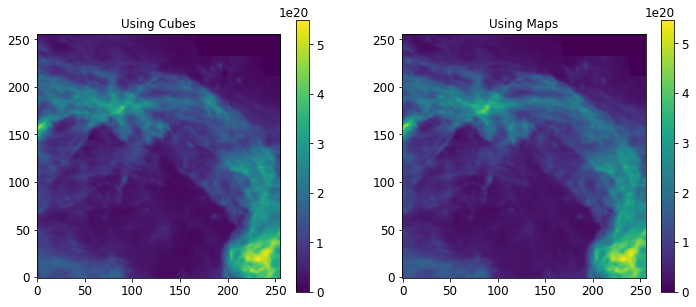

In [114]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1);plt.title("Using Cubes");plt.imshow(np.sum(mean_CNM_sv_cube, 0)*C*dv, origin='lower');plt.colorbar()
plt.subplot(1,2,2);plt.title("Using Maps");plt.imshow(mean_CNM_sv_map, origin='lower');plt.colorbar()

In [115]:
std_CNM_sv_map = np.std([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,\
                         CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,\
                         CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,\
                         CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,\
                         CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49], 0)
std_LNM_sv_map = np.std([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,\
                         LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,\
                         LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,\
                         LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,\
                         LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49], 0)
std_WNMa_sv_map = np.std([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,\
                         WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,\
                         WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,\
                         WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,\
                         WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49], 0)
std_WNMd_sv_map = np.std([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,\
                         WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,\
                         WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,\
                         WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,\
                         WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49], 0)

In [116]:
frac_std_WNMd_sv_map = np.std([frac_CNM_sv_from_maps_0,frac_CNM_sv_from_maps_1,frac_CNM_sv_from_maps_2,frac_CNM_sv_from_maps_3,frac_CNM_sv_from_maps_4,frac_CNM_sv_from_maps_5,frac_CNM_sv_from_maps_6,frac_CNM_sv_from_maps_7,frac_CNM_sv_from_maps_8,frac_CNM_sv_from_maps_9,\
                               frac_CNM_sv_from_maps_10,frac_CNM_sv_from_maps_11,frac_CNM_sv_from_maps_12,frac_CNM_sv_from_maps_13,frac_CNM_sv_from_maps_14,frac_CNM_sv_from_maps_15,frac_CNM_sv_from_maps_16,frac_CNM_sv_from_maps_17,frac_CNM_sv_from_maps_18,frac_CNM_sv_from_maps_19,\
                               frac_CNM_sv_from_maps_20,frac_CNM_sv_from_maps_21,frac_CNM_sv_from_maps_22,frac_CNM_sv_from_maps_23,frac_CNM_sv_from_maps_24,frac_CNM_sv_from_maps_25,frac_CNM_sv_from_maps_26,frac_CNM_sv_from_maps_27,frac_CNM_sv_from_maps_28,frac_CNM_sv_from_maps_29,\
                               frac_CNM_sv_from_maps_30,frac_CNM_sv_from_maps_31,frac_CNM_sv_from_maps_32,frac_CNM_sv_from_maps_33,frac_CNM_sv_from_maps_34,frac_CNM_sv_from_maps_35,frac_CNM_sv_from_maps_36,frac_CNM_sv_from_maps_37,frac_CNM_sv_from_maps_38,frac_CNM_sv_from_maps_39,\
                               frac_CNM_sv_from_maps_40,frac_CNM_sv_from_maps_41,frac_CNM_sv_from_maps_42,frac_CNM_sv_from_maps_43,frac_CNM_sv_from_maps_44,frac_CNM_sv_from_maps_45,frac_CNM_sv_from_maps_46,frac_CNM_sv_from_maps_47,frac_CNM_sv_from_maps_48,frac_CNM_sv_from_maps_49], 0)
frac_std_WNMd_sv_map = np.std([frac_LNM_sv_from_maps_0,frac_LNM_sv_from_maps_1,frac_LNM_sv_from_maps_2,frac_LNM_sv_from_maps_3,frac_LNM_sv_from_maps_4,frac_LNM_sv_from_maps_5,frac_LNM_sv_from_maps_6,frac_LNM_sv_from_maps_7,frac_LNM_sv_from_maps_8,frac_LNM_sv_from_maps_9,\
                               frac_LNM_sv_from_maps_10,frac_LNM_sv_from_maps_11,frac_LNM_sv_from_maps_12,frac_LNM_sv_from_maps_13,frac_LNM_sv_from_maps_14,frac_LNM_sv_from_maps_15,frac_LNM_sv_from_maps_16,frac_LNM_sv_from_maps_17,frac_LNM_sv_from_maps_18,frac_LNM_sv_from_maps_19,\
                               frac_LNM_sv_from_maps_20,frac_LNM_sv_from_maps_21,frac_LNM_sv_from_maps_22,frac_LNM_sv_from_maps_23,frac_LNM_sv_from_maps_24,frac_LNM_sv_from_maps_25,frac_LNM_sv_from_maps_26,frac_LNM_sv_from_maps_27,frac_LNM_sv_from_maps_28,frac_LNM_sv_from_maps_29,\
                               frac_LNM_sv_from_maps_30,frac_LNM_sv_from_maps_31,frac_LNM_sv_from_maps_32,frac_LNM_sv_from_maps_33,frac_LNM_sv_from_maps_34,frac_LNM_sv_from_maps_35,frac_LNM_sv_from_maps_36,frac_LNM_sv_from_maps_37,frac_LNM_sv_from_maps_38,frac_LNM_sv_from_maps_39,\
                               frac_LNM_sv_from_maps_40,frac_LNM_sv_from_maps_41,frac_LNM_sv_from_maps_42,frac_LNM_sv_from_maps_43,frac_LNM_sv_from_maps_44,frac_LNM_sv_from_maps_45,frac_LNM_sv_from_maps_46,frac_LNM_sv_from_maps_47,frac_LNM_sv_from_maps_48,frac_LNM_sv_from_maps_49], 0)
frac_std_WNMd_sv_map = np.std([frac_WNMa_sv_from_maps_0,frac_WNMa_sv_from_maps_1,frac_WNMa_sv_from_maps_2,frac_WNMa_sv_from_maps_3,frac_WNMa_sv_from_maps_4,frac_WNMa_sv_from_maps_5,frac_WNMa_sv_from_maps_6,frac_WNMa_sv_from_maps_7,frac_WNMa_sv_from_maps_8,frac_WNMa_sv_from_maps_9,\
                               frac_WNMa_sv_from_maps_10,frac_WNMa_sv_from_maps_11,frac_WNMa_sv_from_maps_12,frac_WNMa_sv_from_maps_13,frac_WNMa_sv_from_maps_14,frac_WNMa_sv_from_maps_15,frac_WNMa_sv_from_maps_16,frac_WNMa_sv_from_maps_17,frac_WNMa_sv_from_maps_18,frac_WNMa_sv_from_maps_19,\
                               frac_WNMa_sv_from_maps_20,frac_WNMa_sv_from_maps_21,frac_WNMa_sv_from_maps_22,frac_WNMa_sv_from_maps_23,frac_WNMa_sv_from_maps_24,frac_WNMa_sv_from_maps_25,frac_WNMa_sv_from_maps_26,frac_WNMa_sv_from_maps_27,frac_WNMa_sv_from_maps_28,frac_WNMa_sv_from_maps_29,\
                               frac_WNMa_sv_from_maps_30,frac_WNMa_sv_from_maps_31,frac_WNMa_sv_from_maps_32,frac_WNMa_sv_from_maps_33,frac_WNMa_sv_from_maps_34,frac_WNMa_sv_from_maps_35,frac_WNMa_sv_from_maps_36,frac_WNMa_sv_from_maps_37,frac_WNMa_sv_from_maps_38,frac_WNMa_sv_from_maps_39,\
                               frac_WNMa_sv_from_maps_40,frac_WNMa_sv_from_maps_41,frac_WNMa_sv_from_maps_42,frac_WNMa_sv_from_maps_43,frac_WNMa_sv_from_maps_44,frac_WNMa_sv_from_maps_45,frac_WNMa_sv_from_maps_46,frac_WNMa_sv_from_maps_47,frac_WNMa_sv_from_maps_48,frac_WNMa_sv_from_maps_49], 0)
frac_std_WNMd_sv_map = np.std([frac_WNMd_sv_from_maps_0,frac_WNMd_sv_from_maps_1,frac_WNMd_sv_from_maps_2,frac_WNMd_sv_from_maps_3,frac_WNMd_sv_from_maps_4,frac_WNMd_sv_from_maps_5,frac_WNMd_sv_from_maps_6,frac_WNMd_sv_from_maps_7,frac_WNMd_sv_from_maps_8,frac_WNMd_sv_from_maps_9,\
                               frac_WNMd_sv_from_maps_10,frac_WNMd_sv_from_maps_11,frac_WNMd_sv_from_maps_12,frac_WNMd_sv_from_maps_13,frac_WNMd_sv_from_maps_14,frac_WNMd_sv_from_maps_15,frac_WNMd_sv_from_maps_16,frac_WNMd_sv_from_maps_17,frac_WNMd_sv_from_maps_18,frac_WNMd_sv_from_maps_19,\
                               frac_WNMd_sv_from_maps_20,frac_WNMd_sv_from_maps_21,frac_WNMd_sv_from_maps_22,frac_WNMd_sv_from_maps_23,frac_WNMd_sv_from_maps_24,frac_WNMd_sv_from_maps_25,frac_WNMd_sv_from_maps_26,frac_WNMd_sv_from_maps_27,frac_WNMd_sv_from_maps_28,frac_WNMd_sv_from_maps_29,\
                               frac_WNMd_sv_from_maps_30,frac_WNMd_sv_from_maps_31,frac_WNMd_sv_from_maps_32,frac_WNMd_sv_from_maps_33,frac_WNMd_sv_from_maps_34,frac_WNMd_sv_from_maps_35,frac_WNMd_sv_from_maps_36,frac_WNMd_sv_from_maps_37,frac_WNMd_sv_from_maps_38,frac_WNMd_sv_from_maps_39,\
                               frac_WNMd_sv_from_maps_40,frac_WNMd_sv_from_maps_41,frac_WNMd_sv_from_maps_42,frac_WNMd_sv_from_maps_43,frac_WNMd_sv_from_maps_44,frac_WNMd_sv_from_maps_45,frac_WNMd_sv_from_maps_46,frac_WNMd_sv_from_maps_47,frac_WNMd_sv_from_maps_48,frac_WNMd_sv_from_maps_49], 0)

### New way to compute means and std:

In [117]:
mean_tot_NH = np.mean([tot_model_bc_0,tot_model_bc_1,tot_model_bc_2,tot_model_bc_3,tot_model_bc_4,tot_model_bc_5,tot_model_bc_6,tot_model_bc_7,tot_model_bc_8,tot_model_bc_9,\
                       tot_model_bc_10,tot_model_bc_11,tot_model_bc_12,tot_model_bc_13,tot_model_bc_14,tot_model_bc_15,tot_model_bc_16,tot_model_bc_17,tot_model_bc_18,tot_model_bc_19,\
                       tot_model_bc_20,tot_model_bc_21,tot_model_bc_22,tot_model_bc_23,tot_model_bc_24,tot_model_bc_25,tot_model_bc_26,tot_model_bc_27,tot_model_bc_28,tot_model_bc_29,\
                       tot_model_bc_30,tot_model_bc_31,tot_model_bc_32,tot_model_bc_33,tot_model_bc_34,tot_model_bc_35,tot_model_bc_36,tot_model_bc_37,tot_model_bc_38,tot_model_bc_39,\
                       tot_model_bc_40,tot_model_bc_41,tot_model_bc_42,tot_model_bc_43,tot_model_bc_44,tot_model_bc_45,tot_model_bc_46,tot_model_bc_47,tot_model_bc_48,tot_model_bc_49,\
                       tot_model_ls_0,tot_model_ls_1,tot_model_ls_2,tot_model_ls_3,tot_model_ls_4,tot_model_ls_5,tot_model_ls_6,tot_model_ls_7,tot_model_ls_8,tot_model_ls_9,\
                       tot_model_ls_10,tot_model_ls_11,tot_model_ls_12,tot_model_ls_13,tot_model_ls_14,tot_model_ls_15,tot_model_ls_16,tot_model_ls_17,tot_model_ls_18,tot_model_ls_19,\
                       tot_model_ls_20,tot_model_ls_21,tot_model_ls_22,tot_model_ls_23,tot_model_ls_24,tot_model_ls_25,tot_model_ls_26,tot_model_ls_27,tot_model_ls_28,tot_model_ls_29,\
                       tot_model_ls_30,tot_model_ls_31,tot_model_ls_32,tot_model_ls_33,tot_model_ls_34,tot_model_ls_35,tot_model_ls_36,tot_model_ls_37,tot_model_ls_38,tot_model_ls_39,\
                       tot_model_ls_40,tot_model_ls_41,tot_model_ls_42,tot_model_ls_43,tot_model_ls_44,tot_model_ls_45,tot_model_ls_46,tot_model_ls_47,tot_model_ls_48,tot_model_ls_49,\
                       tot_model_sv_0,tot_model_sv_1,tot_model_sv_2,tot_model_sv_3,tot_model_sv_4,tot_model_sv_5,tot_model_sv_6,tot_model_sv_7,tot_model_sv_8,tot_model_sv_9,\
                       tot_model_sv_10,tot_model_sv_11,tot_model_sv_12,tot_model_sv_13,tot_model_sv_14,tot_model_sv_15,tot_model_sv_16,tot_model_sv_17,tot_model_sv_18,tot_model_sv_19,\
                       tot_model_sv_20,tot_model_sv_21,tot_model_sv_22,tot_model_sv_23,tot_model_sv_24,tot_model_sv_25,tot_model_sv_26,tot_model_sv_27,tot_model_sv_28,tot_model_sv_29,\
                       tot_model_sv_30,tot_model_sv_31,tot_model_sv_32,tot_model_sv_33,tot_model_sv_34,tot_model_sv_35,tot_model_sv_36,tot_model_sv_37,tot_model_sv_38,tot_model_sv_39,\
                       tot_model_sv_40,tot_model_sv_41,tot_model_sv_42,tot_model_sv_43,tot_model_sv_44,tot_model_sv_45,tot_model_sv_46,tot_model_sv_47,tot_model_sv_48,tot_model_sv_49], 0)*C*dv

In [118]:
mean_CNM_from_maps = np.mean([mean_CNM_bc_map,mean_CNM_ls_map,mean_CNM_sv_map], 0)
mean_LNM_from_maps = np.mean([mean_LNM_bc_map,mean_LNM_ls_map,mean_LNM_sv_map], 0)
mean_WNMa_from_maps = np.mean([mean_WNMa_bc_map,mean_WNMa_ls_map,mean_WNMa_sv_map], 0)
mean_WNMd_from_maps = np.mean([mean_WNMd_bc_map,mean_WNMd_ls_map,mean_WNMd_sv_map], 0)

In [119]:
std_CNM_from_maps = np.sqrt(std_CNM_bc_map**2 + std_CNM_ls_map**2 + std_CNM_sv_map**2)
std_LNM_from_maps = np.sqrt(std_LNM_bc_map**2 + std_LNM_ls_map**2 + std_LNM_sv_map**2)
std_WNMa_from_maps = np.sqrt(std_WNMa_bc_map**2 + std_WNMa_ls_map**2 + std_WNMa_sv_map**2)
std_WNMd_from_maps = np.sqrt(std_WNMd_bc_map**2 + std_WNMd_ls_map**2 + std_WNMd_sv_map**2)

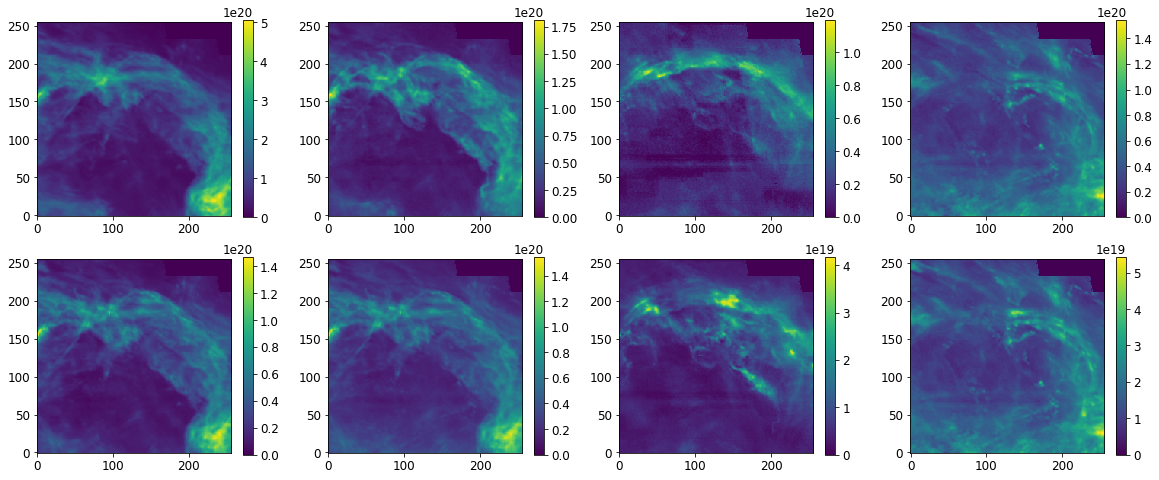

In [120]:
plt.figure(figsize=(20,8))
plt.subplot(2,4,1);plt.imshow(mean_CNM_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,2);plt.imshow(mean_LNM_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,3);plt.imshow(mean_WNMa_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,4);plt.imshow(mean_WNMd_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,5);plt.imshow(std_CNM_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,6);plt.imshow(std_LNM_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,7);plt.imshow(std_WNMa_from_maps, origin='lower');plt.colorbar()
plt.subplot(2,4,8);plt.imshow(std_WNMd_from_maps, origin='lower');plt.colorbar()

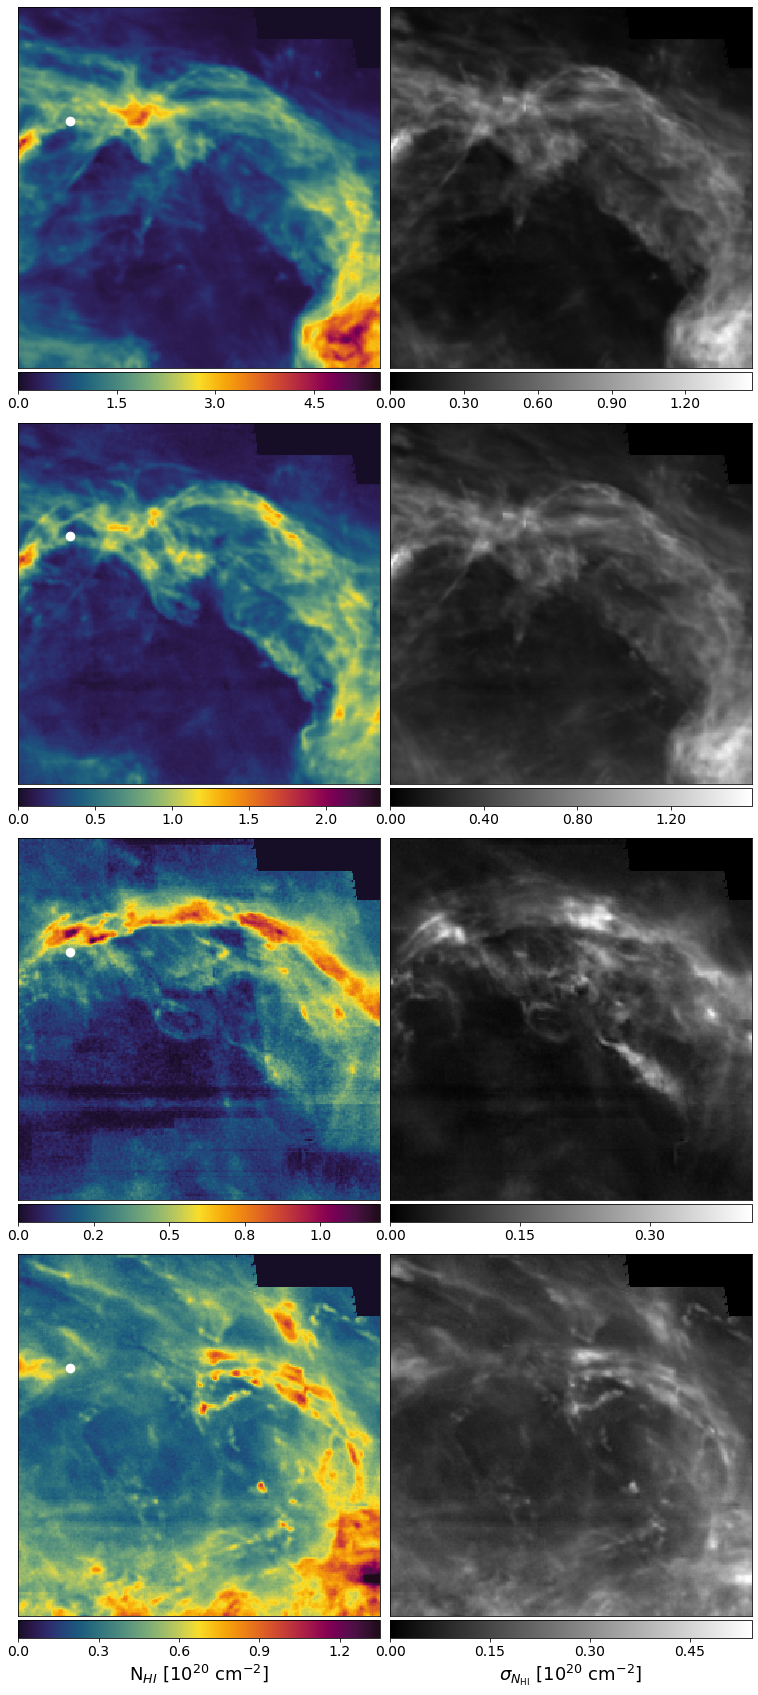

In [121]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()
import cmasher as cmr
cmap_NH = cmr.pride                  
cmap_NH = plt.get_cmap('cmr.pride')

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow((1/10**20)*mean_CNM_from_maps, origin='lower', cmap=cmap_NH, vmin=0, vmax=5.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow((1/10**20)*std_CNM_from_maps, origin='lower', cmap=reversed_color_map)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow((1/10**20)*mean_LNM_from_maps, origin='lower', cmap=cmap_NH, vmin=0, vmax=2.35)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow((1/10**20)*std_LNM_from_maps, origin='lower', cmap=reversed_color_map)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow((1/10**20)*mean_WNMa_from_maps, origin='lower', cmap=cmap_NH, vmin=0)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow((1/10**20)*std_WNMa_from_maps, origin='lower', cmap=reversed_color_map)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow((1/10**20)*mean_WNMd_from_maps, origin='lower', cmap=cmap_NH, vmin=0, vmax=1.35)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow((1/10**20)*std_WNMd_from_maps, origin='lower', cmap=reversed_color_map)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
for k in range(4):
    axs[k][0].scatter([36], [175], color='white', s=75)
cbar7.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
cbar8.set_label(r"$\sigma_{N_{\rm HI}}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
#fig.savefig("NEW_NH_maps_phases_with_Sigmas_USING_MAPS.png", bbox_inches='tight')

In [122]:
Need to make the mean frac amps and std frac amps now also, for the totals, make the mean tot map instead of cube

SyntaxError: invalid syntax (<ipython-input-122-a8669c3aea06>, line 1)

In [ ]:
STOP!!

In [ ]:
empty_primary = fits.PrimaryHDU(mean_WNMd_from_maps, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("mean_WNMd_map_BEST.fits", clobber=True)

__________________________________________________________________________________________________________________

Compute Means and Stds:

In [ ]:
mean_tot_NH = np.mean([tot_model_bc_0,tot_model_bc_1,tot_model_bc_2,tot_model_bc_3,tot_model_bc_4,tot_model_bc_5,tot_model_bc_6,tot_model_bc_7,tot_model_bc_8,tot_model_bc_9,\
                       tot_model_bc_10,tot_model_bc_11,tot_model_bc_12,tot_model_bc_13,tot_model_bc_14,tot_model_bc_15,tot_model_bc_16,tot_model_bc_17,tot_model_bc_18,tot_model_bc_19,\
                       tot_model_bc_20,tot_model_bc_21,tot_model_bc_22,tot_model_bc_23,tot_model_bc_24,tot_model_bc_25,tot_model_bc_26,tot_model_bc_27,tot_model_bc_28,tot_model_bc_29,\
                       tot_model_bc_30,tot_model_bc_31,tot_model_bc_32,tot_model_bc_33,tot_model_bc_34,tot_model_bc_35,tot_model_bc_36,tot_model_bc_37,tot_model_bc_38,tot_model_bc_39,\
                       tot_model_bc_40,tot_model_bc_41,tot_model_bc_42,tot_model_bc_43,tot_model_bc_44,tot_model_bc_45,tot_model_bc_46,tot_model_bc_47,tot_model_bc_48,tot_model_bc_49,\
                       tot_model_ls_0,tot_model_ls_1,tot_model_ls_2,tot_model_ls_3,tot_model_ls_4,tot_model_ls_5,tot_model_ls_6,tot_model_ls_7,tot_model_ls_8,tot_model_ls_9,\
                       tot_model_ls_10,tot_model_ls_11,tot_model_ls_12,tot_model_ls_13,tot_model_ls_14,tot_model_ls_15,tot_model_ls_16,tot_model_ls_17,tot_model_ls_18,tot_model_ls_19,\
                       tot_model_ls_20,tot_model_ls_21,tot_model_ls_22,tot_model_ls_23,tot_model_ls_24,tot_model_ls_25,tot_model_ls_26,tot_model_ls_27,tot_model_ls_28,tot_model_ls_29,\
                       tot_model_ls_30,tot_model_ls_31,tot_model_ls_32,tot_model_ls_33,tot_model_ls_34,tot_model_ls_35,tot_model_ls_36,tot_model_ls_37,tot_model_ls_38,tot_model_ls_39,\
                       tot_model_ls_40,tot_model_ls_41,tot_model_ls_42,tot_model_ls_43,tot_model_ls_44,tot_model_ls_45,tot_model_ls_46,tot_model_ls_47,tot_model_ls_48,tot_model_ls_49,\
                       tot_model_sv_0,tot_model_sv_1,tot_model_sv_2,tot_model_sv_3,tot_model_sv_4,tot_model_sv_5,tot_model_sv_6,tot_model_sv_7,tot_model_sv_8,tot_model_sv_9,\
                       tot_model_sv_10,tot_model_sv_11,tot_model_sv_12,tot_model_sv_13,tot_model_sv_14,tot_model_sv_15,tot_model_sv_16,tot_model_sv_17,tot_model_sv_18,tot_model_sv_19,\
                       tot_model_sv_20,tot_model_sv_21,tot_model_sv_22,tot_model_sv_23,tot_model_sv_24,tot_model_sv_25,tot_model_sv_26,tot_model_sv_27,tot_model_sv_28,tot_model_sv_29,\
                       tot_model_sv_30,tot_model_sv_31,tot_model_sv_32,tot_model_sv_33,tot_model_sv_34,tot_model_sv_35,tot_model_sv_36,tot_model_sv_37,tot_model_sv_38,tot_model_sv_39,\
                       tot_model_sv_40,tot_model_sv_41,tot_model_sv_42,tot_model_sv_43,tot_model_sv_44,tot_model_sv_45,tot_model_sv_46,tot_model_sv_47,tot_model_sv_48,tot_model_sv_49], 0)*C*dv

In [ ]:
mean_CNM_sv_NH = np.mean([model_CNM_sv_0,model_CNM_sv_1,model_CNM_sv_2,model_CNM_sv_3,model_CNM_sv_4,model_CNM_sv_5,model_CNM_sv_6,model_CNM_sv_7,model_CNM_sv_8,model_CNM_sv_9,\
                       model_CNM_sv_10,model_CNM_sv_11,model_CNM_sv_12,model_CNM_sv_13,model_CNM_sv_14,model_CNM_sv_15,model_CNM_sv_16,model_CNM_sv_17,model_CNM_sv_18,model_CNM_sv_19,\
                       model_CNM_sv_20,model_CNM_sv_21,model_CNM_sv_22,model_CNM_sv_23,model_CNM_sv_24,model_CNM_sv_25,model_CNM_sv_26,model_CNM_sv_27,model_CNM_sv_28,model_CNM_sv_29,\
                       model_CNM_sv_30,model_CNM_sv_31,model_CNM_sv_32,model_CNM_sv_33,model_CNM_sv_34,model_CNM_sv_35,model_CNM_sv_36,model_CNM_sv_37,model_CNM_sv_38,model_CNM_sv_39,\
                       model_CNM_sv_40,model_CNM_sv_41,model_CNM_sv_42,model_CNM_sv_43,model_CNM_sv_44,model_CNM_sv_45,model_CNM_sv_46,model_CNM_sv_47,model_CNM_sv_48,model_CNM_sv_49], 0)
mean_CNM_ls_NH = np.mean([model_CNM_ls_0,model_CNM_ls_1,model_CNM_ls_2,model_CNM_ls_3,model_CNM_ls_4,model_CNM_ls_5,model_CNM_ls_6,model_CNM_ls_7,model_CNM_ls_8,model_CNM_ls_9,\
                       model_CNM_ls_10,model_CNM_ls_11,model_CNM_ls_12,model_CNM_ls_13,model_CNM_ls_14,model_CNM_ls_15,model_CNM_ls_16,model_CNM_ls_17,model_CNM_ls_18,model_CNM_ls_19,\
                       model_CNM_ls_20,model_CNM_ls_21,model_CNM_ls_22,model_CNM_ls_23,model_CNM_ls_24,model_CNM_ls_25,model_CNM_ls_26,model_CNM_ls_27,model_CNM_ls_28,model_CNM_ls_29,\
                       model_CNM_ls_30,model_CNM_ls_31,model_CNM_ls_32,model_CNM_ls_33,model_CNM_ls_34,model_CNM_ls_35,model_CNM_ls_36,model_CNM_ls_37,model_CNM_ls_38,model_CNM_ls_39,\
                       model_CNM_ls_40,model_CNM_ls_41,model_CNM_ls_42,model_CNM_ls_43,model_CNM_ls_44,model_CNM_ls_45,model_CNM_ls_46,model_CNM_ls_47,model_CNM_ls_48,model_CNM_ls_49], 0)
mean_CNM_bc_NH = np.mean([model_CNM_bc_0,model_CNM_bc_1,model_CNM_bc_2,model_CNM_bc_3,model_CNM_bc_4,model_CNM_bc_5,model_CNM_bc_6,model_CNM_bc_7,model_CNM_bc_8,model_CNM_bc_9,\
                       model_CNM_bc_10,model_CNM_bc_11,model_CNM_bc_12,model_CNM_bc_13,model_CNM_bc_14,model_CNM_bc_15,model_CNM_bc_16,model_CNM_bc_17,model_CNM_bc_18,model_CNM_bc_19,\
                       model_CNM_bc_20,model_CNM_bc_21,model_CNM_bc_22,model_CNM_bc_23,model_CNM_bc_24,model_CNM_bc_25,model_CNM_bc_26,model_CNM_bc_27,model_CNM_bc_28,model_CNM_bc_29,\
                       model_CNM_bc_30,model_CNM_bc_31,model_CNM_bc_32,model_CNM_bc_33,model_CNM_bc_34,model_CNM_bc_35,model_CNM_bc_36,model_CNM_bc_37,model_CNM_bc_38,model_CNM_bc_39,\
                       model_CNM_bc_40,model_CNM_bc_41,model_CNM_bc_42,model_CNM_bc_43,model_CNM_bc_44,model_CNM_bc_45,model_CNM_bc_46,model_CNM_bc_47,model_CNM_bc_48,model_CNM_bc_49], 0)
mean_CNM_NH = np.mean([mean_CNM_bc_NH, mean_CNM_ls_NH, mean_CNM_sv_NH], 0)*C*dv

In [ ]:
mean_LNM_sv_NH = np.mean([model_LNM_sv_0,model_LNM_sv_1,model_LNM_sv_2,model_LNM_sv_3,model_LNM_sv_4,model_LNM_sv_5,model_LNM_sv_6,model_LNM_sv_7,model_LNM_sv_8,model_LNM_sv_9,\
                       model_LNM_sv_10,model_LNM_sv_11,model_LNM_sv_12,model_LNM_sv_13,model_LNM_sv_14,model_LNM_sv_15,model_LNM_sv_16,model_LNM_sv_17,model_LNM_sv_18,model_LNM_sv_19,\
                       model_LNM_sv_20,model_LNM_sv_21,model_LNM_sv_22,model_LNM_sv_23,model_LNM_sv_24,model_LNM_sv_25,model_LNM_sv_26,model_LNM_sv_27,model_LNM_sv_28,model_LNM_sv_29,\
                       model_LNM_sv_30,model_LNM_sv_31,model_LNM_sv_32,model_LNM_sv_33,model_LNM_sv_34,model_LNM_sv_35,model_LNM_sv_36,model_LNM_sv_37,model_LNM_sv_38,model_LNM_sv_39,\
                       model_LNM_sv_40,model_LNM_sv_41,model_LNM_sv_42,model_LNM_sv_43,model_LNM_sv_44,model_LNM_sv_45,model_LNM_sv_46,model_LNM_sv_47,model_LNM_sv_48,model_LNM_sv_49], 0)
mean_LNM_ls_NH = np.mean([model_LNM_ls_0,model_LNM_ls_1,model_LNM_ls_2,model_LNM_ls_3,model_LNM_ls_4,model_LNM_ls_5,model_LNM_ls_6,model_LNM_ls_7,model_LNM_ls_8,model_LNM_ls_9,\
                       model_LNM_ls_10,model_LNM_ls_11,model_LNM_ls_12,model_LNM_ls_13,model_LNM_ls_14,model_LNM_ls_15,model_LNM_ls_16,model_LNM_ls_17,model_LNM_ls_18,model_LNM_ls_19,\
                       model_LNM_ls_20,model_LNM_ls_21,model_LNM_ls_22,model_LNM_ls_23,model_LNM_ls_24,model_LNM_ls_25,model_LNM_ls_26,model_LNM_ls_27,model_LNM_ls_28,model_LNM_ls_29,\
                       model_LNM_ls_30,model_LNM_ls_31,model_LNM_ls_32,model_LNM_ls_33,model_LNM_ls_34,model_LNM_ls_35,model_LNM_ls_36,model_LNM_ls_37,model_LNM_ls_38,model_LNM_ls_39,\
                       model_LNM_ls_40,model_LNM_ls_41,model_LNM_ls_42,model_LNM_ls_43,model_LNM_ls_44,model_LNM_ls_45,model_LNM_ls_46,model_LNM_ls_47,model_LNM_ls_48,model_LNM_ls_49], 0)
mean_LNM_bc_NH = np.mean([model_LNM_bc_0,model_LNM_bc_1,model_LNM_bc_2,model_LNM_bc_3,model_LNM_bc_4,model_LNM_bc_5,model_LNM_bc_6,model_LNM_bc_7,model_LNM_bc_8,model_LNM_bc_9,\
                       model_LNM_bc_10,model_LNM_bc_11,model_LNM_bc_12,model_LNM_bc_13,model_LNM_bc_14,model_LNM_bc_15,model_LNM_bc_16,model_LNM_bc_17,model_LNM_bc_18,model_LNM_bc_19,\
                       model_LNM_bc_20,model_LNM_bc_21,model_LNM_bc_22,model_LNM_bc_23,model_LNM_bc_24,model_LNM_bc_25,model_LNM_bc_26,model_LNM_bc_27,model_LNM_bc_28,model_LNM_bc_29,\
                       model_LNM_bc_30,model_LNM_bc_31,model_LNM_bc_32,model_LNM_bc_33,model_LNM_bc_34,model_LNM_bc_35,model_LNM_bc_36,model_LNM_bc_37,model_LNM_bc_38,model_LNM_bc_39,\
                       model_LNM_bc_40,model_LNM_bc_41,model_LNM_bc_42,model_LNM_bc_43,model_LNM_bc_44,model_LNM_bc_45,model_LNM_bc_46,model_LNM_bc_47,model_LNM_bc_48,model_LNM_bc_49], 0)
mean_LNM_NH = np.mean([mean_LNM_bc_NH, mean_LNM_ls_NH, mean_LNM_sv_NH], 0)*C*dv

In [ ]:
mean_WNMa_sv_NH = np.mean([model_WNMa_sv_0,model_WNMa_sv_1,model_WNMa_sv_2,model_WNMa_sv_3,model_WNMa_sv_4,model_WNMa_sv_5,model_WNMa_sv_6,model_WNMa_sv_7,model_WNMa_sv_8,model_WNMa_sv_9,\
                       model_WNMa_sv_10,model_WNMa_sv_11,model_WNMa_sv_12,model_WNMa_sv_13,model_WNMa_sv_14,model_WNMa_sv_15,model_WNMa_sv_16,model_WNMa_sv_17,model_WNMa_sv_18,model_WNMa_sv_19,\
                       model_WNMa_sv_20,model_WNMa_sv_21,model_WNMa_sv_22,model_WNMa_sv_23,model_WNMa_sv_24,model_WNMa_sv_25,model_WNMa_sv_26,model_WNMa_sv_27,model_WNMa_sv_28,model_WNMa_sv_29,\
                       model_WNMa_sv_30,model_WNMa_sv_31,model_WNMa_sv_32,model_WNMa_sv_33,model_WNMa_sv_34,model_WNMa_sv_35,model_WNMa_sv_36,model_WNMa_sv_37,model_WNMa_sv_38,model_WNMa_sv_39,\
                       model_WNMa_sv_40,model_WNMa_sv_41,model_WNMa_sv_42,model_WNMa_sv_43,model_WNMa_sv_44,model_WNMa_sv_45,model_WNMa_sv_46,model_WNMa_sv_47,model_WNMa_sv_48,model_WNMa_sv_49], 0)
mean_WNMa_ls_NH = np.mean([model_WNMa_ls_0,model_WNMa_ls_1,model_WNMa_ls_2,model_WNMa_ls_3,model_WNMa_ls_4,model_WNMa_ls_5,model_WNMa_ls_6,model_WNMa_ls_7,model_WNMa_ls_8,model_WNMa_ls_9,\
                       model_WNMa_ls_10,model_WNMa_ls_11,model_WNMa_ls_12,model_WNMa_ls_13,model_WNMa_ls_14,model_WNMa_ls_15,model_WNMa_ls_16,model_WNMa_ls_17,model_WNMa_ls_18,model_WNMa_ls_19,\
                       model_WNMa_ls_20,model_WNMa_ls_21,model_WNMa_ls_22,model_WNMa_ls_23,model_WNMa_ls_24,model_WNMa_ls_25,model_WNMa_ls_26,model_WNMa_ls_27,model_WNMa_ls_28,model_WNMa_ls_29,\
                       model_WNMa_ls_30,model_WNMa_ls_31,model_WNMa_ls_32,model_WNMa_ls_33,model_WNMa_ls_34,model_WNMa_ls_35,model_WNMa_ls_36,model_WNMa_ls_37,model_WNMa_ls_38,model_WNMa_ls_39,\
                       model_WNMa_ls_40,model_WNMa_ls_41,model_WNMa_ls_42,model_WNMa_ls_43,model_WNMa_ls_44,model_WNMa_ls_45,model_WNMa_ls_46,model_WNMa_ls_47,model_WNMa_ls_48,model_WNMa_ls_49], 0)
mean_WNMa_bc_NH = np.mean([model_WNMa_bc_0,model_WNMa_bc_1,model_WNMa_bc_2,model_WNMa_bc_3,model_WNMa_bc_4,model_WNMa_bc_5,model_WNMa_bc_6,model_WNMa_bc_7,model_WNMa_bc_8,model_WNMa_bc_9,\
                       model_WNMa_bc_10,model_WNMa_bc_11,model_WNMa_bc_12,model_WNMa_bc_13,model_WNMa_bc_14,model_WNMa_bc_15,model_WNMa_bc_16,model_WNMa_bc_17,model_WNMa_bc_18,model_WNMa_bc_19,\
                       model_WNMa_bc_20,model_WNMa_bc_21,model_WNMa_bc_22,model_WNMa_bc_23,model_WNMa_bc_24,model_WNMa_bc_25,model_WNMa_bc_26,model_WNMa_bc_27,model_WNMa_bc_28,model_WNMa_bc_29,\
                       model_WNMa_bc_30,model_WNMa_bc_31,model_WNMa_bc_32,model_WNMa_bc_33,model_WNMa_bc_34,model_WNMa_bc_35,model_WNMa_bc_36,model_WNMa_bc_37,model_WNMa_bc_38,model_WNMa_bc_39,\
                       model_WNMa_bc_40,model_WNMa_bc_41,model_WNMa_bc_42,model_WNMa_bc_43,model_WNMa_bc_44,model_WNMa_bc_45,model_WNMa_bc_46,model_WNMa_bc_47,model_WNMa_bc_48,model_WNMa_bc_49], 0)
mean_WNMa_NH = np.mean([mean_WNMa_bc_NH, mean_WNMa_ls_NH, mean_WNMa_sv_NH], 0)*C*dv

In [ ]:
mean_WNMd_sv_NH = np.mean([model_WNMd_sv_0,model_WNMd_sv_1,model_WNMd_sv_2,model_WNMd_sv_3,model_WNMd_sv_4,model_WNMd_sv_5,model_WNMd_sv_6,model_WNMd_sv_7,model_WNMd_sv_8,model_WNMd_sv_9,\
                       model_WNMd_sv_10,model_WNMd_sv_11,model_WNMd_sv_12,model_WNMd_sv_13,model_WNMd_sv_14,model_WNMd_sv_15,model_WNMd_sv_16,model_WNMd_sv_17,model_WNMd_sv_18,model_WNMd_sv_19,\
                       model_WNMd_sv_20,model_WNMd_sv_21,model_WNMd_sv_22,model_WNMd_sv_23,model_WNMd_sv_24,model_WNMd_sv_25,model_WNMd_sv_26,model_WNMd_sv_27,model_WNMd_sv_28,model_WNMd_sv_29,\
                       model_WNMd_sv_30,model_WNMd_sv_31,model_WNMd_sv_32,model_WNMd_sv_33,model_WNMd_sv_34,model_WNMd_sv_35,model_WNMd_sv_36,model_WNMd_sv_37,model_WNMd_sv_38,model_WNMd_sv_39,\
                       model_WNMd_sv_40,model_WNMd_sv_41,model_WNMd_sv_42,model_WNMd_sv_43,model_WNMd_sv_44,model_WNMd_sv_45,model_WNMd_sv_46,model_WNMd_sv_47,model_WNMd_sv_48,model_WNMd_sv_49], 0)
mean_WNMd_ls_NH = np.mean([model_WNMd_ls_0,model_WNMd_ls_1,model_WNMd_ls_2,model_WNMd_ls_3,model_WNMd_ls_4,model_WNMd_ls_5,model_WNMd_ls_6,model_WNMd_ls_7,model_WNMd_ls_8,model_WNMd_ls_9,\
                       model_WNMd_ls_10,model_WNMd_ls_11,model_WNMd_ls_12,model_WNMd_ls_13,model_WNMd_ls_14,model_WNMd_ls_15,model_WNMd_ls_16,model_WNMd_ls_17,model_WNMd_ls_18,model_WNMd_ls_19,\
                       model_WNMd_ls_20,model_WNMd_ls_21,model_WNMd_ls_22,model_WNMd_ls_23,model_WNMd_ls_24,model_WNMd_ls_25,model_WNMd_ls_26,model_WNMd_ls_27,model_WNMd_ls_28,model_WNMd_ls_29,\
                       model_WNMd_ls_30,model_WNMd_ls_31,model_WNMd_ls_32,model_WNMd_ls_33,model_WNMd_ls_34,model_WNMd_ls_35,model_WNMd_ls_36,model_WNMd_ls_37,model_WNMd_ls_38,model_WNMd_ls_39,\
                       model_WNMd_ls_40,model_WNMd_ls_41,model_WNMd_ls_42,model_WNMd_ls_43,model_WNMd_ls_44,model_WNMd_ls_45,model_WNMd_ls_46,model_WNMd_ls_47,model_WNMd_ls_48,model_WNMd_ls_49], 0)
mean_WNMd_bc_NH = np.mean([model_WNMd_bc_0,model_WNMd_bc_1,model_WNMd_bc_2,model_WNMd_bc_3,model_WNMd_bc_4,model_WNMd_bc_5,model_WNMd_bc_6,model_WNMd_bc_7,model_WNMd_bc_8,model_WNMd_bc_9,\
                       model_WNMd_bc_10,model_WNMd_bc_11,model_WNMd_bc_12,model_WNMd_bc_13,model_WNMd_bc_14,model_WNMd_bc_15,model_WNMd_bc_16,model_WNMd_bc_17,model_WNMd_bc_18,model_WNMd_bc_19,\
                       model_WNMd_bc_20,model_WNMd_bc_21,model_WNMd_bc_22,model_WNMd_bc_23,model_WNMd_bc_24,model_WNMd_bc_25,model_WNMd_bc_26,model_WNMd_bc_27,model_WNMd_bc_28,model_WNMd_bc_29,\
                       model_WNMd_bc_30,model_WNMd_bc_31,model_WNMd_bc_32,model_WNMd_bc_33,model_WNMd_bc_34,model_WNMd_bc_35,model_WNMd_bc_36,model_WNMd_bc_37,model_WNMd_bc_38,model_WNMd_bc_39,\
                       model_WNMd_bc_40,model_WNMd_bc_41,model_WNMd_bc_42,model_WNMd_bc_43,model_WNMd_bc_44,model_WNMd_bc_45,model_WNMd_bc_46,model_WNMd_bc_47,model_WNMd_bc_48,model_WNMd_bc_49], 0)
mean_WNMd_NH = np.mean([mean_WNMd_bc_NH, mean_WNMd_ls_NH, mean_WNMd_sv_NH], 0)*C*dv

In [ ]:
plt.imshow(np.sum(mean_CNM_NH, 0), origin='lower'); plt.colorbar()

In [ ]:
std_CNM_sv_NH = np.std(mean_CNM_sv_NH*C*dv, 0)
std_CNM_ls_NH = np.std(mean_CNM_ls_NH*C*dv, 0)
std_CNM_bc_NH = np.std(mean_CNM_bc_NH*C*dv, 0)
std_CNM_NH = np.sqrt(std_CNM_sv_NH**2 + std_CNM_ls_NH**2 + std_CNM_bc_NH**2)

In [ ]:
std_LNM_sv_NH = np.std(mean_LNM_sv_NH*C*dv, 0)
std_LNM_ls_NH = np.std(mean_LNM_ls_NH*C*dv, 0)
std_LNM_bc_NH = np.std(mean_LNM_bc_NH*C*dv, 0)
std_LNM_NH = np.sqrt(std_LNM_sv_NH**2 + std_LNM_ls_NH**2 + std_LNM_bc_NH**2)

In [ ]:
std_WNMa_sv_NH = np.std(mean_WNMa_sv_NH*C*dv, 0)
std_WNMa_ls_NH = np.std(mean_WNMa_ls_NH*C*dv, 0)
std_WNMa_bc_NH = np.std(mean_WNMa_bc_NH*C*dv, 0)
std_WNMa_NH = np.sqrt(std_WNMa_sv_NH**2 + std_WNMa_ls_NH**2 + std_WNMa_bc_NH**2)

In [ ]:
std_WNMd_sv_NH = np.std(mean_WNMd_sv_NH*C*dv, 0)
std_WNMd_ls_NH = np.std(mean_WNMd_ls_NH*C*dv, 0)
std_WNMd_bc_NH = np.std(mean_WNMd_bc_NH*C*dv, 0)
std_WNMd_NH = np.sqrt(std_WNMd_sv_NH**2 + std_WNMd_ls_NH**2 + std_WNMd_bc_NH**2)

_________________________________________________________________________

In [ ]:
model_CNM_sv_10/tot_model_sv_10

________________________________________________________________

In [ ]:
plt.imshow(std_LNM_NH, origin='lower'); plt.colorbar()

In [ ]:
mean_CNM_sv_frac = np.mean([frac_CNM_sv_0,frac_CNM_sv_1,frac_CNM_sv_2,frac_CNM_sv_3,frac_CNM_sv_4,frac_CNM_sv_5,frac_CNM_sv_6,frac_CNM_sv_7,frac_CNM_sv_8,frac_CNM_sv_9,\
                       frac_CNM_sv_10,frac_CNM_sv_11,frac_CNM_sv_12,frac_CNM_sv_13,frac_CNM_sv_14,frac_CNM_sv_15,frac_CNM_sv_16,frac_CNM_sv_17,frac_CNM_sv_18,frac_CNM_sv_19,\
                       frac_CNM_sv_20,frac_CNM_sv_21,frac_CNM_sv_22,frac_CNM_sv_23,frac_CNM_sv_24,frac_CNM_sv_25,frac_CNM_sv_26,frac_CNM_sv_27,frac_CNM_sv_28,frac_CNM_sv_29,\
                       frac_CNM_sv_30,frac_CNM_sv_31,frac_CNM_sv_32,frac_CNM_sv_33,frac_CNM_sv_34,frac_CNM_sv_35,frac_CNM_sv_36,frac_CNM_sv_37,frac_CNM_sv_38,frac_CNM_sv_39,\
                       frac_CNM_sv_40,frac_CNM_sv_41,frac_CNM_sv_42,frac_CNM_sv_43,frac_CNM_sv_44,frac_CNM_sv_45,frac_CNM_sv_46,frac_CNM_sv_47,frac_CNM_sv_48,frac_CNM_sv_49], 0)
mean_CNM_ls_frac = np.mean([frac_CNM_ls_0,frac_CNM_ls_1,frac_CNM_ls_2,frac_CNM_ls_3,frac_CNM_ls_4,frac_CNM_ls_5,frac_CNM_ls_6,frac_CNM_ls_7,frac_CNM_ls_8,frac_CNM_ls_9,\
                       frac_CNM_ls_10,frac_CNM_ls_11,frac_CNM_ls_12,frac_CNM_ls_13,frac_CNM_ls_14,frac_CNM_ls_15,frac_CNM_ls_16,frac_CNM_ls_17,frac_CNM_ls_18,frac_CNM_ls_19,\
                       frac_CNM_ls_20,frac_CNM_ls_21,frac_CNM_ls_22,frac_CNM_ls_23,frac_CNM_ls_24,frac_CNM_ls_25,frac_CNM_ls_26,frac_CNM_ls_27,frac_CNM_ls_28,frac_CNM_ls_29,\
                       frac_CNM_ls_30,frac_CNM_ls_31,frac_CNM_ls_32,frac_CNM_ls_33,frac_CNM_ls_34,frac_CNM_ls_35,frac_CNM_ls_36,frac_CNM_ls_37,frac_CNM_ls_38,frac_CNM_ls_39,\
                       frac_CNM_ls_40,frac_CNM_ls_41,frac_CNM_ls_42,frac_CNM_ls_43,frac_CNM_ls_44,frac_CNM_ls_45,frac_CNM_ls_46,frac_CNM_ls_47,frac_CNM_ls_48,frac_CNM_ls_49], 0)
mean_CNM_bc_frac = np.mean([frac_CNM_bc_0,frac_CNM_bc_1,frac_CNM_bc_2,frac_CNM_bc_3,frac_CNM_bc_4,frac_CNM_bc_5,frac_CNM_bc_6,frac_CNM_bc_7,frac_CNM_bc_8,frac_CNM_bc_9,\
                       frac_CNM_bc_10,frac_CNM_bc_11,frac_CNM_bc_12,frac_CNM_bc_13,frac_CNM_bc_14,frac_CNM_bc_15,frac_CNM_bc_16,frac_CNM_bc_17,frac_CNM_bc_18,frac_CNM_bc_19,\
                       frac_CNM_bc_20,frac_CNM_bc_21,frac_CNM_bc_22,frac_CNM_bc_23,frac_CNM_bc_24,frac_CNM_bc_25,frac_CNM_bc_26,frac_CNM_bc_27,frac_CNM_bc_28,frac_CNM_bc_29,\
                       frac_CNM_bc_30,frac_CNM_bc_31,frac_CNM_bc_32,frac_CNM_bc_33,frac_CNM_bc_34,frac_CNM_bc_35,frac_CNM_bc_36,frac_CNM_bc_37,frac_CNM_bc_38,frac_CNM_bc_39,\
                       frac_CNM_bc_40,frac_CNM_bc_41,frac_CNM_bc_42,frac_CNM_bc_43,frac_CNM_bc_44,frac_CNM_bc_45,frac_CNM_bc_46,frac_CNM_bc_47,frac_CNM_bc_48,frac_CNM_bc_49], 0)
mean_CNM_frac = np.mean([mean_CNM_bc_frac, mean_CNM_ls_frac, mean_CNM_sv_frac], 0)

In [ ]:
mean_LNM_sv_frac = np.mean([frac_LNM_sv_0,frac_LNM_sv_1,frac_LNM_sv_2,frac_LNM_sv_3,frac_LNM_sv_4,frac_LNM_sv_5,frac_LNM_sv_6,frac_LNM_sv_7,frac_LNM_sv_8,frac_LNM_sv_9,\
                       frac_LNM_sv_10,frac_LNM_sv_11,frac_LNM_sv_12,frac_LNM_sv_13,frac_LNM_sv_14,frac_LNM_sv_15,frac_LNM_sv_16,frac_LNM_sv_17,frac_LNM_sv_18,frac_LNM_sv_19,\
                       frac_LNM_sv_20,frac_LNM_sv_21,frac_LNM_sv_22,frac_LNM_sv_23,frac_LNM_sv_24,frac_LNM_sv_25,frac_LNM_sv_26,frac_LNM_sv_27,frac_LNM_sv_28,frac_LNM_sv_29,\
                       frac_LNM_sv_30,frac_LNM_sv_31,frac_LNM_sv_32,frac_LNM_sv_33,frac_LNM_sv_34,frac_LNM_sv_35,frac_LNM_sv_36,frac_LNM_sv_37,frac_LNM_sv_38,frac_LNM_sv_39,\
                       frac_LNM_sv_40,frac_LNM_sv_41,frac_LNM_sv_42,frac_LNM_sv_43,frac_LNM_sv_44,frac_LNM_sv_45,frac_LNM_sv_46,frac_LNM_sv_47,frac_LNM_sv_48,frac_LNM_sv_49], 0)
mean_LNM_ls_frac = np.mean([frac_LNM_ls_0,frac_LNM_ls_1,frac_LNM_ls_2,frac_LNM_ls_3,frac_LNM_ls_4,frac_LNM_ls_5,frac_LNM_ls_6,frac_LNM_ls_7,frac_LNM_ls_8,frac_LNM_ls_9,\
                       frac_LNM_ls_10,frac_LNM_ls_11,frac_LNM_ls_12,frac_LNM_ls_13,frac_LNM_ls_14,frac_LNM_ls_15,frac_LNM_ls_16,frac_LNM_ls_17,frac_LNM_ls_18,frac_LNM_ls_19,\
                       frac_LNM_ls_20,frac_LNM_ls_21,frac_LNM_ls_22,frac_LNM_ls_23,frac_LNM_ls_24,frac_LNM_ls_25,frac_LNM_ls_26,frac_LNM_ls_27,frac_LNM_ls_28,frac_LNM_ls_29,\
                       frac_LNM_ls_30,frac_LNM_ls_31,frac_LNM_ls_32,frac_LNM_ls_33,frac_LNM_ls_34,frac_LNM_ls_35,frac_LNM_ls_36,frac_LNM_ls_37,frac_LNM_ls_38,frac_LNM_ls_39,\
                       frac_LNM_ls_40,frac_LNM_ls_41,frac_LNM_ls_42,frac_LNM_ls_43,frac_LNM_ls_44,frac_LNM_ls_45,frac_LNM_ls_46,frac_LNM_ls_47,frac_LNM_ls_48,frac_LNM_ls_49], 0)
mean_LNM_bc_frac = np.mean([frac_LNM_bc_0,frac_LNM_bc_1,frac_LNM_bc_2,frac_LNM_bc_3,frac_LNM_bc_4,frac_LNM_bc_5,frac_LNM_bc_6,frac_LNM_bc_7,frac_LNM_bc_8,frac_LNM_bc_9,\
                       frac_LNM_bc_10,frac_LNM_bc_11,frac_LNM_bc_12,frac_LNM_bc_13,frac_LNM_bc_14,frac_LNM_bc_15,frac_LNM_bc_16,frac_LNM_bc_17,frac_LNM_bc_18,frac_LNM_bc_19,\
                       frac_LNM_bc_20,frac_LNM_bc_21,frac_LNM_bc_22,frac_LNM_bc_23,frac_LNM_bc_24,frac_LNM_bc_25,frac_LNM_bc_26,frac_LNM_bc_27,frac_LNM_bc_28,frac_LNM_bc_29,\
                       frac_LNM_bc_30,frac_LNM_bc_31,frac_LNM_bc_32,frac_LNM_bc_33,frac_LNM_bc_34,frac_LNM_bc_35,frac_LNM_bc_36,frac_LNM_bc_37,frac_LNM_bc_38,frac_LNM_bc_39,\
                       frac_LNM_bc_40,frac_LNM_bc_41,frac_LNM_bc_42,frac_LNM_bc_43,frac_LNM_bc_44,frac_LNM_bc_45,frac_LNM_bc_46,frac_LNM_bc_47,frac_LNM_bc_48,frac_LNM_bc_49], 0)
mean_LNM_frac = np.mean([mean_LNM_bc_frac, mean_LNM_ls_frac, mean_LNM_sv_frac], 0)

In [ ]:
mean_WNMa_sv_frac = np.mean([frac_WNMa_sv_0,frac_WNMa_sv_1,frac_WNMa_sv_2,frac_WNMa_sv_3,frac_WNMa_sv_4,frac_WNMa_sv_5,frac_WNMa_sv_6,frac_WNMa_sv_7,frac_WNMa_sv_8,frac_WNMa_sv_9,\
                       frac_WNMa_sv_10,frac_WNMa_sv_11,frac_WNMa_sv_12,frac_WNMa_sv_13,frac_WNMa_sv_14,frac_WNMa_sv_15,frac_WNMa_sv_16,frac_WNMa_sv_17,frac_WNMa_sv_18,frac_WNMa_sv_19,\
                       frac_WNMa_sv_20,frac_WNMa_sv_21,frac_WNMa_sv_22,frac_WNMa_sv_23,frac_WNMa_sv_24,frac_WNMa_sv_25,frac_WNMa_sv_26,frac_WNMa_sv_27,frac_WNMa_sv_28,frac_WNMa_sv_29,\
                       frac_WNMa_sv_30,frac_WNMa_sv_31,frac_WNMa_sv_32,frac_WNMa_sv_33,frac_WNMa_sv_34,frac_WNMa_sv_35,frac_WNMa_sv_36,frac_WNMa_sv_37,frac_WNMa_sv_38,frac_WNMa_sv_39,\
                       frac_WNMa_sv_40,frac_WNMa_sv_41,frac_WNMa_sv_42,frac_WNMa_sv_43,frac_WNMa_sv_44,frac_WNMa_sv_45,frac_WNMa_sv_46,frac_WNMa_sv_47,frac_WNMa_sv_48,frac_WNMa_sv_49], 0)
mean_WNMa_ls_frac = np.mean([frac_WNMa_ls_0,frac_WNMa_ls_1,frac_WNMa_ls_2,frac_WNMa_ls_3,frac_WNMa_ls_4,frac_WNMa_ls_5,frac_WNMa_ls_6,frac_WNMa_ls_7,frac_WNMa_ls_8,frac_WNMa_ls_9,\
                       frac_WNMa_ls_10,frac_WNMa_ls_11,frac_WNMa_ls_12,frac_WNMa_ls_13,frac_WNMa_ls_14,frac_WNMa_ls_15,frac_WNMa_ls_16,frac_WNMa_ls_17,frac_WNMa_ls_18,frac_WNMa_ls_19,\
                       frac_WNMa_ls_20,frac_WNMa_ls_21,frac_WNMa_ls_22,frac_WNMa_ls_23,frac_WNMa_ls_24,frac_WNMa_ls_25,frac_WNMa_ls_26,frac_WNMa_ls_27,frac_WNMa_ls_28,frac_WNMa_ls_29,\
                       frac_WNMa_ls_30,frac_WNMa_ls_31,frac_WNMa_ls_32,frac_WNMa_ls_33,frac_WNMa_ls_34,frac_WNMa_ls_35,frac_WNMa_ls_36,frac_WNMa_ls_37,frac_WNMa_ls_38,frac_WNMa_ls_39,\
                       frac_WNMa_ls_40,frac_WNMa_ls_41,frac_WNMa_ls_42,frac_WNMa_ls_43,frac_WNMa_ls_44,frac_WNMa_ls_45,frac_WNMa_ls_46,frac_WNMa_ls_47,frac_WNMa_ls_48,frac_WNMa_ls_49], 0)
mean_WNMa_bc_frac = np.mean([frac_WNMa_bc_0,frac_WNMa_bc_1,frac_WNMa_bc_2,frac_WNMa_bc_3,frac_WNMa_bc_4,frac_WNMa_bc_5,frac_WNMa_bc_6,frac_WNMa_bc_7,frac_WNMa_bc_8,frac_WNMa_bc_9,\
                       frac_WNMa_bc_10,frac_WNMa_bc_11,frac_WNMa_bc_12,frac_WNMa_bc_13,frac_WNMa_bc_14,frac_WNMa_bc_15,frac_WNMa_bc_16,frac_WNMa_bc_17,frac_WNMa_bc_18,frac_WNMa_bc_19,\
                       frac_WNMa_bc_20,frac_WNMa_bc_21,frac_WNMa_bc_22,frac_WNMa_bc_23,frac_WNMa_bc_24,frac_WNMa_bc_25,frac_WNMa_bc_26,frac_WNMa_bc_27,frac_WNMa_bc_28,frac_WNMa_bc_29,\
                       frac_WNMa_bc_30,frac_WNMa_bc_31,frac_WNMa_bc_32,frac_WNMa_bc_33,frac_WNMa_bc_34,frac_WNMa_bc_35,frac_WNMa_bc_36,frac_WNMa_bc_37,frac_WNMa_bc_38,frac_WNMa_bc_39,\
                       frac_WNMa_bc_40,frac_WNMa_bc_41,frac_WNMa_bc_42,frac_WNMa_bc_43,frac_WNMa_bc_44,frac_WNMa_bc_45,frac_WNMa_bc_46,frac_WNMa_bc_47,frac_WNMa_bc_48,frac_WNMa_bc_49], 0)
mean_WNMa_frac = np.mean([mean_WNMa_bc_frac, mean_WNMa_ls_frac, mean_WNMa_sv_frac], 0)

In [ ]:
mean_WNMd_sv_frac = np.mean([frac_WNMd_sv_0,frac_WNMd_sv_1,frac_WNMd_sv_2,frac_WNMd_sv_3,frac_WNMd_sv_4,frac_WNMd_sv_5,frac_WNMd_sv_6,frac_WNMd_sv_7,frac_WNMd_sv_8,frac_WNMd_sv_9,\
                       frac_WNMd_sv_10,frac_WNMd_sv_11,frac_WNMd_sv_12,frac_WNMd_sv_13,frac_WNMd_sv_14,frac_WNMd_sv_15,frac_WNMd_sv_16,frac_WNMd_sv_17,frac_WNMd_sv_18,frac_WNMd_sv_19,\
                       frac_WNMd_sv_20,frac_WNMd_sv_21,frac_WNMd_sv_22,frac_WNMd_sv_23,frac_WNMd_sv_24,frac_WNMd_sv_25,frac_WNMd_sv_26,frac_WNMd_sv_27,frac_WNMd_sv_28,frac_WNMd_sv_29,\
                       frac_WNMd_sv_30,frac_WNMd_sv_31,frac_WNMd_sv_32,frac_WNMd_sv_33,frac_WNMd_sv_34,frac_WNMd_sv_35,frac_WNMd_sv_36,frac_WNMd_sv_37,frac_WNMd_sv_38,frac_WNMd_sv_39,\
                       frac_WNMd_sv_40,frac_WNMd_sv_41,frac_WNMd_sv_42,frac_WNMd_sv_43,frac_WNMd_sv_44,frac_WNMd_sv_45,frac_WNMd_sv_46,frac_WNMd_sv_47,frac_WNMd_sv_48,frac_WNMd_sv_49], 0)
mean_WNMd_ls_frac = np.mean([frac_WNMd_ls_0,frac_WNMd_ls_1,frac_WNMd_ls_2,frac_WNMd_ls_3,frac_WNMd_ls_4,frac_WNMd_ls_5,frac_WNMd_ls_6,frac_WNMd_ls_7,frac_WNMd_ls_8,frac_WNMd_ls_9,\
                       frac_WNMd_ls_10,frac_WNMd_ls_11,frac_WNMd_ls_12,frac_WNMd_ls_13,frac_WNMd_ls_14,frac_WNMd_ls_15,frac_WNMd_ls_16,frac_WNMd_ls_17,frac_WNMd_ls_18,frac_WNMd_ls_19,\
                       frac_WNMd_ls_20,frac_WNMd_ls_21,frac_WNMd_ls_22,frac_WNMd_ls_23,frac_WNMd_ls_24,frac_WNMd_ls_25,frac_WNMd_ls_26,frac_WNMd_ls_27,frac_WNMd_ls_28,frac_WNMd_ls_29,\
                       frac_WNMd_ls_30,frac_WNMd_ls_31,frac_WNMd_ls_32,frac_WNMd_ls_33,frac_WNMd_ls_34,frac_WNMd_ls_35,frac_WNMd_ls_36,frac_WNMd_ls_37,frac_WNMd_ls_38,frac_WNMd_ls_39,\
                       frac_WNMd_ls_40,frac_WNMd_ls_41,frac_WNMd_ls_42,frac_WNMd_ls_43,frac_WNMd_ls_44,frac_WNMd_ls_45,frac_WNMd_ls_46,frac_WNMd_ls_47,frac_WNMd_ls_48,frac_WNMd_ls_49], 0)
mean_WNMd_bc_frac = np.mean([frac_WNMd_bc_0,frac_WNMd_bc_1,frac_WNMd_bc_2,frac_WNMd_bc_3,frac_WNMd_bc_4,frac_WNMd_bc_5,frac_WNMd_bc_6,frac_WNMd_bc_7,frac_WNMd_bc_8,frac_WNMd_bc_9,\
                       frac_WNMd_bc_10,frac_WNMd_bc_11,frac_WNMd_bc_12,frac_WNMd_bc_13,frac_WNMd_bc_14,frac_WNMd_bc_15,frac_WNMd_bc_16,frac_WNMd_bc_17,frac_WNMd_bc_18,frac_WNMd_bc_19,\
                       frac_WNMd_bc_20,frac_WNMd_bc_21,frac_WNMd_bc_22,frac_WNMd_bc_23,frac_WNMd_bc_24,frac_WNMd_bc_25,frac_WNMd_bc_26,frac_WNMd_bc_27,frac_WNMd_bc_28,frac_WNMd_bc_29,\
                       frac_WNMd_bc_30,frac_WNMd_bc_31,frac_WNMd_bc_32,frac_WNMd_bc_33,frac_WNMd_bc_34,frac_WNMd_bc_35,frac_WNMd_bc_36,frac_WNMd_bc_37,frac_WNMd_bc_38,frac_WNMd_bc_39,\
                       frac_WNMd_bc_40,frac_WNMd_bc_41,frac_WNMd_bc_42,frac_WNMd_bc_43,frac_WNMd_bc_44,frac_WNMd_bc_45,frac_WNMd_bc_46,frac_WNMd_bc_47,frac_WNMd_bc_48,frac_WNMd_bc_49], 0)
mean_WNMd_frac = np.mean([mean_WNMd_bc_frac, mean_WNMd_ls_frac, mean_WNMd_sv_frac], 0)

In [ ]:
std_CNM_sv_frac = np.std([frac_CNM_sv_0,frac_CNM_sv_1,frac_CNM_sv_2,frac_CNM_sv_3,frac_CNM_sv_4,frac_CNM_sv_5,frac_CNM_sv_6,frac_CNM_sv_7,frac_CNM_sv_8,frac_CNM_sv_9,\
                       frac_CNM_sv_10,frac_CNM_sv_11,frac_CNM_sv_12,frac_CNM_sv_13,frac_CNM_sv_14,frac_CNM_sv_15,frac_CNM_sv_16,frac_CNM_sv_17,frac_CNM_sv_18,frac_CNM_sv_19,\
                       frac_CNM_sv_20,frac_CNM_sv_21,frac_CNM_sv_22,frac_CNM_sv_23,frac_CNM_sv_24,frac_CNM_sv_25,frac_CNM_sv_26,frac_CNM_sv_27,frac_CNM_sv_28,frac_CNM_sv_29,\
                       frac_CNM_sv_30,frac_CNM_sv_31,frac_CNM_sv_32,frac_CNM_sv_33,frac_CNM_sv_34,frac_CNM_sv_35,frac_CNM_sv_36,frac_CNM_sv_37,frac_CNM_sv_38,frac_CNM_sv_39,\
                       frac_CNM_sv_40,frac_CNM_sv_41,frac_CNM_sv_42,frac_CNM_sv_43,frac_CNM_sv_44,frac_CNM_sv_45,frac_CNM_sv_46,frac_CNM_sv_47,frac_CNM_sv_48,frac_CNM_sv_49], 0)
std_CNM_ls_frac = np.std([frac_CNM_ls_0,frac_CNM_ls_1,frac_CNM_ls_2,frac_CNM_ls_3,frac_CNM_ls_4,frac_CNM_ls_5,frac_CNM_ls_6,frac_CNM_ls_7,frac_CNM_ls_8,frac_CNM_ls_9,\
                       frac_CNM_ls_10,frac_CNM_ls_11,frac_CNM_ls_12,frac_CNM_ls_13,frac_CNM_ls_14,frac_CNM_ls_15,frac_CNM_ls_16,frac_CNM_ls_17,frac_CNM_ls_18,frac_CNM_ls_19,\
                       frac_CNM_ls_20,frac_CNM_ls_21,frac_CNM_ls_22,frac_CNM_ls_23,frac_CNM_ls_24,frac_CNM_ls_25,frac_CNM_ls_26,frac_CNM_ls_27,frac_CNM_ls_28,frac_CNM_ls_29,\
                       frac_CNM_ls_30,frac_CNM_ls_31,frac_CNM_ls_32,frac_CNM_ls_33,frac_CNM_ls_34,frac_CNM_ls_35,frac_CNM_ls_36,frac_CNM_ls_37,frac_CNM_ls_38,frac_CNM_ls_39,\
                       frac_CNM_ls_40,frac_CNM_ls_41,frac_CNM_ls_42,frac_CNM_ls_43,frac_CNM_ls_44,frac_CNM_ls_45,frac_CNM_ls_46,frac_CNM_ls_47,frac_CNM_ls_48,frac_CNM_ls_49], 0)
std_CNM_bc_frac = np.std([frac_CNM_bc_0,frac_CNM_bc_1,frac_CNM_bc_2,frac_CNM_bc_3,frac_CNM_bc_4,frac_CNM_bc_5,frac_CNM_bc_6,frac_CNM_bc_7,frac_CNM_bc_8,frac_CNM_bc_9,\
                       frac_CNM_bc_10,frac_CNM_bc_11,frac_CNM_bc_12,frac_CNM_bc_13,frac_CNM_bc_14,frac_CNM_bc_15,frac_CNM_bc_16,frac_CNM_bc_17,frac_CNM_bc_18,frac_CNM_bc_19,\
                       frac_CNM_bc_20,frac_CNM_bc_21,frac_CNM_bc_22,frac_CNM_bc_23,frac_CNM_bc_24,frac_CNM_bc_25,frac_CNM_bc_26,frac_CNM_bc_27,frac_CNM_bc_28,frac_CNM_bc_29,\
                       frac_CNM_bc_30,frac_CNM_bc_31,frac_CNM_bc_32,frac_CNM_bc_33,frac_CNM_bc_34,frac_CNM_bc_35,frac_CNM_bc_36,frac_CNM_bc_37,frac_CNM_bc_38,frac_CNM_bc_39,\
                       frac_CNM_bc_40,frac_CNM_bc_41,frac_CNM_bc_42,frac_CNM_bc_43,frac_CNM_bc_44,frac_CNM_bc_45,frac_CNM_bc_46,frac_CNM_bc_47,frac_CNM_bc_48,frac_CNM_bc_49], 0)
std_CNM_frac = np.sqrt(std_CNM_sv_frac**2 + std_CNM_bc_frac**2 + std_CNM_ls_frac**2)

In [ ]:
std_LNM_sv_frac = np.std([frac_LNM_sv_0,frac_LNM_sv_1,frac_LNM_sv_2,frac_LNM_sv_3,frac_LNM_sv_4,frac_LNM_sv_5,frac_LNM_sv_6,frac_LNM_sv_7,frac_LNM_sv_8,frac_LNM_sv_9,\
                       frac_LNM_sv_10,frac_LNM_sv_11,frac_LNM_sv_12,frac_LNM_sv_13,frac_LNM_sv_14,frac_LNM_sv_15,frac_LNM_sv_16,frac_LNM_sv_17,frac_LNM_sv_18,frac_LNM_sv_19,\
                       frac_LNM_sv_20,frac_LNM_sv_21,frac_LNM_sv_22,frac_LNM_sv_23,frac_LNM_sv_24,frac_LNM_sv_25,frac_LNM_sv_26,frac_LNM_sv_27,frac_LNM_sv_28,frac_LNM_sv_29,\
                       frac_LNM_sv_30,frac_LNM_sv_31,frac_LNM_sv_32,frac_LNM_sv_33,frac_LNM_sv_34,frac_LNM_sv_35,frac_LNM_sv_36,frac_LNM_sv_37,frac_LNM_sv_38,frac_LNM_sv_39,\
                       frac_LNM_sv_40,frac_LNM_sv_41,frac_LNM_sv_42,frac_LNM_sv_43,frac_LNM_sv_44,frac_LNM_sv_45,frac_LNM_sv_46,frac_LNM_sv_47,frac_LNM_sv_48,frac_LNM_sv_49], 0)
std_LNM_ls_frac = np.std([frac_LNM_ls_0,frac_LNM_ls_1,frac_LNM_ls_2,frac_LNM_ls_3,frac_LNM_ls_4,frac_LNM_ls_5,frac_LNM_ls_6,frac_LNM_ls_7,frac_LNM_ls_8,frac_LNM_ls_9,\
                       frac_LNM_ls_10,frac_LNM_ls_11,frac_LNM_ls_12,frac_LNM_ls_13,frac_LNM_ls_14,frac_LNM_ls_15,frac_LNM_ls_16,frac_LNM_ls_17,frac_LNM_ls_18,frac_LNM_ls_19,\
                       frac_LNM_ls_20,frac_LNM_ls_21,frac_LNM_ls_22,frac_LNM_ls_23,frac_LNM_ls_24,frac_LNM_ls_25,frac_LNM_ls_26,frac_LNM_ls_27,frac_LNM_ls_28,frac_LNM_ls_29,\
                       frac_LNM_ls_30,frac_LNM_ls_31,frac_LNM_ls_32,frac_LNM_ls_33,frac_LNM_ls_34,frac_LNM_ls_35,frac_LNM_ls_36,frac_LNM_ls_37,frac_LNM_ls_38,frac_LNM_ls_39,\
                       frac_LNM_ls_40,frac_LNM_ls_41,frac_LNM_ls_42,frac_LNM_ls_43,frac_LNM_ls_44,frac_LNM_ls_45,frac_LNM_ls_46,frac_LNM_ls_47,frac_LNM_ls_48,frac_LNM_ls_49], 0)
std_LNM_bc_frac = np.std([frac_LNM_bc_0,frac_LNM_bc_1,frac_LNM_bc_2,frac_LNM_bc_3,frac_LNM_bc_4,frac_LNM_bc_5,frac_LNM_bc_6,frac_LNM_bc_7,frac_LNM_bc_8,frac_LNM_bc_9,\
                       frac_LNM_bc_10,frac_LNM_bc_11,frac_LNM_bc_12,frac_LNM_bc_13,frac_LNM_bc_14,frac_LNM_bc_15,frac_LNM_bc_16,frac_LNM_bc_17,frac_LNM_bc_18,frac_LNM_bc_19,\
                       frac_LNM_bc_20,frac_LNM_bc_21,frac_LNM_bc_22,frac_LNM_bc_23,frac_LNM_bc_24,frac_LNM_bc_25,frac_LNM_bc_26,frac_LNM_bc_27,frac_LNM_bc_28,frac_LNM_bc_29,\
                       frac_LNM_bc_30,frac_LNM_bc_31,frac_LNM_bc_32,frac_LNM_bc_33,frac_LNM_bc_34,frac_LNM_bc_35,frac_LNM_bc_36,frac_LNM_bc_37,frac_LNM_bc_38,frac_LNM_bc_39,\
                       frac_LNM_bc_40,frac_LNM_bc_41,frac_LNM_bc_42,frac_LNM_bc_43,frac_LNM_bc_44,frac_LNM_bc_45,frac_LNM_bc_46,frac_LNM_bc_47,frac_LNM_bc_48,frac_LNM_bc_49], 0)
std_LNM_frac = np.sqrt(std_LNM_sv_frac**2 + std_LNM_bc_frac**2 + std_LNM_ls_frac**2)

In [ ]:
std_WNMa_sv_frac = np.std([frac_WNMa_sv_0,frac_WNMa_sv_1,frac_WNMa_sv_2,frac_WNMa_sv_3,frac_WNMa_sv_4,frac_WNMa_sv_5,frac_WNMa_sv_6,frac_WNMa_sv_7,frac_WNMa_sv_8,frac_WNMa_sv_9,\
                       frac_WNMa_sv_10,frac_WNMa_sv_11,frac_WNMa_sv_12,frac_WNMa_sv_13,frac_WNMa_sv_14,frac_WNMa_sv_15,frac_WNMa_sv_16,frac_WNMa_sv_17,frac_WNMa_sv_18,frac_WNMa_sv_19,\
                       frac_WNMa_sv_20,frac_WNMa_sv_21,frac_WNMa_sv_22,frac_WNMa_sv_23,frac_WNMa_sv_24,frac_WNMa_sv_25,frac_WNMa_sv_26,frac_WNMa_sv_27,frac_WNMa_sv_28,frac_WNMa_sv_29,\
                       frac_WNMa_sv_30,frac_WNMa_sv_31,frac_WNMa_sv_32,frac_WNMa_sv_33,frac_WNMa_sv_34,frac_WNMa_sv_35,frac_WNMa_sv_36,frac_WNMa_sv_37,frac_WNMa_sv_38,frac_WNMa_sv_39,\
                       frac_WNMa_sv_40,frac_WNMa_sv_41,frac_WNMa_sv_42,frac_WNMa_sv_43,frac_WNMa_sv_44,frac_WNMa_sv_45,frac_WNMa_sv_46,frac_WNMa_sv_47,frac_WNMa_sv_48,frac_WNMa_sv_49], 0)
std_WNMa_ls_frac = np.std([frac_WNMa_ls_0,frac_WNMa_ls_1,frac_WNMa_ls_2,frac_WNMa_ls_3,frac_WNMa_ls_4,frac_WNMa_ls_5,frac_WNMa_ls_6,frac_WNMa_ls_7,frac_WNMa_ls_8,frac_WNMa_ls_9,\
                       frac_WNMa_ls_10,frac_WNMa_ls_11,frac_WNMa_ls_12,frac_WNMa_ls_13,frac_WNMa_ls_14,frac_WNMa_ls_15,frac_WNMa_ls_16,frac_WNMa_ls_17,frac_WNMa_ls_18,frac_WNMa_ls_19,\
                       frac_WNMa_ls_20,frac_WNMa_ls_21,frac_WNMa_ls_22,frac_WNMa_ls_23,frac_WNMa_ls_24,frac_WNMa_ls_25,frac_WNMa_ls_26,frac_WNMa_ls_27,frac_WNMa_ls_28,frac_WNMa_ls_29,\
                       frac_WNMa_ls_30,frac_WNMa_ls_31,frac_WNMa_ls_32,frac_WNMa_ls_33,frac_WNMa_ls_34,frac_WNMa_ls_35,frac_WNMa_ls_36,frac_WNMa_ls_37,frac_WNMa_ls_38,frac_WNMa_ls_39,\
                       frac_WNMa_ls_40,frac_WNMa_ls_41,frac_WNMa_ls_42,frac_WNMa_ls_43,frac_WNMa_ls_44,frac_WNMa_ls_45,frac_WNMa_ls_46,frac_WNMa_ls_47,frac_WNMa_ls_48,frac_WNMa_ls_49], 0)
std_WNMa_bc_frac = np.std([frac_WNMa_bc_0,frac_WNMa_bc_1,frac_WNMa_bc_2,frac_WNMa_bc_3,frac_WNMa_bc_4,frac_WNMa_bc_5,frac_WNMa_bc_6,frac_WNMa_bc_7,frac_WNMa_bc_8,frac_WNMa_bc_9,\
                       frac_WNMa_bc_10,frac_WNMa_bc_11,frac_WNMa_bc_12,frac_WNMa_bc_13,frac_WNMa_bc_14,frac_WNMa_bc_15,frac_WNMa_bc_16,frac_WNMa_bc_17,frac_WNMa_bc_18,frac_WNMa_bc_19,\
                       frac_WNMa_bc_20,frac_WNMa_bc_21,frac_WNMa_bc_22,frac_WNMa_bc_23,frac_WNMa_bc_24,frac_WNMa_bc_25,frac_WNMa_bc_26,frac_WNMa_bc_27,frac_WNMa_bc_28,frac_WNMa_bc_29,\
                       frac_WNMa_bc_30,frac_WNMa_bc_31,frac_WNMa_bc_32,frac_WNMa_bc_33,frac_WNMa_bc_34,frac_WNMa_bc_35,frac_WNMa_bc_36,frac_WNMa_bc_37,frac_WNMa_bc_38,frac_WNMa_bc_39,\
                       frac_WNMa_bc_40,frac_WNMa_bc_41,frac_WNMa_bc_42,frac_WNMa_bc_43,frac_WNMa_bc_44,frac_WNMa_bc_45,frac_WNMa_bc_46,frac_WNMa_bc_47,frac_WNMa_bc_48,frac_WNMa_bc_49], 0)
std_WNMa_frac = np.sqrt(std_WNMa_sv_frac**2 + std_WNMa_bc_frac**2 + std_WNMa_ls_frac**2)

In [ ]:
std_WNMd_sv_frac = np.std([frac_WNMd_sv_0,frac_WNMd_sv_1,frac_WNMd_sv_2,frac_WNMd_sv_3,frac_WNMd_sv_4,frac_WNMd_sv_5,frac_WNMd_sv_6,frac_WNMd_sv_7,frac_WNMd_sv_8,frac_WNMd_sv_9,\
                       frac_WNMd_sv_10,frac_WNMd_sv_11,frac_WNMd_sv_12,frac_WNMd_sv_13,frac_WNMd_sv_14,frac_WNMd_sv_15,frac_WNMd_sv_16,frac_WNMd_sv_17,frac_WNMd_sv_18,frac_WNMd_sv_19,\
                       frac_WNMd_sv_20,frac_WNMd_sv_21,frac_WNMd_sv_22,frac_WNMd_sv_23,frac_WNMd_sv_24,frac_WNMd_sv_25,frac_WNMd_sv_26,frac_WNMd_sv_27,frac_WNMd_sv_28,frac_WNMd_sv_29,\
                       frac_WNMd_sv_30,frac_WNMd_sv_31,frac_WNMd_sv_32,frac_WNMd_sv_33,frac_WNMd_sv_34,frac_WNMd_sv_35,frac_WNMd_sv_36,frac_WNMd_sv_37,frac_WNMd_sv_38,frac_WNMd_sv_39,\
                       frac_WNMd_sv_40,frac_WNMd_sv_41,frac_WNMd_sv_42,frac_WNMd_sv_43,frac_WNMd_sv_44,frac_WNMd_sv_45,frac_WNMd_sv_46,frac_WNMd_sv_47,frac_WNMd_sv_48,frac_WNMd_sv_49], 0)
std_WNMd_ls_frac = np.std([frac_WNMd_ls_0,frac_WNMd_ls_1,frac_WNMd_ls_2,frac_WNMd_ls_3,frac_WNMd_ls_4,frac_WNMd_ls_5,frac_WNMd_ls_6,frac_WNMd_ls_7,frac_WNMd_ls_8,frac_WNMd_ls_9,\
                       frac_WNMd_ls_10,frac_WNMd_ls_11,frac_WNMd_ls_12,frac_WNMd_ls_13,frac_WNMd_ls_14,frac_WNMd_ls_15,frac_WNMd_ls_16,frac_WNMd_ls_17,frac_WNMd_ls_18,frac_WNMd_ls_19,\
                       frac_WNMd_ls_20,frac_WNMd_ls_21,frac_WNMd_ls_22,frac_WNMd_ls_23,frac_WNMd_ls_24,frac_WNMd_ls_25,frac_WNMd_ls_26,frac_WNMd_ls_27,frac_WNMd_ls_28,frac_WNMd_ls_29,\
                       frac_WNMd_ls_30,frac_WNMd_ls_31,frac_WNMd_ls_32,frac_WNMd_ls_33,frac_WNMd_ls_34,frac_WNMd_ls_35,frac_WNMd_ls_36,frac_WNMd_ls_37,frac_WNMd_ls_38,frac_WNMd_ls_39,\
                       frac_WNMd_ls_40,frac_WNMd_ls_41,frac_WNMd_ls_42,frac_WNMd_ls_43,frac_WNMd_ls_44,frac_WNMd_ls_45,frac_WNMd_ls_46,frac_WNMd_ls_47,frac_WNMd_ls_48,frac_WNMd_ls_49], 0)
std_WNMd_bc_frac = np.std([frac_WNMd_bc_0,frac_WNMd_bc_1,frac_WNMd_bc_2,frac_WNMd_bc_3,frac_WNMd_bc_4,frac_WNMd_bc_5,frac_WNMd_bc_6,frac_WNMd_bc_7,frac_WNMd_bc_8,frac_WNMd_bc_9,\
                       frac_WNMd_bc_10,frac_WNMd_bc_11,frac_WNMd_bc_12,frac_WNMd_bc_13,frac_WNMd_bc_14,frac_WNMd_bc_15,frac_WNMd_bc_16,frac_WNMd_bc_17,frac_WNMd_bc_18,frac_WNMd_bc_19,\
                       frac_WNMd_bc_20,frac_WNMd_bc_21,frac_WNMd_bc_22,frac_WNMd_bc_23,frac_WNMd_bc_24,frac_WNMd_bc_25,frac_WNMd_bc_26,frac_WNMd_bc_27,frac_WNMd_bc_28,frac_WNMd_bc_29,\
                       frac_WNMd_bc_30,frac_WNMd_bc_31,frac_WNMd_bc_32,frac_WNMd_bc_33,frac_WNMd_bc_34,frac_WNMd_bc_35,frac_WNMd_bc_36,frac_WNMd_bc_37,frac_WNMd_bc_38,frac_WNMd_bc_39,\
                       frac_WNMd_bc_40,frac_WNMd_bc_41,frac_WNMd_bc_42,frac_WNMd_bc_43,frac_WNMd_bc_44,frac_WNMd_bc_45,frac_WNMd_bc_46,frac_WNMd_bc_47,frac_WNMd_bc_48,frac_WNMd_bc_49], 0)
std_WNMd_frac = np.sqrt(std_WNMd_sv_frac**2 + std_WNMd_bc_frac**2 + std_WNMd_ls_frac**2)

In [ ]:
plt.imshow(std_CNM_frac, origin='lower'); plt.colorbar()

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()
import cmasher as cmr
cmap_NH = cmr.pride                  
cmap_NH = plt.get_cmap('cmr.pride')

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow((1/10**20)*np.sum(mean_CNM_NH, 0), origin='lower', cmap=cmap_NH, vmin=0, vmax=5.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow((1/10**20)*std_CNM_NH, origin='lower', cmap=reversed_color_map)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow((1/10**20)*np.sum(mean_LNM_NH, 0), origin='lower', cmap=cmap_NH, vmin=0, vmax=2.35)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow((1/10**20)*std_LNM_NH, origin='lower', cmap=reversed_color_map)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow((1/10**20)*np.sum(mean_WNMa_NH, 0), origin='lower', cmap=cmap_NH, vmin=0)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow((1/10**20)*std_WNMa_NH, origin='lower', cmap=reversed_color_map)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow((1/10**20)*np.sum(mean_WNMd_NH, 0), origin='lower', cmap=cmap_NH, vmin=0, vmax=1.35)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow((1/10**20)*std_WNMd_NH, origin='lower', cmap=reversed_color_map)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)

for k in range(4):
    axs[k][0].scatter([36], [175], color='white', s=75)

cbar7.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
cbar8.set_label(r"$\sigma_{N_{\rm HI}}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
#fig.savefig("NEWER_NH_maps_phases_with_Sigmas.png", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
cmap_MF = "cubehelix"
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow(mean_CNM_frac, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8 )
cont_col_dens_mf_CNM=axs[0][0].contour(np.sum(mean_tot_NH, 0), origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
#axs[0][0].scatter([36], [175], color='white', s=25)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow(std_CNM_frac, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.35)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow(mean_LNM_frac, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8 )
cont_col_dens_mf_LNM=axs[1][0].contour(np.sum(mean_tot_NH, 0), origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
#axs[1][0].scatter([36], [175], color='white', s=25)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow(std_LNM_frac, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.35)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow(mean_WNMa_frac, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8 )
cont_col_dens_mf_WNM=axs[2][0].contour(np.sum(mean_tot_NH, 0), origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
#axs[2][0].scatter([36], [175], color='white', s=25)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow(std_WNMa_frac, origin='lower', cmap=reversed_color_map,vmin=0.)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow(mean_WNMd_frac, origin='lower', cmap=cmap_MF, vmin=0.1,vmax=0.8 )
cont_col_dens_mf_WNM=axs[3][0].contour(np.sum(mean_tot_NH, 0), origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
#axs[3][0].scatter([36], [175], color='white', s=25)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow(std_WNMd_frac, origin='lower', cmap=reversed_color_map,vmin=0.)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
#axs[3][1].scatter([36], [175], color='white', s=25)

cbar7.set_label(r"$f$", fontsize=18.)
cbar8.set_label(r"$\sigma_{f}$", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
#fig.savefig("NEWER_Mass_Fraction_Maps_with_Sigmas.png", bbox_inches='tight')

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
map_CNM_mean150runs = np.mean([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49,\
                                CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49,\
                                CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49], 0)
mapstd_CNM_mean150runs = np.std([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49,\
                                CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49,\
                                CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49], 0)

# make a mean and std of all so left with 4 means and 4 stds. Then mean the means and add the stds in quad

In [ ]:
map_LNM_mean150runs = np.mean([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49,\
                                LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49,\
                                LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49], 0)
mapstd_LNM_mean150runs = np.std([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49,\
                                LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49,\
                                LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49], 0)

In [ ]:
map_WNMa_mean150runs = np.mean([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49,\
                                WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49,\
                                WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49], 0)
mapstd_WNMa_mean150runs = np.std([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49,\
                                WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49,\
                                WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49], 0)

In [ ]:
map_WNMd_mean150runs = np.mean([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49,\
                                WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49,\
                                WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49], 0)
mapstd_WNMd_mean150runs = np.std([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49,\
                                WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49,\
                                WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49], 0)

In [ ]:
map_tot_mean150runs = map_CNM_mean150runs+map_LNM_mean150runs+map_WNMa_mean150runs+map_WNMd_mean150runs

In [ ]:
frac_map_CNM_mean150runs = np.mean(np.array([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49,\
                                CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49,\
                                CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49])/map_tot_mean150runs, 0)
frac_mapstd_CNM_mean150runs = np.std(np.array([CNM_sv_map0,CNM_sv_map1,CNM_sv_map2,CNM_sv_map3,CNM_sv_map4,CNM_sv_map5,CNM_sv_map6,CNM_sv_map7,CNM_sv_map8,CNM_sv_map9,CNM_sv_map10,CNM_sv_map11,CNM_sv_map12,CNM_sv_map13,CNM_sv_map14,CNM_sv_map15,CNM_sv_map16,CNM_sv_map17,CNM_sv_map18,CNM_sv_map19,CNM_sv_map20,CNM_sv_map21,CNM_sv_map22,CNM_sv_map23,CNM_sv_map24,CNM_sv_map25,CNM_sv_map26,CNM_sv_map27,CNM_sv_map28,CNM_sv_map29,CNM_sv_map30,CNM_sv_map31,CNM_sv_map32,CNM_sv_map33,CNM_sv_map34,CNM_sv_map35,CNM_sv_map36,CNM_sv_map37,CNM_sv_map38,CNM_sv_map39,CNM_sv_map40,CNM_sv_map41,CNM_sv_map42,CNM_sv_map43,CNM_sv_map44,CNM_sv_map45,CNM_sv_map46,CNM_sv_map47,CNM_sv_map48,CNM_sv_map49,\
                                CNM_ls_map0,CNM_ls_map1,CNM_ls_map2,CNM_ls_map3,CNM_ls_map4,CNM_ls_map5,CNM_ls_map6,CNM_ls_map7,CNM_ls_map8,CNM_ls_map9,CNM_ls_map10,CNM_ls_map11,CNM_ls_map12,CNM_ls_map13,CNM_ls_map14,CNM_ls_map15,CNM_ls_map16,CNM_ls_map17,CNM_ls_map18,CNM_ls_map19,CNM_ls_map20,CNM_ls_map21,CNM_ls_map22,CNM_ls_map23,CNM_ls_map24,CNM_ls_map25,CNM_ls_map26,CNM_ls_map27,CNM_ls_map28,CNM_ls_map29,CNM_ls_map30,CNM_ls_map31,CNM_ls_map32,CNM_ls_map33,CNM_ls_map34,CNM_ls_map35,CNM_ls_map36,CNM_ls_map37,CNM_ls_map38,CNM_ls_map39,CNM_ls_map40,CNM_ls_map41,CNM_ls_map42,CNM_ls_map43,CNM_ls_map44,CNM_ls_map45,CNM_ls_map46,CNM_ls_map47,CNM_ls_map48,CNM_ls_map49,\
                                CNM_bc_map0,CNM_bc_map1,CNM_bc_map2,CNM_bc_map3,CNM_bc_map4,CNM_bc_map5,CNM_bc_map6,CNM_bc_map7,CNM_bc_map8,CNM_bc_map9,CNM_bc_map10,CNM_bc_map11,CNM_bc_map12,CNM_bc_map13,CNM_bc_map14,CNM_bc_map15,CNM_bc_map16,CNM_bc_map17,CNM_bc_map18,CNM_bc_map19,CNM_bc_map20,CNM_bc_map21,CNM_bc_map22,CNM_bc_map23,CNM_bc_map24,CNM_bc_map25,CNM_bc_map26,CNM_bc_map27,CNM_bc_map28,CNM_bc_map29,CNM_bc_map30,CNM_bc_map31,CNM_bc_map32,CNM_bc_map33,CNM_bc_map34,CNM_bc_map35,CNM_bc_map36,CNM_bc_map37,CNM_bc_map38,CNM_bc_map39,CNM_bc_map40,CNM_bc_map41,CNM_bc_map42,CNM_bc_map43,CNM_bc_map44,CNM_bc_map45,CNM_bc_map46,CNM_bc_map47,CNM_bc_map48,CNM_bc_map49])/map_tot_mean150runs, 0)

In [ ]:
frac_map_LNM_mean150runs = np.mean(np.array([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49,\
                                LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49,\
                                LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49])/map_tot_mean150runs, 0)
frac_mapstd_LNM_mean150runs = np.std(np.array([LNM_sv_map0,LNM_sv_map1,LNM_sv_map2,LNM_sv_map3,LNM_sv_map4,LNM_sv_map5,LNM_sv_map6,LNM_sv_map7,LNM_sv_map8,LNM_sv_map9,LNM_sv_map10,LNM_sv_map11,LNM_sv_map12,LNM_sv_map13,LNM_sv_map14,LNM_sv_map15,LNM_sv_map16,LNM_sv_map17,LNM_sv_map18,LNM_sv_map19,LNM_sv_map20,LNM_sv_map21,LNM_sv_map22,LNM_sv_map23,LNM_sv_map24,LNM_sv_map25,LNM_sv_map26,LNM_sv_map27,LNM_sv_map28,LNM_sv_map29,LNM_sv_map30,LNM_sv_map31,LNM_sv_map32,LNM_sv_map33,LNM_sv_map34,LNM_sv_map35,LNM_sv_map36,LNM_sv_map37,LNM_sv_map38,LNM_sv_map39,LNM_sv_map40,LNM_sv_map41,LNM_sv_map42,LNM_sv_map43,LNM_sv_map44,LNM_sv_map45,LNM_sv_map46,LNM_sv_map47,LNM_sv_map48,LNM_sv_map49,\
                                LNM_ls_map0,LNM_ls_map1,LNM_ls_map2,LNM_ls_map3,LNM_ls_map4,LNM_ls_map5,LNM_ls_map6,LNM_ls_map7,LNM_ls_map8,LNM_ls_map9,LNM_ls_map10,LNM_ls_map11,LNM_ls_map12,LNM_ls_map13,LNM_ls_map14,LNM_ls_map15,LNM_ls_map16,LNM_ls_map17,LNM_ls_map18,LNM_ls_map19,LNM_ls_map20,LNM_ls_map21,LNM_ls_map22,LNM_ls_map23,LNM_ls_map24,LNM_ls_map25,LNM_ls_map26,LNM_ls_map27,LNM_ls_map28,LNM_ls_map29,LNM_ls_map30,LNM_ls_map31,LNM_ls_map32,LNM_ls_map33,LNM_ls_map34,LNM_ls_map35,LNM_ls_map36,LNM_ls_map37,LNM_ls_map38,LNM_ls_map39,LNM_ls_map40,LNM_ls_map41,LNM_ls_map42,LNM_ls_map43,LNM_ls_map44,LNM_ls_map45,LNM_ls_map46,LNM_ls_map47,LNM_ls_map48,LNM_ls_map49,\
                                LNM_bc_map0,LNM_bc_map1,LNM_bc_map2,LNM_bc_map3,LNM_bc_map4,LNM_bc_map5,LNM_bc_map6,LNM_bc_map7,LNM_bc_map8,LNM_bc_map9,LNM_bc_map10,LNM_bc_map11,LNM_bc_map12,LNM_bc_map13,LNM_bc_map14,LNM_bc_map15,LNM_bc_map16,LNM_bc_map17,LNM_bc_map18,LNM_bc_map19,LNM_bc_map20,LNM_bc_map21,LNM_bc_map22,LNM_bc_map23,LNM_bc_map24,LNM_bc_map25,LNM_bc_map26,LNM_bc_map27,LNM_bc_map28,LNM_bc_map29,LNM_bc_map30,LNM_bc_map31,LNM_bc_map32,LNM_bc_map33,LNM_bc_map34,LNM_bc_map35,LNM_bc_map36,LNM_bc_map37,LNM_bc_map38,LNM_bc_map39,LNM_bc_map40,LNM_bc_map41,LNM_bc_map42,LNM_bc_map43,LNM_bc_map44,LNM_bc_map45,LNM_bc_map46,LNM_bc_map47,LNM_bc_map48,LNM_bc_map49])/map_tot_mean150runs, 0)

In [ ]:
frac_map_WNMa_mean150runs = np.mean(np.array([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49,\
                                WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49,\
                                WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49])/map_tot_mean150runs, 0)
frac_mapstd_WNMa_mean150runs = np.std(np.array([WNMa_sv_map0,WNMa_sv_map1,WNMa_sv_map2,WNMa_sv_map3,WNMa_sv_map4,WNMa_sv_map5,WNMa_sv_map6,WNMa_sv_map7,WNMa_sv_map8,WNMa_sv_map9,WNMa_sv_map10,WNMa_sv_map11,WNMa_sv_map12,WNMa_sv_map13,WNMa_sv_map14,WNMa_sv_map15,WNMa_sv_map16,WNMa_sv_map17,WNMa_sv_map18,WNMa_sv_map19,WNMa_sv_map20,WNMa_sv_map21,WNMa_sv_map22,WNMa_sv_map23,WNMa_sv_map24,WNMa_sv_map25,WNMa_sv_map26,WNMa_sv_map27,WNMa_sv_map28,WNMa_sv_map29,WNMa_sv_map30,WNMa_sv_map31,WNMa_sv_map32,WNMa_sv_map33,WNMa_sv_map34,WNMa_sv_map35,WNMa_sv_map36,WNMa_sv_map37,WNMa_sv_map38,WNMa_sv_map39,WNMa_sv_map40,WNMa_sv_map41,WNMa_sv_map42,WNMa_sv_map43,WNMa_sv_map44,WNMa_sv_map45,WNMa_sv_map46,WNMa_sv_map47,WNMa_sv_map48,WNMa_sv_map49,\
                                WNMa_ls_map0,WNMa_ls_map1,WNMa_ls_map2,WNMa_ls_map3,WNMa_ls_map4,WNMa_ls_map5,WNMa_ls_map6,WNMa_ls_map7,WNMa_ls_map8,WNMa_ls_map9,WNMa_ls_map10,WNMa_ls_map11,WNMa_ls_map12,WNMa_ls_map13,WNMa_ls_map14,WNMa_ls_map15,WNMa_ls_map16,WNMa_ls_map17,WNMa_ls_map18,WNMa_ls_map19,WNMa_ls_map20,WNMa_ls_map21,WNMa_ls_map22,WNMa_ls_map23,WNMa_ls_map24,WNMa_ls_map25,WNMa_ls_map26,WNMa_ls_map27,WNMa_ls_map28,WNMa_ls_map29,WNMa_ls_map30,WNMa_ls_map31,WNMa_ls_map32,WNMa_ls_map33,WNMa_ls_map34,WNMa_ls_map35,WNMa_ls_map36,WNMa_ls_map37,WNMa_ls_map38,WNMa_ls_map39,WNMa_ls_map40,WNMa_ls_map41,WNMa_ls_map42,WNMa_ls_map43,WNMa_ls_map44,WNMa_ls_map45,WNMa_ls_map46,WNMa_ls_map47,WNMa_ls_map48,WNMa_ls_map49,\
                                WNMa_bc_map0,WNMa_bc_map1,WNMa_bc_map2,WNMa_bc_map3,WNMa_bc_map4,WNMa_bc_map5,WNMa_bc_map6,WNMa_bc_map7,WNMa_bc_map8,WNMa_bc_map9,WNMa_bc_map10,WNMa_bc_map11,WNMa_bc_map12,WNMa_bc_map13,WNMa_bc_map14,WNMa_bc_map15,WNMa_bc_map16,WNMa_bc_map17,WNMa_bc_map18,WNMa_bc_map19,WNMa_bc_map20,WNMa_bc_map21,WNMa_bc_map22,WNMa_bc_map23,WNMa_bc_map24,WNMa_bc_map25,WNMa_bc_map26,WNMa_bc_map27,WNMa_bc_map28,WNMa_bc_map29,WNMa_bc_map30,WNMa_bc_map31,WNMa_bc_map32,WNMa_bc_map33,WNMa_bc_map34,WNMa_bc_map35,WNMa_bc_map36,WNMa_bc_map37,WNMa_bc_map38,WNMa_bc_map39,WNMa_bc_map40,WNMa_bc_map41,WNMa_bc_map42,WNMa_bc_map43,WNMa_bc_map44,WNMa_bc_map45,WNMa_bc_map46,WNMa_bc_map47,WNMa_bc_map48,WNMa_bc_map49])/map_tot_mean150runs, 0)

In [ ]:
frac_map_WNMd_mean150runs = np.mean(np.array([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49,\
                                WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49,\
                                WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49])/map_tot_mean150runs, 0)
frac_mapstd_WNMd_mean150runs = np.std(np.array([WNMd_sv_map0,WNMd_sv_map1,WNMd_sv_map2,WNMd_sv_map3,WNMd_sv_map4,WNMd_sv_map5,WNMd_sv_map6,WNMd_sv_map7,WNMd_sv_map8,WNMd_sv_map9,WNMd_sv_map10,WNMd_sv_map11,WNMd_sv_map12,WNMd_sv_map13,WNMd_sv_map14,WNMd_sv_map15,WNMd_sv_map16,WNMd_sv_map17,WNMd_sv_map18,WNMd_sv_map19,WNMd_sv_map20,WNMd_sv_map21,WNMd_sv_map22,WNMd_sv_map23,WNMd_sv_map24,WNMd_sv_map25,WNMd_sv_map26,WNMd_sv_map27,WNMd_sv_map28,WNMd_sv_map29,WNMd_sv_map30,WNMd_sv_map31,WNMd_sv_map32,WNMd_sv_map33,WNMd_sv_map34,WNMd_sv_map35,WNMd_sv_map36,WNMd_sv_map37,WNMd_sv_map38,WNMd_sv_map39,WNMd_sv_map40,WNMd_sv_map41,WNMd_sv_map42,WNMd_sv_map43,WNMd_sv_map44,WNMd_sv_map45,WNMd_sv_map46,WNMd_sv_map47,WNMd_sv_map48,WNMd_sv_map49,\
                                WNMd_ls_map0,WNMd_ls_map1,WNMd_ls_map2,WNMd_ls_map3,WNMd_ls_map4,WNMd_ls_map5,WNMd_ls_map6,WNMd_ls_map7,WNMd_ls_map8,WNMd_ls_map9,WNMd_ls_map10,WNMd_ls_map11,WNMd_ls_map12,WNMd_ls_map13,WNMd_ls_map14,WNMd_ls_map15,WNMd_ls_map16,WNMd_ls_map17,WNMd_ls_map18,WNMd_ls_map19,WNMd_ls_map20,WNMd_ls_map21,WNMd_ls_map22,WNMd_ls_map23,WNMd_ls_map24,WNMd_ls_map25,WNMd_ls_map26,WNMd_ls_map27,WNMd_ls_map28,WNMd_ls_map29,WNMd_ls_map30,WNMd_ls_map31,WNMd_ls_map32,WNMd_ls_map33,WNMd_ls_map34,WNMd_ls_map35,WNMd_ls_map36,WNMd_ls_map37,WNMd_ls_map38,WNMd_ls_map39,WNMd_ls_map40,WNMd_ls_map41,WNMd_ls_map42,WNMd_ls_map43,WNMd_ls_map44,WNMd_ls_map45,WNMd_ls_map46,WNMd_ls_map47,WNMd_ls_map48,WNMd_ls_map49,\
                                WNMd_bc_map0,WNMd_bc_map1,WNMd_bc_map2,WNMd_bc_map3,WNMd_bc_map4,WNMd_bc_map5,WNMd_bc_map6,WNMd_bc_map7,WNMd_bc_map8,WNMd_bc_map9,WNMd_bc_map10,WNMd_bc_map11,WNMd_bc_map12,WNMd_bc_map13,WNMd_bc_map14,WNMd_bc_map15,WNMd_bc_map16,WNMd_bc_map17,WNMd_bc_map18,WNMd_bc_map19,WNMd_bc_map20,WNMd_bc_map21,WNMd_bc_map22,WNMd_bc_map23,WNMd_bc_map24,WNMd_bc_map25,WNMd_bc_map26,WNMd_bc_map27,WNMd_bc_map28,WNMd_bc_map29,WNMd_bc_map30,WNMd_bc_map31,WNMd_bc_map32,WNMd_bc_map33,WNMd_bc_map34,WNMd_bc_map35,WNMd_bc_map36,WNMd_bc_map37,WNMd_bc_map38,WNMd_bc_map39,WNMd_bc_map40,WNMd_bc_map41,WNMd_bc_map42,WNMd_bc_map43,WNMd_bc_map44,WNMd_bc_map45,WNMd_bc_map46,WNMd_bc_map47,WNMd_bc_map48,WNMd_bc_map49])/map_tot_mean150runs, 0)

Write out to fits files

In [ ]:
empty_primary = fits.PrimaryHDU(model_WNMd_mean150runs, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("model_WNMd_mean150runs.fits", clobber=True)

In [ ]:
!pip install cmasher

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()
import cmasher as cmr
cmap_NH = cmr.pride                  
cmap_NH = plt.get_cmap('cmr.pride')

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow((1/10**20)*map_CNM_mean150runs, origin='lower', cmap=cmap_NH, vmin=0, vmax=5.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow((1/10**20)*mapstd_CNM_mean150runs, origin='lower', cmap=reversed_color_map)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow((1/10**20)*map_LNM_mean150runs, origin='lower', cmap=cmap_NH, vmin=0, vmax=2.35)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow((1/10**20)*mapstd_LNM_mean150runs, origin='lower', cmap=reversed_color_map)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow((1/10**20)*map_WNMa_mean150runs, origin='lower', cmap=cmap_NH, vmin=0)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow((1/10**20)*mapstd_WNMa_mean150runs, origin='lower', cmap=reversed_color_map)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow((1/10**20)*map_WNMd_mean150runs, origin='lower', cmap=cmap_NH, vmin=0, vmax=1.35)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow((1/10**20)*mapstd_WNMd_mean150runs, origin='lower', cmap=reversed_color_map)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)

for k in range(4):
    axs[k][0].scatter([36], [175], color='white', s=75, edgecolors='k')

cbar7.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
cbar8.set_label(r"$\sigma_{N_{\rm HI}}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("NH_maps_phases_with_Sigmas.png", bbox_inches='tight')

In [ ]:
empty_primary = fits.PrimaryHDU(mapstd_WNMd_mean150runs, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("map_std_WNMd_mean150runs.fits", clobber=True)

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
cmap_MF = "cubehelix"
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow(frac_map_CNM_mean150runs, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.8)
cont_col_dens_mf_CNM=axs[0][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
#axs[0][0].scatter([36], [175], color='white', s=25)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow(frac_mapstd_CNM_mean150runs, origin='lower', cmap=reversed_color_map,vmin=0.)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow(frac_map_LNM_mean150runs, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.8)
cont_col_dens_mf_LNM=axs[1][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
#axs[1][0].scatter([36], [175], color='white', s=25)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow(frac_mapstd_LNM_mean150runs, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.36)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow(frac_map_WNMa_mean150runs, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.8)
cont_col_dens_mf_WNM=axs[2][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
#axs[2][0].scatter([36], [175], color='white', s=25)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow(frac_mapstd_WNMa_mean150runs, origin='lower', cmap=reversed_color_map,vmin=0.)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow(frac_map_WNMd_mean150runs, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.8)
cont_col_dens_mf_WNM=axs[3][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1.5)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
#axs[3][0].scatter([36], [175], color='white', s=25)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow(frac_mapstd_WNMd_mean150runs, origin='lower', cmap=reversed_color_map,vmin=0.)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
#axs[3][1].scatter([36], [175], color='white', s=25)

cbar7.set_label(r"$f$", fontsize=18.)
cbar8.set_label(r"$\sigma_{f}$", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("Mass_Fraction_Maps_with_Sigmas.png", bbox_inches='tight')

In [ ]:
empty_primary = fits.PrimaryHDU(frac_mapstd_WNMd_mean150runs, header=hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("frac_map_std_WNMd_mean150runs.fits", clobber=True)

In [ ]:
frac_map_CNM_mean150runs[175, 36], frac_mapstd_CNM_mean150runs[175, 36]

In [ ]:
plt.imshow(frac_map_CNM_mean150runs, origin='lower')
plt.plot([36], [175], 'r-', linestyle="--", marker='.')

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

fig = plt.figure(figsize=(10.5,8))
ax = fig.add_subplot(111)
bins = np.linspace(0, 2.5, 100)
ax.hist((frac_map_CNM_mean150runs).ravel(), bins=bins, log=False, histtype="step", color='red', linewidth=3, label=r"CNM")
ax.hist((frac_map_LNM_mean150runs).ravel(), bins=bins, log=False, histtype="step", color='green', linewidth=3, label=r"LNM")
ax.hist((frac_map_WNMa_mean150runs).ravel(), bins=bins, log=False, histtype="step", color='blue', linewidth=3, label=r"WNM$_{\rm A}$")
ax.hist((frac_map_WNMd_mean150runs).ravel(), bins=bins, log=False, histtype="step", color='deepskyblue', linewidth=3, label=r"WNM$_{\rm D}$")
ax.set_xlabel(r'$f$', fontsize = 18.)
ax.set_ylabel(r'dN/d($f$)', fontsize = 18.)
ax.set_xlim([0,1])
#ax.set_ylim([0,1e4])
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
plt.legend(loc = 0, numpoints = 1., fontsize=13)
#leg = plt.gca().get_legend()
#ltext  = leg.get_texts()
plt.setp(ltext, fontsize = 'medium')
plt.savefig('PDF_mod_mass_frac_sep_WNMs_FIXED.png',format='png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(7, 5))
import matplotlib
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=14)
plt.ylabel("T$_{b}$ [K]", fontsize=14)
plt.step(subvel, LVC_cube_base[:, 175, 36], color='grey')
plt.plot(subvel, np.mean(model_mean, 0)[:, 175, 36], color='black')
plt.plot(subvel, model_CNM_mean150runs[:, 175, 36], color="red")
plt.plot(subvel, model_LNM_mean150runs[:, 175, 36], color="green")
plt.plot(subvel, model_WNMa_mean150runs[:, 175, 36], color="blue")
plt.plot(subvel, model_WNMd_mean150runs[:, 175, 36], color="deepskyblue")
fig.savefig("ROHSA_GHIGLS_DF_source_tmp_NEW1.png", bbox_inches='tight')

In [ ]:
x_data = np.arange(105)
y_data = model_CNM_mean150runs[:, 175, 36]

#Guesses for the parameters:
amp = 17.5
cent = 62.
sigma = 2.

p_opt, p_cov = curve_fit(one_gauss_func, x_data, y_data, p0 = [amp, cent, sigma])
p_err = np.sqrt(np.diag(p_cov))

amp, cent, sigma = p_opt

gauss1 = np.array([one_gauss_func(x, amp, cent, sigma) for x in x_data])

In [ ]:
plt.plot(subvel, y_data, 'k-', linewidth=1.75)
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("T$_{b}$ [K]", fontsize=12)
plt.plot(subvel, gauss1, color='red', linestyle='-', linewidth=1.5)
#plt.axvline(x=sum_CNM_gauss_center, label="Gauss Center at\n "+str(np.round(np.float(sum_CNM_gauss_center), 3))+" km/s")
plt.legend()

In [ ]:
amp, cent, sigma

In [ ]:
subvel[59] - .61124926818722*dv

_______________________________________________________________________________________

In [ ]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    #fig = plt.figure()
    plt.xlabel("$v$ [km s$^{-1}$]", fontsize=12)
    plt.ylabel("T$_{b}$ [K]", fontsize=12)
    plt.plot(vel, cube, color='orange', label="x="+str(x_pos)+", y="+str(y_pos))#,  label="data")
    plt.plot(vel, model , 'black')#, label="model (pix by pix)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(vel)), gaussian[0::3][i][y_pos,x_pos], gaussian[1::3][i][y_pos,x_pos], gaussian[2::3][i][y_pos,x_pos])
        if gaussian[2::3][i][y_pos,x_pos]*dv < 2.3:
            plt.plot(vel, gauss, color='red')#, label="CNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 2.3 and gaussian[2::3][i][y_pos,x_pos]*dv < 5.4:
            plt.plot(vel, gauss, color='green')#, label="UNM")
        if gaussian[2::3][i][y_pos,x_pos]*dv >= 5.4:
            plt.plot(vel, gauss, color='blue')#, label="WNM")
    
    plt.legend(loc="upper right")
    #plt.show()
    #fig.savefig(caption, bbox_inches="tight")

In [ ]:
run_num = random.randint(0,49) ; print("Run #", run_num)
fig=plt.figure(figsize=(18,12))
x_pos = random.randint(0,255);y_pos = random.randint(0,255)
print("x =", x_pos, ", y =", y_pos)
plt.subplot(2,3,1) ; plt.title("Random Spectrum: rnd from sigma-v")
plot_spect(x_pos, y_pos,subvel, model_multi_from_sigma_v[run_num][:, y_pos, x_pos], LVC_cube_base[:, y_pos, x_pos], gaussian_multi_from_sigma_v[run_num], caption="random_spec.png")
plt.subplot(2,3,4) ; plt.title("Residual: Model-Data: rnd from sigma-v")
plt.plot(subvel, model_multi_from_sigma_v[run_num][:, y_pos, x_pos] - LVC_cube_base[:, y_pos, x_pos]) ; plt.ylim(-0.3,0.3)

plt.subplot(2,3,2) ; plt.title("Random Spectrum: diff boot cubes")
plot_spect(x_pos, y_pos,subvel, model_multi_rnd_boot_cube[run_num][:, y_pos, x_pos], LVC_cube[run_num][:, y_pos, x_pos], gaussian_multi_rnd_boot_cube[run_num], caption="random_spec.png")
plt.subplot(2,3,5) ; plt.title("Residual: Model-Data: diff boot cubes")
plt.plot(subvel,model_multi_rnd_boot_cube[run_num][:, y_pos, x_pos] - LVC_cube[run_num][:, y_pos, x_pos]) ; plt.ylim(-0.3,0.3)

plt.subplot(2,3,3) ; plt.title("Random Spectrum: diff lambdas")
plot_spect(x_pos, y_pos,subvel, model_multi_rnd_lambdas[run_num][:, y_pos, x_pos], LVC_cube_base[:, y_pos, x_pos], gaussian_multi_rnd_lambdas[run_num], caption="random_spec.png")
plt.subplot(2,3,6) ; plt.title("Residual: Model-Data: diff lambdas")
plt.plot(subvel,model_multi_rnd_lambdas[run_num][:, y_pos, x_pos] - LVC_cube_base[:, y_pos, x_pos]) ; plt.ylim(-0.3,0.3)

#fig.savefig("Compare_rnd_spec.png", bbox_inches='tight')

## Chi Square and Contribution

In [ ]:
def free_params(LVC_cube, amplitude_multi, dispersion_multi):
    free_params_map_multi = np.zeros((LVC_cube.shape[2],LVC_cube.shape[1]))
    signif_gauss_map_multi = np.zeros((LVC_cube.shape[2],LVC_cube.shape[1]))
    lim_for_signif_gauss = 1.e-2
        
    for j in range(LVC_cube.shape[2]):
        for i in range(LVC_cube.shape[1]):
        
            integral_spectrum_multi = (amplitude_multi[:,j,i] * dispersion_multi[:,j,i] * np.sqrt(2*np.pi) * C)
            sum_integ_spec_multi = np.sum(integral_spectrum_multi)
            frac_integral_multi = integral_spectrum_multi / sum_integ_spec_multi
        
            num_good_gauss_multi = 0
            for k in range(n_gauss):
            
                if frac_integral_multi[k] > lim_for_signif_gauss:
                    num_good_gauss_multi = num_good_gauss_multi + 1
                
            signif_gauss_map_multi[j][i] = num_good_gauss_multi
            free_params_map_multi[j][i] = (LVC_cube.shape[0]) - 3*num_good_gauss_multi
        
    return signif_gauss_map_multi, free_params_map_multi

In [ ]:
signif_gauss_map_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
free_params_map_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
chi_sq_map_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
red_chi_sq_map_multi_from_sigma_v = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    signif_gauss_map_multi_from_sigma_v[i], free_params_map_multi_from_sigma_v[i] = free_params(LVC_cube_base, amplitude_multi_from_sigma_v[i], dispersion_multi_from_sigma_v[i])
    diff_multi_from_sigma_v = model_multi_from_sigma_v[i] - LVC_cube_base
    chi_sq_map_multi_from_sigma_v[i] = np.sum((diff_multi_from_sigma_v/rms)**2, 0)
    red_chi_sq_map_multi_from_sigma_v[i] = chi_sq_map_multi_from_sigma_v[i] / free_params_map_multi_from_sigma_v[i]

In [ ]:
chi_sq_contrib_multi_from_sigma_v = np.zeros((num_runs, len(subvel)))
for i in range(num_runs):
    chi_sq_contrib_multi_from_sigma_v[i] = np.nanmean(((model_multi_from_sigma_v[i]-LVC_cube_base) / rms)**2, (1,2))   

In [ ]:
signif_gauss_map_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
free_params_map_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
chi_sq_map_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
red_chi_sq_map_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    signif_gauss_map_multi_rnd_boot_cube[i], free_params_map_multi_rnd_boot_cube[i] = free_params(LVC_cube[i], amplitude_multi_rnd_boot_cube[i], dispersion_multi_rnd_boot_cube[i])
    diff_multi_rnd_boot_cube = model_multi_rnd_boot_cube[i] - LVC_cube[i]
    chi_sq_map_multi_rnd_boot_cube[i] = np.sum((diff_multi_rnd_boot_cube/rms)**2, 0)
    red_chi_sq_map_multi_rnd_boot_cube[i] = chi_sq_map_multi_rnd_boot_cube[i] / free_params_map_multi_rnd_boot_cube[i]

In [ ]:
chi_sq_contrib_multi_rnd_boot_cube = np.zeros((num_runs, len(subvel)))
for i in range(num_runs):
    chi_sq_contrib_multi_rnd_boot_cube[i] = np.nanmean(((model_multi_rnd_boot_cube[i]-LVC_cube[i]) / rms)**2, (1,2))   

In [ ]:
signif_gauss_map_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
free_params_map_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
chi_sq_map_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
red_chi_sq_map_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    signif_gauss_map_multi_rnd_lambdas[i], free_params_map_multi_rnd_lambdas[i] = free_params(LVC_cube_base, amplitude_multi_rnd_lambdas[i], dispersion_multi_rnd_lambdas[i])
    diff_multi_rnd_lambdas = model_multi_rnd_lambdas[i] - LVC_cube_base
    chi_sq_map_multi_rnd_lambdas[i] = np.sum((diff_multi_rnd_lambdas/rms)**2, 0)
    red_chi_sq_map_multi_rnd_lambdas[i] = chi_sq_map_multi_rnd_lambdas[i] / free_params_map_multi_rnd_lambdas[i]

In [ ]:
chi_sq_contrib_multi_rnd_lambdas = np.zeros((num_runs, len(subvel)))
for i in range(num_runs):
    chi_sq_contrib_multi_rnd_lambdas[i] = np.nanmean(((model_multi_rnd_lambdas[i]-LVC_cube_base) / rms)**2, (1,2))   

In [ ]:
fig=plt.figure(figsize=(26/1.2,16/1.2))

plt.subplot(2,3,1) ; plt.title("Mean Reduced $\chi^{2}$ Map: rnd from sigma-v")
avg_rchi_sq_map_from_sigma_v = np.nanmean(red_chi_sq_map_multi_from_sigma_v, 0)
avg_chi_sq_contrib_from_sigma_v = np.nanmean(chi_sq_contrib_multi_from_sigma_v, 0)
plt.imshow(avg_rchi_sq_map_from_sigma_v, origin='lower', vmin=0, vmax=2); plt.colorbar()
plt.text(175,240,"Mean = "+str(round(np.nanmean(avg_rchi_sq_map_from_sigma_v), 3)),color="black", fontsize=12)
plt.subplot(2,3,4) ; plt.title("Mean $\chi^{2}$ Contribution Spectra: rnd from sigma-v")
plt.plot(subvel, avg_chi_sq_contrib_from_sigma_v) ; plt.ylim(0.8, 1.1)

plt.subplot(2,3,2) ; plt.title("Mean Reduced $\chi^{2}$ Map: diff boot cubes")
avg_rchi_sq_map_rnd_boot_cube = np.nanmean(red_chi_sq_map_multi_rnd_boot_cube, 0)
avg_chi_sq_contrib_rnd_boot_cube = np.nanmean(chi_sq_contrib_multi_rnd_boot_cube, 0)
plt.imshow(avg_rchi_sq_map_rnd_boot_cube, origin='lower', vmin=0, vmax=2); plt.colorbar()
plt.text(175,240,"Mean = "+str(round(np.nanmean(avg_rchi_sq_map_rnd_boot_cube), 3)),color="black", fontsize=12)
plt.subplot(2,3,5) ; plt.title("Mean $\chi^{2}$ Contribution Spectra: diff boot cubes")
plt.plot(subvel,avg_chi_sq_contrib_rnd_boot_cube) ; plt.ylim(0.8, 1.1)

plt.subplot(2,3,3) ; plt.title("Mean Reduced $\chi^{2}$ Map: diff lambdas")
avg_rchi_sq_map_rnd_lambdas = np.nanmean(red_chi_sq_map_multi_rnd_lambdas, 0)
avg_chi_sq_contrib_rnd_lambdas = np.nanmean(chi_sq_contrib_multi_rnd_lambdas, 0)
plt.imshow(avg_rchi_sq_map_rnd_lambdas, origin='lower', vmin=0, vmax=2); plt.colorbar()
plt.text(175,240,"Mean = "+str(round(np.nanmean(avg_rchi_sq_map_rnd_lambdas), 3)),color="black", fontsize=12)
plt.subplot(2,3,6) ; plt.title("Mean $\chi^{2}$ Contribution Spectra: diff lambdas")
plt.plot(subvel,avg_chi_sq_contrib_rnd_lambdas) ; plt.ylim(0.8, 1.1)

#fig.savefig("compare_rchi_sq_and_contrib.png", bbox_inches='tight')

In [ ]:
med_rchi_sq_map_from_sigma_v = np.nanmedian(red_chi_sq_map_multi_from_sigma_v, 0)
med_chi_sq_contrib_from_sigma_v = np.nanmedian(chi_sq_contrib_multi_from_sigma_v, 0)
med_rchi_sq_map_rnd_boot_cube = np.nanmedian(red_chi_sq_map_multi_rnd_boot_cube, 0)
med_chi_sq_contrib_rnd_boot_cube = np.nanmedian(chi_sq_contrib_multi_rnd_boot_cube, 0)
med_rchi_sq_map_rnd_lambdas = np.nanmedian(red_chi_sq_map_multi_rnd_lambdas, 0)
med_chi_sq_contrib_rnd_lambdas = np.nanmedian(chi_sq_contrib_multi_rnd_lambdas, 0)

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

i = random.randint(0,49)

fig = plt.figure(figsize=(10,6.75))
ax = fig.add_subplot(111)
bins = np.linspace(0.1, 6, 60)
ax.hist(avg_rchi_sq_map_rnd_boot_cube.ravel(), bins=bins, log=False, histtype="step",linewidth=2, label="Method 1", color='magenta')
#ax.hist(red_chi_sq_map_multi_rnd_boot_cube[i].ravel(), bins=bins, log=False, histtype="step",linewidth=3, label="Method 1", color='magenta')
ax.hist(avg_rchi_sq_map_rnd_lambdas.ravel(), bins=bins, log=False, histtype="step",linewidth=2, label="Method 2", color='goldenrod')
ax.hist(avg_rchi_sq_map_from_sigma_v.ravel(), bins=bins, log=False, histtype="step",linewidth=2, label="Method 3", color="tab:cyan")

#ax.hist(med_rchi_sq_map_rnd_boot_cube.ravel(), bins=bins, log=False, histtype="step",linewidth=2.5, label="Method 1", color='magenta')
#ax.hist(med_rchi_sq_map_rnd_lambdas.ravel(), bins=bins, log=False, histtype="step",linewidth=2.5, label="Method 2", color='goldenrod')
#ax.hist(med_rchi_sq_map_from_sigma_v.ravel(), bins=bins, log=False, histtype="step",linewidth=2.5, label="Method 3", color="tab:cyan")

plt.axvline(x=1.0, ymin=0., color='gray', linestyle='--', linewidth=3)
ax.set_xlabel(r'$\chi^2_r$', fontsize = 16.)
ax.set_ylabel(r'dN/d($\chi^2_r$)', fontsize = 16.)
ax.set_xlim([0.25,3])
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
plt.legend(loc = 0, numpoints = 1.)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize = 'medium')
#plt.savefig('PDF_mod_rchi2_3_methods.png',format='png', bbox_inches='tight')

In [ ]:
m_H = 1.6726219e-27
k_B = 1.38064852e-23
sig2 = 4.0625e3

T = (m_H * sig2)/k_B
T

In [ ]:
m_H/k_B * 10**6

In [ ]:
mach_num=1
sigma=6
print((121*sigma**2) / ((mach_num**2)/2.5 + 1))

In [ ]:
method_3_vels_i = np.load("method_3_weighted_vels_i.npy")
method_3_sigs_i = np.load("method_3_weighted_sigs_i.npy")

method_3_vels_ii = np.load("method_3_weighted_vels_ii.npy")
method_3_sigs_ii = np.load("method_3_weighted_sigs_ii.npy")

method_3_vels_iii = np.load("method_3_weighted_vels_iii.npy")
method_3_sigs_iii = np.load("method_3_weighted_sigs_iii.npy")

In [ ]:
plt.plot(method_3_vels_i.ravel(), method_3_sigs_i.ravel(), linestyle="None", marker='o', label="i")
plt.plot(method_3_vels_ii.ravel(), method_3_sigs_ii.ravel(), linestyle="None", marker='o', label="ii")
plt.plot(method_3_vels_iii.ravel(), method_3_sigs_iii.ravel(), linestyle="None", marker='o', label="iii")
plt.plot(np.mean([method_3_vels_i, method_3_vels_ii, method_3_vels_iii], 0).ravel(), \
         np.mean([method_3_sigs_i, method_3_sigs_ii, method_3_sigs_iii], 0).ravel(),  linestyle="None", marker='o',label="mean")
plt.legend()

In [ ]:
fig=plt.figure(figsize=(10,7.5))
i = random.randint(0,49)
plt.plot(subvel, avg_chi_sq_contrib_rnd_boot_cube, label="Method 1", linewidth=2, color='magenta')
#plt.plot(subvel, chi_sq_contrib_multi_rnd_boot_cube[i], label="Method 1", linewidth=2, color='magenta')
plt.plot(subvel, avg_chi_sq_contrib_rnd_lambdas, label="Method 2", linewidth=2, color='goldenrod')
plt.plot(subvel, avg_chi_sq_contrib_from_sigma_v, label="Method 3", linewidth=2,  color="tab:cyan")
plt.hlines(y=1.0,xmin=subvel[-1]-6, xmax=subvel[0]+6, color='gray', linestyle='--', linewidth=3)#, label="UNM-WNM Boundary")
plt.xlabel("$v$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\left<\chi^{2}\right>$", fontsize=16)
plt.xlim(subvel[-1]-5, subvel[0]+5)
plt.ylim(0.75, 1.10)
plt.legend()
#plt.ylim(0.75,2.75)
fig.savefig("chi_sq_contribs_3_methods.png", bbox_inches='tight')

## Sigma-V Diagram

In [ ]:
LVC_IVC1_bound_CNM_UNM = -7.
LVC_BVC_bound = LVC_IVC1_bound_CNM_UNM
LVC_IVC1_bound_WNM = LVC_IVC1_bound_CNM_UNM
IVC1_IVC2_bound = -30.
CNM_UNM_LVC_bound = 2.3
CNM_UNM_IVC1_2_bound = CNM_UNM_LVC_bound
UNM_WNM_bound = 5.3
CNM_UNM_bound = CNM_UNM_LVC_bound 

In [ ]:
weighted_vel_multi_from_sigma_v = np.zeros((num_runs, 7))
weighted_sig_multi_from_sigma_v = np.zeros((num_runs, 7))
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
import matplotlib.patheffects as pe

for j in range(num_runs):
    weighted_vel_multi_from_sigma_v[j] = np.array([np.sum(vfield_multi_from_sigma_v[j][i]*field_multi_from_sigma_v[j][i]) / np.sum(field_multi_from_sigma_v[j][i]) for i in range(7)])
    weighted_sig_multi_from_sigma_v[j] = np.array([np.sum(sigfield_multi_from_sigma_v[j][i]*field_multi_from_sigma_v[j][i]) / np.sum(field_multi_from_sigma_v[j][i]) for i in range(7)])

weighted_vel_multi_rnd_boot_cube = np.zeros((num_runs, 7))
weighted_sig_multi_rnd_boot_cube = np.zeros((num_runs, 7))
for j in range(num_runs):
    weighted_vel_multi_rnd_boot_cube[j] = np.array([np.sum(vfield_multi_rnd_boot_cube[j][i]*field_multi_rnd_boot_cube[j][i]) / np.sum(field_multi_rnd_boot_cube[j][i]) for i in range(7)])
    weighted_sig_multi_rnd_boot_cube[j] = np.array([np.sum(sigfield_multi_rnd_boot_cube[j][i]*field_multi_rnd_boot_cube[j][i]) / np.sum(field_multi_rnd_boot_cube[j][i]) for i in range(7)])

weighted_vel_multi_rnd_lambdas = np.zeros((num_runs, 7))
weighted_sig_multi_rnd_lambdas = np.zeros((num_runs, 7))
for j in range(num_runs):
    weighted_vel_multi_rnd_lambdas[j] = np.array([np.sum(vfield_multi_rnd_lambdas[j][i]*field_multi_rnd_lambdas[j][i]) / np.sum(field_multi_rnd_lambdas[j][i]) for i in range(7)])
    weighted_sig_multi_rnd_lambdas[j] = np.array([np.sum(sigfield_multi_rnd_lambdas[j][i]*field_multi_rnd_lambdas[j][i]) / np.sum(field_multi_rnd_lambdas[j][i]) for i in range(7)])

fig5=plt.figure(figsize=(12,10))
for i in range(num_runs-1):
    #plt.plot(weighted_vel_multi_from_sigma_v[i].ravel(), weighted_sig_multi_from_sigma_v[i].ravel(), color="tab:cyan" ,linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()])#, label="Run "+str(i))
    #plt.plot(weighted_vel_multi_rnd_boot_cube[i].ravel(), weighted_sig_multi_rnd_boot_cube[i].ravel(), color='magenta' ,linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()])#, label="Run "+str(i))
    plt.plot(weighted_vel_multi_rnd_lambdas[i].ravel(), weighted_sig_multi_rnd_lambdas[i].ravel(), color='gold',linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()])#, label="Run "+str(i))
#plt.plot(weighted_vel_multi_rnd_boot_cube[i+1].ravel(), weighted_sig_multi_rnd_boot_cube[i+1].ravel(), color='magenta' ,linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()], label="Method 1")
plt.plot(weighted_vel_multi_rnd_lambdas[i+1].ravel(), weighted_sig_multi_rnd_lambdas[i+1].ravel(), color='gold',linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()], label="Method 2")
#plt.plot(weighted_vel_multi_from_sigma_v[i+1].ravel(), weighted_sig_multi_from_sigma_v[i+1].ravel(), color="tab:cyan",linestyle='None', marker='.', markersize=10, path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()], label="Method 3")

#for i in range(49):
#    plt.plot(np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array(a[i][1::3]))), a[i][2::3], linestyle="None", marker='.', color='black', markersize=5)
#plt.plot(np.array(spec_2_velocity(crval3,cdelt3,crpix3,np.array(a[49][1::3]))), a[49][2::3], linestyle="None", marker='.', color='black', markersize=5, label="Starting Positions")

##plt.axvline(x=LVC_IVC1_bound_CNM_UNM, ymin=0., color='gray', linestyle='--'),# label="LVC-IVC1 Boundary")
plt.hlines(y=5.3,xmin=-10, xmax=20, color='gray', linestyle='--')#, label="UNM-WNM Boundary")
plt.hlines(y=2.25,xmin=-10, xmax=20, color='black', linestyle="--")
#plt.plot(np.mean(weighted_vel_multi_from_sigma_v, (0)).ravel(), np.mean(weighted_sig_multi_from_sigma_v, (0)).ravel(), color='blue', linestyle='None', marker="*", markersize=10, label="Weighted Mean Gauss Params: 6G")
#plt.plot(np.mean(weighted_vel_multi_rnd_boot_cube, (0)).ravel(), np.mean(weighted_sig_multi_rnd_boot_cube, (0)).ravel(), color='indigo', linestyle='None', marker="*", markersize=10, label="Weighted Mean Gauss Params: 7G")
#plt.plot(np.mean(weighted_vel_multi_rnd_lambdas, (0)).ravel(), np.mean(weighted_sig_multi_rnd_lambdas, (0)).ravel(), color='goldenrod', linestyle='None', marker="*", markersize=10, label="Weighted Mean Gauss Params: 7G")
plt.legend(loc="upper left", fontsize=13)
plt.xlim(-8, 18)
plt.ylim(0,8)
#plt.grid()
plt.xlabel(r'$\mu$ [km s$^{-1}$]',  fontsize = 17.5)
plt.ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 17.5)
#fig5.savefig("Compare_Sigma-V_Diagrams_multi_with_outlines_on_points.png", bbox_inches='tight')

In [ ]:
np.save("weighted_vel_multi_rnd_boot_cube.npy", weighted_vel_multi_rnd_boot_cube)
a=np.load("weighted_vel_multi_rnd_boot_cube.npy")
np.save("weighted_sig_multi_rnd_boot_cube.npy", weighted_sig_multi_rnd_boot_cube)
b=np.load("weighted_sig_multi_rnd_boot_cube.npy")

In [ ]:
np.save("weighted_vel_multi_rnd_lambdas.npy",weighted_vel_multi_rnd_lambdas)
c=np.load("weighted_vel_multi_rnd_lambdas.npy")
np.save("weighted_sig_multi_rnd_lambdas.npy",weighted_sig_multi_rnd_lambdas)
d=np.load("weighted_sig_multi_rnd_lambdas.npy")

In [ ]:
def sort_phases(weighted_vel, weighted_sig, field):
    LVC_CNM = np.zeros((field[0].shape)) ; BVC_CNM = np.zeros((field[0].shape))
    LVC_LNM = np.zeros((field[0].shape)) ; BVC_LNM = np.zeros((field[0].shape))
    LVC_WNM = np.zeros((field[0].shape)) ; BVC_WNM = np.zeros((field[0].shape))
    
    for i in range(n_gauss):
        if weighted_vel[i] > LVC_BVC_bound:
            if weighted_sig[i] < CNM_UNM_LVC_bound:
                LVC_CNM = LVC_CNM + field[i]
            if weighted_sig[i] >= CNM_UNM_LVC_bound and weighted_sig[i] < UNM_WNM_bound:
                LVC_LNM = LVC_LNM + field[i]
            if weighted_sig[i] >= UNM_WNM_bound:
                LVC_WNM = LVC_WNM + field[i]
        if weighted_vel[i] < LVC_BVC_bound:
            if weighted_sig[i] < CNM_UNM_LVC_bound:
                BVC_CNM = BVC_CNM + field[i]
            if weighted_sig[i] >= CNM_UNM_LVC_bound and weighted_sig[i] < UNM_WNM_bound:
                BVC_LNM = BVC_LNM + field[i]
            if weighted_sig[i] >= UNM_WNM_bound:
                BVC_WNM = BVC_WNM + field[i]                
                
    return LVC_CNM, LVC_LNM, LVC_WNM, BVC_CNM, BVC_LNM, BVC_WNM

In [ ]:
LVC_CNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; BVC_CNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
LVC_LNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; BVC_LNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
LVC_WNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; BVC_WNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
LVC_tot_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; BVC_tot_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
frac_LVC_CNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; frac_BVC_CNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
frac_LVC_LNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; frac_BVC_LNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))
frac_LVC_WNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256)) ; frac_BVC_WNM_multi_from_sigma_v = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    LVC_CNM_multi_from_sigma_v[i], LVC_LNM_multi_from_sigma_v[i], LVC_WNM_multi_from_sigma_v[i], BVC_CNM_multi_from_sigma_v[i], BVC_LNM_multi_from_sigma_v[i], BVC_WNM_multi_from_sigma_v[i] = sort_phases(weighted_vel_multi_from_sigma_v[i], weighted_sig_multi_from_sigma_v[i], field_multi_from_sigma_v[i])
    LVC_tot_multi_from_sigma_v[i] = LVC_CNM_multi_from_sigma_v[i] + LVC_LNM_multi_from_sigma_v[i] + LVC_WNM_multi_from_sigma_v[i]
    BVC_tot_multi_from_sigma_v[i] = BVC_CNM_multi_from_sigma_v[i] + BVC_LNM_multi_from_sigma_v[i] + BVC_WNM_multi_from_sigma_v[i]
    
    frac_LVC_CNM_multi_from_sigma_v[i] = LVC_CNM_multi_from_sigma_v[i]/LVC_tot_multi_from_sigma_v[i]
    frac_LVC_LNM_multi_from_sigma_v[i] = LVC_LNM_multi_from_sigma_v[i]/LVC_tot_multi_from_sigma_v[i]
    frac_LVC_WNM_multi_from_sigma_v[i] = LVC_WNM_multi_from_sigma_v[i]/LVC_tot_multi_from_sigma_v[i]
    
    frac_BVC_CNM_multi_from_sigma_v[i] = BVC_CNM_multi_from_sigma_v[i]/BVC_tot_multi_from_sigma_v[i]
    frac_BVC_LNM_multi_from_sigma_v[i] = BVC_LNM_multi_from_sigma_v[i]/BVC_tot_multi_from_sigma_v[i]
    frac_BVC_WNM_multi_from_sigma_v[i] = BVC_WNM_multi_from_sigma_v[i]/BVC_tot_multi_from_sigma_v[i]

In [ ]:
LVC_CNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; BVC_CNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
LVC_LNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; BVC_LNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
LVC_WNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; BVC_WNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
LVC_tot_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; BVC_tot_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
frac_LVC_CNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; frac_BVC_CNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
frac_LVC_LNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; frac_BVC_LNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))
frac_LVC_WNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256)) ; frac_BVC_WNM_multi_rnd_boot_cube = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    LVC_CNM_multi_rnd_boot_cube[i], LVC_LNM_multi_rnd_boot_cube[i], LVC_WNM_multi_rnd_boot_cube[i], BVC_CNM_multi_rnd_boot_cube[i], BVC_LNM_multi_rnd_boot_cube[i], BVC_WNM_multi_rnd_boot_cube[i] = sort_phases(weighted_vel_multi_rnd_boot_cube[i], weighted_sig_multi_rnd_boot_cube[i], field_multi_rnd_boot_cube[i])
    LVC_tot_multi_rnd_boot_cube[i] = LVC_CNM_multi_rnd_boot_cube[i] + LVC_LNM_multi_rnd_boot_cube[i] + LVC_WNM_multi_rnd_boot_cube[i]
    BVC_tot_multi_rnd_boot_cube[i] = BVC_CNM_multi_rnd_boot_cube[i] + BVC_LNM_multi_rnd_boot_cube[i] + BVC_WNM_multi_rnd_boot_cube[i]
    
    frac_LVC_CNM_multi_rnd_boot_cube[i] = LVC_CNM_multi_rnd_boot_cube[i]/LVC_tot_multi_rnd_boot_cube[i]
    frac_LVC_LNM_multi_rnd_boot_cube[i] = LVC_LNM_multi_rnd_boot_cube[i]/LVC_tot_multi_rnd_boot_cube[i]
    frac_LVC_WNM_multi_rnd_boot_cube[i] = LVC_WNM_multi_rnd_boot_cube[i]/LVC_tot_multi_rnd_boot_cube[i]
    
    frac_BVC_CNM_multi_rnd_boot_cube[i] = BVC_CNM_multi_rnd_boot_cube[i]/BVC_tot_multi_rnd_boot_cube[i]
    frac_BVC_LNM_multi_rnd_boot_cube[i] = BVC_LNM_multi_rnd_boot_cube[i]/BVC_tot_multi_rnd_boot_cube[i]
    frac_BVC_WNM_multi_rnd_boot_cube[i] = BVC_WNM_multi_rnd_boot_cube[i]/BVC_tot_multi_rnd_boot_cube[i]

In [ ]:
LVC_CNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; BVC_CNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
LVC_LNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; BVC_LNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
LVC_WNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; BVC_WNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
LVC_tot_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; BVC_tot_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
frac_LVC_CNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; frac_BVC_CNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
frac_LVC_LNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; frac_BVC_LNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))
frac_LVC_WNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256)) ; frac_BVC_WNM_multi_rnd_lambdas = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    LVC_CNM_multi_rnd_lambdas[i], LVC_LNM_multi_rnd_lambdas[i], LVC_WNM_multi_rnd_lambdas[i], BVC_CNM_multi_rnd_lambdas[i], BVC_LNM_multi_rnd_lambdas[i], BVC_WNM_multi_rnd_lambdas[i] = sort_phases(weighted_vel_multi_rnd_lambdas[i], weighted_sig_multi_rnd_lambdas[i], field_multi_rnd_lambdas[i])
    LVC_tot_multi_rnd_lambdas[i] = LVC_CNM_multi_rnd_lambdas[i] + LVC_LNM_multi_rnd_lambdas[i] + LVC_WNM_multi_rnd_lambdas[i]
    BVC_tot_multi_rnd_lambdas[i] = BVC_CNM_multi_rnd_lambdas[i] + BVC_LNM_multi_rnd_lambdas[i] + BVC_WNM_multi_rnd_lambdas[i]
    
    frac_LVC_CNM_multi_rnd_lambdas[i] = LVC_CNM_multi_rnd_lambdas[i]/LVC_tot_multi_rnd_lambdas[i]
    frac_LVC_LNM_multi_rnd_lambdas[i] = LVC_LNM_multi_rnd_lambdas[i]/LVC_tot_multi_rnd_lambdas[i]
    frac_LVC_WNM_multi_rnd_lambdas[i] = LVC_WNM_multi_rnd_lambdas[i]/LVC_tot_multi_rnd_lambdas[i]
    
    frac_BVC_CNM_multi_rnd_lambdas[i] = BVC_CNM_multi_rnd_lambdas[i]/BVC_tot_multi_rnd_lambdas[i]
    frac_BVC_LNM_multi_rnd_lambdas[i] = BVC_LNM_multi_rnd_lambdas[i]/BVC_tot_multi_rnd_lambdas[i]
    frac_BVC_WNM_multi_rnd_lambdas[i] = BVC_WNM_multi_rnd_lambdas[i]/BVC_tot_multi_rnd_lambdas[i]

In [ ]:
fig, ((ax1, ax2, ax3),(ax4,ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16,15))
fig.suptitle("LVC_CNM" ,x=0.5,y=0.95, fontsize=20)
ax1.set_title("Column Density: Diff. Init.\n From Sigma-V", fontsize=12) ; ax1.axis("off")
col_dens_CNM_SV=ax1.imshow(np.nanmean(LVC_CNM_multi_from_sigma_v, 0), origin='lower', cmap="magma", vmin=0, vmax=5.5e20)
fig.colorbar(col_dens_CNM_SV, ax=ax1)
ax2.set_title("Mass Fraction: Diff. Init.\n From Sigma-V", fontsize=12) ; ax2.axis("off")
mass_frac_CNM_SV=ax2.imshow(np.nanmean(frac_LVC_CNM_multi_from_sigma_v, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_CNM_SV=ax2.contour(np.nanmean(LVC_tot_multi_from_sigma_v, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_CNM_SV, ax=ax2) ; fig.colorbar(mass_frac_CNM_SV, ax=ax2, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax3.set_title("Standard Deviation: Diff. Init.\n From Sigma-V", fontsize=12) ; ax3.axis("off")
col_dens_std_CNM_SV=ax3.imshow(np.nanstd(LVC_CNM_multi_from_sigma_v, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_CNM_SV, ax=ax3)

ax4.set_title("Column Density: Diff. \nBoot Cubes", fontsize=12) ; ax4.axis("off")
col_dens_CNM_BC=ax4.imshow(np.nanmean(LVC_CNM_multi_rnd_boot_cube, 0), origin='lower', cmap="magma", vmin=0, vmax=5.5e20)
fig.colorbar(col_dens_CNM_BC, ax=ax4)
ax5.set_title("Mass Fraction: Diff. \nBoot Cubes", fontsize=12) ; ax5.axis("off")
mass_frac_CNM_BC=ax5.imshow(np.nanmean(frac_LVC_CNM_multi_rnd_boot_cube, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_CNM_BC=ax5.contour(np.nanmean(LVC_tot_multi_rnd_boot_cube, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_CNM_BC, ax=ax5) ; fig.colorbar(mass_frac_CNM_BC, ax=ax5, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax6.set_title("Standard Deviation: Diff.\n Boot Cubes", fontsize=12) ; ax6.axis("off")
col_dens_std_CNM_BC=ax6.imshow(np.nanstd(LVC_CNM_multi_rnd_boot_cube, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_CNM_BC, ax=ax6)

ax7.set_title("Column Density: Diff. \nLambda Parameters", fontsize=12) ; ax7.axis("off")
col_dens_CNM_L=ax7.imshow(np.nanmean(LVC_CNM_multi_rnd_lambdas, 0), origin='lower', cmap="magma", vmin=0, vmax=5.5e20)
fig.colorbar(col_dens_CNM_L, ax=ax7)
ax8.set_title("Mass Fraction: Diff. \nLambda Parameters", fontsize=12) ; ax8.axis("off")
mass_frac_CNM_L=ax8.imshow(np.nanmean(frac_LVC_CNM_multi_rnd_lambdas, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_CNM_L=ax8.contour(np.nanmean(LVC_tot_multi_rnd_lambdas, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_CNM_L, ax=ax8) ; fig.colorbar(mass_frac_CNM_L, ax=ax8, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax9.set_title("Standard Deviation: Diff.\n Lambda Parameters", fontsize=12) ; ax9.axis("off")
col_dens_std_CNM_L=ax9.imshow(np.nanstd(LVC_CNM_multi_rnd_lambdas, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_CNM_L, ax=ax9)

#fig.savefig("Compare_LVC_CNM_maps.png", bbox_inches='tight')

In [ ]:
fig, ((ax1, ax2, ax3),(ax4,ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16,15))
fig.suptitle("LVC_LNM" ,x=0.5,y=0.95, fontsize=20)
ax1.set_title("Column Density: Diff. Init.\n From Sigma-V", fontsize=12) ; ax1.axis("off")
col_dens_LNM_SV=ax1.imshow(np.nanmean(LVC_LNM_multi_from_sigma_v, 0), origin='lower', cmap="magma", vmin=0, vmax=1.8e20)
fig.colorbar(col_dens_LNM_SV, ax=ax1)
ax2.set_title("Mass Fraction: Diff. Init.\n From Sigma-V", fontsize=12) ; ax2.axis("off")
mass_frac_LNM_SV=ax2.imshow(np.nanmean(frac_LVC_LNM_multi_from_sigma_v, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_LNM_SV=ax2.contour(np.nanmean(LVC_tot_multi_from_sigma_v, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_LNM_SV, ax=ax2) ; fig.colorbar(mass_frac_LNM_SV, ax=ax2, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax3.set_title("Standard Deviation: Diff. Init.\n From Sigma-V", fontsize=12) ; ax3.axis("off")
col_dens_std_LNM_SV=ax3.imshow(np.nanstd(LVC_LNM_multi_from_sigma_v, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_LNM_SV, ax=ax3)

ax4.set_title("Column Density: Diff. \nBoot Cubes", fontsize=12) ; ax4.axis("off")
col_dens_LNM_BC=ax4.imshow(np.nanmean(LVC_LNM_multi_rnd_boot_cube, 0), origin='lower', cmap="magma", vmin=0, vmax=1.8e20)
fig.colorbar(col_dens_LNM_BC, ax=ax4)
ax5.set_title("Mass Fraction: Diff. \nBoot Cubes", fontsize=12) ; ax5.axis("off")
mass_frac_LNM_BC=ax5.imshow(np.nanmean(frac_LVC_LNM_multi_rnd_boot_cube, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_LNM_BC=ax5.contour(np.nanmean(LVC_tot_multi_rnd_boot_cube, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_LNM_BC, ax=ax5) ; fig.colorbar(mass_frac_LNM_BC, ax=ax5, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax6.set_title("Standard Deviation: Diff.\n Boot Cubes", fontsize=12) ; ax6.axis("off")
col_dens_std_LNM_BC=ax6.imshow(np.nanstd(LVC_LNM_multi_rnd_boot_cube, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_LNM_BC, ax=ax6)

ax7.set_title("Column Density: Diff. \nLambda Parameters", fontsize=12) ; ax7.axis("off")
col_dens_LNM_L=ax7.imshow(np.nanmean(LVC_LNM_multi_rnd_lambdas, 0), origin='lower', cmap="magma", vmin=0, vmax=1.8e20)
fig.colorbar(col_dens_LNM_L, ax=ax7)
ax8.set_title("Mass Fraction: Diff. \nLambda Parameters", fontsize=12) ; ax8.axis("off")
mass_frac_LNM_L=ax8.imshow(np.nanmean(frac_LVC_LNM_multi_rnd_lambdas, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_LNM_L=ax8.contour(np.nanmean(LVC_tot_multi_rnd_lambdas, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_LNM_L, ax=ax8) ; fig.colorbar(mass_frac_LNM_L, ax=ax8, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax9.set_title("Standard Deviation: Diff.\n Lambda Parameters", fontsize=12) ; ax9.axis("off")
col_dens_std_LNM_L=ax9.imshow(np.nanstd(LVC_LNM_multi_rnd_lambdas, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_LNM_L, ax=ax9)

#fig.savefig("Compare_LVC_LNM_maps.png", bbox_inches='tight')

In [ ]:
fig, ((ax1, ax2, ax3),(ax4,ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16,15))
fig.suptitle("LVC_WNM" ,x=0.5,y=0.95, fontsize=20)
ax1.set_title("Column Density: Diff. Init.\n From Sigma-V", fontsize=12) ; ax1.axis("off")
col_dens_WNM_SV=ax1.imshow(np.nanmean(LVC_WNM_multi_from_sigma_v, 0), origin='lower', cmap="magma", vmin=0, vmax=1.6e20)
fig.colorbar(col_dens_WNM_SV, ax=ax1)
ax2.set_title("Mass Fraction: Diff. Init.\n From Sigma-V", fontsize=12) ; ax2.axis("off")
mass_frac_WNM_SV=ax2.imshow(np.nanmean(frac_LVC_WNM_multi_from_sigma_v, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_WNM_SV=ax2.contour(np.nanmean(LVC_tot_multi_from_sigma_v, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_WNM_SV, ax=ax2) ; fig.colorbar(mass_frac_WNM_SV, ax=ax2, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax3.set_title("Standard Deviation: Diff. Init.\n From Sigma-V", fontsize=12) ; ax3.axis("off")
col_dens_std_WNM_SV=ax3.imshow(np.nanstd(LVC_WNM_multi_from_sigma_v, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_WNM_SV, ax=ax3)

ax4.set_title("Column Density: Diff. \nBoot Cubes", fontsize=12) ; ax4.axis("off")
col_dens_WNM_BC=ax4.imshow(np.nanmean(LVC_WNM_multi_rnd_boot_cube, 0), origin='lower', cmap="magma", vmin=0, vmax=1.6e20)
fig.colorbar(col_dens_WNM_BC, ax=ax4)
ax5.set_title("Mass Fraction: Diff. \nBoot Cubes", fontsize=12) ; ax5.axis("off")
mass_frac_WNM_BC=ax5.imshow(np.nanmean(frac_LVC_WNM_multi_rnd_boot_cube, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_WNM_BC=ax5.contour(np.nanmean(LVC_tot_multi_rnd_boot_cube, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_WNM_BC, ax=ax5) ; fig.colorbar(mass_frac_WNM_BC, ax=ax5, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax6.set_title("Standard Deviation: Diff.\n Boot Cubes", fontsize=12) ; ax6.axis("off")
col_dens_std_WNM_BC=ax6.imshow(np.nanstd(LVC_WNM_multi_rnd_boot_cube, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_WNM_BC, ax=ax6)

ax7.set_title("Column Density: Diff. \nLambda Parameters", fontsize=12)# ; ax7.axis("off")
col_dens_WNM_L=ax7.imshow(np.nanmean(LVC_WNM_multi_rnd_lambdas, 0), origin='lower', cmap="magma", vmin=0, vmax=1.6e20)
fig.colorbar(col_dens_WNM_L, ax=ax7)
ax8.set_title("Mass Fraction: Diff. \nLambda Parameters", fontsize=12) ; ax8.axis("off")
mass_frac_WNM_L=ax8.imshow(np.nanmean(frac_LVC_WNM_multi_rnd_lambdas, 0), origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_NH_on_MF_WNM_L=ax8.contour(np.nanmean(LVC_tot_multi_rnd_lambdas, 0), origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
fig.colorbar(cont_NH_on_MF_WNM_L, ax=ax8) ; fig.colorbar(mass_frac_WNM_L, ax=ax8, orientation='horizontal', fraction=0.05, shrink=1, pad=0.075)
ax9.set_title("Standard Deviation: Diff.\n Lambda Parameters", fontsize=12) ; ax9.axis("off")
col_dens_std_WNM_L=ax9.imshow(np.nanstd(LVC_WNM_multi_rnd_lambdas, 0), origin='lower', cmap="bone")
fig.colorbar(col_dens_std_WNM_L, ax=ax9)

#fig.savefig("Compare_LVC_WNM_maps.png", bbox_inches='tight')

In [ ]:
mean_CNM_meth_1 = np.nanmean(LVC_CNM_multi_from_sigma_v, 0); std_CNM_meth_1 = np.nanstd(LVC_CNM_multi_from_sigma_v, 0)
mean_LNM_meth_1 = np.nanmean(LVC_LNM_multi_from_sigma_v, 0); std_LNM_meth_1 = np.nanstd(LVC_LNM_multi_from_sigma_v, 0)
mean_WNM_meth_1 = np.nanmean(LVC_WNM_multi_from_sigma_v, 0); std_WNM_meth_1 = np.nanstd(LVC_WNM_multi_from_sigma_v, 0)
mean_CNM_MF_meth_1 = np.nanmean(frac_LVC_CNM_multi_from_sigma_v, 0); std_CNM_MF_meth_1 = np.nanstd(frac_LVC_CNM_multi_from_sigma_v, 0)
mean_LNM_MF_meth_1 = np.nanmean(frac_LVC_LNM_multi_from_sigma_v, 0); std_LNM_MF_meth_1 = np.nanstd(frac_LVC_LNM_multi_from_sigma_v, 0) 
mean_WNM_MF_meth_1 = np.nanmean(frac_LVC_WNM_multi_from_sigma_v, 0); std_WNM_MF_meth_1 = np.nanstd(frac_LVC_WNM_multi_from_sigma_v, 0)
mean_LVC_tot_meth_1 = np.nanmean(LVC_tot_multi_from_sigma_v, 0)

mean_CNM_meth_2 = np.nanmean(LVC_CNM_multi_rnd_boot_cube, 0); std_CNM_meth_2 = np.nanstd(LVC_CNM_multi_rnd_boot_cube, 0)
mean_LNM_meth_2 = np.nanmean(LVC_LNM_multi_rnd_boot_cube, 0); std_LNM_meth_2 = np.nanstd(LVC_LNM_multi_rnd_boot_cube, 0)
mean_WNM_meth_2 = np.nanmean(LVC_WNM_multi_rnd_boot_cube, 0); std_WNM_meth_2 = np.nanstd(LVC_WNM_multi_rnd_boot_cube, 0)
mean_CNM_MF_meth_2 = np.nanmean(frac_LVC_CNM_multi_rnd_boot_cube, 0); std_CNM_MF_meth_2 = np.nanstd(frac_LVC_CNM_multi_rnd_boot_cube, 0)
mean_LNM_MF_meth_2 = np.nanmean(frac_LVC_LNM_multi_rnd_boot_cube, 0); std_LNM_MF_meth_2 = np.nanstd(frac_LVC_LNM_multi_rnd_boot_cube, 0) 
mean_WNM_MF_meth_2 = np.nanmean(frac_LVC_WNM_multi_rnd_boot_cube, 0); std_WNM_MF_meth_2 = np.nanstd(frac_LVC_WNM_multi_rnd_boot_cube, 0)
mean_LVC_tot_meth_2 = np.nanmean(LVC_tot_multi_rnd_boot_cube, 0)

mean_CNM_meth_3 = np.nanmean(LVC_CNM_multi_rnd_lambdas, 0); std_CNM_meth_3 = np.nanstd(LVC_CNM_multi_rnd_lambdas, 0)
mean_LNM_meth_3 = np.nanmean(LVC_LNM_multi_rnd_lambdas, 0); std_LNM_meth_3 = np.nanstd(LVC_LNM_multi_rnd_lambdas, 0)
mean_WNM_meth_3 = np.nanmean(LVC_WNM_multi_rnd_lambdas, 0); std_WNM_meth_3 = np.nanstd(LVC_WNM_multi_rnd_lambdas, 0)
mean_CNM_MF_meth_3 = np.nanmean(frac_LVC_CNM_multi_rnd_lambdas, 0); std_CNM_MF_meth_3 = np.nanstd(frac_LVC_CNM_multi_rnd_lambdas, 0)
mean_LNM_MF_meth_3 = np.nanmean(frac_LVC_LNM_multi_rnd_lambdas, 0); std_LNM_MF_meth_3 = np.nanstd(frac_LVC_LNM_multi_rnd_lambdas, 0)  
mean_WNM_MF_meth_3 = np.nanmean(frac_LVC_WNM_multi_rnd_lambdas, 0); std_WNM_MF_meth_3 = np.nanstd(frac_LVC_WNM_multi_rnd_lambdas, 0)
mean_LVC_tot_meth_3 = np.nanmean(LVC_tot_multi_rnd_lambdas, 0)

mean_of_all_methods_CNM = np.nanmean([mean_CNM_meth_1, mean_CNM_meth_2, mean_CNM_meth_3], 0)
mean_of_all_methods_LNM = np.nanmean([mean_LNM_meth_1, mean_LNM_meth_2, mean_LNM_meth_3], 0)
mean_of_all_methods_WNM = np.nanmean([mean_WNM_meth_1, mean_WNM_meth_2, mean_WNM_meth_3], 0)

mean_mf_of_all_methods_CNM = np.nanmean([mean_CNM_MF_meth_1, mean_CNM_MF_meth_2, mean_CNM_MF_meth_3], 0)
mean_mf_of_all_methods_LNM = np.nanmean([mean_LNM_MF_meth_1, mean_LNM_MF_meth_2, mean_LNM_MF_meth_3], 0)
mean_mf_of_all_methods_WNM = np.nanmean([mean_WNM_MF_meth_1, mean_WNM_MF_meth_2, mean_WNM_MF_meth_3], 0)

std_of_all_methods_CNM = np.sqrt(std_CNM_meth_1**2 + std_CNM_meth_2**2 + std_CNM_meth_3**2)
std_of_all_methods_LNM = np.sqrt(std_LNM_meth_1**2 + std_LNM_meth_2**2 + std_LNM_meth_3**2)
std_of_all_methods_WNM = np.sqrt(std_WNM_meth_1**2 + std_WNM_meth_2**2 + std_WNM_meth_3**2)

std_of_all_methods_CNM_MF = np.sqrt(std_CNM_MF_meth_1**2 + std_CNM_MF_meth_2**2 + std_CNM_MF_meth_3**2)
std_of_all_methods_LNM_MF = np.sqrt(std_LNM_MF_meth_1**2 + std_LNM_MF_meth_2**2 + std_LNM_MF_meth_3**2)
std_of_all_methods_WNM_MF = np.sqrt(std_WNM_MF_meth_1**2 + std_WNM_MF_meth_2**2 + std_WNM_MF_meth_3**2)

mean_of_all_methods_LVC_tot = np.nanmean([mean_LVC_tot_meth_1, mean_LVC_tot_meth_2, mean_LVC_tot_meth_3], 0)

In [ ]:
mean_WNM1_meth_1 = np.nanmean(field_multi_from_sigma_v, 0)[6]
std_WNM1_meth_1 = np.nanstd(field_multi_from_sigma_v, 0)[6]
mf_WNM1_meth_1 = mean_WNM1_meth_1 / mean_LVC_tot_meth_1
mean_WNM1_meth_2 = np.nanmean(field_multi_rnd_boot_cube, 0)[6]
std_WNM1_meth_2 = np.nanstd(field_multi_rnd_boot_cube, 0)[6]
mf_WNM1_meth_2 = mean_WNM1_meth_2 / mean_LVC_tot_meth_2
mean_WNM1_meth_3 = np.nanmean(field_multi_rnd_lambdas, 0)[6]
std_WNM1_meth_3 = np.nanstd(field_multi_rnd_lambdas, 0)[6]
mf_WNM1_meth_3 = mean_WNM1_meth_3 / mean_LVC_tot_meth_3
mean_WNM1_all_meths = np.nanmean([mean_WNM1_meth_1, mean_WNM1_meth_2, mean_WNM1_meth_3], 0)
std_WNM1_all_meths = np.nanstd([mean_WNM1_meth_1, mean_WNM1_meth_2, mean_WNM1_meth_3], 0)
mf_WNM1_all_meths = np.nanmean([mf_WNM1_meth_1, mf_WNM1_meth_2, mf_WNM1_meth_3], 0)
std_mf_WNM1_all_meths = np.nanstd([mf_WNM1_meth_1, mf_WNM1_meth_2, mf_WNM1_meth_3], 0)

mean_WNM2_meth_1 = np.nanmean(field_multi_from_sigma_v, 0)[0]
std_WNM2_meth_1 = np.nanstd(field_multi_from_sigma_v, 0)[0]
mf_WNM2_meth_1 = mean_WNM2_meth_1 / mean_LVC_tot_meth_1
mean_WNM2_meth_2 = np.nanmean(field_multi_rnd_boot_cube, 0)[0]
std_WNM2_meth_2 = np.nanstd(field_multi_rnd_boot_cube, 0)[0]
mf_WNM2_meth_2 = mean_WNM2_meth_2 / mean_LVC_tot_meth_2
mean_WNM2_meth_3 = np.nanmean(field_multi_rnd_lambdas, 0)[0]
std_WNM2_meth_3 = np.nanstd(field_multi_rnd_lambdas, 0)[0]
mf_WNM2_meth_3 = mean_WNM2_meth_3 / mean_LVC_tot_meth_3
mean_WNM2_all_meths = np.nanmean([mean_WNM2_meth_1, mean_WNM2_meth_2, mean_WNM2_meth_3], 0)
std_WNM2_all_meths = np.nanstd([mean_WNM2_meth_1, mean_WNM2_meth_2, mean_WNM2_meth_3], 0)
mf_WNM2_all_meths = np.nanmean([mf_WNM2_meth_1, mf_WNM2_meth_2, mf_WNM2_meth_3], 0)
std_mf_WNM2_all_meths = np.nanstd([mf_WNM2_meth_1, mf_WNM2_meth_2, mf_WNM2_meth_3], 0)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(25,25))
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
shrink=0.675
axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_CNM=axs[0][0].imshow((1/10**20)*mean_of_all_methods_CNM, origin='lower', cmap="inferno", vmin=0, vmax=5.5)
cbar1=fig.colorbar(col_dens_CNM, ax=axs[0][0], orientation="horizontal", shrink=shrink, pad=0.01)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_mf_CNM=axs[0][1].imshow(mean_mf_of_all_methods_CNM, origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_col_dens_mf_CNM=axs[0][1].contour(mean_of_all_methods_LVC_tot, origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
cbar2=fig.colorbar(col_dens_mf_CNM, ax=axs[0][1], orientation="horizontal", shrink=shrink, pad=0.01)
axs[0][2].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
std_col_dens_CNM=axs[0][2].imshow((1/10**20)*std_of_all_methods_CNM, origin='lower', cmap="bone", vmin=1e-20)
cbar3=fig.colorbar(std_col_dens_CNM, ax=axs[0][2], orientation="horizontal",shrink=shrink,  pad=0.01)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_LNM=axs[1][0].imshow((1/10**20)*mean_of_all_methods_LNM, origin='lower', cmap="inferno", vmin=0, vmax=1.65)
cbar4=fig.colorbar(col_dens_LNM, ax=axs[1][0], orientation="horizontal",  shrink=shrink, pad=0.01)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_mf_LNM=axs[1][1].imshow(mean_mf_of_all_methods_LNM, origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_col_dens_mf_LNM=axs[1][1].contour(mean_of_all_methods_LVC_tot, origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
cbar5=fig.colorbar(col_dens_mf_LNM, ax=axs[1][1], orientation="horizontal", shrink=shrink, pad=0.01)
axs[1][2].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
std_col_dens_LNM=axs[1][2].imshow((1/10**20)*std_of_all_methods_LNM, origin='lower', cmap="bone", vmin=1e-20)
cbar6=fig.colorbar(std_col_dens_LNM, ax=axs[1][2], orientation="horizontal", shrink=shrink, pad=0.01)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_WNM=axs[2][0].imshow((1/10**20)*mean_of_all_methods_WNM, origin='lower', cmap="inferno", vmin=0, vmax=2.25)
cbar7=fig.colorbar(col_dens_WNM, ax=axs[2][0], orientation="horizontal",  shrink=shrink, pad=0.01)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
col_dens_mf_WNM=axs[2][1].imshow(mean_mf_of_all_methods_WNM, origin='lower', cmap="cubehelix", vmin=0, vmax=1)
cont_col_dens_mf_WNM=axs[2][1].contour(mean_of_all_methods_LVC_tot, origin='lower', cmap='hsv', vmin=0,vmax=5.5e20, levels=[1e20, 2e20])
cbar8=fig.colorbar(col_dens_mf_WNM, ax=axs[2][1], orientation="horizontal", shrink=shrink, pad=0.01)
axs[2][2].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
std_col_dens_WNM=axs[2][2].imshow((1/10**20)*std_of_all_methods_WNM, origin='lower', cmap="bone", vmin=1e-20)
cbar9=fig.colorbar(std_col_dens_WNM, ax=axs[2][2], orientation="horizontal", shrink=shrink,  pad=0.01)
fig.subplots_adjust(wspace=-0.2875, hspace=-0.02)
cbar7.set_label(r"N$_{HI}$ / [10$^{20}$ cm$^{-2}$]", fontsize=20.)
cbar8.set_label(r"Mass Fraction", fontsize=20.)
cbar9.set_label(r"Standard Deviation / [10$^{20}$ cm$^{-2}$]", fontsize=20.)

#fig.savefig("Means_and_MFs_and_Stds_of_the_3_methods.png", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow((1/10**20)*mean_of_all_methods_CNM, origin='lower', cmap="inferno", vmin=0, vmax=5.5)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
axs[0][0].scatter([36], [175], color='white', s=25)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow((1/10**20)*std_of_all_methods_CNM, origin='lower', cmap=reversed_color_map)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow((1/10**20)*mean_of_all_methods_LNM, origin='lower', cmap="inferno", vmin=0, vmax=1.7)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
axs[1][0].scatter([36], [175], color='white', s=25)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow((1/10**20)*std_of_all_methods_LNM, origin='lower', cmap=reversed_color_map)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow((1/10**20)*mean_WNM1_all_meths, origin='lower', cmap="inferno", vmin=0)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
axs[2][0].scatter([36], [175], color='white', s=25)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow((1/10**20)*std_WNM1_all_meths, origin='lower', cmap=reversed_color_map)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow((1/10**20)*mean_WNM2_all_meths, origin='lower', cmap="inferno", vmin=0, vmax=1.35)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
axs[3][0].scatter([36], [175], color='white', s=25)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow((1/10**20)*std_WNM2_all_meths, origin='lower', cmap=reversed_color_map)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
axs[3][1].scatter([36], [175], color='white', s=25)
cbar7.set_label(r"N$_{HI}$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
cbar8.set_label(r"$\sigma$ [10$^{20}$ cm$^{-2}$]", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("Means_and_Stds_3_phases_with_white_dot1.png", bbox_inches='tight')

In [ ]:
np.sum(LVC_cube_base)*C*dv

In [ ]:
np.sum(np.mean(total_mean150runs, 0)*C*dv), np.sum(mean_of_all_methods_LVC_tot)

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)

red_chi_sq_map[red_chi_sq_map == 0.] = np.nan
cm_viridis = plt.get_cmap('inferno')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)
import marchalib as ml
w = ml.wcs2D(hdr)
fig = plt.figure(figsize=(10.5/1.33, 10/1.33))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"$l\ (^{\circ})$", fontsize=16.)
ax.set_ylabel(r"$b\ (^{\circ})$", fontsize=16.)
img = ax.imshow((1/10**20)*mean_WNM1_all_meths, vmin=0,vmax=1.2, **imkw_viridis)
img_cont = ax.contour(mean_of_all_methods_CNM, origin='lower', vmin=0,vmax=5.5e20, levels=[1.e20], colors=["limegreen"])#e20])
#mean_of_all_methods_LVC_tot
#ean_of_all_methods_CNM, origin='lower', cmap="inferno", vmin=0, vmax=5.5

colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$N_{HI} \ [10^{20} cm^{-2}]$", fontsize=16.)
#ax.plot(36.3, 175.3, 'r', linestyle='None', marker='.', markersize=10)
plt.savefig('WNM_arch_NH_map_with_CNM_contour.png', format='png', bbox_inches='tight', pad_inches=0.02)

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,30))
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
cmap_MF = "cubehelix"
color_map = plt.cm.get_cmap('binary')
reversed_color_map = color_map.reversed()

axs[0][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im1=axs[0][0].imshow(mean_mf_of_all_methods_CNM, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.999)
cont_col_dens_mf_CNM=axs[0][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1)
divider1 = make_axes_locatable(axs[0][0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, ax=axs[0][0], cax=cax1, orientation='horizontal', format='%.1f')
tick_locator1 = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator1
cbar1.update_ticks()
cbar1.ax.tick_params(labelsize=14.)
#axs[0][0].scatter([36], [175], color='white', s=25)
axs[0][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im2=axs[0][1].imshow(std_of_all_methods_CNM_MF, origin='lower', cmap=reversed_color_map,vmin=0.)
divider2 = make_axes_locatable(axs[0][1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, ax=axs[0][1], cax=cax2, orientation='horizontal', format='%.2f')
tick_locator2 = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator2
cbar2.update_ticks()
cbar2.ax.tick_params(labelsize=14.)
#axs[0][1].scatter([36], [175], color='white', s=25)
axs[1][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im3=axs[1][0].imshow(mean_mf_of_all_methods_LNM, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.999)
cont_col_dens_mf_LNM=axs[1][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1)
divider3 = make_axes_locatable(axs[1][0])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
cbar3 = fig.colorbar(im3, ax=axs[1][0], cax=cax3, orientation='horizontal', format='%.1f')
tick_locator3 = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator3
cbar3.update_ticks()
cbar3.ax.tick_params(labelsize=14.)
#axs[1][0].scatter([36], [175], color='white', s=25)
axs[1][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im4=axs[1][1].imshow(std_of_all_methods_LNM_MF, origin='lower', cmap=reversed_color_map,vmin=0., vmax=0.36)
divider4 = make_axes_locatable(axs[1][1])
cax4 = divider4.append_axes('bottom', size='5%', pad=0.05)
cbar4 = fig.colorbar(im4, ax=axs[1][1], cax=cax4, orientation='horizontal', format='%.2f')
tick_locator4 = ticker.MaxNLocator(nbins=5)
cbar4.locator = tick_locator4
cbar4.update_ticks()
cbar4.ax.tick_params(labelsize=14.)
#axs[1][1].scatter([36], [175], color='white', s=25)
axs[2][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im5=axs[2][0].imshow(mf_WNM1_all_meths, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.999)
cont_col_dens_mf_WNM=axs[2][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1)
divider5 = make_axes_locatable(axs[2][0])
cax5 = divider5.append_axes('bottom', size='5%', pad=0.05)
cbar5 = fig.colorbar(im5, ax=axs[2][0], cax=cax5, orientation='horizontal', format='%.1f')
tick_locator5 = ticker.MaxNLocator(nbins=5)
cbar5.locator = tick_locator5
cbar5.update_ticks()
cbar5.ax.tick_params(labelsize=14.)
#axs[2][0].scatter([36], [175], color='white', s=25)
axs[2][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im6=axs[2][1].imshow(std_mf_WNM1_all_meths, origin='lower', cmap=reversed_color_map,vmin=0.)
divider6 = make_axes_locatable(axs[2][1])
cax6 = divider6.append_axes('bottom', size='5%', pad=0.05)
cbar6 = fig.colorbar(im6, ax=axs[2][1], cax=cax6, orientation='horizontal', format='%.2f')
tick_locator6 = ticker.MaxNLocator(nbins=4)
cbar6.locator = tick_locator6
cbar6.update_ticks()
cbar6.ax.tick_params(labelsize=14.)
#axs[2][1].scatter([36], [175], color='white', s=25)
axs[3][0].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im7=axs[3][0].imshow(mf_WNM2_all_meths, origin='lower', cmap=cmap_MF, vmin=0, vmax=0.999)
cont_col_dens_mf_WNM=axs[3][0].contour(mean_of_all_methods_LVC_tot, origin='lower', vmin=0,vmax=5.5e20, levels=[1e20, 2e20], colors=["aqua", "yellow"], linewidths=1)
divider7 = make_axes_locatable(axs[3][0])
cax7 = divider7.append_axes('bottom', size='5%', pad=0.05)
cbar7 = fig.colorbar(im7, ax=axs[3][0], cax=cax7, orientation='horizontal', format='%.1f')
tick_locator7 = ticker.MaxNLocator(nbins=5)
cbar7.locator = tick_locator7
cbar7.update_ticks()
cbar7.ax.tick_params(labelsize=14.)
#axs[3][0].scatter([36], [175], color='white', s=25)
axs[3][1].tick_params(left=False, bottom=False, labelleft = False,labelbottom = False)
im8=axs[3][1].imshow(std_mf_WNM2_all_meths, origin='lower', cmap=reversed_color_map,vmin=0.)
divider8 = make_axes_locatable(axs[3][1])
cax8 = divider8.append_axes('bottom', size='5%', pad=0.05)
cbar8 = fig.colorbar(im8, ax=axs[3][1], cax=cax8, orientation='horizontal', format='%.2f')
tick_locator8 = ticker.MaxNLocator(nbins=4)
cbar8.locator = tick_locator8
cbar8.update_ticks()
cbar8.ax.tick_params(labelsize=14.)
#axs[3][1].scatter([36], [175], color='white', s=25)

cbar7.set_label(r"$f$", fontsize=18.)
cbar8.set_label(r"$\sigma$", fontsize=18.)
fig.subplots_adjust(wspace=-0.20, hspace=0.085)
fig.savefig("MFs_and_Stds_of_the_3_methods_NEWEST1.png", bbox_inches='tight')

In [ ]:
print("Mass Fraction for CNM at abs pos is:",mean_mf_of_all_methods_CNM[175, 36])
print("Standard Dev for CNM at abs pos is:",std_of_all_methods_CNM_MF[175, 36])

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

fig = plt.figure(figsize=(10.5,8))
ax = fig.add_subplot(111)
bins = np.linspace(0, 2.5, 100)
ax.hist((mean_mf_of_all_methods_CNM).ravel(), bins=bins, log=False, histtype="step", color='red', linewidth=3, label=r"CNM")
ax.hist((mean_mf_of_all_methods_LNM).ravel(), bins=bins, log=False, histtype="step", color='green', linewidth=3, label=r"LNM")
ax.hist((mf_WNM1_all_meths).ravel(), bins=bins, log=False, histtype="step", color='blue', linewidth=3, label=r"WNM$_{\rm A}$")
ax.hist((mf_WNM2_all_meths).ravel(), bins=bins, log=False, histtype="step", color='deepskyblue', linewidth=3, label=r"WNM$_{\rm D}$")
ax.set_xlabel(r'$f$', fontsize = 18.)
ax.set_ylabel(r'dN/d($f$)', fontsize = 18.)
ax.set_xlim([0,1])
#ax.set_ylim([0,1e4])
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
plt.legend(loc = 0, numpoints = 1., fontsize=13)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize = 'medium')
plt.savefig('PDF_mod_mass_frac_sep_WNMs_NEW.png',format='png', bbox_inches='tight')

In [ ]:
means_gausses_NH=np.sum(field_multi_from_sigma_v+field_multi_rnd_boot_cube+field_multi_rnd_lambdas, 0)/150
means_gausses_vel=np.sum(vfield_multi_from_sigma_v+vfield_multi_rnd_boot_cube+vfield_multi_rnd_lambdas, 0)/150
means_gausses_sig=np.sum(sigfield_multi_from_sigma_v+sigfield_multi_rnd_boot_cube+sigfield_multi_rnd_lambdas, 0)/150

In [ ]:
fig, axs = plt.subplots(7, 3, figsize=(20, 42))
axs[0][0].set_title("LVC CNM 1 NH Map", fontsize=12)
col_dens_CNM=axs[0][0].imshow(means_gausses_NH[1], origin='lower', cmap="inferno")
axs[0][0].text(5,5,"LVC/CNM  "+str(np.round(np.mean(means_gausses_sig[1]), 2)), color="white", size=13., weight="bold")
axs[0][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[0][0])
axs[0][1].set_title("LVC CNM 1 Velocity Map", fontsize=12)
col_dens_CNM=axs[0][1].imshow(means_gausses_vel[1], origin='lower', cmap="coolwarm")
axs[0][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[0][1])
axs[0][2].set_title("LVC CNM 1 Sigma Map", fontsize=12)
std_col_dens_CNM=axs[0][2].imshow(means_gausses_sig[1], origin='lower', cmap="cubehelix")
axs[0][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[0][2])

axs[1][0].set_title("LVC CNM 2 NH Map", fontsize=12)
col_dens_CNM=axs[1][0].imshow(means_gausses_NH[2], origin='lower', cmap="inferno")
axs[1][0].text(5,5,"LVC/CNM  "+str(np.round(np.mean(means_gausses_sig[2]), 2)), color="white", size=13., weight="bold")
axs[1][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[1][0])
axs[1][1].set_title("LVC CNM 2 Velocity Map", fontsize=12)
col_dens_CNM=axs[1][1].imshow(means_gausses_vel[2], origin='lower', cmap="coolwarm")
axs[1][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[1][1])
axs[1][2].set_title("LVC CNM 2 Sigma Map", fontsize=12)
std_col_dens_CNM=axs[1][2].imshow(means_gausses_sig[2], origin='lower', cmap="cubehelix")
axs[1][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[1][2])

axs[2][0].set_title("LVC CNM 3 NH Map", fontsize=12)
col_dens_CNM=axs[2][0].imshow(means_gausses_NH[4], origin='lower', cmap="inferno")
axs[2][0].text(5,5,"LVC/CNM  "+str(np.round(np.mean(means_gausses_sig[4]), 2)), color="white", size=13., weight="bold")
axs[2][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[2][0])
axs[2][1].set_title("LVC CNM 3 Velocity Map", fontsize=12)
col_dens_CNM=axs[2][1].imshow(means_gausses_vel[4], origin='lower', cmap="coolwarm")
axs[2][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[2][1])
axs[2][2].set_title("LVC CNM 3 Sigma Map", fontsize=12)
std_col_dens_CNM=axs[2][2].imshow(means_gausses_sig[4], origin='lower', cmap="cubehelix")
axs[2][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[2][2])

axs[3][0].set_title("LVC LNM 1 NH Map", fontsize=12)
col_dens_CNM=axs[3][0].imshow(means_gausses_NH[3], origin='lower', cmap="inferno")
axs[3][0].text(5,5,"LVC/LNM  "+str(np.round(np.mean(means_gausses_sig[5]), 2)), color="white", size=13., weight="bold")
axs[3][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[3][0])
axs[3][1].set_title("LVC LNM 1 Velocity Map", fontsize=12)
col_dens_CNM=axs[3][1].imshow(means_gausses_vel[3], origin='lower', cmap="coolwarm")
axs[3][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[3][1])
axs[3][2].set_title("LVC LNM 1 Sigma Map", fontsize=12)
std_col_dens_CNM=axs[3][2].imshow(means_gausses_sig[3], origin='lower', cmap="cubehelix")
axs[3][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[3][2])

axs[4][0].set_title("LVC LNM 2 NH Map", fontsize=12)
col_dens_CNM=axs[4][0].imshow(means_gausses_NH[5], origin='lower', cmap="inferno")
axs[4][0].text(5,5,"LVC/LNM  "+str(np.round(np.mean(means_gausses_sig[5]), 2)), color="white", size=13., weight="bold")
axs[4][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[4][0])
axs[4][1].set_title("LVC LNM 2 Velocity Map", fontsize=12)
col_dens_CNM=axs[4][1].imshow(means_gausses_vel[5], origin='lower', cmap="coolwarm")
axs[4][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[4][1])
axs[4][2].set_title("LVC LNM 2 Sigma Map", fontsize=12)
std_col_dens_CNM=axs[4][2].imshow(means_gausses_sig[5], origin='lower', cmap="cubehelix")
axs[4][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[4][2])

axs[5][0].set_title("LVC WNM 1 NH Map", fontsize=12)
col_dens_CNM=axs[5][0].imshow(means_gausses_NH[0], origin='lower', cmap="inferno", vmin=0)
axs[5][0].text(5,5,"LVC/WNM  "+str(np.round(np.mean(means_gausses_sig[5]), 2)), color="white", size=13., weight="bold")
axs[5][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[5][0])
axs[5][1].set_title("LVC WNM 1 Velocity Map", fontsize=12)
col_dens_CNM=axs[5][1].imshow(means_gausses_vel[0], origin='lower', cmap="coolwarm")
axs[5][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[5][1])
axs[5][2].set_title("LVC WNM 1 Sigma Map", fontsize=11)
std_col_dens_CNM=axs[5][2].imshow(means_gausses_sig[0], origin='lower', cmap="cubehelix", vmin=0)
axs[5][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[5][2])

axs[6][0].set_title("LVC WNM 2 NH Map", fontsize=12)
col_dens_CNM=axs[6][0].imshow(means_gausses_NH[6], origin='lower', cmap="inferno", vmin=0)
axs[5][0].text(5,5,"LVC/WNM  "+str(np.round(np.mean(means_gausses_sig[5]), 2)), color="white", size=13., weight="bold")
axs[6][0].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[6][0])
axs[6][1].set_title("LVC WNM 2 Velocity Map", fontsize=12)
col_dens_CNM=axs[6][1].imshow(means_gausses_vel[6], origin='lower', cmap="coolwarm")
axs[6][1].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(col_dens_CNM, ax=axs[6][1])
axs[6][2].set_title("LVC WNM 2 Sigma Map", fontsize=11)
std_col_dens_CNM=axs[6][2].imshow(means_gausses_sig[6], origin='lower', cmap="cubehelix", vmin=0)
axs[6][2].contour(means_gausses_NH[6], origin='lower', cmap='hsv', vmin=0,vmax=np.max(means_gausses[6]), levels=[0, 4.65e19])
fig.colorbar(std_col_dens_CNM, ax=axs[6][2])

#fig.savefig("Mean_of_150_multi_kernals_LVC_Gaussians_with_WNM2_contours.png", bbox_inches='tight')

In [ ]:
mean_CNM_3 = (1/10**20)*np.nanmean(LVC_CNM_multi_from_sigma_v, 0)
mean_CNM_1 = (1/10**20)*np.nanmean(LVC_CNM_multi_rnd_boot_cube, 0)
mean_CNM_2 = (1/10**20)*np.nanmean(LVC_CNM_multi_rnd_lambdas, 0)

std_CNM_3 = (1/10**20)*np.nanstd(LVC_CNM_multi_from_sigma_v, 0)
std_CNM_1 = (1/10**20)*np.nanstd(LVC_CNM_multi_rnd_boot_cube, 0)
std_CNM_2 = (1/10**20)*np.nanstd(LVC_CNM_multi_rnd_lambdas, 0)

In [ ]:
plt.figure()
plt.xlabel("Standard Deviation of Method 1") ; plt.ylabel("Standard Deviation of Method 2")
plt.plot((std_CNM_1).ravel() , (std_CNM_2).ravel(), linestyle="None", marker='.', markersize=0.5)

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=(25.,5.))
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(std_CNM_1.ravel()), np.max((std_CNM_1).ravel()), 200)
y_bins1 = np.linspace(np.min(std_CNM_2),np.max(std_CNM_2), 200)
H1, xedges1, yedges1 = np.histogram2d(std_CNM_1.ravel() , std_CNM_2.ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.set_xlabel(r'$\sigma_{1}$',  fontsize = 18)
ax1.set_ylabel(r'$\sigma_{2}$',  fontsize = 18)
ax1.yaxis.set_major_formatter(ScalarFormatter())
#divider1 = make_axes_locatable(ax1)
#cax1 = divider1.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="plasma", vmin=0, vmax=2.5)
#cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', pad=0.01)
#ax1.plot([0,10e19], [0, 10e19], 'k--', linewidth=2.25, label="1:1 Line")
#ax1.legend(loc="best", fontsize=14)
#ax2.set_title("Method 2")

In [ ]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(25.,5.))
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(std_CNM_1.ravel()), np.max((std_CNM_1).ravel()), 200)
y_bins1 = np.linspace(np.min(std_CNM_2),np.max(std_CNM_2), 200)
H1, xedges1, yedges1 = np.histogram2d(std_CNM_1.ravel() , std_CNM_2.ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.set_xlabel(r'$\sigma_{1}$',  fontsize = 18)
ax1.set_ylabel(r'$\sigma_{2}$',  fontsize = 18)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="plasma", vmin=0, vmax=2.5)
cbar1 = fig.colorbar(im1, ax=ax1, cax=cax1, orientation='vertical', pad=0.01)
#ax1.plot([0,10e19], [0, 10e19], 'k--', linewidth=2.25, label="1:1 Line")
#ax1.legend(loc="best", fontsize=14)
#ax2.set_title("Method 2")
x_bins2 = np.linspace(np.min(std_CNM_1.ravel()), np.max((std_CNM_1).ravel()), 200)
y_bins2 = np.linspace(np.min(std_CNM_3),np.max(std_CNM_3), 200)
H2, xedges2, yedges2 = np.histogram2d(std_CNM_1.ravel() , std_CNM_3.ravel(),bins=[x_bins2, y_bins2])
H2 = np.ma.masked_invalid(np.atleast_2d(H2))
ax2.set_xlabel(r'$\sigma_{1}$',  fontsize = 18)
ax2.set_ylabel(r'$\sigma_{3}$',  fontsize = 18)
ax2.yaxis.set_major_formatter(ScalarFormatter())
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='2%', pad=0.05)
im2 = ax2.pcolormesh(xedges2, yedges2, np.log10(H2.T), cmap="plasma", vmin=0, vmax=2.5)
cbar2 = fig.colorbar(im2, ax=ax2, cax=cax2,orientation='vertical', pad=0.01)
#cbar2.set_label(r'log$_{10}$($N_{HI}$ / $[10^{20}$ cm$^{-2}$])', fontsize = 16)
#ax2.plot([0,10e19], [0, 10e19], 'k--', linewidth=2.25, label="1:1 Line")
#ax2.legend(loc="best", fontsize=14)
#ax3.set_title("Method 3")
x_bins3 = np.linspace(np.min(std_CNM_2.ravel()), np.max((std_CNM_2).ravel()), 200)
y_bins3 = np.linspace(np.min(std_CNM_3),np.max(std_CNM_3), 200)
H3, xedges3, yedges3 = np.histogram2d(std_CNM_2.ravel() , std_CNM_3.ravel(),bins=[x_bins3, y_bins3])
H3 = np.ma.masked_invalid(np.atleast_2d(H3))
ax3.set_xlabel(r'$\sigma_{2}$',  fontsize = 18)
ax3.set_ylabel(r'$\sigma_{3}$',  fontsize = 18)
ax3.yaxis.set_major_formatter(ScalarFormatter())
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='2%', pad=0.05)
im3 = ax3.pcolormesh(xedges3, yedges3, np.log10(H3.T), cmap="plasma", vmin=0, vmax=2.5)
cbar3 = fig.colorbar(im3, ax=ax3,cax=cax3, orientation='vertical', pad=0.01)
#cbar3.set_label(r'log$_{10}$($N_{HI}$ / $[10^{20}$ cm$^{-2}$])', fontsize = 16)
#ax3.plot([0,10], [0, 10], 'k--', linewidth=2.25, label="1:1 Line")
#ax3.legend(loc="best", fontsize=14)
fig.subplots_adjust(wspace=0.275)
fig.savefig("fix_StDevs_update_color_1.png", bbox_inches="tight")

In [ ]:
plt.figure()
plt.xlabel("Mean of Method 1") ; plt.ylabel("Difference between Methods 1 and 2")
plt.plot((mean_CNM_1).ravel() , (std_CNM_1).ravel(), linestyle="None", marker='.', markersize=0.5)

In [ ]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(25.,5.))
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(mean_CNM_1.ravel()), np.max((mean_CNM_1).ravel()), 200)
y_bins1 = np.linspace(np.min(std_CNM_1.ravel()),np.max(std_CNM_1.ravel()), 200)
H1, xedges1, yedges1 = np.histogram2d(mean_CNM_1.ravel() , std_CNM_1.ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
ax1.set_xlabel(r'$\sigma_{1}$',  fontsize = 18)
ax1.set_ylabel(r'$M_{1}$',  fontsize = 18)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="plasma", vmin=0, vmax=2.5)
cbar1 = fig.colorbar(im1, ax=ax1, cax=cax1,orientation='vertical', pad=0.01)

#ax2.set_title("Method 2")
x_bins2 = np.linspace(np.min(mean_CNM_2.ravel()), np.max((mean_CNM_2).ravel()), 200)
y_bins2 = np.linspace(np.min(std_CNM_2.ravel()),np.max(std_CNM_2.ravel()), 200)
H2, xedges2, yedges2 = np.histogram2d(mean_CNM_2.ravel() , std_CNM_2.ravel(),bins=[x_bins2, y_bins2])
H2 = np.ma.masked_invalid(np.atleast_2d(H2))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax2.set_xlabel(r'$\sigma_{2}$',  fontsize = 18)
ax2.set_ylabel(r'$M_{2}$',  fontsize = 18)
ax2.yaxis.set_major_formatter(ScalarFormatter())
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='2%', pad=0.05)
im2 = ax2.pcolormesh(xedges2, yedges2, np.log10(H2.T), cmap="plasma", vmin=0, vmax=2.5)
cbar2 = fig.colorbar(im2, ax=ax2, cax=cax2,orientation='vertical', pad=0.01)

#ax3.set_title("Method 3")
x_bins3 = np.linspace(np.min(mean_CNM_3.ravel()), np.max((mean_CNM_3).ravel()), 200)
y_bins3 = np.linspace(np.min(std_CNM_3.ravel()),np.max(std_CNM_3.ravel()), 200)
H3, xedges3, yedges3 = np.histogram2d(mean_CNM_3.ravel() , std_CNM_3.ravel(),bins=[x_bins3, y_bins3])
H3 = np.ma.masked_invalid(np.atleast_2d(H3))
ax3.set_xlabel(r'$\sigma_{3}$',  fontsize = 18)
ax3.set_ylabel(r'$M_{3}$',  fontsize = 18)
ax3.yaxis.set_major_formatter(ScalarFormatter())
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='2%', pad=0.05)
im3 = ax3.pcolormesh(xedges3, yedges3, np.log10(H3.T), cmap="plasma", vmin=0, vmax=2.5)
cbar3 = fig.colorbar(im3, ax=ax3, cax=cax3, orientation='vertical', pad=0.01)

fig.subplots_adjust(wspace=0.275)
fig.savefig("fix_StDev_vs_Mean_update_color_1.png", bbox_inches="tight")

In [ ]:
plt.figure()
#plt.xlabel("Mean of Method 1") ; plt.ylabel("Difference between Methods 1 and 2")
plt.plot(((mean_CNM_2+mean_CNM_3) / 2).ravel() , (mean_CNM_2-mean_CNM_3).ravel(), linestyle="None", marker='.', markersize=0.5)

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(25.,5.))
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(((mean_CNM_1+mean_CNM_2) / 2).ravel()), np.max((((mean_CNM_1+mean_CNM_2) / 2)).ravel()), 200)
y_bins1 = np.linspace(np.min((mean_CNM_1-mean_CNM_2).ravel()),np.max((mean_CNM_1-mean_CNM_2).ravel()), 200)
H1, xedges1, yedges1 = np.histogram2d(((mean_CNM_1+mean_CNM_2) / 2).ravel() ,(mean_CNM_1-mean_CNM_2).ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.set_xlabel(r'$(M_{1} + M_{2}) / 2$',  fontsize = 18)
ax1.set_ylabel(r'$M_{1} - M_{2}$',  fontsize = 18)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="plasma", vmin=0, vmax=2.5)
cbar1 = fig.colorbar(im1, ax=ax1, cax=cax1,orientation='vertical', pad=0.01)

#ax2.set_title("Method 2")
x_bins2 = np.linspace(np.min(((mean_CNM_1+mean_CNM_3) / 2).ravel()), np.max(((mean_CNM_1+mean_CNM_3) / 2).ravel()), 200)
y_bins2 = np.linspace(np.min((mean_CNM_1-mean_CNM_3).ravel()),np.max((mean_CNM_1-mean_CNM_3).ravel()), 200)
H2, xedges2, yedges2 = np.histogram2d(((mean_CNM_1+mean_CNM_3) / 2).ravel() , (mean_CNM_1-mean_CNM_3).ravel(),bins=[x_bins2, y_bins2])
H2 = np.ma.masked_invalid(np.atleast_2d(H2))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax2.set_xlabel(r'$(M_{1} + M_{3}) / 2$',  fontsize = 18)
ax2.set_ylabel(r'$M_{1} - M_{3}$',  fontsize = 18)
ax2.yaxis.set_major_formatter(ScalarFormatter())
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='2%', pad=0.05)
im2 = ax2.pcolormesh(xedges2, yedges2, np.log10(H2.T), cmap="plasma", vmin=0, vmax=2.5)
cbar2 = fig.colorbar(im2, ax=ax2, cax=cax2,orientation='vertical', pad=0.01)

#ax3.set_title("Method 3")
x_bins3 = np.linspace(np.min(((mean_CNM_2+mean_CNM_3) / 2).ravel()), np.max((((mean_CNM_2+mean_CNM_3) / 2)).ravel()), 200)
y_bins3 = np.linspace(np.min((mean_CNM_2-mean_CNM_3).ravel()),np.max((mean_CNM_2-mean_CNM_3).ravel()), 200)
H3, xedges3, yedges3 = np.histogram2d(((mean_CNM_2+mean_CNM_3) / 2).ravel() , (mean_CNM_2-mean_CNM_3).ravel(),bins=[x_bins3, y_bins3])
H3 = np.ma.masked_invalid(np.atleast_2d(H3))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax3.set_xlabel(r'$(M_{2} + M_{3}) / 2$',  fontsize = 18)
ax3.set_ylabel(r'$M_{2} - M_{3}$',  fontsize = 18)
ax3.yaxis.set_major_formatter(ScalarFormatter())
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='2%', pad=0.05)
im3 = ax3.pcolormesh(xedges3, yedges3, np.log10(H3.T), cmap="plasma", vmin=0, vmax=2.5)
cbar3 = fig.colorbar(im3, ax=ax3,cax=cax3, orientation='vertical', pad=0.01)

fig.subplots_adjust(wspace=0.3)
fig.savefig("fix_Means_updated_color_1.png", bbox_inches="tight")

In [ ]:
plt.figure()
#plt.xlabel("Mean of Method 1") ; plt.ylabel("Difference between Methods 1 and 2")
plt.plot(np.sqrt(std_CNM_2**2 + std_CNM_3**2).ravel() , (mean_CNM_2-mean_CNM_3).ravel(), linestyle="None", marker='.', markersize=0.5)

In [ ]:
cm_viridis = plt.get_cmap('viridis')
cm_viridis.set_bad(color='white')
imkw_viridis = dict(origin='lower', interpolation='none', cmap=cm_viridis)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(25.,5.))
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(np.sqrt(std_CNM_1**2 + std_CNM_2**2).ravel()), np.max((np.sqrt(std_CNM_1**2 + std_CNM_2**2)).ravel()), 200)
y_bins1 = np.linspace(np.min((mean_CNM_1-mean_CNM_2).ravel()),np.max((mean_CNM_1-mean_CNM_2).ravel()), 200)
H1, xedges1, yedges1 = np.histogram2d(np.sqrt(std_CNM_1**2 + std_CNM_2**2).ravel() ,(mean_CNM_1-mean_CNM_2).ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.set_xlabel(r'$\sqrt{\sigma_{1}^{2} + \sigma_{2}^{2}}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax1.set_ylabel(r'$M_{1} - M_{2}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="plasma")
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', pad=0.01)

#ax2.set_title("Method 2")
x_bins2 = np.linspace(np.min(np.sqrt(std_CNM_1**2 + std_CNM_3**2).ravel()), np.max(np.sqrt(std_CNM_1**2 + std_CNM_3**2).ravel()), 200)
y_bins2 = np.linspace(np.min((mean_CNM_1-mean_CNM_3).ravel()),np.max((mean_CNM_1-mean_CNM_3).ravel()), 200)
H2, xedges2, yedges2 = np.histogram2d(np.sqrt(std_CNM_1**2 + std_CNM_3**2).ravel() , (mean_CNM_1-mean_CNM_3).ravel(),bins=[x_bins2, y_bins2])
H2 = np.ma.masked_invalid(np.atleast_2d(H2))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax2.set_xlabel(r'$\sqrt{\sigma_{1}^{2} + \sigma_{3}^{2}}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax2.set_ylabel(r'$M_{1} - M_{3}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax2.yaxis.set_major_formatter(ScalarFormatter())
divider2 = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='2%', pad=0.05)
im2 = ax2.pcolormesh(xedges2, yedges2, np.log10(H2.T), cmap="plasma")
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', pad=0.01)

#ax3.set_title("Method 3")
x_bins3 = np.linspace(np.min(np.sqrt(std_CNM_2**2 + std_CNM_3**2).ravel()), np.max((np.sqrt(std_CNM_2**2 + std_CNM_3**2)).ravel()), 200)
y_bins3 = np.linspace(np.min((mean_CNM_2-mean_CNM_3).ravel()),np.max((mean_CNM_2-mean_CNM_3).ravel()), 200)
H3, xedges3, yedges3 = np.histogram2d(np.sqrt(std_CNM_2**2 + std_CNM_3**2).ravel() , (mean_CNM_2-mean_CNM_3).ravel(),bins=[x_bins3, y_bins3])
H3 = np.ma.masked_invalid(np.atleast_2d(H3))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax3.set_xlabel(r'$\sqrt{\sigma_{2}^{2} + \sigma_{3}^{2}}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax3.set_ylabel(r'$M_{2} - M_{3}$ / [10$^{20}$ cm$^{-2}$]',  fontsize = 18)
ax3.yaxis.set_major_formatter(ScalarFormatter())
divider3 = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='2%', pad=0.05)
im3 = ax3.pcolormesh(xedges3, yedges3, np.log10(H3.T), cmap="plasma")
cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical', pad=0.01)

fig.subplots_adjust(wspace=0.175)
fig.savefig("Mean_diff_VS_stdev_update_color.png", bbox_inches="tight")

In [ ]:
#fitsname = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_with_"+str(n_gauss)+"G_random_l_bfgs_opt_"+str(i+1)+".fits"
fitsname_no_init_7G = "GHIGLS_NCPL_Tb_gauss_run_Noise3D_LVC_cube_boot_7G_norm_var=true_100_100_NEW.fits"
hdu_no_init_7G = fits.open(fitsname_no_init_7G)
hdr_no_init_7G = hdu_no_init_7G[0].header
    
gaussian_no_init_7G = hdu_no_init_7G[0].data[:,:,:]
model_no_init_7G = core.return_result_cube(gaussian=gaussian_no_init_7G)

amplitude_no_init_7G = gaussian_no_init_7G[0::3]
position_no_init_7G = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_no_init_7G[1::3]))
dispersion_no_init_7G = gaussian_no_init_7G[2::3] * dv

amplitude_pix_no_init_7G = gaussian_no_init_7G[0::3]
position_pix_no_init_7G = gaussian_no_init_7G[1::3]
dispersion_pix_no_init_7G = gaussian_no_init_7G[2::3]

integral_no_init_7G = amplitude_no_init_7G * dispersion_no_init_7G * np.sqrt(2*np.pi) 
NHI_map_no_init_7G = integral_no_init_7G * C

iddx_no_init_7G = np.argsort(np.mean(position_no_init_7G, axis=(1,2)))
field_no_init_7G = np.array([NHI_map_no_init_7G[idd] for idd in iddx_no_init_7G])
vfield_no_init_7G = np.array([position_no_init_7G[idd] for idd in iddx_no_init_7G])
pixfield_no_init_7G = np.array([position_pix_no_init_7G[idd] for idd in iddx_no_init_7G])
ampfield_no_init_7G = np.array([amplitude_no_init_7G[idd] for idd in iddx_no_init_7G])
sigfield_no_init_7G = np.array([dispersion_no_init_7G[idd] for idd in iddx_no_init_7G])

weighted_vel_no_init_7G = np.zeros((77))
weighted_sig_no_init_7G = np.zeros((77))
for j in range(num_runs):
    weighted_vel_no_init_7G = np.array([np.sum(vfield_no_init_7G[i]*field_no_init_7G[i]) / np.sum(field_no_init_7G[i]) for i in range(7)])
    weighted_sig_no_init_7G = np.array([np.sum(sigfield_no_init_7G[i]*field_no_init_7G[i]) / np.sum(field_no_init_7G[i]) for i in range(7)])
    
LVC_CNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; BVC_CNM_no_init_7G = np.zeros((num_runs, 256, 256))
LVC_LNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; BVC_LNM_no_init_7G = np.zeros((num_runs, 256, 256))
LVC_WNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; BVC_WNM_no_init_7G = np.zeros((num_runs, 256, 256))
LVC_tot_no_init_7G = np.zeros((num_runs, 256, 256)) ; BVC_tot_no_init_7G = np.zeros((num_runs, 256, 256))
frac_LVC_CNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; frac_BVC_CNM_no_init_7G = np.zeros((num_runs, 256, 256))
frac_LVC_LNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; frac_BVC_LNM_no_init_7G = np.zeros((num_runs, 256, 256))
frac_LVC_WNM_no_init_7G = np.zeros((num_runs, 256, 256)) ; frac_BVC_WNM_no_init_7G = np.zeros((num_runs, 256, 256))

for i in range(num_runs):
    LVC_CNM_no_init_7G, LVC_LNM_no_init_7G, LVC_WNM_no_init_7G, BVC_CNM_no_init_7G, BVC_LNM_no_init_7G, BVC_WNM_no_init_7G = sort_phases(weighted_vel_no_init_7G, weighted_sig_no_init_7G, field_no_init_7G)
    LVC_tot_no_init_7G = LVC_CNM_no_init_7G + LVC_LNM_no_init_7G + LVC_WNM_no_init_7G
    BVC_tot_no_init_7G = BVC_CNM_no_init_7G + BVC_LNM_no_init_7G + BVC_WNM_no_init_7G
    
    frac_LVC_CNM_no_init_7G = LVC_CNM_no_init_7G/LVC_tot_no_init_7G
    frac_LVC_LNM_no_init_7G = LVC_LNM_no_init_7G/LVC_tot_no_init_7G
    frac_LVC_WNM_no_init_7G = LVC_WNM_no_init_7G/LVC_tot_no_init_7G
    
    frac_BVC_CNM_no_init_7G = BVC_CNM_no_init_7G/BVC_tot_no_init_7G
    frac_BVC_LNM_no_init_7G = BVC_LNM_no_init_7G/BVC_tot_no_init_7G
    frac_BVC_WNM_no_init_7G = BVC_WNM_no_init_7G/BVC_tot_no_init_7G

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=(12.,6.))
abc=random.randint(0,49)
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(mean_CNM_1.ravel()), np.max(mean_CNM_1.ravel()), 200)
y_bins1 = np.linspace(np.min(LVC_CNM_multi_from_sigma_v[abc]),np.max(LVC_CNM_multi_from_sigma_v[abc]), 200)
H1, xedges1, yedges1 = np.histogram2d(mean_CNM_1.ravel() ,LVC_CNM_multi_from_sigma_v[abc].ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.plot([0, 5.5e20], [0, 5.5e20], 'k-', label="1:1 Line")
ax1.set_xlabel(r'Mean of Method 1',  fontsize = 13)
ax1.set_ylabel(r'Method 1, Run '+str(abc),  fontsize = 13)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="gist_rainbow")
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
ax1.legend(loc="upper left")
#fig.savefig("7G_no_init_vs_mean_CNM_method_!.png", bbox_inches='tight')

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=(12.,6.))
abc=random.randint(0,49)
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(mean_CNM_2.ravel()), np.max(mean_CNM_2.ravel()), 200)
y_bins1 = np.linspace(np.min(LVC_CNM_multi_rnd_boot_cube[abc]),np.max(LVC_CNM_multi_rnd_boot_cube[abc]), 200)
H1, xedges1, yedges1 = np.histogram2d(mean_CNM_2.ravel() ,LVC_CNM_multi_rnd_boot_cube[abc].ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
#ax1.set_ylim([np.min(std_CNM_1)-1, np.max(std_CNM_1)+1])
#ax1.set_xlim([np.min(mean_CNM_1).ravel(),np.max((mean_CNM_1).ravel())])
ax1.plot([0, 5.5e20], [0, 5.5e20], 'k-', label="1:1 Line")
ax1.set_xlabel(r'Mean of Method 2',  fontsize = 13)
ax1.set_ylabel(r'Method 2, Run '+str(abc),  fontsize = 13)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="gist_rainbow")
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
ax1.legend(loc="upper left")
#fig.savefig("7G_no_init_vs_mean_CNM_method_!.png", bbox_inches='tight')

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=(12.,6.))
red_chi_sq_map_multi_from_sigma_v[red_chi_sq_map_multi_from_sigma_v!=red_chi_sq_map_multi_from_sigma_v]=0
#ax1.set_title("Method 1")
x_bins1 = np.linspace(np.min(np.nanmean(red_chi_sq_map_multi_from_sigma_v, 0).ravel()), np.max(np.nanmean(red_chi_sq_map_multi_from_sigma_v, 0).ravel()), 200)
y_bins1 = np.linspace(np.min(std_CNM_1),np.max(std_CNM_1), 200)
H1, xedges1, yedges1 = np.histogram2d(np.nanmean(red_chi_sq_map_multi_from_sigma_v, 0).ravel() ,std_CNM_1.ravel(),bins=[x_bins1, y_bins1])
H1 = np.ma.masked_invalid(np.atleast_2d(H1))
ax1.set_ylim([0, 6e19])
ax1.set_xlim([0.,3])
#ax1.plot([1, 2], [0, 6e19], 'k-', label="1:1 Line", linestyle="--")
ax1.set_xlabel(r'Mean Reduced Chi Sq of Method 1',  fontsize = 13)
ax1.set_ylabel(r'Standard Deviation of Method 1',  fontsize = 13)
ax1.yaxis.set_major_formatter(ScalarFormatter())
divider1 = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='2%', pad=0.05)
im1 = ax1.pcolormesh(xedges1, yedges1, np.log10(H1.T), cmap="gist_rainbow")
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
plt.axvline(x=1, ymin=0., color='black'),# label="LVC-IVC1 Boundary")
#ax1.legend(loc="upper left")
fig.savefig("Mean_red_chi_sq_method_1_x-ax_VS_StDev_of_col_dens_method_1.png", bbox_inches='tight')

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
import matplotlib.patches as mpatches
from cycler import cycler

#Class 
class HoveringGaussPlot:
    #Note for __init__ : Memory issue : can we use "cube" withing "core" ? colors_twice is useless since we use patches. 
    #Note for __call__ : if you move the mouse as you exit (Alt+F4), an empty plot will appear.
    def __init__(self, map, cube, model, line, fig_map, ax, ax_line, core, params, dim_v, n_gauss, show_cursor_annotation=None, ymin=None,ymax=None):
        self.color_cube_model = ['blue', 'orange']
        self.line_labels_cube_model = ['Data', 'Model']
        #Default limit values for y axis
        if ymin is not None :
            self.ymin = ymin
        else :
            self.ymin = -3
        if ymax is not None :
            self.ymax = ymax
        else :
            self.ymax = 10
        if show_cursor_annotation is None :
            show_cursor_annotation = False
        self.dim_map = len(map.shape)
        self.n_gauss = n_gauss
        self.dim_v = dim_v
        self.params = params
        self.cube = cube
        self.model = model
        self.ax = ax
        self.ax_line = ax_line
        self.map = map
#        self.x_axis= core.mean2vel(core.hdr["CRVAL3"]*1.e-3, core.hdr["CDELT3"]*1.e-3, core.hdr["CRPIX3"], np.arange(map.shape[0]))
        self.x_axis= core.mean2vel(core.hdr["CRVAL3"]*1.e-3, core.hdr["CDELT3"]*1.e-3, core.hdr["CRPIX3"], np.arange(dim_v))
        plt.xlim(self.x_axis[0], self.x_axis[-1])

        #defines colors, the values 0.7 and 1 can be tuned for good contrast
        self.colors = [plt.cm.get_cmap('Spectral')(i) for i in np.linspace(0.7, 1, n_gauss)] 
#        plt.ylim(np.min(cube),np.max(cube))
        self.line = line
        self.fig_map = fig_map
#       self.cid = fig_map.canvas.mpl_connect('button_press_event', self)
        self.cid = fig_map.canvas.mpl_connect('motion_notify_event', self)
        if show_cursor_annotation :
            self.crs = mplcursors.cursor(ax,hover=True)
            self.crs.connect("add", lambda sel: sel.annotation.set_text(
    'x={}, y={}'.format(int(sel.target[0]), int(sel.target[1]))))
            plt.show()

#    def gaussian(self, xs, a, mu, sig):
#        return [a * np.exp(-((x - mu)**2)/(2. * sig**2)) for x in xs]

    #This next routine represents the self argument in mpl_connect 
    def __call__(self, event):
        self.ax_line.cla()
        if event.ydata == None : return
        if self.ymin is not None or self.ymax is not None :
            plt.ylim(self.ymin, self.ymax)
        self.ax_line.set_prop_cycle(cycler('color', self.color_cube_model))
        self.ax_line.plot(self.x_axis, self.cube[:,int(event.ydata),int(event.xdata)], linewidth=2.)
        self.ax_line.plot(self.x_axis, self.model[:,int(event.ydata),int(event.xdata)], linewidth=2.)
        
        self.ax_line.set_xlabel('Velocity (km/s)')
        self.ax_line.set_ylabel('Tb (K)')       
#        self.ax_line.set_label('ojdofj')
        
#        self.line.set_data(self.x_axis, cube[:,int(event.ydata),int(event.xdata)])
        self.ax_line.set_title("Line at position x=$%i$" %int(event.xdata) +" and y=$%i$"%int(event.ydata))
        
        #defines colors for the 2*n_gauss next plots,
        colors_twice = self.colors+self.colors
        self.ax_line.set_prop_cycle(cycler('color', colors_twice))

        for k in range(self.n_gauss):
            line_gauss_k = self.gaussian(self.params[0::3],self.params[1::3],self.params[2::3],self.x_axis,k,int(event.ydata), int(event.xdata))
            self.ax_line.plot(self.x_axis, line_gauss_k, linewidth=2.)

        #defines the labels with adapted color
        patch = [mpatches.Patch(color = self.color_cube_model[0], label = self.line_labels_cube_model[0]),mpatches.Patch(color = self.color_cube_model[1], label = self.line_labels_cube_model[1])]
        for i, color in enumerate(self.colors):
            patch += [mpatches.Patch(color=color, label="Gaussian number $%i$"%(i+1))]
        plt.legend(handles=patch)
        plt.grid()
        self.line.figure.canvas.draw()

    #Warning : Must remove the "-1" between vel[e] and pos[k][i,j].
    #Note : Should we use the core.gauss ?
    def gaussian(self, amp, pos, disp,vel,k,i,j):
        line = np.zeros((cube.shape[0]))
        for e in range(cube.shape[0]) : line[e] = amp[k][i,j]*np.exp(-(vel[e]-1-pos[k][i,j])**2/(2*disp[k][i,j]**2))
        return line


#Notice that this function is outside the class.
def prepare_hovering_plot(map, cube, reconstructed_cube, core, params, vmin, vmax, ymin, ymax) :
    #Retrieve dim_v and n_gauss which are not given as input for this function
    dim_v = cube.shape[0]
    n_gauss = params.shape[0]//3
    #Show cursor position annotation
    show_cursor_annotation = True
    #Prepare figure and ax
    fig_map, ax_map = plt.subplots(1,2, figsize=(10.5,4))
    line, = ax_map[1].plot([],[])
    #Imshow cube or map
    if map is not None :
        pos = ax_map[0].imshow(map, vmin=vmin, vmax=vmax, origin='lower')
        map_or_cube_title = 'Gaussian parameter map'
    else : 
        pos = ax_map[0].imshow(np.sum(cube,0), origin='lower')
        map_or_cube_title = 'Data'
    fig_map.colorbar(pos,ax=ax_map[0])
    ax_map[0].set_title(map_or_cube_title)
    ax_map[1].set_title("Line")

    #Call to the class HoveringGaussPlot
    line_gauss_plot = HoveringGaussPlot(map, cube, reconstructed_cube, line, fig_map, ax_map[0], ax_map[1], core, params, dim_v, n_gauss, show_cursor_annotation, ymin, ymax)

#Examples : 
#prepare_hovering_plot((np.mean(field_multi_from_sigma_v, 0)[6], model_multi_from_sigma_v, LVC_cube_base, core, gaussian_from_sigma_v[1], vmin=-0.5, vmax=0.5, ymin=-1, ymax=15)
prepare_hovering_plot(np.mean(field_multi_from_sigma_v, 0)[6], model_multi_from_sigma_v[6], subcube, core, np.mean(gaussian_multi_from_sigma_v, 0), 0, 1.0e20, -2, 10) 
#prepare_hovering_plot(params[0], cube, reconstructed_cube, core, params, None, None, -5, None) 
#prepare_hovering_plot(params[0], cube, reconstructed_cube, core, params, None, None, -5, 10) 
#prepare_hovering_plot(params[0], cube, reconstructed_cube, core, params, None, None, None, 10) 


In [ ]:
k_B = 1.38064852e-23
m_H = 1.6726219e-27
sigma_ms = 1.486e3 # sigma from abs pos from dhigls (given as FWHM 3.5kms)
sigma_kms = 1.486

In [ ]:
#Compare Equations
T_kmax1 = (m_H * sigma_ms**2) / k_B
T_kmax2 = 21.866*(sigma_kms * 2.355)**2

T_kmax1, T_kmax2

In [ ]:
T_spin = 84
mach2 = 4.2*(T_kmax1/T_spin - 1)
mach = np.sqrt(mach2)
mach

In [ ]:
T = ((m_H/k_B * 10**6)*sigma_kms**2) / ((mach**2)/4.2 + 1)
T

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(std_CNM_multi,std_LNM_multi, linestyle="None", marker="." , markersize=0.5, color='blue') ; plt.title("Column Density \nx-axis=std_CNM ; y-axis=std_LNM")
plt.subplot(1,2,2)
plt.plot(std_CNM_mf_multi,std_LNM_mf_multi, linestyle="None", marker=".", markersize=0.5, color='red') ; plt.title("Mass Fraction \nx-axis=std_CNM ; y-axis=std_LNM")
plt.subplots_adjust(wspace=0.2)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(std_CNM_multi,std_WNM_multi, linestyle="None", marker="." , markersize=0.5, color='blue') ; plt.title("Column Density \nx-axis=std_CNM ; y-axis=std_WNM")
plt.subplot(1,2,2)
plt.plot(std_CNM_mf_multi,std_WNM_mf_multi, linestyle="None", marker=".", markersize=0.5, color='red') ; plt.title("Mass Fraction \nx-axis=std_CNM ; y-axis=std_WNM")
plt.subplots_adjust(wspace=0.2)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(std_LNM_multi,std_WNM_multi, linestyle="None", marker="." , markersize=0.5, color='blue') ; plt.title("Column Density \nx-axis=std_LNM ; y-axis=std_WNM")
plt.subplot(1,2,2)
plt.plot(std_LNM_mf_multi,std_WNM_mf_multi, linestyle="None", marker=".", markersize=0.5, color='red') ; plt.title("Mass Fraction \nx-axis=std_LNM ; y-axis=std_WNM")
plt.subplots_adjust(wspace=0.2)